In [1]:
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt
from torch import nn, optim
import torch.nn.functional as F
from transformers import AutoModel, AutoTokenizer
from sklearn.utils import class_weight
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import FeatureUnion, Pipeline
from sklearn.multioutput import MultiOutputClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import precision_score, f1_score, recall_score, classification_report
import gc
%matplotlib inline

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [2]:
torch.cuda.is_available()

True

In [6]:
tok = AutoTokenizer.from_pretrained('KB/bert-base-swedish-cased', use_fast=False)
#model = AutoModel.from_pretrained('KB/bert-base-swedish-cased')


In [7]:
#inputs = tok(['hälsa hälsan hälsans'], return_tensors="pt", padding='max_length', max_length = 512, truncation=True)
#inputs = tok(X[:10].values.tolist(), return_tensors="pt", padding='max_length', max_length = 512, truncation=True)

In [8]:
#outputs = model(**inputs)
#outputs = outputs['pooler_output'].detach().numpy().reshape(X.shape[0], -1)

In [59]:
class NLPTransformer(TransformerMixin):
    def __init__(self):
        print('Init called')
        self.model_name = 'KB/bert-base-swedish-cased'
        self.Bert = AutoModel.from_pretrained(self.model_name)
        self.Tokenizer = AutoTokenizer.from_pretrained(self.model_name)
        self.batch_size = 100
        
        device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
        #cuda_enabled = torch.cuda.is_available()
        #if cuda_enabled:
        #    device = torch.device('cuda')
        #    self.batch_size = 25
        #else:
        #    device = torch.device('cpu')
        #    self.batch_size = 20

        self.Bert.to(device)
        print(f'We are running on device: {device}')
        
        #Freeze the Bert model layers
        for param in self.Bert.parameters():
            param.requires_grad = False
        
        
    def fit(self, X, y=None):
        print('Fit called')
        
        
        return self
    
    def partial_fit(self, X, y=None):
        print('Partial Fit called')

        return self
        
    def transform(self, X):
        print('Transform Called')
        
        #Check device
        device = self.Bert.device
        
        #Preprocess data
        X = X.str.replace('\n','')
        X = X.str.replace('\r','')
        X = X.str.lower()
        X = X.values.tolist()
       
        # Transform input tokens. This is most efficient if done in one batch 
        inputs = self.Tokenizer(X, return_tensors="pt", padding='max_length', max_length = 512, truncation=True)

        # Run Bert model, We must mini batch this in order to not overflow the memory of the system
        transformed = []
        
        batches = int(np.ceil(len(X) / self.batch_size))
        for batchId in range(batches):
            print(f'Running batch {batchId+1}/{batches}')
        
            inputs_batch = {}
            for key in inputs.keys():
                inputs_batch[key] = inputs[key][batchId * self.batch_size:(batchId + 1) * self.batch_size].to(device)
            
            inputs_batch
            outputs = self.Bert(**inputs_batch)
            #inputs = self.Tokenizer(X[batchId * self.batch_size:(batchId + 1) * self.batch_size].values.tolist(), return_tensors="pt", padding='max_length', max_length = 512, truncation=True).to(device)
            #outputs = self.Bert(**inputs)
            #outputs = outputs['pooler_output'].detach().numpy()
            
            outputs = outputs['pooler_output'].to('cpu').detach().numpy()
            print(f'output shape: {outputs.shape}')
            transformed.extend(outputs)
        
        transformed = np.array(transformed)
        print(f'transformed.shape: {transformed.shape}')
        
        return transformed

In [10]:
pipeline = Pipeline([    
            ('nlpTransformer', NLPTransformer()),
            ('clf', RandomForestClassifier())])

Init called


Some weights of the model checkpoint at KB/bert-base-swedish-cased were not used when initializing BertModel: ['cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


We are running on device: cuda


In [11]:
#Read the data

In [88]:
#Test data anonymized
#df = pd.read_csv('../data/CRMIncidents_Anonymized.csv')
df = pd.read_csv('../data/CRMIncidents_Anonymized_Complete_Table.csv')

<ipython-input-88-01876a210620>:3: DtypeWarning: Columns (1,3,5,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,39,41,43,45,47,49,51,52,54,56,57,58) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('../data/CRMIncidents_Anonymized_Complete_Table.csv')


In [13]:
df.head()

Unnamed: 0.1 Unnamed: 0  CRMIncidentId  \
0             0          0       673326.0   
1             1          1       673354.0   
2             2          2       673617.0   
3             3          3       673807.0   
4             4          4       673850.0   

                             IncidentId  LineId Linje  JourneyId TurNummer  \
0  77DE23B5-43D8-E811-80F6-005056B63599    -1.0   NaN       -1.0       NaN   
1  EBD68435-41D8-E811-80F6-005056B63599    -1.0   NaN       -1.0       NaN   
2  3ED0AA37-16D9-E811-80F4-005056B62B18    -1.0   NaN       -1.0       NaN   
3  AAA91AC9-E0D8-E811-80F5-005056B64D75    -1.0   NaN       -1.0       NaN   
4  5F1165E6-63D9-E811-80F5-005056B64D75    -1.0   NaN       -1.0       NaN   

  Trafikslag  Ankomstdag  ...       Enhet Queue_SK                  Kö  \
0        NaN  2018-10-25  ...  Kundtjänst      8.0  Support Synpunkter   
1        NaN  2018-10-25  ...  Kundtjänst      8.0  Support Synpunkter   
2        NaN  2018-10-26  ...  Kundtjänst      8.0  Support Synpunkter   
3        NaN  2018-10-26  ...  Kundtjänst      8.0  Support Synpunkter   
4        NaN  2018-10-26  ...  Kundtjänst      8.0  Support Synpunkter   

            ModifiedOn ContactId                            Contact_SK iBID  \
0  2018-10-29 11:33:19  586769.0  C0BDFF48-2C0B-E811-80F1-005056B64D75  NaN   
1  2018-11-08 08:17:09  331145.0  E429FD9A-5DEC-E411-80D6-0050569071BE  NaN   
2  2021-10-07 08:49:10  726145.0  12F4B35F-16D9-E811-80F4-005056B62B18  NaN   
3  2018-11-08 10:36:12  603794.0  56A30A33-A32D-E811-80F2-005056B62B18  NaN   
4  2019-11-27 15:06:13   22229.0  383EAEB1-1DEB-E411-80D8-005056903A38  NaN   

  IsActive TicketId                             Beskrivning_Anonymized  
0     True      NaN  Hej,\r\r\n \r\r\nHar nu fått tag i föraren som...  
1     True      NaN  Buss 000 00:00\r\r\n\r\r\nKristianstad Hästtor...  
2     True      NaN  Skadeanmälan för påkörning av bil bakifrån vid...  
3     True      NaN  Hej, \r\r\nVarför heter en av hållplatserna i ...  
4     True      NaN  Hej!\r\r\nHar en fråga som gäller busskurerna ...  

[5 rows x 59 columns]

In [14]:
df.iloc[0]

Unnamed: 0.1                                                              0
Unnamed: 0                                                                0
CRMIncidentId                                                      673326.0
IncidentId                             77DE23B5-43D8-E811-80F6-005056B63599
LineId                                                                 -1.0
Linje                                                                   NaN
JourneyId                                                              -1.0
TurNummer                                                               NaN
Trafikslag                                                              NaN
Ankomstdag                                                       2018-10-25
Händelsedatum                                                           NaN
Hanteratdatum                                                           NaN
Ärendenummer                                                 ST-657010-R5J8
KategoriId11

In [15]:
df.columns

Index(['Unnamed: 0.1', 'Unnamed: 0', 'CRMIncidentId', 'IncidentId', 'LineId',
       'Linje', 'JourneyId', 'TurNummer', 'Trafikslag', 'Ankomstdag',
       'Händelsedatum', 'Hanteratdatum', 'Ärendenummer', 'KategoriId11',
       'Kategori11', 'KategoriId12', 'Kategori12', 'KategoriId13',
       'Kategori13', 'KategoriId21', 'Kategori21', 'KategoriId22',
       'Kategori22', 'KategoriId23', 'Kategori23', 'KategoriId31',
       'Kategori31', 'KategoriId32', 'Kategori32', 'KategoriId33',
       'Kategori33', 'KategoriId41', 'Kategori41', 'KategoriId42',
       'Kategori42', 'KategoriId43', 'Kategori43', 'Titel', 'CaseType_SK',
       'Ärendetyp', 'CaseOrigin_SK', 'Ursprung', 'Priority_SK', 'Prioritet',
       'IncidentStage_SK', 'ÄrendeStatus', 'Owner_SK', 'Handläggare',
       'BusinessUnit_SK', 'Enhet', 'Queue_SK', 'Kö', 'ModifiedOn', 'ContactId',
       'Contact_SK', 'iBID', 'IsActive', 'TicketId', 'Beskrivning_Anonymized'],
      dtype='object')

In [16]:
df['Kategori13'].unique()

array(['Bemötande - Service - Kunskap - Biljettutställning',
       'Komfort – Städning – Klimat', 'ÖÖGammal-Skada - Incident',
       'ÖÖGammal-Hållplatsvärdar', 'Tillgänglighet – Funktionsvariation',
       'Övriga synpunkter kampanj', 'ÖÖTidtabell - Anslag - Kartor',
       'Försening', 'Trafikinformation Hemsida',
       'Trafikinformation – digital och analog', 'Övrigt hållplats',
       'ÖÖGammal-Reseplaneraren - Reseinformation', 'ÖÖ1:a linjen',
       'Appen, Biljett', 'Appen, Trafikinformation', 'Anslutning',
       'Förseningsersättning ansökan', 'Framförande av fordon',
       'Företagsinformation (statistik, avtal, jobbansökan)',
       'Resevillkor - Förseningsersättning',
       'Trafikinformation (skyltning, utrop)', 'ÖÖGammal-Skånetaxan',
       'Övrig information hemsida', 'Cykel', 'Regionbuss', 'Pågatåg',
       'ÖÖGammal-Reklam', 'Automater – Biljettmaskin Stationer',
       'För tidig avgång', 'ÖÖGammal-Jojo Reskassa - Byte', 'Stadsbuss',
       'Övrigt station', 'Ö

In [17]:
# Load the Kategori3-types with sentiment
dfSentiment = pd.read_csv('../data/Kategori3_sentiment.csv', delimiter=';')

In [18]:
dfSentiment.head(23)

Kategori13  Sentiment
0                           7-dagarsbiljett          3
1                         24-timmarsbiljett          4
2                          30-dagarsbiljett          3
3                         365-dagarsbiljett          4
4                          Annans färdbevis          4
5                     Anropsstyrd - Allmänt          3
6             Anropsstyrd - Ankomst för sen          3
7                  Anropsstyrd - Anslutning          3
8              Anropsstyrd - Avgång för sen          3
9            Anropsstyrd - Avgång för tidig          3
10                        Anropsstyrd - BOM          3
11               Anropsstyrd - Inställd tur          3
12  Anropsstyrd - Trafikplanering/Tidtabell          3
13                               Anslutning          3
14                       Appen Serviceresor          3
15                         Appen, Betalning          2
16                           Appen, Biljett          3
17                    Appen, Flytta biljett          3
18                           Appen, Förslag          4
19                            Appen, Kvitto          4
20                            Appen, Teknik          3
21                 Appen, Trafikinformation          2
22  Automater – Biljettmaskin Buss/Spårvagn          3

In [19]:
dfSentiment.tail()

Kategori13  Sentiment
155                      Utgånget färdbevis          4
156                           Vandalisering          3
157                                Värdekod          5
158  Webbshop Privat - köp kort och biljett          4
159                                       -          4

In [20]:
df.shape

(1499845, 59)

In [21]:
#Join sentiment to big dataset, will remove rows where we have no "kategori13" 
df = pd.merge(df, dfSentiment, how='inner',on='Kategori13')
df.head()

Unnamed: 0.1 Unnamed: 0  CRMIncidentId  \
0             0          0       673326.0   
1            12         12       675436.0   
2            27         27       677532.0   
3            56         56       681895.0   
4           112        112       699977.0   

                             IncidentId  LineId Linje  JourneyId TurNummer  \
0  77DE23B5-43D8-E811-80F6-005056B63599    -1.0   NaN       -1.0       NaN   
1  9F04D0A3-51DB-E811-80F7-005056B63599    -1.0   NaN       -1.0       NaN   
2  66461669-8DDF-E811-80F5-005056B64D75    -1.0   NaN       -1.0       NaN   
3  3AF5E44D-C7E6-E811-80F5-005056B64D75    -1.0   NaN       -1.0       NaN   
4  49BCB445-A7F9-E811-80F7-005056B63599    -1.0   NaN       -1.0       NaN   

  Trafikslag  Ankomstdag  ... Queue_SK                  Kö  \
0        NaN  2018-10-25  ...      8.0  Support Synpunkter   
1        NaN  2018-10-29  ...      8.0  Support Synpunkter   
2        NaN  2018-11-03  ...      8.0  Support Synpunkter   
3        NaN  2018-11-12  ...      8.0  Support Synpunkter   
4        NaN  2018-12-06  ...      8.0  Support Synpunkter   

            ModifiedOn ContactId                            Contact_SK iBID  \
0  2018-10-29 11:33:19  586769.0  C0BDFF48-2C0B-E811-80F1-005056B64D75  NaN   
1  2018-10-29 12:07:47  572261.0  953A49D5-25E6-E711-80E7-005056903A38  NaN   
2  2018-11-06 07:34:39  730431.0  AD39DFDB-8DE1-E811-80F4-005056B62B18  NaN   
3  2018-12-11 10:40:04  418499.0  18069E73-50CF-E511-80D7-0050569071BE  NaN   
4  2019-01-07 13:53:22  331145.0  E429FD9A-5DEC-E411-80D6-0050569071BE  NaN   

  IsActive TicketId                             Beskrivning_Anonymized  \
0     True      NaN  Hej,\r\r\n \r\r\nHar nu fått tag i föraren som...   
1     True      NaN  Hej\r\r\nGruppchefen hade redan svarat på denn...   
2     True      NaN  Har skrivit mejl till email@address.replaced m...   
3     True      NaN  Jag har mailat en chef hos er som heter xxxx x...   
4     True      NaN  0000-00-00\r\r\r\n xxxx 000 kl 00:00\r\r\r\n\r...   

  Sentiment  
0         1  
1         1  
2         1  
3         1  
4         1  

[5 rows x 60 columns]

In [22]:
df.shape

(1157528, 60)

In [23]:
df[df['Sentiment']==1]['Beskrivning_Anonymized'].iloc[1]

'Hej\r\r\nGruppchefen hade redan svarat på denna remiss se nedan\r\r\n \r\r\n\r\r\nMed vänlig hälsning,\r\r\n  xxxx  xxxx \r\r\nKAMS-chef\r\r\n(Kvalitet, Arbetsmiljö, Miljö, Säkerhet)\r\r\n \r\r\nNobina Sverige AB\r\r\n\r\r\nAdress: streetname_replaced 00, 000 00 Helsingborg\r\r\nMobil:  +00 00 000 00 00\r\r\nDirekt: +00 00 000 00 00\r\r\n\r\r\nVäxel:  +00 0 000 000 00\r\r\n\r\r\nHemsida:\r\r\nwww.nobina.com\r\r\n \r\r\nNobina Sverige AB, org.nr 000000-0000 | Styrelsens säte - Stockholm\r\r\n\r\r\nP\r\r\nPlease consider the environment before printing this e-mail.\r\r\n\r\r\n \r\r\n\r\r\nFrån: xxxx Koivukangas\r\r\n\r\r\nSkickat: den 00 oktober 0000 00:00\r\r\n\r\r\nTill: xxxx xxxx email@address.replaced\r\r\n\r\r\nÄmne: VB: ärendenummer ST-000000-K0J0 \r\r\n\r\r\n \r\r\nVarsågod.\r\r\n \r\r\n\r\r\nMed vänlig hälsning,\r\r\n  xxxx Koivukangas\r\r\n\r\r\nGruppchef\r\r\n \r\r\nNobina Sverige AB\r\r\n\r\r\nAdress: streetname_replaced 0, 000 00 Svalöv\r\r\nMobil: \r\r\n+00 00 000 00 00\r\r

In [24]:
#df[df['Ärendetyp']!='Beröm'].iloc[5][['Beskrivning_Anonymized','Sentiment','Kategori13']]
df[df['Ärendetyp']=='Beröm'].iloc[5]['Beskrivning_Anonymized']

'Kund ville framföra beröm till förarna på linje 000, hon tycker att de alla alltid är väldigt trevliga. \r\r\nMen hon ville framförallt att vi skulle ta vidare att en förare som heter xxxx xxxx Soumah är extra bra. \r\r\nHon uppger att han "kör säkert och trygg trevlig och hälsar på alla. Håller tidtabellen också". \r\r\n xxxx kör även ibland linje 000.'

In [25]:
#The ones with Ärendetyp = Beröm should be very positive, now they are "Bemötande - Service - Kunskap - Biljettutställning" which gives 1 = Mycket upprörd! should relabel them

In [26]:
df[df['Kategori13'] == 'Bemötande - Service - Kunskap - Biljettutställning']['Ärendetyp'].value_counts()

Klagomål                21367
Beröm                    3490
Synpunkt/Önskemål        1180
Fråga                     467
Skada                     194
Förseningsersättning       48
Avvikelse                  15
Name: Ärendetyp, dtype: int64

In [27]:
df[df['Kategori13'] == 'Inställd tur - Utebliven resa']['Ärendetyp'].value_counts()

Förseningsersättning    757174
Klagomål                  8592
Fråga                      688
Synpunkt/Önskemål          632
Skada                       38
Beröm                       19
Avvikelse                   19
Name: Ärendetyp, dtype: int64

In [28]:
#Manually fix the sentiment of that category
df.loc[df['Ärendetyp']=='Beröm', 'Sentiment'] = 7
df.loc[((df['Ärendetyp'] == 'Synpunkt/Önskemål') & (df['Kategori13']=='Bemötande - Service - Kunskap - Biljettutställning')), 'Sentiment'] = 3
df.loc[((df['Ärendetyp'] == 'Fråga') & (df['Kategori13']=='Bemötande - Service - Kunskap - Biljettutställning')), 'Sentiment'] = 4

In [29]:
df

Unnamed: 0.1 Unnamed: 0  CRMIncidentId  \
0                   0          0       673326.0   
1                  12         12       675436.0   
2                  27         27       677532.0   
3                  56         56       681895.0   
4                 112        112       699977.0   
...               ...        ...            ...   
1157523       1461524    1412211      1435182.0   
1157524       1462480    1413167      1454585.0   
1157525       1489789    1440476      1479196.0   
1157526       1424079    1374766      1392504.0   
1157527       1444739    1395426      1417666.0   

                                   IncidentId  LineId Linje  JourneyId  \
0        77DE23B5-43D8-E811-80F6-005056B63599    -1.0   NaN       -1.0   
1        9F04D0A3-51DB-E811-80F7-005056B63599    -1.0   NaN       -1.0   
2        66461669-8DDF-E811-80F5-005056B64D75    -1.0   NaN       -1.0   
3        3AF5E44D-C7E6-E811-80F5-005056B64D75    -1.0   NaN       -1.0   
4        49BCB445-A7F9-E811-80F7-005056B63599    -1.0   NaN       -1.0   
...                                       ...     ...   ...        ...   
1157523  12055B5A-83DE-EC11-9487-00505684F96A    -1.0   NaN       -1.0   
1157524  50D193F0-41F8-EC11-9487-00505684F96A    -1.0   NaN       -1.0   
1157525  8B35711C-201E-ED11-9488-005056B6FB97    -1.0   NaN       -1.0   
1157526  0C243BB3-8298-EC11-9487-00505684F96A    -1.0   NaN       -1.0   
1157527  8F98512A-33C6-EC11-9487-00505684F96A    -1.0   NaN       -1.0   

        TurNummer Trafikslag  Ankomstdag  ... Queue_SK  \
0             NaN        NaN  2018-10-25  ...      8.0   
1             NaN        NaN  2018-10-29  ...      8.0   
2             NaN        NaN  2018-11-03  ...      8.0   
3             NaN        NaN  2018-11-12  ...      8.0   
4             NaN        NaN  2018-12-06  ...      8.0   
...           ...        ...         ...  ...      ...   
1157523       NaN        NaN  2022-05-28  ...      4.0   
1157524       NaN        NaN  2022-06-30  ...      7.0   
1157525       NaN        NaN  2022-08-17  ...      7.0   
1157526       NaN        NaN  2022-02-28  ...      7.0   
1157527       NaN        NaN  2022-04-27  ...      7.0   

                              Kö           ModifiedOn  ContactId  \
0             Support Synpunkter  2018-10-29 11:33:19   586769.0   
1             Support Synpunkter  2018-10-29 12:07:47   572261.0   
2             Support Synpunkter  2018-11-06 07:34:39   730431.0   
3             Support Synpunkter  2018-12-11 10:40:04   418499.0   
4             Support Synpunkter  2019-01-07 13:53:22   331145.0   
...                          ...                  ...        ...   
1157523  Kundservice Dockplatsen  2022-05-28 14:40:34       -1.0   
1157524  Kundtjänst Serviceresor  2022-06-30 08:58:01       -1.0   
1157525  Kundtjänst Serviceresor  2022-08-17 13:34:26  1155814.0   
1157526  Kundtjänst Serviceresor  2022-02-28 13:14:28       -1.0   
1157527  Kundtjänst Serviceresor  2022-04-27 16:06:02       -1.0   

                                   Contact_SK        iBID IsActive TicketId  \
0        C0BDFF48-2C0B-E811-80F1-005056B64D75         NaN     True      NaN   
1        953A49D5-25E6-E711-80E7-005056903A38         NaN     True      NaN   
2        AD39DFDB-8DE1-E811-80F4-005056B62B18         NaN     True      NaN   
3        18069E73-50CF-E511-80D7-0050569071BE         NaN     True      NaN   
4        E429FD9A-5DEC-E411-80D6-0050569071BE         NaN     True      NaN   
...                                       ...         ...      ...      ...   
1157523                                   NaN         NaN    False      NaN   
1157524                                   NaN         NaN     True      NaN   
1157525  8240EDAA-4558-EC11-9481-005056B6FB97  23016648.0     True      NaN   
1157526                                   NaN         NaN     True      NaN   
1157527                                   NaN         NaN     True      NaN   

                                    Beskrivn

In [31]:
#Remove nans, select relevant columns
df = df[['Ärendetyp', 'Beskrivning_Anonymized', 'Prioritet', 'Ankomstdag', 'Sentiment']]
df = df[~df['Ärendetyp'].isna()]
df = df[~df['Beskrivning_Anonymized'].isna()]

(array([218344.,  57353.,      0., 109913.,      0.,   4923.,   2323.,
             0.,   1581., 762991.]),
 array([0. , 0.6, 1.2, 1.8, 2.4, 3. , 3.6, 4.2, 4.8, 5.4, 6. ]),
 <BarContainer object of 10 artists>)

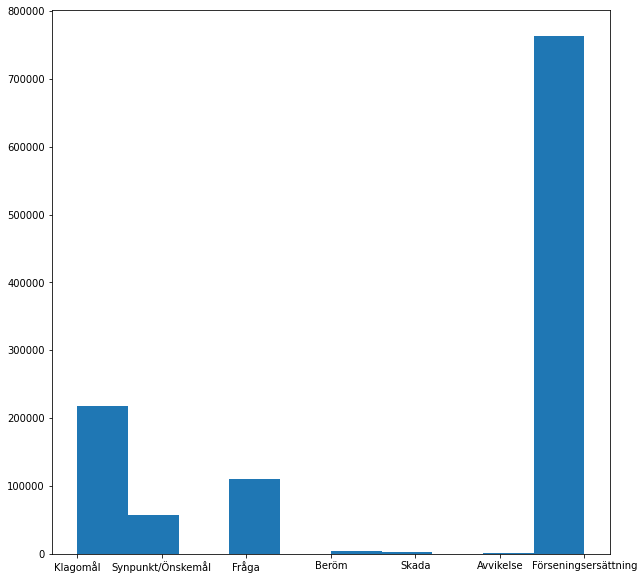

In [32]:
plt.figure(figsize=(10,10))
plt.hist(df['Ärendetyp'])

In [33]:
df['Ärendetyp'].value_counts()

Förseningsersättning    762991
Klagomål                218344
Fråga                   109913
Synpunkt/Önskemål        57353
Beröm                     4923
Skada                     2323
Avvikelse                 1581
Name: Ärendetyp, dtype: int64

In [34]:
df.shape

(1157428, 5)

In [35]:
categories = df['Ärendetyp'].unique()

In [36]:
categories

array(['Klagomål', 'Synpunkt/Önskemål', 'Fråga', 'Beröm', 'Skada',
       'Avvikelse', 'Förseningsersättning'], dtype=object)

(array([5.340900e+04, 1.475400e+04, 0.000000e+00, 1.046309e+06,
        0.000000e+00, 2.999200e+04, 7.996000e+03, 0.000000e+00,
        4.500000e+01, 4.923000e+03]),
 array([1. , 1.6, 2.2, 2.8, 3.4, 4. , 4.6, 5.2, 5.8, 6.4, 7. ]),
 <BarContainer object of 10 artists>)

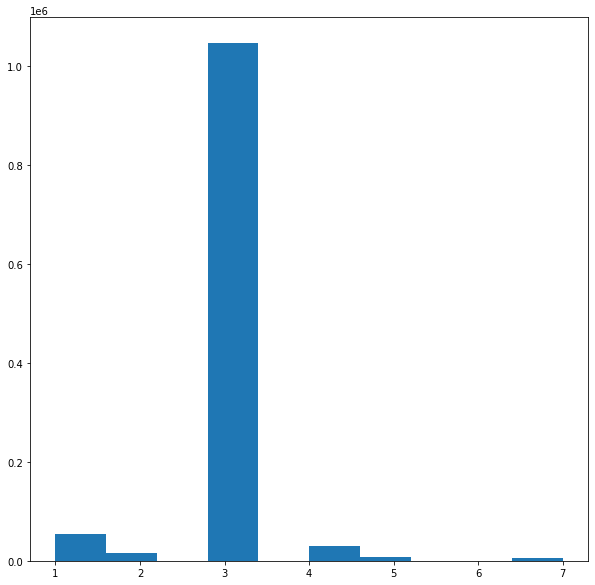

In [37]:
plt.figure(figsize=(10,10))
plt.hist(df['Sentiment'])


In [38]:
df['Sentiment'].value_counts()

3    1046309
1      53409
4      29992
2      14754
5       7996
7       4923
6         45
Name: Sentiment, dtype: int64

In [39]:
#Will convert the sentiment to a scale, now we have:
#1	Mest upprörd
#2	Upprörd
#3	Neutralt negativ
#4	Neutralt
#5	Neutralt positiv
#6	Positiv
#7	Mest positiv
#However we have zero examples of category 7 at this point. Will however set 4 as zero (Neutral), 1--> -1, 6-->+1
#That is if we have -1 we have the worst sentiment, zero is neutral and +1 is positive
df['SentimentValue'] = (df['Sentiment'] - 4.0)/3.0 #maps to [-1,1]


In [40]:
df['SentimentValue'].describe()

count    1.157428e+06
mean    -3.493922e-01
std      1.876626e-01
min     -1.000000e+00
25%     -3.333333e-01
50%     -3.333333e-01
75%     -3.333333e-01
max      1.000000e+00
Name: SentimentValue, dtype: float64

In [41]:
#Take a true validation set where nothing has been seen before
dfValidation = df.sample(n=50000, replace=False, random_state=42)

In [42]:
dfValidation['Ärendetyp'].value_counts()

Förseningsersättning    33133
Klagomål                 9333
Fråga                    4790
Synpunkt/Önskemål        2364
Beröm                     214
Skada                      92
Avvikelse                  74
Name: Ärendetyp, dtype: int64

In [43]:
df = df.drop(dfValidation.index)

In [44]:
dfValidation.shape

(50000, 6)

In [45]:
#Make a balanced training set
desiredCount = 20000
#desiredCount = 1500
dfBalanced = None
for category in categories:
    sample = df[df['Ärendetyp'] == category].sample(n=desiredCount, replace=True, random_state=42)
    if dfBalanced is None:
        dfBalanced = sample
    else:
        dfBalanced = pd.concat([dfBalanced, sample], ignore_index=True)


#Next random shuffle of all rows
df = dfBalanced.sample(frac=1, random_state=42)

In [46]:
#df = df[:10000] #Max for this computer
df.shape

(140000, 6)

(array([20000., 20000.,     0., 20000.,     0., 20000., 20000.,     0.,
        20000., 20000.]),
 array([0. , 0.6, 1.2, 1.8, 2.4, 3. , 3.6, 4.2, 4.8, 5.4, 6. ]),
 <BarContainer object of 10 artists>)

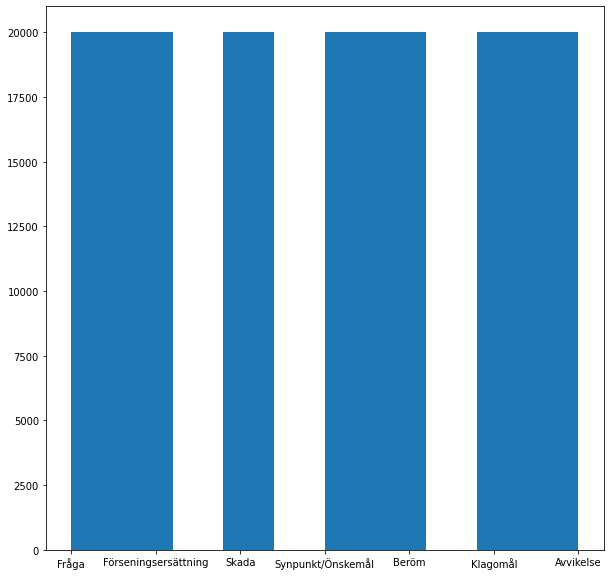

In [47]:
plt.figure(figsize=(10,10))
plt.hist(df['Ärendetyp'])

In [48]:
df['Sentiment'].value_counts()

3    88700
7    20000
1    18308
4     7062
2     3501
5     2411
6       18
Name: Sentiment, dtype: int64

In [49]:
dfValidation['Sentiment'].value_counts()

3    45220
1     2289
4     1311
2      603
5      362
7      214
6        1
Name: Sentiment, dtype: int64

In [50]:
X = df['Beskrivning_Anonymized'].str.lower() #Lower case to slim the vocabulary
X_validation = dfValidation['Beskrivning_Anonymized'].str.lower()

In [51]:
Y = pd.get_dummies(df['Ärendetyp'], columns=['Ärendetyp'])
Y_validation = pd.get_dummies(dfValidation['Ärendetyp'], columns=['Ärendetyp'])

In [52]:
Y.head()

Avvikelse  Beröm  Fråga  Förseningsersättning  Klagomål  Skada  \
40665           0      0      1                     0         0      0   
48520           0      0      1                     0         0      0   
138403          0      0      0                     1         0      0   
130079          0      0      0                     1         0      0   
50146           0      0      1                     0         0      0   

        Synpunkt/Önskemål  
40665                   0  
48520                   0  
138403                  0  
130079                  0  
50146                   0

In [53]:
Y_validation.head()

Avvikelse  Beröm  Fråga  Förseningsersättning  Klagomål  Skada  \
164739          0      0      0                     1         0      0   
776153          0      0      0                     1         0      0   
204493          0      0      0                     1         0      0   
373463          0      0      0                     1         0      0   
564921          0      0      0                     1         0      0   

        Synpunkt/Önskemål  
164739                  0  
776153                  0  
204493                  0  
373463                  0  
564921                  0

In [54]:
#Second target
Y2 = df['SentimentValue']
Y2_validation = dfValidation['SentimentValue']

In [55]:
Y2.head()

40665    -0.333333
48520    -0.333333
138403   -0.333333
130079   -0.333333
50146    -0.666667
Name: SentimentValue, dtype: float64

In [56]:
classes = Y.columns

In [57]:
classes

Index(['Avvikelse', 'Beröm', 'Fråga', 'Förseningsersättning', 'Klagomål',
       'Skada', 'Synpunkt/Önskemål'],
      dtype='object')

In [58]:
Y.shape

(140000, 7)

In [59]:
transformer = NLPTransformer()

Init called


Some weights of the model checkpoint at KB/bert-base-swedish-cased were not used when initializing BertModel: ['cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


We are running on device: cuda


In [60]:
X.shape

(140000,)

In [61]:
Y.shape

(140000, 7)

In [62]:
Y2.shape

(140000,)

In [63]:
X.to_pickle('X_raw.pkl')
X_validation.to_pickle('X_validation_raw.pkl')
Y.to_pickle('targets.pkl')
Y2.to_pickle('targets2.pkl')
Y_validation.to_pickle('targets_validation.pkl')
Y2_validation.to_pickle('targets2_validation.pkl')

In [64]:
X_transformed = transformer.transform(X)

Transform Called
Running batch 1/1400
output shape: (100, 768)
Running batch 2/1400
output shape: (100, 768)
Running batch 3/1400
output shape: (100, 768)
Running batch 4/1400
output shape: (100, 768)
Running batch 5/1400
output shape: (100, 768)
Running batch 6/1400
output shape: (100, 768)
Running batch 7/1400
output shape: (100, 768)
Running batch 8/1400
output shape: (100, 768)
Running batch 9/1400
output shape: (100, 768)
Running batch 10/1400
output shape: (100, 768)
Running batch 11/1400
output shape: (100, 768)
Running batch 12/1400
output shape: (100, 768)
Running batch 13/1400
output shape: (100, 768)
Running batch 14/1400
output shape: (100, 768)
Running batch 15/1400
output shape: (100, 768)
Running batch 16/1400
output shape: (100, 768)
Running batch 17/1400
output shape: (100, 768)
Running batch 18/1400
output shape: (100, 768)
Running batch 19/1400
output shape: (100, 768)
Running batch 20/1400
output shape: (100, 768)
Running batch 21/1400
output shape: (100, 768)
Runni

output shape: (100, 768)
Running batch 175/1400
output shape: (100, 768)
Running batch 176/1400
output shape: (100, 768)
Running batch 177/1400
output shape: (100, 768)
Running batch 178/1400
output shape: (100, 768)
Running batch 179/1400
output shape: (100, 768)
Running batch 180/1400
output shape: (100, 768)
Running batch 181/1400
output shape: (100, 768)
Running batch 182/1400
output shape: (100, 768)
Running batch 183/1400
output shape: (100, 768)
Running batch 184/1400
output shape: (100, 768)
Running batch 185/1400
output shape: (100, 768)
Running batch 186/1400
output shape: (100, 768)
Running batch 187/1400
output shape: (100, 768)
Running batch 188/1400
output shape: (100, 768)
Running batch 189/1400
output shape: (100, 768)
Running batch 190/1400
output shape: (100, 768)
Running batch 191/1400
output shape: (100, 768)
Running batch 192/1400
output shape: (100, 768)
Running batch 193/1400
output shape: (100, 768)
Running batch 194/1400
output shape: (100, 768)
Running batch 1

output shape: (100, 768)
Running batch 346/1400
output shape: (100, 768)
Running batch 347/1400
output shape: (100, 768)
Running batch 348/1400
output shape: (100, 768)
Running batch 349/1400
output shape: (100, 768)
Running batch 350/1400
output shape: (100, 768)
Running batch 351/1400
output shape: (100, 768)
Running batch 352/1400
output shape: (100, 768)
Running batch 353/1400
output shape: (100, 768)
Running batch 354/1400
output shape: (100, 768)
Running batch 355/1400
output shape: (100, 768)
Running batch 356/1400
output shape: (100, 768)
Running batch 357/1400
output shape: (100, 768)
Running batch 358/1400
output shape: (100, 768)
Running batch 359/1400
output shape: (100, 768)
Running batch 360/1400
output shape: (100, 768)
Running batch 361/1400
output shape: (100, 768)
Running batch 362/1400
output shape: (100, 768)
Running batch 363/1400
output shape: (100, 768)
Running batch 364/1400
output shape: (100, 768)
Running batch 365/1400
output shape: (100, 768)
Running batch 3

output shape: (100, 768)
Running batch 517/1400
output shape: (100, 768)
Running batch 518/1400
output shape: (100, 768)
Running batch 519/1400
output shape: (100, 768)
Running batch 520/1400
output shape: (100, 768)
Running batch 521/1400
output shape: (100, 768)
Running batch 522/1400
output shape: (100, 768)
Running batch 523/1400
output shape: (100, 768)
Running batch 524/1400
output shape: (100, 768)
Running batch 525/1400
output shape: (100, 768)
Running batch 526/1400
output shape: (100, 768)
Running batch 527/1400
output shape: (100, 768)
Running batch 528/1400
output shape: (100, 768)
Running batch 529/1400
output shape: (100, 768)
Running batch 530/1400
output shape: (100, 768)
Running batch 531/1400
output shape: (100, 768)
Running batch 532/1400
output shape: (100, 768)
Running batch 533/1400
output shape: (100, 768)
Running batch 534/1400
output shape: (100, 768)
Running batch 535/1400
output shape: (100, 768)
Running batch 536/1400
output shape: (100, 768)
Running batch 5

output shape: (100, 768)
Running batch 688/1400
output shape: (100, 768)
Running batch 689/1400
output shape: (100, 768)
Running batch 690/1400
output shape: (100, 768)
Running batch 691/1400
output shape: (100, 768)
Running batch 692/1400
output shape: (100, 768)
Running batch 693/1400
output shape: (100, 768)
Running batch 694/1400
output shape: (100, 768)
Running batch 695/1400
output shape: (100, 768)
Running batch 696/1400
output shape: (100, 768)
Running batch 697/1400
output shape: (100, 768)
Running batch 698/1400
output shape: (100, 768)
Running batch 699/1400
output shape: (100, 768)
Running batch 700/1400
output shape: (100, 768)
Running batch 701/1400
output shape: (100, 768)
Running batch 702/1400
output shape: (100, 768)
Running batch 703/1400
output shape: (100, 768)
Running batch 704/1400
output shape: (100, 768)
Running batch 705/1400
output shape: (100, 768)
Running batch 706/1400
output shape: (100, 768)
Running batch 707/1400
output shape: (100, 768)
Running batch 7

output shape: (100, 768)
Running batch 859/1400
output shape: (100, 768)
Running batch 860/1400
output shape: (100, 768)
Running batch 861/1400
output shape: (100, 768)
Running batch 862/1400
output shape: (100, 768)
Running batch 863/1400
output shape: (100, 768)
Running batch 864/1400
output shape: (100, 768)
Running batch 865/1400
output shape: (100, 768)
Running batch 866/1400
output shape: (100, 768)
Running batch 867/1400
output shape: (100, 768)
Running batch 868/1400
output shape: (100, 768)
Running batch 869/1400
output shape: (100, 768)
Running batch 870/1400
output shape: (100, 768)
Running batch 871/1400
output shape: (100, 768)
Running batch 872/1400
output shape: (100, 768)
Running batch 873/1400
output shape: (100, 768)
Running batch 874/1400
output shape: (100, 768)
Running batch 875/1400
output shape: (100, 768)
Running batch 876/1400
output shape: (100, 768)
Running batch 877/1400
output shape: (100, 768)
Running batch 878/1400
output shape: (100, 768)
Running batch 8

output shape: (100, 768)
Running batch 1030/1400
output shape: (100, 768)
Running batch 1031/1400
output shape: (100, 768)
Running batch 1032/1400
output shape: (100, 768)
Running batch 1033/1400
output shape: (100, 768)
Running batch 1034/1400
output shape: (100, 768)
Running batch 1035/1400
output shape: (100, 768)
Running batch 1036/1400
output shape: (100, 768)
Running batch 1037/1400
output shape: (100, 768)
Running batch 1038/1400
output shape: (100, 768)
Running batch 1039/1400
output shape: (100, 768)
Running batch 1040/1400
output shape: (100, 768)
Running batch 1041/1400
output shape: (100, 768)
Running batch 1042/1400
output shape: (100, 768)
Running batch 1043/1400
output shape: (100, 768)
Running batch 1044/1400
output shape: (100, 768)
Running batch 1045/1400
output shape: (100, 768)
Running batch 1046/1400
output shape: (100, 768)
Running batch 1047/1400
output shape: (100, 768)
Running batch 1048/1400
output shape: (100, 768)
Running batch 1049/1400
output shape: (100, 

output shape: (100, 768)
Running batch 1198/1400
output shape: (100, 768)
Running batch 1199/1400
output shape: (100, 768)
Running batch 1200/1400
output shape: (100, 768)
Running batch 1201/1400
output shape: (100, 768)
Running batch 1202/1400
output shape: (100, 768)
Running batch 1203/1400
output shape: (100, 768)
Running batch 1204/1400
output shape: (100, 768)
Running batch 1205/1400
output shape: (100, 768)
Running batch 1206/1400
output shape: (100, 768)
Running batch 1207/1400
output shape: (100, 768)
Running batch 1208/1400
output shape: (100, 768)
Running batch 1209/1400
output shape: (100, 768)
Running batch 1210/1400
output shape: (100, 768)
Running batch 1211/1400
output shape: (100, 768)
Running batch 1212/1400
output shape: (100, 768)
Running batch 1213/1400
output shape: (100, 768)
Running batch 1214/1400
output shape: (100, 768)
Running batch 1215/1400
output shape: (100, 768)
Running batch 1216/1400
output shape: (100, 768)
Running batch 1217/1400
output shape: (100, 

output shape: (100, 768)
Running batch 1366/1400
output shape: (100, 768)
Running batch 1367/1400
output shape: (100, 768)
Running batch 1368/1400
output shape: (100, 768)
Running batch 1369/1400
output shape: (100, 768)
Running batch 1370/1400
output shape: (100, 768)
Running batch 1371/1400
output shape: (100, 768)
Running batch 1372/1400
output shape: (100, 768)
Running batch 1373/1400
output shape: (100, 768)
Running batch 1374/1400
output shape: (100, 768)
Running batch 1375/1400
output shape: (100, 768)
Running batch 1376/1400
output shape: (100, 768)
Running batch 1377/1400
output shape: (100, 768)
Running batch 1378/1400
output shape: (100, 768)
Running batch 1379/1400
output shape: (100, 768)
Running batch 1380/1400
output shape: (100, 768)
Running batch 1381/1400
output shape: (100, 768)
Running batch 1382/1400
output shape: (100, 768)
Running batch 1383/1400
output shape: (100, 768)
Running batch 1384/1400
output shape: (100, 768)
Running batch 1385/1400
output shape: (100, 

In [65]:
X_transformed.shape

(140000, 768)

In [66]:
np.save('transformed_data.pkl', X_transformed)

In [67]:
X_transformed_validation = transformer.transform(X_validation)

Transform Called
Running batch 1/500
output shape: (100, 768)
Running batch 2/500
output shape: (100, 768)
Running batch 3/500
output shape: (100, 768)
Running batch 4/500
output shape: (100, 768)
Running batch 5/500
output shape: (100, 768)
Running batch 6/500
output shape: (100, 768)
Running batch 7/500
output shape: (100, 768)
Running batch 8/500
output shape: (100, 768)
Running batch 9/500
output shape: (100, 768)
Running batch 10/500
output shape: (100, 768)
Running batch 11/500
output shape: (100, 768)
Running batch 12/500
output shape: (100, 768)
Running batch 13/500
output shape: (100, 768)
Running batch 14/500
output shape: (100, 768)
Running batch 15/500
output shape: (100, 768)
Running batch 16/500
output shape: (100, 768)
Running batch 17/500
output shape: (100, 768)
Running batch 18/500
output shape: (100, 768)
Running batch 19/500
output shape: (100, 768)
Running batch 20/500
output shape: (100, 768)
Running batch 21/500
output shape: (100, 768)
Running batch 22/500
outpu

output shape: (100, 768)
Running batch 178/500
output shape: (100, 768)
Running batch 179/500
output shape: (100, 768)
Running batch 180/500
output shape: (100, 768)
Running batch 181/500
output shape: (100, 768)
Running batch 182/500
output shape: (100, 768)
Running batch 183/500
output shape: (100, 768)
Running batch 184/500
output shape: (100, 768)
Running batch 185/500
output shape: (100, 768)
Running batch 186/500
output shape: (100, 768)
Running batch 187/500
output shape: (100, 768)
Running batch 188/500
output shape: (100, 768)
Running batch 189/500
output shape: (100, 768)
Running batch 190/500
output shape: (100, 768)
Running batch 191/500
output shape: (100, 768)
Running batch 192/500
output shape: (100, 768)
Running batch 193/500
output shape: (100, 768)
Running batch 194/500
output shape: (100, 768)
Running batch 195/500
output shape: (100, 768)
Running batch 196/500
output shape: (100, 768)
Running batch 197/500
output shape: (100, 768)
Running batch 198/500
output shape:

output shape: (100, 768)
Running batch 353/500
output shape: (100, 768)
Running batch 354/500
output shape: (100, 768)
Running batch 355/500
output shape: (100, 768)
Running batch 356/500
output shape: (100, 768)
Running batch 357/500
output shape: (100, 768)
Running batch 358/500
output shape: (100, 768)
Running batch 359/500
output shape: (100, 768)
Running batch 360/500
output shape: (100, 768)
Running batch 361/500
output shape: (100, 768)
Running batch 362/500
output shape: (100, 768)
Running batch 363/500
output shape: (100, 768)
Running batch 364/500
output shape: (100, 768)
Running batch 365/500
output shape: (100, 768)
Running batch 366/500
output shape: (100, 768)
Running batch 367/500
output shape: (100, 768)
Running batch 368/500
output shape: (100, 768)
Running batch 369/500
output shape: (100, 768)
Running batch 370/500
output shape: (100, 768)
Running batch 371/500
output shape: (100, 768)
Running batch 372/500
output shape: (100, 768)
Running batch 373/500
output shape:

In [69]:
np.save('transformed_data_validation.pkl', X_transformed_validation)

In [2]:
#read back the data
#X_transformed = np.load('transformed_data.pkl.npy')
X_transformed = np.load('transformed_data.pkl.npy')

In [3]:
Y = pd.read_pickle('targets.pkl')
Y2 = pd.read_pickle('targets2.pkl')

In [4]:
#Note in case of pytorch CrossEntropyLoss, the targets should be the class index, not one hot encoded
Y = Y.values.argmax(axis=1)


In [5]:
Y

array([2, 2, 3, ..., 0, 3, 3], dtype=int64)

In [6]:
Y.max()

6

In [7]:
#Convert to numpy array
Y2 = np.array(Y2)

In [8]:
#Try and use Y2 as classes instead
Y2_classes = np.array(Y2*3 + 3).astype('int64')
Y2_classes

array([2, 2, 2, ..., 2, 2, 2], dtype=int64)

In [9]:
Y2_classes

array([2, 2, 2, ..., 2, 2, 2], dtype=int64)

(array([1.8308e+04, 3.5010e+03, 0.0000e+00, 8.8700e+04, 0.0000e+00,
        7.0620e+03, 2.4110e+03, 0.0000e+00, 1.8000e+01, 2.0000e+04]),
 array([0. , 0.6, 1.2, 1.8, 2.4, 3. , 3.6, 4.2, 4.8, 5.4, 6. ]),
 <BarContainer object of 10 artists>)

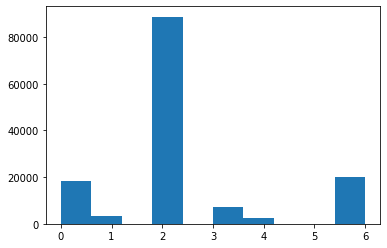

In [10]:
plt.hist(Y2_classes)

In [81]:
X.head()

40665     hej jag heter xxxx xxxx och är brandman och jo...
48520                                       info färdtjänst
138403    upplevd försening\r\r\r\n00-00 min\r\r\r\n\r\r...
130079    upplevd försening\r\r\r\n00-00 min\r\r\r\n\r\r...
50146                                          cgi test ggg
Name: Beskrivning_Anonymized, dtype: object

In [82]:
X[3]

'http://www.kristianstadsbladet.se/kristianstad/i-dag-spikas-nya-taxezoner-for-skane/'

In [84]:
inputs = tok('hej, Har nu fått tag i föraren som är', return_tensors="pt", padding='max_length', max_length = 512, truncation=True)

In [85]:
inputs

{'input_ids': tensor([[    2,  8819,    19,  1177,   346,   902,  1326,    31, 15367,    67,
            54,     3,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,  

In [12]:
#Test train split

In [56]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

In [57]:
X_train.shape

(8400,)

In [24]:
Y_train[:5]

Avvikelse  Beröm  Fråga  Förseningsersättning  Klagomål  Skada  \
935           1      0      0                     0         0      0   
1009          1      0      0                     0         0      0   
262           0      0      0                     0         0      0   
931           1      0      0                     0         0      0   
814           0      1      0                     0         0      0   

      Synpunkt/Önskemål  
935                   0  
1009                  0  
262                   1  
931                   0  
814                   0

In [86]:
class MiniBatcher():
    def __init__(self, X, Y, batch_size=100):
        self.X = X
        self.Y = Y
        self.batch_size = batch_size
        self.batchId = 0     
        
    def getBatchIterator(self):
        self.batchId = 0
        self.epochId = 0
        
        while True:
            X_mini = self.X[self.batchId * self.batch_size:(self.batchId + 1) * self.batch_size]
            Y_mini = self.Y[self.batchId * self.batch_size:(self.batchId + 1) * self.batch_size]
            self.batchId += 1

            if len(X_mini) < self.batch_size:               
                self.batchId = 0
                break
            
            yield X_mini, Y_mini
            
    def getBatchInfo(self):
        return f'batch: {self.batchId}/{int(np.ceil(self.X.shape[0] / self.batch_size))}'

In [61]:
mMiniBatcher = MiniBatcher(X_train, Y_train)

NameError: name 'X_train' is not defined

In [31]:
batchIterator = mMiniBatcher.getBatchIterator()

In [59]:
#Train the model
#output = pipeline.fit(X_train[:25], Y_train[:25].values)
#output = pipeline.fit(X_train[:1500], Y_train[:1500].values)
output = pipeline.fit(X_train, Y_train.values)

Fit called
Transform Called
Running batch 1/168
output shape: (50, 768)
Running batch 2/168
output shape: (50, 768)
Running batch 3/168
output shape: (50, 768)
Running batch 4/168
output shape: (50, 768)
Running batch 5/168
output shape: (50, 768)
Running batch 6/168
output shape: (50, 768)
Running batch 7/168
output shape: (50, 768)
Running batch 8/168
output shape: (50, 768)
Running batch 9/168
output shape: (50, 768)
Running batch 10/168
output shape: (50, 768)
Running batch 11/168
output shape: (50, 768)
Running batch 12/168
output shape: (50, 768)
Running batch 13/168
output shape: (50, 768)
Running batch 14/168
output shape: (50, 768)
Running batch 15/168
output shape: (50, 768)
Running batch 16/168
output shape: (50, 768)
Running batch 17/168
output shape: (50, 768)
Running batch 18/168
output shape: (50, 768)
Running batch 19/168
output shape: (50, 768)
Running batch 20/168
output shape: (50, 768)
Running batch 21/168
output shape: (50, 768)
Running batch 22/168
output shape: (

In [ ]:
output.predict(X_test[:10])

In [135]:
probs = output.predict_proba(X_test[:15])

Transform Called
Running batch 1/2
output shape: (10, 768)
Running batch 2/2
output shape: (5, 768)
transformed.shape: (15, 768)


In [53]:
Y_test[:3].values

array([[0, 0, 1, 0, 0],
       [1, 0, 0, 0, 0],
       [0, 1, 0, 0, 0]], dtype=uint8)

In [75]:
Y_test[:15]

Avvikelse  Beröm  Fråga  Förseningsersättning  Klagomål  Skada  \
521          0      0      1                     0         0      0   
941          0      0      0                     0         0      0   
741          0      0      1                     0         0      0   
980          0      0      0                     0         0      0   
411          0      0      0                     0         0      0   
679          0      0      1                     0         0      0   
673          0      0      0                     0         0      0   
513          0      0      0                     0         1      0   
773          0      0      0                     0         1      0   
136          0      0      0                     0         0      0   
889          0      0      1                     0         0      0   
76           0      0      0                     1         0      0   
739          0      0      0                     0         0      0   
806          0      0      0                     0         0      0   
939          0      0      0                     0         0      0   

     Synpunkt/Önskemål  
521                  0  
941                  1  
741                  0  
980                  1  
411                  1  
679                  0  
673                  1  
513                  0  
773                  0  
136                  1  
889                  0  
76                   0  
739                  1  
806                  1  
939                  1

In [87]:
#This will predict the classes for each row. The class with the highest probability is selected
def PredictClasses(model, X):
    probs = model.predict_proba(X)
    probs = np.array(probs) #List to (N, num_classes, 2)
    predictedClasses = np.argmax(probs[:,:,1].T, axis=1) #First index classifies it as 0, second as 1, Then get the max index for each row
    
    return predictedClasses
    
    
    

In [105]:
X[3]

'hej, \r\nvarför heter en av hållplatserna i ludvigsborg kvarndamms gatan i hörby kommun, skåne? dels så finns det ingen väg som heter så där, den heter kvarndamsvägen. dessutom är hållplatsen på ludvigsborgsvägen. xxxx ni vidarebefordra detta till rätt avdelning så det blir ändrat för att inte göra det förvirrat för resenärerna?\r\nhälsningar fredrik\r\r\n'

In [31]:
result = PredictClasses(pipeline, X_test[10:20])

Transform Called
Running batch 1/1
output shape: (10, 768)
transformed.shape: (10, 768)


In [29]:
result

array([3, 3, 3, 3, 3, 3, 6, 3, 3, 2], dtype=int64)

In [32]:
Y_test[10:20]

Avvikelse  Beröm  Fråga  Förseningsersättning  Klagomål  Skada  \
2750          0      0      0                     1         0      0   
7487          0      0      0                     1         0      0   
5272          0      0      0                     1         0      0   
5653          0      0      0                     1         0      0   
3999          0      0      0                     1         0      0   
6033          0      0      0                     1         0      0   
582           0      0      0                     0         1      0   
9930          0      0      0                     1         0      0   
7051          0      0      0                     1         0      0   
8158          0      0      0                     1         0      0   

      Synpunkt/Önskemål  
2750                  0  
7487                  0  
5272                  0  
5653                  0  
3999                  0  
6033                  0  
582                   0  
9930                  0  
7051                  0  
8158                  0

In [38]:
result

array([3, 3, 3, 3, 3, 3, 6, 3, 3, 3], dtype=int64)

In [41]:
ost = Y_test[10:20].to_numpy().argmax(axis=1)
ost

array([3, 3, 3, 3, 3, 3, 4, 3, 3, 3], dtype=int64)

In [51]:
result.shape

(10,)

In [77]:
cm = confusion_matrix(ost, result,normalize='true')
cm

array([[1., 0., 0.],
       [0., 0., 1.],
       [0., 0., 0.]])

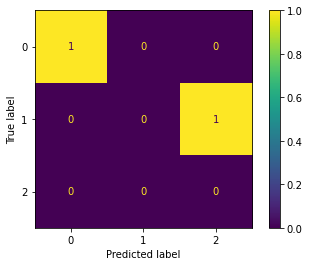

In [78]:
ConfusionMatrixDisplay(confusion_matrix=cm,).plot()

In [61]:
confusion_matrix(ost, result)

array([[9, 0, 0],
       [0, 0, 1],
       [0, 0, 0]], dtype=int64)

In [62]:
#results = PredictClasses(pipeline, X_test[:15])
results = PredictClasses(pipeline, X_test)
results

Transform Called
Running batch 1/200


KeyboardInterrupt: 

In [85]:
results

array([4, 6, 4, 6, 6, 6, 4, 4, 6, 4, 6, 4, 6, 6, 6, 6, 6, 2, 4, 6, 6, 2,
       2, 4, 4, 4, 4, 6, 2, 4, 4, 6, 6, 6, 4, 4, 6, 2, 6, 4, 4, 4, 3, 6,
       4, 6, 2, 6, 2, 6, 6, 2, 6, 6, 4, 6, 4, 4, 4, 6, 4, 4, 4, 6, 6, 6,
       6, 2, 4, 6, 6, 6, 6, 6, 4, 4, 2, 4, 6, 4, 6, 4, 2, 6, 4, 2, 6, 6,
       2, 2, 4, 4, 4, 4, 6, 4, 4, 4, 4, 6, 6, 4, 4, 2, 2, 6, 4, 4, 3, 6,
       6, 4, 6, 6, 4, 4, 6, 6, 6, 4, 6, 6, 6, 2, 4, 6, 6, 4, 6, 6, 6, 6,
       6, 6, 6, 4, 4, 4, 6, 4, 4, 6, 6, 4, 6, 2, 6, 4, 2, 4, 4, 2, 6, 2,
       6, 6, 2, 6, 4, 6, 6, 4, 6, 6, 2, 6, 4, 6, 3, 4, 4, 4, 2, 6, 4, 4,
       6, 2, 6, 2, 4, 6, 4, 2, 6, 2, 4, 6, 6, 6, 4, 6, 6, 4, 2, 6, 6, 2,
       6, 2, 6], dtype=int64)

In [89]:
targets = np.argmax(np.array(Y), axis=1)
targets

array([4, 6, 5, ..., 4, 4, 2], dtype=int64)

In [37]:
Y_test.columns

Index(['Avvikelse', 'Beröm', 'Fråga', 'Förseningsersättning', 'Klagomål',
       'Skada', 'Synpunkt/Önskemål'],
      dtype='object')

In [41]:
Y_test.columns.shape

(7,)

In [45]:
def EvaluateModelUsingProbs(model, X_test, Y_test):
    Y_pred = PredictClasses(model, X_test) #1D-array with classes
    targets = np.argmax(np.array(Y_test), axis=1) #1D-array with classes
    
    total_hits = np.sum(np.sum(Y_pred == targets))
    total_misses = np.sum(np.sum(Y_pred != targets))
    total_accuracy = total_hits/(total_hits + total_misses)
    print(f'Total Accuracy: {total_accuracy}')
    #cm = confusion_matrix(targets, Y_pred, normalize='true')
    #ConfusionMatrixDisplay(confusion_matrix=cm,).plot()
    cm = confusion_matrix(targets, Y_pred, normalize='true', labels=list(range(Y_test.columns.shape[0])))
    ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(range(Y_test.columns.shape[0]))).plot()
    

In [35]:
#Evaluate the model and print the accuracy

def EvaluateModel(model, X_test, Y_test):
    Y_pred = model.predict(X_test)
    
    total_hits = np.sum(np.sum(Y_pred == Y_test))
    total_misses = np.sum(np.sum(Y_pred != Y_test))
    total_accuracy = total_hits/(total_hits + total_misses)
       
    target_names = [name for name in Y.columns]

    precisions = []
    recalls = []
    f1scores = []
    for (name, col) in zip(target_names, range(len(target_names))):
        y_test = Y_test[name].values
        y_pred = Y_pred[:, col]
        
        if(np.max(y_test) <= 1):
            #Only one category
            precisions.append(precision_score(y_test, y_pred))
            recalls.append(recall_score(y_test, y_pred))
            f1scores.append(f1_score(y_test, y_pred))
        print(f'Category: {name}')
        print(classification_report(y_test, y_pred))
        print('-'*42)
     
    
    print(f'Total Accuracy: {total_accuracy}')
    print(f'Average Precission: {np.average(precisions)}')
    print(f'Average Recall: {np.average(recalls)}')
    print(f'Average F1 Score: {np.average(f1scores)}')

In [88]:
EvaluateModel(pipeline, X_test[:100], Y_test[:100])

Transform Called
Running batch 1/10
output shape: (10, 768)
Running batch 2/10
output shape: (10, 768)
Running batch 3/10
output shape: (10, 768)
Running batch 4/10
output shape: (10, 768)
Running batch 5/10
output shape: (10, 768)
Running batch 6/10
output shape: (10, 768)
Running batch 7/10
output shape: (10, 768)
Running batch 8/10
output shape: (10, 768)
Running batch 9/10
output shape: (10, 768)
Running batch 10/10
output shape: (10, 768)
transformed.shape: (100, 768)
Category: Avvikelse
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       100

    accuracy                           1.00       100
   macro avg       1.00      1.00      1.00       100
weighted avg       1.00      1.00      1.00       100

------------------------------------------
Category: Beröm
              precision    recall  f1-score   support

           0       0.99      1.00      0.99        99
           1       0.00      0.00      0.00         1

    ac

C:\ProgramData\Anaconda3\envs\dataScience\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\envs\dataScience\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\envs\dataScience\lib\site-packages\sklearn\metrics\_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
C:\ProgramData\Anaconda3\envs\dataScience\lib\site-

Transform Called
Running batch 1/42
output shape: (50, 768)
Running batch 2/42
output shape: (50, 768)
Running batch 3/42
output shape: (50, 768)
Running batch 4/42
output shape: (50, 768)
Running batch 5/42
output shape: (50, 768)
Running batch 6/42
output shape: (50, 768)
Running batch 7/42
output shape: (50, 768)
Running batch 8/42
output shape: (50, 768)
Running batch 9/42
output shape: (50, 768)
Running batch 10/42
output shape: (50, 768)
Running batch 11/42
output shape: (50, 768)
Running batch 12/42
output shape: (50, 768)
Running batch 13/42
output shape: (50, 768)
Running batch 14/42
output shape: (50, 768)
Running batch 15/42
output shape: (50, 768)
Running batch 16/42
output shape: (50, 768)
Running batch 17/42
output shape: (50, 768)
Running batch 18/42
output shape: (50, 768)
Running batch 19/42
output shape: (50, 768)
Running batch 20/42
output shape: (50, 768)
Running batch 21/42
output shape: (50, 768)
Running batch 22/42
output shape: (50, 768)
Running batch 23/42
outp

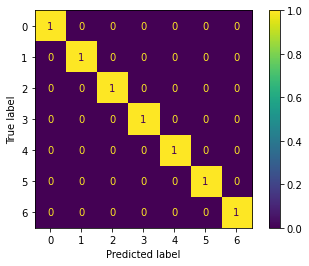

In [60]:
EvaluateModelUsingProbs(pipeline, X_test, Y_test)

In [108]:
EvaluateModelUsingProbs(pipeline, X_train, Y_train)

Transform Called
Running batch 1/80
output shape: (10, 768)
Running batch 2/80
output shape: (10, 768)
Running batch 3/80
output shape: (10, 768)
Running batch 4/80
output shape: (10, 768)
Running batch 5/80
output shape: (10, 768)
Running batch 6/80
output shape: (10, 768)
Running batch 7/80
output shape: (10, 768)
Running batch 8/80
output shape: (10, 768)
Running batch 9/80
output shape: (10, 768)
Running batch 10/80
output shape: (10, 768)
Running batch 11/80
output shape: (10, 768)
Running batch 12/80
output shape: (10, 768)
Running batch 13/80
output shape: (10, 768)
Running batch 14/80
output shape: (10, 768)
Running batch 15/80
output shape: (10, 768)
Running batch 16/80
output shape: (10, 768)
Running batch 17/80
output shape: (10, 768)
Running batch 18/80
output shape: (10, 768)
Running batch 19/80
output shape: (10, 768)
Running batch 20/80
output shape: (10, 768)
Running batch 21/80
output shape: (10, 768)
Running batch 22/80
output shape: (10, 768)
Running batch 23/80
outp

In [104]:
X[:2].values

array(['hej,\r\r\n \r\r\nhar nu fått tag i föraren som är i grekland på semester.\r\r\n \r\r\nden unga killen som frågade fick svaret av föraren att det är läge xxxx som gäller på knutpunkten.\r\r\n\r\r\ndetta gav föraren resenären efter att ha själv letat upp det på skånetrafikens app.\r\r\nmotparten lämnar tyvärr en del information till sin egen fördel.\r\r\nföraren försökte att hjälpa så gott han kunde.\r\r\n \r\r\n\r\r\nmed vänlig hälsning,\r\r\n  xxxx prata\r\r\n\r\r\ngruppchef\r\r\n \r\r\nnobina sverige ab\r\r\n\r\r\nadress: streetname_replaced 00, 000 00 helsingborg\r\r\nmobil:  +00 00 000 00 00\r\r\ndirekt: +00 0 000 000 00\r\r\n\r\r\nväxel:  +00 0 000 000 00\r\r\n\r\r\nhemsida:\r\r\nwww.nobina.com\r\r\n \r\r\nnobina sverige ab, org.nr 000000-0000 | styrelsens säte - stockholm\r\r\n\r\r\np please consider the environment before printing this e-mail.\r\r\n\r\r\n \r\r\n\r\r\nfrån: xxxx prata \r\r\n\r\r\nskickat: den 00 oktober 0000 00:00\r\r\n\r\r\ntill: email@address.replaced em

In [94]:
inputs = X[]

In [95]:
inputs

0    jag vill ha ersättning för min biljett, då tåg...
1                      bussen hade dålig air condition
2    beskrivning i avic:\r\r\n xxxx sjukresebeställ...
dtype: object

In [107]:
PredictClasses(pipeline, X[10:20])

Transform Called
Running batch 1/1
output shape: (10, 768)
transformed.shape: (10, 768)


array([6, 1, 4, 4, 6, 6, 4, 2, 5, 0], dtype=int64)

In [108]:
Y[10:20]

Avvikelse  Beröm  Fråga  Förseningsersättning  Klagomål  Skada  \
10          0      0      1                     0         0      0   
11          0      0      0                     0         0      0   
12          0      0      0                     0         0      0   
13          0      0      0                     0         0      0   
14          0      0      0                     0         0      0   
15          0      0      0                     0         1      0   
16          0      0      0                     0         1      0   
17          0      0      1                     0         0      0   
18          0      0      0                     0         1      0   
19          0      0      0                     0         1      0   

    Synpunkt/Önskemål  
10                  0  
11                  1  
12                  1  
13                  1  
14                  1  
15                  0  
16                  0  
17                  0  
18                  0  
19                  0

In [140]:
#Save, Load model

In [61]:
from joblib import dump, load

In [62]:
modelName = 'BertModel.joblib'

In [63]:

dump(pipeline, modelName ) 

['BertModel.joblib']

In [18]:
loadedModel = load(modelName) 

In [19]:
loadedModel.predict(X_test[100:120])

Transform Called
Running batch 1/2
output shape: (10, 768)
Running batch 2/2
output shape: (10, 768)
transformed.shape: (20, 768)


array([[0, 0, 0, 0, 0],
       [0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0],
       [0, 0, 0, 0, 1],
       [1, 0, 0, 0, 0],
       [0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0],
       [0, 0, 0, 1, 0],
       [0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0],
       [0, 0, 1, 0, 0],
       [0, 0, 1, 0, 0],
       [0, 0, 0, 0, 0],
       [0, 0, 0, 0, 1],
       [0, 0, 0, 1, 0],
       [0, 0, 0, 1, 0],
       [1, 0, 0, 0, 0],
       [0, 0, 0, 0, 0],
       [0, 0, 1, 0, 0]], dtype=uint8)

In [1]:
#Deep learning using pytorch

In [88]:


class TorchNLP(nn.Module):
    def __init__(self, n_classes):
        super().__init__()
        #print('Init called')
        self.model_name = 'KB/bert-base-swedish-cased'
        self.Bert = AutoModel.from_pretrained(self.model_name)
        self.Tokenizer = AutoTokenizer.from_pretrained(self.model_name)
        self.n_classes = n_classes
        self.TorchModel = nn.Sequential(nn.Linear(768, 256),
                          nn.ReLU(),
                          nn.Dropout(p=0.42),
                          nn.Linear(256, 128),
                          nn.ReLU(),
                          nn.Dropout(p=0.42),              
                          nn.Linear(128, n_classes))
                          #nn.Softmax(dim=1)) Cannot use softmax here since nn.CrossEntropyLoss expects scores!
        
        #Freeze the Bert model layers
        for param in self.Bert.parameters():
            param.requires_grad = False
            
    def forward(self, X):
        #print('Forward Called')
       
        #Check device
        device = self.Bert.device
        
        # Transform input tokens. This is most efficient if done in one batch 
        X = self.Tokenizer(X.values.tolist(), return_tensors="pt", padding='max_length', max_length = 512, truncation=True).to(device)
        
        X = self.Bert(**X)
        X = X['pooler_output']
        X = self.TorchModel(X)
        
        return X
    
    def predict(self, X):
        with torch.no_grad():
            self.eval()
            output = self.forward(X)
            top_p, top_class = output.topk(1, dim=1)
            top_class = top_class.to('cpu').numpy().reshape(-1,)
            self.train()
            return top_class

In [89]:
#This is the slim version where the BERT features is already provided as input
class TorchNLPLight(nn.Module):
    def __init__(self, n_classes):
        super().__init__()
        #print('Init called')
        self.n_classes = n_classes
        self.TorchModel = nn.Sequential(nn.Conv1d(1, 256, 3, stride=1, padding='same'),
                          nn.Flatten(),
                          nn.BatchNorm1d(256*768),              
                          nn.ReLU(),
                          nn.Dropout(p=0.42),
                          nn.Linear(256*768, 1024),
                          nn.BatchNorm1d(1024),              
                          nn.ReLU(),
                          nn.Dropout(p=0.42),
                          nn.Linear(1024, 512),
                          nn.BatchNorm1d(512),
                          nn.ReLU(),
                          nn.Dropout(p=0.42),
                          nn.Linear(512, 256),
                          nn.BatchNorm1d(256),
                          nn.ReLU(),
                          nn.Dropout(p=0.42),            
                          nn.Linear(256, n_classes))
                          #nn.Softmax(dim=1)) Cannot use softmax here since nn.CrossEntropyLoss expects scores!
        
    def forward(self, X):
        #print('Forward Called')
        X = X.reshape(X.shape[0], 1, X.shape[1]) #Reshape for Conv1d
        X = self.TorchModel(X)
        
        return X
    
    def predict(self, X):
        with torch.no_grad():
            self.eval()
            output = self.forward(X)
            #print(f'X.shape: {X.shape}')
            #print(f'output.shape: {output.shape}')
            top_p, top_class = output.topk(1, dim=1)
            top_class = top_class.to('cpu').numpy().reshape(-1,)
            #print(f'top_class.shape: {top_class.shape}')
            self.train()
            return top_class

In [90]:

testModel = nn.Conv1d(1, 768, 3, stride=1, padding='same')

In [91]:
X_transformed[:5].shape

(5, 768)

In [100]:
torch.tensor(X_transformed[:5].reshape(-1,768,1)).shape

torch.Size([5, 768, 1])

In [126]:
testModel(torch.tensor(X_transformed[:5].reshape(-1,1,768))).shape

torch.Size([5, 768, 768])

In [119]:
testModel(torch.tensor(X_transformed[:5].reshape(-1,1,768))).view(5,-1).shape

torch.Size([5, 589824])

In [117]:
768*768

589824

In [92]:
n_classes = Y.max() + 1
torchModelLight = TorchNLPLight(n_classes = n_classes)

In [93]:
X_transformed.shape

(140000, 768)

In [49]:
#n_classes = Y.shape[1] #In case of one hot encoded, which we don't have anymore
n_classes = Y.max() + 1
torchModel = TorchNLP(n_classes = n_classes)

Some weights of the model checkpoint at KB/bert-base-swedish-cased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [67]:
output = torchModel(X_train[:5])

Forward Called


In [68]:
output

tensor([[0.1394, 0.1599, 0.1548, 0.1324, 0.1248, 0.1408, 0.1479],
        [0.1428, 0.1565, 0.1440, 0.1306, 0.1277, 0.1471, 0.1513],
        [0.1410, 0.1569, 0.1521, 0.1396, 0.1235, 0.1379, 0.1489],
        [0.1318, 0.1499, 0.1585, 0.1312, 0.1373, 0.1510, 0.1404],
        [0.1423, 0.1517, 0.1463, 0.1242, 0.1348, 0.1532, 0.1476]],
       grad_fn=<SoftmaxBackward0>)

In [50]:
#mMiniBatcherTrain = MiniBatcher(X_train[:1000], Y_train[:1000], batch_size=15)
#mMiniBatcherTest = MiniBatcher(X_test[:100], Y_test[:100], batch_size=15)
mMiniBatcherTrain = MiniBatcher(X_train, Y_train, batch_size=100)
mMiniBatcherTest = MiniBatcher(X_test[:500], Y_test[:500], batch_size=100)

In [70]:
for param in torchModel.parameters():
    print(type(param.data), param.size(), param.requires_grad)

<class 'torch.Tensor'> torch.Size([50325, 768]) False
<class 'torch.Tensor'> torch.Size([512, 768]) False
<class 'torch.Tensor'> torch.Size([2, 768]) False
<class 'torch.Tensor'> torch.Size([768]) False
<class 'torch.Tensor'> torch.Size([768]) False
<class 'torch.Tensor'> torch.Size([768, 768]) False
<class 'torch.Tensor'> torch.Size([768]) False
<class 'torch.Tensor'> torch.Size([768, 768]) False
<class 'torch.Tensor'> torch.Size([768]) False
<class 'torch.Tensor'> torch.Size([768, 768]) False
<class 'torch.Tensor'> torch.Size([768]) False
<class 'torch.Tensor'> torch.Size([768, 768]) False
<class 'torch.Tensor'> torch.Size([768]) False
<class 'torch.Tensor'> torch.Size([768]) False
<class 'torch.Tensor'> torch.Size([768]) False
<class 'torch.Tensor'> torch.Size([3072, 768]) False
<class 'torch.Tensor'> torch.Size([3072]) False
<class 'torch.Tensor'> torch.Size([768, 3072]) False
<class 'torch.Tensor'> torch.Size([768]) False
<class 'torch.Tensor'> torch.Size([768]) False
<class 'torc

In [15]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

print(f'We are running on device: {device}')

We are running on device: cuda


In [19]:
gc.collect()
torch.cuda.empty_cache() 

In [47]:
#!pip install GPUtil
from GPUtil import showUtilization as gpu_usage
from numba import cuda

def free_gpu_cache():
    print("Initial GPU Usage")
    gpu_usage()                             

    torch.cuda.empty_cache()

    cuda.select_device(0)
    cuda.close()
    cuda.select_device(0)

    print("GPU Usage after emptying the cache")
    gpu_usage()

In [32]:
#free_gpu_cache()    

Initial GPU Usage
| ID | GPU | MEM  |
-------------------
|  0 | 19% | 100% |
GPU Usage after emptying the cache
| ID | GPU | MEM |
------------------
|  0 | 25% |  8% |


In [54]:
criterion = nn.CrossEntropyLoss()
#optimizer = optim.Adam(torchModel.parameters(), lr=0.003)
#optimizer = optim.Adam(torchModel.parameters(), lr=0.0015)
optimizer = optim.Adam(torchModel.TorchModel.parameters(), lr=0.0015)

epochs = 15
steps = 0
train_losses, test_losses = [], []

torchModel.to(device)
#optimizer.to(device)
criterion.to(device)

for e in range(epochs):
    running_loss = 0
    print(f'Running epoch {e+1}/{epochs}')
    for images, labels in mMiniBatcherTrain.getBatchIterator():
        #print('Training batch...')
        optimizer.zero_grad()
 
        #print(f'labels.shape: {labels.shape}')
        labels = torch.from_numpy(labels).to(device)
        
        #print('Running torch')
        output = torchModel(images)
        
        #print(f'output.shape: {output.shape}')
        #print('Calculating loss')
        
        loss = criterion(output, labels)
        #print('Back prop.')
        loss.backward()
        optimizer.step()
        batch_loss = loss.item()
        print(f'Batch loss: {batch_loss} {mMiniBatcherTrain.getBatchInfo()}')
        running_loss += batch_loss
        
        del labels
        del images
        del output
        gc.collect()
        torch.cuda.empty_cache() 
   
    test_loss = 0
    accuracy = 0

    print('Running evaluation loop...')
    # Turn off gradients for validation, saves memory and computations
    with torch.no_grad():
        torchModel.eval()
        for images, labels in mMiniBatcherTest.getBatchIterator():
            #print('Validation batch...')
            #labels = torch.from_numpy(labels.values).type(torch.FloatTensor)
            labels = torch.from_numpy(labels).to(device)
            output = torchModel(images)
            test_loss += criterion(output, labels).to('cpu') #Want the loss on CPU

            top_p, top_class = output.topk(1, dim=1)
            #print(top_p)
            #top_p_target, top_class_target = labels.topk(1, dim=1)
            #equals = top_class == top_class_target
            equals = top_class == labels.view(top_class.shape)
            accuracy += torch.sum(equals.type(torch.FloatTensor)).to('cpu')
            print(mMiniBatcherTest.getBatchInfo())
            
            del labels
            del images
            del output
            gc.collect()
            torch.cuda.empty_cache() 

    torchModel.train()

    train_losses.append(running_loss/len(mMiniBatcherTrain.X))
    test_losses.append(test_loss/len(mMiniBatcherTest.X))

    print("Epoch: {}/{}.. ".format(e+1, epochs),
          "Training Loss: {:.5f}.. ".format(train_losses[-1]),
          "Test Loss: {:.5f}.. ".format(test_losses[-1]),
          "Test Accuracy: {:.5f}".format(accuracy/len(mMiniBatcherTest.X)))

Running epoch 1/15
Batch loss: 1.954135537147522 batch: 1/840
Batch loss: 1.9362761974334717 batch: 2/840
Batch loss: 1.8906426429748535 batch: 3/840
Batch loss: 1.8690556287765503 batch: 4/840
Batch loss: 1.8202908039093018 batch: 5/840
Batch loss: 1.835722804069519 batch: 6/840
Batch loss: 1.8324123620986938 batch: 7/840
Batch loss: 1.763242244720459 batch: 8/840
Batch loss: 1.6997215747833252 batch: 9/840
Batch loss: 1.6596179008483887 batch: 10/840
Batch loss: 1.5897629261016846 batch: 11/840
Batch loss: 1.539951205253601 batch: 12/840
Batch loss: 1.4772002696990967 batch: 13/840
Batch loss: 1.5468162298202515 batch: 14/840
Batch loss: 1.5089606046676636 batch: 15/840
Batch loss: 1.3836619853973389 batch: 16/840
Batch loss: 1.4789026975631714 batch: 17/840
Batch loss: 1.3889561891555786 batch: 18/840
Batch loss: 1.5200637578964233 batch: 19/840
Batch loss: 1.5299617052078247 batch: 20/840
Batch loss: 1.3485318422317505 batch: 21/840
Batch loss: 1.2940984964370728 batch: 22/840
Batc

Batch loss: 0.7951816320419312 batch: 182/840
Batch loss: 0.8690511584281921 batch: 183/840
Batch loss: 0.7038179039955139 batch: 184/840
Batch loss: 0.6490274667739868 batch: 185/840
Batch loss: 0.6118298172950745 batch: 186/840
Batch loss: 0.899085283279419 batch: 187/840
Batch loss: 0.6294940710067749 batch: 188/840
Batch loss: 0.7716383934020996 batch: 189/840
Batch loss: 0.8323737978935242 batch: 190/840
Batch loss: 0.9039003252983093 batch: 191/840
Batch loss: 0.6373999118804932 batch: 192/840
Batch loss: 0.7699265480041504 batch: 193/840
Batch loss: 0.6271510720252991 batch: 194/840
Batch loss: 0.8850708603858948 batch: 195/840
Batch loss: 0.8654938340187073 batch: 196/840
Batch loss: 0.9021247029304504 batch: 197/840
Batch loss: 0.6622282266616821 batch: 198/840
Batch loss: 0.6796248555183411 batch: 199/840
Batch loss: 1.0166761875152588 batch: 200/840
Batch loss: 0.7078800797462463 batch: 201/840
Batch loss: 0.7737282514572144 batch: 202/840
Batch loss: 0.730421781539917 batch

Batch loss: 0.8427690863609314 batch: 361/840
Batch loss: 0.7094565033912659 batch: 362/840
Batch loss: 0.6792579889297485 batch: 363/840
Batch loss: 0.8090555667877197 batch: 364/840
Batch loss: 0.6996357440948486 batch: 365/840
Batch loss: 0.7451508045196533 batch: 366/840
Batch loss: 0.6123248934745789 batch: 367/840
Batch loss: 0.8089743256568909 batch: 368/840
Batch loss: 0.7570825815200806 batch: 369/840
Batch loss: 0.844102680683136 batch: 370/840
Batch loss: 0.7829903364181519 batch: 371/840
Batch loss: 0.5819993615150452 batch: 372/840
Batch loss: 0.7638490200042725 batch: 373/840
Batch loss: 0.7978590130805969 batch: 374/840
Batch loss: 0.5898246169090271 batch: 375/840
Batch loss: 0.6014736890792847 batch: 376/840
Batch loss: 0.8016733527183533 batch: 377/840
Batch loss: 0.6976556181907654 batch: 378/840
Batch loss: 0.6751377582550049 batch: 379/840
Batch loss: 0.8054524064064026 batch: 380/840
Batch loss: 0.9623992443084717 batch: 381/840
Batch loss: 0.9835478067398071 batc

Batch loss: 0.9284355044364929 batch: 540/840
Batch loss: 0.6596453189849854 batch: 541/840
Batch loss: 0.7162241339683533 batch: 542/840
Batch loss: 0.4929408133029938 batch: 543/840
Batch loss: 0.7537846565246582 batch: 544/840
Batch loss: 0.6873822212219238 batch: 545/840
Batch loss: 0.6991969347000122 batch: 546/840
Batch loss: 0.6705578565597534 batch: 547/840
Batch loss: 0.5631430149078369 batch: 548/840
Batch loss: 0.6281132102012634 batch: 549/840
Batch loss: 0.5886301398277283 batch: 550/840
Batch loss: 0.7284570932388306 batch: 551/840
Batch loss: 0.5658173561096191 batch: 552/840
Batch loss: 0.7600362300872803 batch: 553/840
Batch loss: 0.7598035335540771 batch: 554/840
Batch loss: 0.757946789264679 batch: 555/840
Batch loss: 0.7470917701721191 batch: 556/840
Batch loss: 0.7330151200294495 batch: 557/840
Batch loss: 0.6981569528579712 batch: 558/840
Batch loss: 0.7330963611602783 batch: 559/840
Batch loss: 0.7011208534240723 batch: 560/840
Batch loss: 0.7255317568778992 batc

Batch loss: 0.4618542790412903 batch: 719/840
Batch loss: 0.6074709892272949 batch: 720/840
Batch loss: 0.7665508985519409 batch: 721/840
Batch loss: 0.8022251129150391 batch: 722/840
Batch loss: 0.6108312010765076 batch: 723/840
Batch loss: 0.8637728691101074 batch: 724/840
Batch loss: 0.6542158722877502 batch: 725/840
Batch loss: 0.6007346510887146 batch: 726/840
Batch loss: 0.9786267876625061 batch: 727/840
Batch loss: 0.7840850353240967 batch: 728/840
Batch loss: 0.7231331467628479 batch: 729/840
Batch loss: 0.6894960999488831 batch: 730/840
Batch loss: 0.5432916879653931 batch: 731/840
Batch loss: 0.8383905291557312 batch: 732/840
Batch loss: 0.6988280415534973 batch: 733/840
Batch loss: 0.6126189231872559 batch: 734/840
Batch loss: 0.6437366604804993 batch: 735/840
Batch loss: 0.7362656593322754 batch: 736/840
Batch loss: 0.6232479810714722 batch: 737/840
Batch loss: 0.5787289142608643 batch: 738/840
Batch loss: 0.8120728135108948 batch: 739/840
Batch loss: 0.7618032693862915 bat

Batch loss: 0.7629560232162476 batch: 55/840
Batch loss: 0.7648380994796753 batch: 56/840
Batch loss: 0.6573198437690735 batch: 57/840
Batch loss: 0.6300498843193054 batch: 58/840
Batch loss: 0.7975641489028931 batch: 59/840
Batch loss: 0.6121431589126587 batch: 60/840
Batch loss: 0.9078845977783203 batch: 61/840
Batch loss: 0.8052216172218323 batch: 62/840
Batch loss: 0.7341633439064026 batch: 63/840
Batch loss: 0.8013801574707031 batch: 64/840
Batch loss: 0.6917120218276978 batch: 65/840
Batch loss: 0.7406668066978455 batch: 66/840
Batch loss: 0.8201132416725159 batch: 67/840
Batch loss: 0.6787261962890625 batch: 68/840
Batch loss: 0.7875643968582153 batch: 69/840
Batch loss: 0.7249207496643066 batch: 70/840
Batch loss: 0.8109495639801025 batch: 71/840
Batch loss: 0.7322428822517395 batch: 72/840
Batch loss: 0.8322797417640686 batch: 73/840
Batch loss: 0.7041040658950806 batch: 74/840
Batch loss: 0.7945618629455566 batch: 75/840
Batch loss: 0.4904438853263855 batch: 76/840
Batch loss

Batch loss: 0.7729421257972717 batch: 235/840
Batch loss: 0.7577117681503296 batch: 236/840
Batch loss: 0.5641129612922668 batch: 237/840
Batch loss: 0.7865288257598877 batch: 238/840
Batch loss: 0.7301586866378784 batch: 239/840
Batch loss: 0.7609365582466125 batch: 240/840
Batch loss: 0.8113994598388672 batch: 241/840
Batch loss: 0.6313235759735107 batch: 242/840
Batch loss: 0.5920937657356262 batch: 243/840
Batch loss: 0.785841703414917 batch: 244/840
Batch loss: 0.5799567699432373 batch: 245/840
Batch loss: 0.7028455138206482 batch: 246/840
Batch loss: 0.6982203722000122 batch: 247/840
Batch loss: 0.7640137672424316 batch: 248/840
Batch loss: 0.9223235249519348 batch: 249/840
Batch loss: 0.6225365996360779 batch: 250/840
Batch loss: 0.694206714630127 batch: 251/840
Batch loss: 0.6365183591842651 batch: 252/840
Batch loss: 0.7373077273368835 batch: 253/840
Batch loss: 0.9442362785339355 batch: 254/840
Batch loss: 0.7323944568634033 batch: 255/840
Batch loss: 0.7443397641181946 batch

Batch loss: 0.702406644821167 batch: 414/840
Batch loss: 0.9646587371826172 batch: 415/840
Batch loss: 0.5132680535316467 batch: 416/840
Batch loss: 0.7814856767654419 batch: 417/840
Batch loss: 0.8084311485290527 batch: 418/840
Batch loss: 0.8190696239471436 batch: 419/840
Batch loss: 0.710356593132019 batch: 420/840
Batch loss: 0.6220932602882385 batch: 421/840
Batch loss: 0.6323842406272888 batch: 422/840
Batch loss: 0.8008817434310913 batch: 423/840
Batch loss: 0.7588991522789001 batch: 424/840
Batch loss: 0.7628356218338013 batch: 425/840
Batch loss: 0.7265452742576599 batch: 426/840
Batch loss: 0.717620313167572 batch: 427/840
Batch loss: 0.8238585591316223 batch: 428/840
Batch loss: 0.6396276354789734 batch: 429/840
Batch loss: 0.9030716419219971 batch: 430/840
Batch loss: 0.6654850244522095 batch: 431/840
Batch loss: 0.7328319549560547 batch: 432/840
Batch loss: 0.6005955338478088 batch: 433/840
Batch loss: 0.6661014556884766 batch: 434/840
Batch loss: 0.8167585134506226 batch:

Batch loss: 0.7742642760276794 batch: 593/840
Batch loss: 0.6991603374481201 batch: 594/840
Batch loss: 0.45113399624824524 batch: 595/840
Batch loss: 0.591407835483551 batch: 596/840
Batch loss: 0.7118915319442749 batch: 597/840
Batch loss: 0.5601863265037537 batch: 598/840
Batch loss: 0.5582578182220459 batch: 599/840
Batch loss: 0.8223369717597961 batch: 600/840
Batch loss: 0.7205594778060913 batch: 601/840
Batch loss: 0.6125538349151611 batch: 602/840
Batch loss: 0.7006803750991821 batch: 603/840
Batch loss: 0.7223252058029175 batch: 604/840
Batch loss: 0.9176857471466064 batch: 605/840
Batch loss: 0.8329961895942688 batch: 606/840
Batch loss: 0.7359417080879211 batch: 607/840
Batch loss: 0.8659982085227966 batch: 608/840
Batch loss: 0.6168786883354187 batch: 609/840
Batch loss: 0.7695086002349854 batch: 610/840
Batch loss: 0.7614015936851501 batch: 611/840
Batch loss: 0.8142792582511902 batch: 612/840
Batch loss: 0.7714126706123352 batch: 613/840
Batch loss: 0.7432668805122375 bat

Batch loss: 0.7136338949203491 batch: 772/840
Batch loss: 0.5603766441345215 batch: 773/840
Batch loss: 0.520460307598114 batch: 774/840
Batch loss: 0.54917311668396 batch: 775/840
Batch loss: 0.5805213451385498 batch: 776/840
Batch loss: 0.6006617546081543 batch: 777/840
Batch loss: 0.5212373733520508 batch: 778/840
Batch loss: 0.8456566333770752 batch: 779/840
Batch loss: 0.726939857006073 batch: 780/840
Batch loss: 0.7831668257713318 batch: 781/840
Batch loss: 0.6716859340667725 batch: 782/840
Batch loss: 0.5151993632316589 batch: 783/840
Batch loss: 0.7599252462387085 batch: 784/840
Batch loss: 0.7033916711807251 batch: 785/840
Batch loss: 0.7887646555900574 batch: 786/840
Batch loss: 0.6017487049102783 batch: 787/840
Batch loss: 0.7289230227470398 batch: 788/840
Batch loss: 0.8354370594024658 batch: 789/840
Batch loss: 0.7312440276145935 batch: 790/840
Batch loss: 0.6571652889251709 batch: 791/840
Batch loss: 0.5245264172554016 batch: 792/840
Batch loss: 0.6717785000801086 batch: 

Batch loss: 0.6759828925132751 batch: 109/840
Batch loss: 0.5473222136497498 batch: 110/840
Batch loss: 0.5582352876663208 batch: 111/840
Batch loss: 0.7974791526794434 batch: 112/840
Batch loss: 0.7353047132492065 batch: 113/840
Batch loss: 0.6366559863090515 batch: 114/840
Batch loss: 0.6948081851005554 batch: 115/840
Batch loss: 0.6145722270011902 batch: 116/840
Batch loss: 0.6543692946434021 batch: 117/840
Batch loss: 0.5518554449081421 batch: 118/840
Batch loss: 0.6531992554664612 batch: 119/840
Batch loss: 0.6035178899765015 batch: 120/840
Batch loss: 0.7630844712257385 batch: 121/840
Batch loss: 1.0080513954162598 batch: 122/840
Batch loss: 0.5163282155990601 batch: 123/840
Batch loss: 0.6124362349510193 batch: 124/840
Batch loss: 0.7135162353515625 batch: 125/840
Batch loss: 0.7433531880378723 batch: 126/840
Batch loss: 0.879401683807373 batch: 127/840
Batch loss: 0.7361404895782471 batch: 128/840
Batch loss: 0.777320921421051 batch: 129/840
Batch loss: 0.7002102732658386 batch

Batch loss: 0.5904445052146912 batch: 288/840
Batch loss: 0.8545376062393188 batch: 289/840
Batch loss: 0.7372949719429016 batch: 290/840
Batch loss: 0.7338487505912781 batch: 291/840
Batch loss: 0.587815523147583 batch: 292/840
Batch loss: 0.8504446148872375 batch: 293/840
Batch loss: 0.644611120223999 batch: 294/840
Batch loss: 0.4997488856315613 batch: 295/840
Batch loss: 0.6419566869735718 batch: 296/840
Batch loss: 0.7463201284408569 batch: 297/840
Batch loss: 0.6318334341049194 batch: 298/840
Batch loss: 0.6352393627166748 batch: 299/840
Batch loss: 0.8721566200256348 batch: 300/840
Batch loss: 0.7264401316642761 batch: 301/840
Batch loss: 0.6743545532226562 batch: 302/840
Batch loss: 0.7715914845466614 batch: 303/840
Batch loss: 0.6067880988121033 batch: 304/840
Batch loss: 0.6194544434547424 batch: 305/840
Batch loss: 0.7523966431617737 batch: 306/840
Batch loss: 0.599102258682251 batch: 307/840
Batch loss: 0.8265693187713623 batch: 308/840
Batch loss: 0.660824716091156 batch: 

Batch loss: 0.9584640264511108 batch: 467/840
Batch loss: 0.6751030683517456 batch: 468/840
Batch loss: 0.5632038116455078 batch: 469/840
Batch loss: 0.6779122948646545 batch: 470/840
Batch loss: 0.6806524395942688 batch: 471/840
Batch loss: 0.7061455249786377 batch: 472/840
Batch loss: 0.8148102760314941 batch: 473/840
Batch loss: 0.6753948330879211 batch: 474/840
Batch loss: 0.7666313648223877 batch: 475/840
Batch loss: 0.6829323768615723 batch: 476/840
Batch loss: 0.5460050702095032 batch: 477/840
Batch loss: 0.5037806034088135 batch: 478/840
Batch loss: 0.5709492564201355 batch: 479/840
Batch loss: 0.6975857615470886 batch: 480/840
Batch loss: 0.6135264039039612 batch: 481/840
Batch loss: 0.7064226269721985 batch: 482/840
Batch loss: 0.8125025033950806 batch: 483/840
Batch loss: 0.6295955181121826 batch: 484/840
Batch loss: 0.7056680917739868 batch: 485/840
Batch loss: 0.65228271484375 batch: 486/840
Batch loss: 0.5058897137641907 batch: 487/840
Batch loss: 0.6829477548599243 batch

Batch loss: 0.6532209515571594 batch: 646/840
Batch loss: 0.789581298828125 batch: 647/840
Batch loss: 0.6360241770744324 batch: 648/840
Batch loss: 0.646595299243927 batch: 649/840
Batch loss: 0.5973663926124573 batch: 650/840
Batch loss: 0.712001621723175 batch: 651/840
Batch loss: 0.7650576233863831 batch: 652/840
Batch loss: 0.6351963877677917 batch: 653/840
Batch loss: 0.878908634185791 batch: 654/840
Batch loss: 0.6146227717399597 batch: 655/840
Batch loss: 0.633087158203125 batch: 656/840
Batch loss: 0.6378815174102783 batch: 657/840
Batch loss: 0.7844903469085693 batch: 658/840
Batch loss: 0.8119395971298218 batch: 659/840
Batch loss: 0.49511516094207764 batch: 660/840
Batch loss: 0.7709668874740601 batch: 661/840
Batch loss: 0.7787835001945496 batch: 662/840
Batch loss: 0.618738055229187 batch: 663/840
Batch loss: 0.7101131677627563 batch: 664/840
Batch loss: 0.8232844471931458 batch: 665/840
Batch loss: 0.7267553210258484 batch: 666/840
Batch loss: 0.7803328633308411 batch: 6

Batch loss: 0.7179213166236877 batch: 825/840
Batch loss: 0.6002063751220703 batch: 826/840
Batch loss: 0.6432604789733887 batch: 827/840
Batch loss: 0.8179863095283508 batch: 828/840
Batch loss: 0.6113344430923462 batch: 829/840
Batch loss: 0.7261989712715149 batch: 830/840
Batch loss: 0.5813494324684143 batch: 831/840
Batch loss: 0.7723399996757507 batch: 832/840
Batch loss: 0.7425729632377625 batch: 833/840
Batch loss: 0.7208622694015503 batch: 834/840
Batch loss: 0.5306658744812012 batch: 835/840
Batch loss: 0.6025689840316772 batch: 836/840
Batch loss: 0.7683371901512146 batch: 837/840
Batch loss: 0.7025558948516846 batch: 838/840
Batch loss: 0.6042853593826294 batch: 839/840
Batch loss: 0.7173480987548828 batch: 840/840
Running evaluation loop...
batch: 1/5
batch: 2/5
batch: 3/5
batch: 4/5
batch: 5/5
Epoch: 3/15..  Training Loss: 0.007..  Test Loss: 0.005..  Test Accuracy: 0.814
Running epoch 4/15
Batch loss: 0.5206408500671387 batch: 1/840
Batch loss: 1.11375892162323 batch: 2/8

Batch loss: 0.8055455088615417 batch: 162/840
Batch loss: 0.8526853322982788 batch: 163/840
Batch loss: 0.4948110580444336 batch: 164/840
Batch loss: 0.6111969351768494 batch: 165/840
Batch loss: 0.6300873756408691 batch: 166/840
Batch loss: 0.7273434996604919 batch: 167/840
Batch loss: 0.592089831829071 batch: 168/840
Batch loss: 0.5644845366477966 batch: 169/840
Batch loss: 0.7071936726570129 batch: 170/840
Batch loss: 0.6894271969795227 batch: 171/840
Batch loss: 0.7669909596443176 batch: 172/840
Batch loss: 0.563789427280426 batch: 173/840
Batch loss: 0.6264147758483887 batch: 174/840
Batch loss: 0.6515375375747681 batch: 175/840
Batch loss: 0.7897191643714905 batch: 176/840
Batch loss: 0.6838936805725098 batch: 177/840
Batch loss: 0.6111046075820923 batch: 178/840
Batch loss: 0.7797077298164368 batch: 179/840
Batch loss: 0.5645722150802612 batch: 180/840
Batch loss: 0.5818890333175659 batch: 181/840
Batch loss: 0.6301219463348389 batch: 182/840
Batch loss: 0.7318995594978333 batch

Batch loss: 0.5393564701080322 batch: 341/840
Batch loss: 0.5791621208190918 batch: 342/840
Batch loss: 0.8212456703186035 batch: 343/840
Batch loss: 0.691765308380127 batch: 344/840
Batch loss: 0.43591389060020447 batch: 345/840
Batch loss: 0.6217524409294128 batch: 346/840
Batch loss: 0.6984596252441406 batch: 347/840
Batch loss: 0.6453769207000732 batch: 348/840
Batch loss: 0.7100834846496582 batch: 349/840
Batch loss: 0.5771466493606567 batch: 350/840
Batch loss: 0.7074903249740601 batch: 351/840
Batch loss: 0.7597488164901733 batch: 352/840
Batch loss: 0.8080952167510986 batch: 353/840
Batch loss: 0.6019771695137024 batch: 354/840
Batch loss: 0.5836263298988342 batch: 355/840
Batch loss: 0.6068894863128662 batch: 356/840
Batch loss: 0.5619048476219177 batch: 357/840
Batch loss: 0.9108259677886963 batch: 358/840
Batch loss: 0.5716696977615356 batch: 359/840
Batch loss: 0.9013494253158569 batch: 360/840
Batch loss: 0.8102597594261169 batch: 361/840
Batch loss: 0.5468874573707581 bat

Batch loss: 0.7167176604270935 batch: 520/840
Batch loss: 0.7690946459770203 batch: 521/840
Batch loss: 0.6057003736495972 batch: 522/840
Batch loss: 0.5384803414344788 batch: 523/840
Batch loss: 0.6711328029632568 batch: 524/840
Batch loss: 0.6166236996650696 batch: 525/840
Batch loss: 0.7826942205429077 batch: 526/840
Batch loss: 0.6991108655929565 batch: 527/840
Batch loss: 0.592963457107544 batch: 528/840
Batch loss: 0.5513065457344055 batch: 529/840
Batch loss: 0.5628508925437927 batch: 530/840
Batch loss: 0.6286256909370422 batch: 531/840
Batch loss: 0.4899005591869354 batch: 532/840
Batch loss: 0.6869046688079834 batch: 533/840
Batch loss: 0.6446962952613831 batch: 534/840
Batch loss: 0.7142298817634583 batch: 535/840
Batch loss: 0.7137712240219116 batch: 536/840
Batch loss: 0.7373092174530029 batch: 537/840
Batch loss: 0.6155681014060974 batch: 538/840
Batch loss: 0.617030143737793 batch: 539/840
Batch loss: 0.7862457036972046 batch: 540/840
Batch loss: 0.6259289979934692 batch

Batch loss: 0.7416943311691284 batch: 699/840
Batch loss: 0.7269849181175232 batch: 700/840
Batch loss: 0.8738850355148315 batch: 701/840
Batch loss: 0.5809977054595947 batch: 702/840
Batch loss: 0.5549842715263367 batch: 703/840
Batch loss: 0.7913877964019775 batch: 704/840
Batch loss: 0.6765732765197754 batch: 705/840
Batch loss: 0.6729186177253723 batch: 706/840
Batch loss: 0.6869041323661804 batch: 707/840
Batch loss: 0.7430425882339478 batch: 708/840
Batch loss: 0.7930179834365845 batch: 709/840
Batch loss: 0.7631410360336304 batch: 710/840
Batch loss: 0.49731120467185974 batch: 711/840
Batch loss: 0.7682493329048157 batch: 712/840
Batch loss: 0.631742000579834 batch: 713/840
Batch loss: 0.6991836428642273 batch: 714/840
Batch loss: 0.7876458168029785 batch: 715/840
Batch loss: 0.7220051288604736 batch: 716/840
Batch loss: 0.6779417991638184 batch: 717/840
Batch loss: 0.6698852777481079 batch: 718/840
Batch loss: 0.4665464460849762 batch: 719/840
Batch loss: 0.5797619223594666 bat

Batch loss: 0.5553137063980103 batch: 35/840
Batch loss: 0.547267735004425 batch: 36/840
Batch loss: 0.6446153521537781 batch: 37/840
Batch loss: 0.7532804608345032 batch: 38/840
Batch loss: 0.6299211382865906 batch: 39/840
Batch loss: 0.5711548328399658 batch: 40/840
Batch loss: 0.7376341819763184 batch: 41/840
Batch loss: 0.7272316813468933 batch: 42/840
Batch loss: 0.5959916114807129 batch: 43/840
Batch loss: 0.6881881952285767 batch: 44/840
Batch loss: 0.6869748830795288 batch: 45/840
Batch loss: 0.5083778500556946 batch: 46/840
Batch loss: 0.549892783164978 batch: 47/840
Batch loss: 0.6762640476226807 batch: 48/840
Batch loss: 0.6384792923927307 batch: 49/840
Batch loss: 0.684328019618988 batch: 50/840
Batch loss: 0.7534106969833374 batch: 51/840
Batch loss: 0.7040141820907593 batch: 52/840
Batch loss: 0.5750580430030823 batch: 53/840
Batch loss: 0.592047929763794 batch: 54/840
Batch loss: 0.594737708568573 batch: 55/840
Batch loss: 0.5907946228981018 batch: 56/840
Batch loss: 0.7

Batch loss: 0.6859768629074097 batch: 215/840
Batch loss: 0.6991797089576721 batch: 216/840
Batch loss: 0.6782758235931396 batch: 217/840
Batch loss: 0.6809844374656677 batch: 218/840
Batch loss: 0.6858030557632446 batch: 219/840
Batch loss: 0.9294419288635254 batch: 220/840
Batch loss: 0.6737663745880127 batch: 221/840
Batch loss: 0.6714615821838379 batch: 222/840
Batch loss: 0.5512919425964355 batch: 223/840
Batch loss: 0.8526037335395813 batch: 224/840
Batch loss: 0.6670998334884644 batch: 225/840
Batch loss: 0.7660945057868958 batch: 226/840
Batch loss: 0.8043345808982849 batch: 227/840
Batch loss: 0.5440222024917603 batch: 228/840
Batch loss: 0.5156587362289429 batch: 229/840
Batch loss: 0.6406474113464355 batch: 230/840
Batch loss: 0.5344092845916748 batch: 231/840
Batch loss: 0.6147727966308594 batch: 232/840
Batch loss: 0.6722660660743713 batch: 233/840
Batch loss: 0.7668278217315674 batch: 234/840
Batch loss: 0.6226369738578796 batch: 235/840
Batch loss: 0.7421488165855408 bat

Batch loss: 0.7345939874649048 batch: 394/840
Batch loss: 0.5910273194313049 batch: 395/840
Batch loss: 0.6479747891426086 batch: 396/840
Batch loss: 0.603110671043396 batch: 397/840
Batch loss: 0.7764988541603088 batch: 398/840
Batch loss: 0.4449108839035034 batch: 399/840
Batch loss: 0.6228424906730652 batch: 400/840
Batch loss: 0.652009129524231 batch: 401/840
Batch loss: 0.5601206421852112 batch: 402/840
Batch loss: 0.644626259803772 batch: 403/840
Batch loss: 0.6018016338348389 batch: 404/840
Batch loss: 0.537771999835968 batch: 405/840
Batch loss: 0.6725877523422241 batch: 406/840
Batch loss: 0.5965656638145447 batch: 407/840
Batch loss: 0.7520586252212524 batch: 408/840
Batch loss: 0.6969004273414612 batch: 409/840
Batch loss: 0.7321940064430237 batch: 410/840
Batch loss: 0.7318657040596008 batch: 411/840
Batch loss: 0.8395887017250061 batch: 412/840
Batch loss: 0.7033280730247498 batch: 413/840
Batch loss: 0.6510676741600037 batch: 414/840
Batch loss: 0.9329430460929871 batch: 

Batch loss: 0.656150221824646 batch: 573/840
Batch loss: 0.7795054912567139 batch: 574/840
Batch loss: 0.5167266726493835 batch: 575/840
Batch loss: 0.7259087562561035 batch: 576/840
Batch loss: 0.6271551251411438 batch: 577/840
Batch loss: 0.750383734703064 batch: 578/840
Batch loss: 0.6894859075546265 batch: 579/840
Batch loss: 0.8437957167625427 batch: 580/840
Batch loss: 0.7548210024833679 batch: 581/840
Batch loss: 0.8586009740829468 batch: 582/840
Batch loss: 0.6151660084724426 batch: 583/840
Batch loss: 0.7065261006355286 batch: 584/840
Batch loss: 0.6819703578948975 batch: 585/840
Batch loss: 0.6843703985214233 batch: 586/840
Batch loss: 0.6434952020645142 batch: 587/840
Batch loss: 0.49952012300491333 batch: 588/840
Batch loss: 0.7644034028053284 batch: 589/840
Batch loss: 0.554949164390564 batch: 590/840
Batch loss: 0.4679270088672638 batch: 591/840
Batch loss: 0.5980646014213562 batch: 592/840
Batch loss: 0.7976739406585693 batch: 593/840
Batch loss: 0.6787362694740295 batch

Batch loss: 0.8145378828048706 batch: 752/840
Batch loss: 0.5652704834938049 batch: 753/840
Batch loss: 0.6685783267021179 batch: 754/840
Batch loss: 0.6702832579612732 batch: 755/840
Batch loss: 0.5927320718765259 batch: 756/840
Batch loss: 0.6473495960235596 batch: 757/840
Batch loss: 0.6631720662117004 batch: 758/840
Batch loss: 0.5276720523834229 batch: 759/840
Batch loss: 0.6075963973999023 batch: 760/840
Batch loss: 0.5651214122772217 batch: 761/840
Batch loss: 0.8148454427719116 batch: 762/840
Batch loss: 0.38564586639404297 batch: 763/840
Batch loss: 0.6904526352882385 batch: 764/840
Batch loss: 0.5302625894546509 batch: 765/840
Batch loss: 0.5483038425445557 batch: 766/840
Batch loss: 0.6895551085472107 batch: 767/840
Batch loss: 0.6501303315162659 batch: 768/840
Batch loss: 0.8633359670639038 batch: 769/840
Batch loss: 0.5449306964874268 batch: 770/840
Batch loss: 0.6466947793960571 batch: 771/840
Batch loss: 0.5897641181945801 batch: 772/840
Batch loss: 0.5487260818481445 ba

Batch loss: 0.4273456931114197 batch: 89/840
Batch loss: 0.49756741523742676 batch: 90/840
Batch loss: 0.6277928352355957 batch: 91/840
Batch loss: 0.6013364195823669 batch: 92/840
Batch loss: 0.621572732925415 batch: 93/840
Batch loss: 0.5959766507148743 batch: 94/840
Batch loss: 0.4871208071708679 batch: 95/840
Batch loss: 0.6136190891265869 batch: 96/840
Batch loss: 0.6936027407646179 batch: 97/840
Batch loss: 0.8742967844009399 batch: 98/840
Batch loss: 0.529708981513977 batch: 99/840
Batch loss: 0.6611769199371338 batch: 100/840
Batch loss: 0.5891065001487732 batch: 101/840
Batch loss: 0.48619404435157776 batch: 102/840
Batch loss: 0.6648203134536743 batch: 103/840
Batch loss: 0.4931459426879883 batch: 104/840
Batch loss: 0.5454641580581665 batch: 105/840
Batch loss: 0.6422783732414246 batch: 106/840
Batch loss: 0.6101815700531006 batch: 107/840
Batch loss: 0.80327969789505 batch: 108/840
Batch loss: 0.599432110786438 batch: 109/840
Batch loss: 0.5376288294792175 batch: 110/840
Ba

Batch loss: 0.5435997843742371 batch: 268/840
Batch loss: 0.5709262490272522 batch: 269/840
Batch loss: 0.6061674952507019 batch: 270/840
Batch loss: 0.5108600854873657 batch: 271/840
Batch loss: 0.8558752536773682 batch: 272/840
Batch loss: 0.6923969388008118 batch: 273/840
Batch loss: 0.5989536643028259 batch: 274/840
Batch loss: 0.7667465209960938 batch: 275/840
Batch loss: 0.6629545092582703 batch: 276/840
Batch loss: 0.5671050548553467 batch: 277/840
Batch loss: 0.8004733324050903 batch: 278/840
Batch loss: 0.6689884066581726 batch: 279/840
Batch loss: 0.7161937952041626 batch: 280/840
Batch loss: 0.6179115772247314 batch: 281/840
Batch loss: 0.5336389541625977 batch: 282/840
Batch loss: 0.771929919719696 batch: 283/840
Batch loss: 0.4995283782482147 batch: 284/840
Batch loss: 0.4961470067501068 batch: 285/840
Batch loss: 0.6402315497398376 batch: 286/840
Batch loss: 0.4910798668861389 batch: 287/840
Batch loss: 0.642548143863678 batch: 288/840
Batch loss: 0.8573712110519409 batch

Batch loss: 0.636339545249939 batch: 447/840
Batch loss: 0.7086731195449829 batch: 448/840
Batch loss: 0.5532137751579285 batch: 449/840
Batch loss: 0.6442967057228088 batch: 450/840
Batch loss: 0.7028977274894714 batch: 451/840
Batch loss: 0.7765887379646301 batch: 452/840
Batch loss: 0.6512401700019836 batch: 453/840
Batch loss: 0.5835393667221069 batch: 454/840
Batch loss: 0.6583204865455627 batch: 455/840
Batch loss: 0.6039807796478271 batch: 456/840
Batch loss: 0.543761670589447 batch: 457/840
Batch loss: 0.6709083318710327 batch: 458/840
Batch loss: 0.672484815120697 batch: 459/840
Batch loss: 0.5074782371520996 batch: 460/840
Batch loss: 0.7323715090751648 batch: 461/840
Batch loss: 0.6828070878982544 batch: 462/840
Batch loss: 0.8199707269668579 batch: 463/840
Batch loss: 0.45494842529296875 batch: 464/840
Batch loss: 0.904721200466156 batch: 465/840
Batch loss: 0.6809939742088318 batch: 466/840
Batch loss: 0.8221043348312378 batch: 467/840
Batch loss: 0.6063264012336731 batch:

Batch loss: 0.5647445321083069 batch: 626/840
Batch loss: 0.576361894607544 batch: 627/840
Batch loss: 0.6583991050720215 batch: 628/840
Batch loss: 0.5965865850448608 batch: 629/840
Batch loss: 0.6124563813209534 batch: 630/840
Batch loss: 0.6473554968833923 batch: 631/840
Batch loss: 0.7086635828018188 batch: 632/840
Batch loss: 0.5127256512641907 batch: 633/840
Batch loss: 0.6960954070091248 batch: 634/840
Batch loss: 0.5632712841033936 batch: 635/840
Batch loss: 0.5921258330345154 batch: 636/840
Batch loss: 0.5026082992553711 batch: 637/840
Batch loss: 0.683290421962738 batch: 638/840
Batch loss: 0.6440385580062866 batch: 639/840
Batch loss: 0.6322287321090698 batch: 640/840
Batch loss: 0.7800689935684204 batch: 641/840
Batch loss: 0.573424756526947 batch: 642/840
Batch loss: 1.0185548067092896 batch: 643/840
Batch loss: 0.6422721743583679 batch: 644/840
Batch loss: 0.5797909498214722 batch: 645/840
Batch loss: 0.6838799118995667 batch: 646/840
Batch loss: 0.7534171342849731 batch:

Batch loss: 0.5908075571060181 batch: 805/840
Batch loss: 0.6861249804496765 batch: 806/840
Batch loss: 0.6320688724517822 batch: 807/840
Batch loss: 0.6443777680397034 batch: 808/840
Batch loss: 0.5998581051826477 batch: 809/840
Batch loss: 0.6267279982566833 batch: 810/840
Batch loss: 0.5462456345558167 batch: 811/840
Batch loss: 0.6458823680877686 batch: 812/840
Batch loss: 0.4515721797943115 batch: 813/840
Batch loss: 0.6888258457183838 batch: 814/840
Batch loss: 0.6393541693687439 batch: 815/840
Batch loss: 0.6975163817405701 batch: 816/840
Batch loss: 0.6042117476463318 batch: 817/840
Batch loss: 0.6168645024299622 batch: 818/840
Batch loss: 0.529721200466156 batch: 819/840
Batch loss: 0.6453955769538879 batch: 820/840
Batch loss: 0.683186948299408 batch: 821/840
Batch loss: 0.6761329174041748 batch: 822/840
Batch loss: 0.6958857774734497 batch: 823/840
Batch loss: 0.7436498403549194 batch: 824/840
Batch loss: 0.6622024774551392 batch: 825/840
Batch loss: 0.5878279805183411 batch

Batch loss: 0.617235004901886 batch: 142/840
Batch loss: 0.6275566220283508 batch: 143/840
Batch loss: 0.5123825669288635 batch: 144/840
Batch loss: 0.7076588273048401 batch: 145/840
Batch loss: 0.7337955236434937 batch: 146/840
Batch loss: 0.5931075215339661 batch: 147/840
Batch loss: 0.6785932183265686 batch: 148/840
Batch loss: 0.6694176197052002 batch: 149/840
Batch loss: 0.6968677043914795 batch: 150/840
Batch loss: 0.6138027310371399 batch: 151/840
Batch loss: 0.584904670715332 batch: 152/840
Batch loss: 0.5637467503547668 batch: 153/840
Batch loss: 0.7191519141197205 batch: 154/840
Batch loss: 0.5358077883720398 batch: 155/840
Batch loss: 0.5569371581077576 batch: 156/840
Batch loss: 0.6332311034202576 batch: 157/840
Batch loss: 0.591666579246521 batch: 158/840
Batch loss: 0.5717006921768188 batch: 159/840
Batch loss: 0.5851190090179443 batch: 160/840
Batch loss: 0.6754816174507141 batch: 161/840
Batch loss: 0.6878563165664673 batch: 162/840
Batch loss: 0.6785523295402527 batch:

Batch loss: 0.5292178392410278 batch: 321/840
Batch loss: 0.7555029988288879 batch: 322/840
Batch loss: 0.8196893334388733 batch: 323/840
Batch loss: 0.6750500202178955 batch: 324/840
Batch loss: 0.5271837115287781 batch: 325/840
Batch loss: 0.5799279808998108 batch: 326/840
Batch loss: 0.5284938216209412 batch: 327/840
Batch loss: 0.8976287841796875 batch: 328/840
Batch loss: 0.7130608558654785 batch: 329/840
Batch loss: 0.6223104596138 batch: 330/840
Batch loss: 0.7257717847824097 batch: 331/840
Batch loss: 0.6819815635681152 batch: 332/840
Batch loss: 0.6146687269210815 batch: 333/840
Batch loss: 0.7319801449775696 batch: 334/840
Batch loss: 0.5656142830848694 batch: 335/840
Batch loss: 0.815721333026886 batch: 336/840
Batch loss: 0.8373140692710876 batch: 337/840
Batch loss: 0.6743718981742859 batch: 338/840
Batch loss: 0.5682758092880249 batch: 339/840
Batch loss: 0.7881045341491699 batch: 340/840
Batch loss: 0.5675820112228394 batch: 341/840
Batch loss: 0.48436182737350464 batch:

Batch loss: 0.6276779770851135 batch: 500/840
Batch loss: 0.5198490023612976 batch: 501/840
Batch loss: 0.7441518902778625 batch: 502/840
Batch loss: 0.48566871881484985 batch: 503/840
Batch loss: 0.6064630746841431 batch: 504/840
Batch loss: 0.7661152482032776 batch: 505/840
Batch loss: 0.5896593332290649 batch: 506/840
Batch loss: 0.7413894534111023 batch: 507/840
Batch loss: 0.5950033068656921 batch: 508/840
Batch loss: 0.655758798122406 batch: 509/840
Batch loss: 0.7134829163551331 batch: 510/840
Batch loss: 0.4748131036758423 batch: 511/840
Batch loss: 0.6362482309341431 batch: 512/840
Batch loss: 0.5462290048599243 batch: 513/840
Batch loss: 0.7183212041854858 batch: 514/840
Batch loss: 0.5413353443145752 batch: 515/840
Batch loss: 0.6891316175460815 batch: 516/840
Batch loss: 0.5990265011787415 batch: 517/840
Batch loss: 0.6191167831420898 batch: 518/840
Batch loss: 0.7804262638092041 batch: 519/840
Batch loss: 0.5558063387870789 batch: 520/840
Batch loss: 0.6955779790878296 bat

Batch loss: 0.8069524168968201 batch: 679/840
Batch loss: 0.6602084636688232 batch: 680/840
Batch loss: 0.647300124168396 batch: 681/840
Batch loss: 0.6055466532707214 batch: 682/840
Batch loss: 0.5354856252670288 batch: 683/840
Batch loss: 0.8109566569328308 batch: 684/840
Batch loss: 0.6712053418159485 batch: 685/840
Batch loss: 0.6825747489929199 batch: 686/840
Batch loss: 0.7098442912101746 batch: 687/840
Batch loss: 0.6371276378631592 batch: 688/840
Batch loss: 0.5666394233703613 batch: 689/840
Batch loss: 0.5731914639472961 batch: 690/840
Batch loss: 0.6444064974784851 batch: 691/840
Batch loss: 0.5869895219802856 batch: 692/840
Batch loss: 0.6465593576431274 batch: 693/840
Batch loss: 0.7953531742095947 batch: 694/840
Batch loss: 0.8226582407951355 batch: 695/840
Batch loss: 0.6007908582687378 batch: 696/840
Batch loss: 0.6721212863922119 batch: 697/840
Batch loss: 0.6237316727638245 batch: 698/840
Batch loss: 0.7440046072006226 batch: 699/840
Batch loss: 0.7729341387748718 batc

Batch loss: 0.6568712592124939 batch: 14/840
Batch loss: 0.6296234130859375 batch: 15/840
Batch loss: 0.4546438157558441 batch: 16/840
Batch loss: 0.48572295904159546 batch: 17/840
Batch loss: 0.7581895589828491 batch: 18/840
Batch loss: 0.6506277322769165 batch: 19/840
Batch loss: 0.8572757244110107 batch: 20/840
Batch loss: 0.7043890953063965 batch: 21/840
Batch loss: 0.5363996624946594 batch: 22/840
Batch loss: 0.612775981426239 batch: 23/840
Batch loss: 0.5060285329818726 batch: 24/840
Batch loss: 0.5380575060844421 batch: 25/840
Batch loss: 0.6935567259788513 batch: 26/840
Batch loss: 0.7029228210449219 batch: 27/840
Batch loss: 0.7013592720031738 batch: 28/840
Batch loss: 0.6477252244949341 batch: 29/840
Batch loss: 0.4914020299911499 batch: 30/840
Batch loss: 0.5624921321868896 batch: 31/840
Batch loss: 0.6138068437576294 batch: 32/840
Batch loss: 0.6311284303665161 batch: 33/840
Batch loss: 0.5980865955352783 batch: 34/840
Batch loss: 0.5652652978897095 batch: 35/840
Batch loss

Batch loss: 0.6100456118583679 batch: 195/840
Batch loss: 0.756122887134552 batch: 196/840
Batch loss: 0.6547669768333435 batch: 197/840
Batch loss: 0.4722850024700165 batch: 198/840
Batch loss: 0.655456006526947 batch: 199/840
Batch loss: 0.8042426109313965 batch: 200/840
Batch loss: 0.5270053744316101 batch: 201/840
Batch loss: 0.6068867444992065 batch: 202/840
Batch loss: 0.6071258783340454 batch: 203/840
Batch loss: 0.7038097977638245 batch: 204/840
Batch loss: 0.6880822777748108 batch: 205/840
Batch loss: 0.6491600871086121 batch: 206/840
Batch loss: 0.5509613156318665 batch: 207/840
Batch loss: 0.6924440860748291 batch: 208/840
Batch loss: 0.6627405285835266 batch: 209/840
Batch loss: 0.5289117693901062 batch: 210/840
Batch loss: 0.47052496671676636 batch: 211/840
Batch loss: 0.5426260828971863 batch: 212/840
Batch loss: 0.6512241959571838 batch: 213/840
Batch loss: 0.758857011795044 batch: 214/840
Batch loss: 0.6841474175453186 batch: 215/840
Batch loss: 0.5296105742454529 batch

Batch loss: 0.6950103044509888 batch: 374/840
Batch loss: 0.58251953125 batch: 375/840
Batch loss: 0.5506236553192139 batch: 376/840
Batch loss: 0.5947486758232117 batch: 377/840
Batch loss: 0.5970924496650696 batch: 378/840
Batch loss: 0.5059450268745422 batch: 379/840
Batch loss: 0.7921249270439148 batch: 380/840
Batch loss: 0.7739621996879578 batch: 381/840
Batch loss: 0.7752132415771484 batch: 382/840
Batch loss: 0.6751151084899902 batch: 383/840
Batch loss: 0.6006791591644287 batch: 384/840
Batch loss: 0.6985270977020264 batch: 385/840
Batch loss: 0.707266628742218 batch: 386/840
Batch loss: 0.6318323016166687 batch: 387/840
Batch loss: 0.702701210975647 batch: 388/840
Batch loss: 0.5843770503997803 batch: 389/840
Batch loss: 0.7741184234619141 batch: 390/840
Batch loss: 0.7277212738990784 batch: 391/840
Batch loss: 0.5786960124969482 batch: 392/840
Batch loss: 0.4499836266040802 batch: 393/840
Batch loss: 0.7524163722991943 batch: 394/840
Batch loss: 0.5092244148254395 batch: 395

Batch loss: 0.6754202842712402 batch: 553/840
Batch loss: 0.541429340839386 batch: 554/840
Batch loss: 0.6940234899520874 batch: 555/840
Batch loss: 0.6613345146179199 batch: 556/840
Batch loss: 0.6002936363220215 batch: 557/840
Batch loss: 0.6536957621574402 batch: 558/840
Batch loss: 0.5243127942085266 batch: 559/840
Batch loss: 0.7536185383796692 batch: 560/840
Batch loss: 0.6129105687141418 batch: 561/840
Batch loss: 0.5706142783164978 batch: 562/840
Batch loss: 0.48910441994667053 batch: 563/840
Batch loss: 0.6633398532867432 batch: 564/840
Batch loss: 0.6747941374778748 batch: 565/840
Batch loss: 0.8206098675727844 batch: 566/840
Batch loss: 0.8087664842605591 batch: 567/840
Batch loss: 0.6687734127044678 batch: 568/840
Batch loss: 0.653992235660553 batch: 569/840
Batch loss: 0.40633055567741394 batch: 570/840
Batch loss: 0.7254889607429504 batch: 571/840
Batch loss: 0.7042340636253357 batch: 572/840
Batch loss: 0.6295430660247803 batch: 573/840
Batch loss: 0.7542447447776794 bat

Batch loss: 0.8091269135475159 batch: 732/840
Batch loss: 0.6594135165214539 batch: 733/840
Batch loss: 0.5829812288284302 batch: 734/840
Batch loss: 0.5434207916259766 batch: 735/840
Batch loss: 0.7424229383468628 batch: 736/840
Batch loss: 0.6686879992485046 batch: 737/840
Batch loss: 0.4742799997329712 batch: 738/840
Batch loss: 0.7717787027359009 batch: 739/840
Batch loss: 0.651549756526947 batch: 740/840
Batch loss: 0.5491855144500732 batch: 741/840
Batch loss: 0.5602543354034424 batch: 742/840
Batch loss: 0.44938868284225464 batch: 743/840
Batch loss: 0.4995308816432953 batch: 744/840
Batch loss: 0.5449714660644531 batch: 745/840
Batch loss: 0.595782995223999 batch: 746/840
Batch loss: 0.7084508538246155 batch: 747/840
Batch loss: 0.6481449007987976 batch: 748/840
Batch loss: 0.5973760485649109 batch: 749/840
Batch loss: 0.5755674242973328 batch: 750/840
Batch loss: 0.7710118889808655 batch: 751/840
Batch loss: 0.8273326754570007 batch: 752/840
Batch loss: 0.4902692139148712 batc

Batch loss: 0.726094663143158 batch: 69/840
Batch loss: 0.6016557216644287 batch: 70/840
Batch loss: 0.8730433583259583 batch: 71/840
Batch loss: 0.783261775970459 batch: 72/840
Batch loss: 0.6854133605957031 batch: 73/840
Batch loss: 0.6141713857650757 batch: 74/840
Batch loss: 0.6643725037574768 batch: 75/840
Batch loss: 0.43803471326828003 batch: 76/840
Batch loss: 0.6693471670150757 batch: 77/840
Batch loss: 0.7206944823265076 batch: 78/840
Batch loss: 0.6168774366378784 batch: 79/840
Batch loss: 0.6286092400550842 batch: 80/840
Batch loss: 0.5526739358901978 batch: 81/840
Batch loss: 0.610927402973175 batch: 82/840
Batch loss: 0.5013668537139893 batch: 83/840
Batch loss: 0.8300849795341492 batch: 84/840
Batch loss: 0.685204267501831 batch: 85/840
Batch loss: 0.9446369409561157 batch: 86/840
Batch loss: 0.563470721244812 batch: 87/840
Batch loss: 0.44857245683670044 batch: 88/840
Batch loss: 0.499497652053833 batch: 89/840
Batch loss: 0.5819955468177795 batch: 90/840
Batch loss: 0.

Batch loss: 0.7087507843971252 batch: 248/840
Batch loss: 0.6444986462593079 batch: 249/840
Batch loss: 0.5033085942268372 batch: 250/840
Batch loss: 0.5960314273834229 batch: 251/840
Batch loss: 0.5817121267318726 batch: 252/840
Batch loss: 0.7002370953559875 batch: 253/840
Batch loss: 0.6930816173553467 batch: 254/840
Batch loss: 0.6040250658988953 batch: 255/840
Batch loss: 0.666151225566864 batch: 256/840
Batch loss: 0.5316101908683777 batch: 257/840
Batch loss: 0.7246439456939697 batch: 258/840
Batch loss: 0.5317834615707397 batch: 259/840
Batch loss: 0.4934249520301819 batch: 260/840
Batch loss: 0.5574193000793457 batch: 261/840
Batch loss: 0.42644762992858887 batch: 262/840
Batch loss: 0.6393835544586182 batch: 263/840
Batch loss: 0.564897894859314 batch: 264/840
Batch loss: 0.6426345705986023 batch: 265/840
Batch loss: 0.5702565908432007 batch: 266/840
Batch loss: 0.6365152597427368 batch: 267/840
Batch loss: 0.5330783724784851 batch: 268/840
Batch loss: 0.5758811831474304 batc

Batch loss: 0.6328994631767273 batch: 427/840
Batch loss: 0.7144467830657959 batch: 428/840
Batch loss: 0.5882222056388855 batch: 429/840
Batch loss: 0.7345538139343262 batch: 430/840
Batch loss: 0.6331673860549927 batch: 431/840
Batch loss: 0.6205217838287354 batch: 432/840
Batch loss: 0.5064971446990967 batch: 433/840
Batch loss: 0.5621923804283142 batch: 434/840
Batch loss: 0.6718695163726807 batch: 435/840
Batch loss: 0.6152183413505554 batch: 436/840
Batch loss: 0.6221634149551392 batch: 437/840
Batch loss: 0.5131189227104187 batch: 438/840
Batch loss: 0.6231229901313782 batch: 439/840
Batch loss: 0.6852729320526123 batch: 440/840
Batch loss: 0.7857697010040283 batch: 441/840
Batch loss: 0.7132149338722229 batch: 442/840
Batch loss: 0.6094950437545776 batch: 443/840
Batch loss: 0.6353698372840881 batch: 444/840
Batch loss: 0.5493463277816772 batch: 445/840
Batch loss: 0.6397413015365601 batch: 446/840
Batch loss: 0.6949372887611389 batch: 447/840
Batch loss: 0.691754937171936 batc

Batch loss: 0.8905407786369324 batch: 606/840
Batch loss: 0.6224891543388367 batch: 607/840
Batch loss: 0.6245429515838623 batch: 608/840
Batch loss: 0.46295538544654846 batch: 609/840
Batch loss: 0.6474604606628418 batch: 610/840
Batch loss: 0.6580077409744263 batch: 611/840
Batch loss: 0.6199028491973877 batch: 612/840
Batch loss: 0.6779490113258362 batch: 613/840
Batch loss: 0.6177284717559814 batch: 614/840
Batch loss: 0.5120131969451904 batch: 615/840
Batch loss: 0.5481239557266235 batch: 616/840
Batch loss: 0.49344608187675476 batch: 617/840
Batch loss: 0.5900804400444031 batch: 618/840
Batch loss: 0.7559494972229004 batch: 619/840
Batch loss: 0.5270478129386902 batch: 620/840
Batch loss: 0.700214684009552 batch: 621/840
Batch loss: 0.6552430987358093 batch: 622/840
Batch loss: 0.5820823907852173 batch: 623/840
Batch loss: 0.7617287635803223 batch: 624/840
Batch loss: 0.6986879706382751 batch: 625/840
Batch loss: 0.57233065366745 batch: 626/840
Batch loss: 0.6244034767150879 batc

Batch loss: 0.5507640242576599 batch: 785/840
Batch loss: 0.6922746300697327 batch: 786/840
Batch loss: 0.5607686042785645 batch: 787/840
Batch loss: 0.6133044362068176 batch: 788/840
Batch loss: 0.7778906226158142 batch: 789/840
Batch loss: 0.6819035410881042 batch: 790/840
Batch loss: 0.5766227841377258 batch: 791/840
Batch loss: 0.3831547200679779 batch: 792/840
Batch loss: 0.6479565501213074 batch: 793/840
Batch loss: 0.6930228471755981 batch: 794/840
Batch loss: 0.6564703583717346 batch: 795/840
Batch loss: 0.7637691497802734 batch: 796/840
Batch loss: 0.6773735880851746 batch: 797/840
Batch loss: 0.5854198932647705 batch: 798/840
Batch loss: 0.5863327980041504 batch: 799/840
Batch loss: 0.5609017014503479 batch: 800/840
Batch loss: 0.7572056651115417 batch: 801/840
Batch loss: 0.5263804197311401 batch: 802/840
Batch loss: 0.5134181380271912 batch: 803/840
Batch loss: 0.7484831213951111 batch: 804/840
Batch loss: 0.5787115693092346 batch: 805/840
Batch loss: 0.6113894581794739 bat

Batch loss: 0.85808265209198 batch: 122/840
Batch loss: 0.47007134556770325 batch: 123/840
Batch loss: 0.6022940874099731 batch: 124/840
Batch loss: 0.5806018710136414 batch: 125/840
Batch loss: 0.6389834880828857 batch: 126/840
Batch loss: 0.6662684082984924 batch: 127/840
Batch loss: 0.611802339553833 batch: 128/840
Batch loss: 0.7805414795875549 batch: 129/840
Batch loss: 0.6538532376289368 batch: 130/840
Batch loss: 0.6897634267807007 batch: 131/840
Batch loss: 1.1014901399612427 batch: 132/840
Batch loss: 0.7001873254776001 batch: 133/840
Batch loss: 0.5872253179550171 batch: 134/840
Batch loss: 0.5693249106407166 batch: 135/840
Batch loss: 0.728101909160614 batch: 136/840
Batch loss: 0.5534405708312988 batch: 137/840
Batch loss: 0.4803513288497925 batch: 138/840
Batch loss: 0.678789496421814 batch: 139/840
Batch loss: 0.6421746611595154 batch: 140/840
Batch loss: 0.5144826769828796 batch: 141/840
Batch loss: 0.5039138197898865 batch: 142/840
Batch loss: 0.48080652952194214 batch:

Batch loss: 0.7248691320419312 batch: 301/840
Batch loss: 0.660478949546814 batch: 302/840
Batch loss: 0.6644818186759949 batch: 303/840
Batch loss: 0.4748244881629944 batch: 304/840
Batch loss: 0.5441550612449646 batch: 305/840
Batch loss: 0.6619676947593689 batch: 306/840
Batch loss: 0.6131755709648132 batch: 307/840
Batch loss: 0.6947618126869202 batch: 308/840
Batch loss: 0.600753128528595 batch: 309/840
Batch loss: 0.9204639196395874 batch: 310/840
Batch loss: 0.7619420886039734 batch: 311/840
Batch loss: 0.6731660962104797 batch: 312/840
Batch loss: 0.645439863204956 batch: 313/840
Batch loss: 0.5992175340652466 batch: 314/840
Batch loss: 0.6717221736907959 batch: 315/840
Batch loss: 0.41551512479782104 batch: 316/840
Batch loss: 0.6989560127258301 batch: 317/840
Batch loss: 0.7524411678314209 batch: 318/840
Batch loss: 0.7142200469970703 batch: 319/840
Batch loss: 0.5410881042480469 batch: 320/840
Batch loss: 0.5324452519416809 batch: 321/840
Batch loss: 0.7725279927253723 batch

Batch loss: 0.6400166153907776 batch: 480/840
Batch loss: 0.6102261543273926 batch: 481/840
Batch loss: 0.6746479272842407 batch: 482/840
Batch loss: 0.854095458984375 batch: 483/840
Batch loss: 0.4890179932117462 batch: 484/840
Batch loss: 0.6781836748123169 batch: 485/840
Batch loss: 0.6319714784622192 batch: 486/840
Batch loss: 0.47598525881767273 batch: 487/840
Batch loss: 0.6770341396331787 batch: 488/840
Batch loss: 0.6584159135818481 batch: 489/840
Batch loss: 0.7568680047988892 batch: 490/840
Batch loss: 0.3946806788444519 batch: 491/840
Batch loss: 0.6279184818267822 batch: 492/840
Batch loss: 0.6859356164932251 batch: 493/840
Batch loss: 0.34391099214553833 batch: 494/840
Batch loss: 0.7006009817123413 batch: 495/840
Batch loss: 0.6318884491920471 batch: 496/840
Batch loss: 0.8168532848358154 batch: 497/840
Batch loss: 0.5404656529426575 batch: 498/840
Batch loss: 0.6486827731132507 batch: 499/840
Batch loss: 0.5450182557106018 batch: 500/840
Batch loss: 0.5592153668403625 ba

Batch loss: 0.6479200124740601 batch: 659/840
Batch loss: 0.6304791569709778 batch: 660/840
Batch loss: 0.7200886011123657 batch: 661/840
Batch loss: 0.6676404476165771 batch: 662/840
Batch loss: 0.5243040919303894 batch: 663/840
Batch loss: 0.5975248217582703 batch: 664/840
Batch loss: 0.6842653155326843 batch: 665/840
Batch loss: 0.6129787564277649 batch: 666/840
Batch loss: 0.8465477228164673 batch: 667/840
Batch loss: 0.6948869824409485 batch: 668/840
Batch loss: 0.6032808423042297 batch: 669/840
Batch loss: 0.5751833915710449 batch: 670/840
Batch loss: 0.6816482543945312 batch: 671/840
Batch loss: 0.5310954451560974 batch: 672/840
Batch loss: 0.7622016668319702 batch: 673/840
Batch loss: 0.7061046361923218 batch: 674/840
Batch loss: 0.609058678150177 batch: 675/840
Batch loss: 0.5835261344909668 batch: 676/840
Batch loss: 0.6031098365783691 batch: 677/840
Batch loss: 0.5985111594200134 batch: 678/840
Batch loss: 0.805738091468811 batch: 679/840
Batch loss: 0.7073810696601868 batch

Batch loss: 0.7984111905097961 batch: 838/840
Batch loss: 0.6110010147094727 batch: 839/840
Batch loss: 0.6561132073402405 batch: 840/840
Running evaluation loop...
batch: 1/5
batch: 2/5
batch: 3/5
batch: 4/5
batch: 5/5
Epoch: 10/15..  Training Loss: 0.006..  Test Loss: 0.005..  Test Accuracy: 0.810
Running epoch 11/15
Batch loss: 0.48212963342666626 batch: 1/840
Batch loss: 1.1387251615524292 batch: 2/840
Batch loss: 0.5886335968971252 batch: 3/840
Batch loss: 0.7219880819320679 batch: 4/840
Batch loss: 0.6514614224433899 batch: 5/840
Batch loss: 0.41225555539131165 batch: 6/840
Batch loss: 0.5937109589576721 batch: 7/840
Batch loss: 0.5579603314399719 batch: 8/840
Batch loss: 0.5902275443077087 batch: 9/840
Batch loss: 0.619544506072998 batch: 10/840
Batch loss: 0.5584364533424377 batch: 11/840
Batch loss: 0.5585454702377319 batch: 12/840
Batch loss: 0.49924957752227783 batch: 13/840
Batch loss: 0.6949397325515747 batch: 14/840
Batch loss: 0.5625876784324646 batch: 15/840
Batch loss:

Batch loss: 0.5352247357368469 batch: 175/840
Batch loss: 0.6610172986984253 batch: 176/840
Batch loss: 0.6838523745536804 batch: 177/840
Batch loss: 0.6734927296638489 batch: 178/840
Batch loss: 0.7160698771476746 batch: 179/840
Batch loss: 0.616433322429657 batch: 180/840
Batch loss: 0.5423415899276733 batch: 181/840
Batch loss: 0.5703869462013245 batch: 182/840
Batch loss: 0.6112351417541504 batch: 183/840
Batch loss: 0.5383538007736206 batch: 184/840
Batch loss: 0.5080475211143494 batch: 185/840
Batch loss: 0.5157424807548523 batch: 186/840
Batch loss: 0.674416184425354 batch: 187/840
Batch loss: 0.5744113922119141 batch: 188/840
Batch loss: 0.6316797137260437 batch: 189/840
Batch loss: 0.7286738753318787 batch: 190/840
Batch loss: 0.7214086055755615 batch: 191/840
Batch loss: 0.4670702815055847 batch: 192/840
Batch loss: 0.47772225737571716 batch: 193/840
Batch loss: 0.3689665198326111 batch: 194/840
Batch loss: 0.48119503259658813 batch: 195/840
Batch loss: 0.7525362372398376 bat

Batch loss: 0.5774341821670532 batch: 354/840
Batch loss: 0.47021159529685974 batch: 355/840
Batch loss: 0.5130252242088318 batch: 356/840
Batch loss: 0.5381221175193787 batch: 357/840
Batch loss: 0.6335855722427368 batch: 358/840
Batch loss: 0.5527399182319641 batch: 359/840
Batch loss: 0.7753105163574219 batch: 360/840
Batch loss: 0.7184547185897827 batch: 361/840
Batch loss: 0.6072542071342468 batch: 362/840
Batch loss: 0.6265612244606018 batch: 363/840
Batch loss: 0.70276939868927 batch: 364/840
Batch loss: 0.5392575263977051 batch: 365/840
Batch loss: 0.6650264859199524 batch: 366/840
Batch loss: 0.46301379799842834 batch: 367/840
Batch loss: 0.7149473428726196 batch: 368/840
Batch loss: 0.6183743476867676 batch: 369/840
Batch loss: 0.7559217214584351 batch: 370/840
Batch loss: 0.6615894436836243 batch: 371/840
Batch loss: 0.4207928776741028 batch: 372/840
Batch loss: 0.6401746869087219 batch: 373/840
Batch loss: 0.6749857068061829 batch: 374/840
Batch loss: 0.5259241461753845 bat

Batch loss: 0.6248078346252441 batch: 533/840
Batch loss: 0.6168057918548584 batch: 534/840
Batch loss: 0.5891121029853821 batch: 535/840
Batch loss: 0.5479736924171448 batch: 536/840
Batch loss: 0.5828794836997986 batch: 537/840
Batch loss: 0.4764338433742523 batch: 538/840
Batch loss: 0.6247014999389648 batch: 539/840
Batch loss: 0.7235237956047058 batch: 540/840
Batch loss: 0.6950569152832031 batch: 541/840
Batch loss: 0.6540377736091614 batch: 542/840
Batch loss: 0.4914195239543915 batch: 543/840
Batch loss: 0.6903573870658875 batch: 544/840
Batch loss: 0.6398258805274963 batch: 545/840
Batch loss: 0.5092463493347168 batch: 546/840
Batch loss: 0.547671377658844 batch: 547/840
Batch loss: 0.5350499749183655 batch: 548/840
Batch loss: 0.537991464138031 batch: 549/840
Batch loss: 0.5111928582191467 batch: 550/840
Batch loss: 0.671984076499939 batch: 551/840
Batch loss: 0.5269877314567566 batch: 552/840
Batch loss: 0.6273808479309082 batch: 553/840
Batch loss: 0.6380963325500488 batch:

Batch loss: 0.6669734716415405 batch: 712/840
Batch loss: 0.5472900867462158 batch: 713/840
Batch loss: 0.6427754759788513 batch: 714/840
Batch loss: 0.6929024457931519 batch: 715/840
Batch loss: 0.6409072875976562 batch: 716/840
Batch loss: 0.7421362400054932 batch: 717/840
Batch loss: 0.558096706867218 batch: 718/840
Batch loss: 0.4780447483062744 batch: 719/840
Batch loss: 0.5471028089523315 batch: 720/840
Batch loss: 0.6687490344047546 batch: 721/840
Batch loss: 0.7669888138771057 batch: 722/840
Batch loss: 0.5260406732559204 batch: 723/840
Batch loss: 0.7502405643463135 batch: 724/840
Batch loss: 0.6517887115478516 batch: 725/840
Batch loss: 0.6425604820251465 batch: 726/840
Batch loss: 0.7572811841964722 batch: 727/840
Batch loss: 0.719482958316803 batch: 728/840
Batch loss: 0.6163515448570251 batch: 729/840
Batch loss: 0.5720213651657104 batch: 730/840
Batch loss: 0.5333706736564636 batch: 731/840
Batch loss: 0.7822756171226501 batch: 732/840
Batch loss: 0.6251577138900757 batch

Batch loss: 0.5860925912857056 batch: 48/840
Batch loss: 0.579903781414032 batch: 49/840
Batch loss: 0.6079249382019043 batch: 50/840
Batch loss: 0.676777720451355 batch: 51/840
Batch loss: 0.6834861636161804 batch: 52/840
Batch loss: 0.5628201365470886 batch: 53/840
Batch loss: 0.677206814289093 batch: 54/840
Batch loss: 0.6455696821212769 batch: 55/840
Batch loss: 0.46384918689727783 batch: 56/840
Batch loss: 0.6445857286453247 batch: 57/840
Batch loss: 0.5905929803848267 batch: 58/840
Batch loss: 0.559836208820343 batch: 59/840
Batch loss: 0.6566406488418579 batch: 60/840
Batch loss: 0.7475599050521851 batch: 61/840
Batch loss: 0.7049005031585693 batch: 62/840
Batch loss: 0.5744215250015259 batch: 63/840
Batch loss: 0.6995124816894531 batch: 64/840
Batch loss: 0.5484561324119568 batch: 65/840
Batch loss: 0.5363996028900146 batch: 66/840
Batch loss: 0.640399158000946 batch: 67/840
Batch loss: 0.6737123727798462 batch: 68/840
Batch loss: 0.7087306976318359 batch: 69/840
Batch loss: 0.

Batch loss: 0.4773269593715668 batch: 228/840
Batch loss: 0.46884995698928833 batch: 229/840
Batch loss: 0.598045289516449 batch: 230/840
Batch loss: 0.48795369267463684 batch: 231/840
Batch loss: 0.5640665292739868 batch: 232/840
Batch loss: 0.7348002791404724 batch: 233/840
Batch loss: 0.5155380964279175 batch: 234/840
Batch loss: 0.6067073345184326 batch: 235/840
Batch loss: 0.7087889909744263 batch: 236/840
Batch loss: 0.5229277610778809 batch: 237/840
Batch loss: 0.6974466443061829 batch: 238/840
Batch loss: 0.6268895864486694 batch: 239/840
Batch loss: 0.662769615650177 batch: 240/840
Batch loss: 0.6142366528511047 batch: 241/840
Batch loss: 0.5581411719322205 batch: 242/840
Batch loss: 0.6437787413597107 batch: 243/840
Batch loss: 0.6744087338447571 batch: 244/840
Batch loss: 0.478080153465271 batch: 245/840
Batch loss: 0.5332430005073547 batch: 246/840
Batch loss: 0.7403622269630432 batch: 247/840
Batch loss: 0.6882920265197754 batch: 248/840
Batch loss: 0.9368149638175964 batc

Batch loss: 0.5322454571723938 batch: 407/840
Batch loss: 0.6290424466133118 batch: 408/840
Batch loss: 0.699280321598053 batch: 409/840
Batch loss: 0.87884122133255 batch: 410/840
Batch loss: 0.7878567576408386 batch: 411/840
Batch loss: 0.7522141933441162 batch: 412/840
Batch loss: 0.672089159488678 batch: 413/840
Batch loss: 0.5225752592086792 batch: 414/840
Batch loss: 0.8961448669433594 batch: 415/840
Batch loss: 0.44602280855178833 batch: 416/840
Batch loss: 0.5941513180732727 batch: 417/840
Batch loss: 0.7514727115631104 batch: 418/840
Batch loss: 0.6251924633979797 batch: 419/840
Batch loss: 0.6919043064117432 batch: 420/840
Batch loss: 0.5423755049705505 batch: 421/840
Batch loss: 0.5515317320823669 batch: 422/840
Batch loss: 0.7362473011016846 batch: 423/840
Batch loss: 0.6893961429595947 batch: 424/840
Batch loss: 0.6998827457427979 batch: 425/840
Batch loss: 0.5869777202606201 batch: 426/840
Batch loss: 0.5497910976409912 batch: 427/840
Batch loss: 0.7341428399085999 batch:

Batch loss: 0.6413366198539734 batch: 586/840
Batch loss: 0.6614829301834106 batch: 587/840
Batch loss: 0.6117152571678162 batch: 588/840
Batch loss: 0.7502248287200928 batch: 589/840
Batch loss: 0.4205474853515625 batch: 590/840
Batch loss: 0.4354659616947174 batch: 591/840
Batch loss: 0.4998418390750885 batch: 592/840
Batch loss: 0.8253275156021118 batch: 593/840
Batch loss: 0.6586718559265137 batch: 594/840
Batch loss: 0.30704745650291443 batch: 595/840
Batch loss: 0.4726310968399048 batch: 596/840
Batch loss: 0.6004575490951538 batch: 597/840
Batch loss: 0.43487539887428284 batch: 598/840
Batch loss: 0.6150572299957275 batch: 599/840
Batch loss: 0.785199761390686 batch: 600/840
Batch loss: 0.7335411310195923 batch: 601/840
Batch loss: 0.49271923303604126 batch: 602/840
Batch loss: 0.5401470065116882 batch: 603/840
Batch loss: 0.6728925108909607 batch: 604/840
Batch loss: 0.7537436485290527 batch: 605/840
Batch loss: 0.8493638634681702 batch: 606/840
Batch loss: 0.5750709772109985 b

Batch loss: 0.41795018315315247 batch: 765/840
Batch loss: 0.619662880897522 batch: 766/840
Batch loss: 0.898394763469696 batch: 767/840
Batch loss: 0.7107377648353577 batch: 768/840
Batch loss: 0.6453225612640381 batch: 769/840
Batch loss: 0.5436524748802185 batch: 770/840
Batch loss: 0.6763499975204468 batch: 771/840
Batch loss: 0.483007550239563 batch: 772/840
Batch loss: 0.5038214325904846 batch: 773/840
Batch loss: 0.50376296043396 batch: 774/840
Batch loss: 0.6219906806945801 batch: 775/840
Batch loss: 0.5490787029266357 batch: 776/840
Batch loss: 0.48236599564552307 batch: 777/840
Batch loss: 0.5030001997947693 batch: 778/840
Batch loss: 0.7370665669441223 batch: 779/840
Batch loss: 0.5727481245994568 batch: 780/840
Batch loss: 0.5302107930183411 batch: 781/840
Batch loss: 0.6718466877937317 batch: 782/840
Batch loss: 0.4620470404624939 batch: 783/840
Batch loss: 0.6622456312179565 batch: 784/840
Batch loss: 0.5017804503440857 batch: 785/840
Batch loss: 0.6025637984275818 batch:

Batch loss: 0.4575197100639343 batch: 102/840
Batch loss: 0.6288957595825195 batch: 103/840
Batch loss: 0.494482159614563 batch: 104/840
Batch loss: 0.6672325134277344 batch: 105/840
Batch loss: 0.6609136462211609 batch: 106/840
Batch loss: 0.5712193846702576 batch: 107/840
Batch loss: 0.9120755791664124 batch: 108/840
Batch loss: 0.5141875147819519 batch: 109/840
Batch loss: 0.5728437304496765 batch: 110/840
Batch loss: 0.4922439157962799 batch: 111/840
Batch loss: 0.7980489134788513 batch: 112/840
Batch loss: 0.6867132782936096 batch: 113/840
Batch loss: 0.5374689698219299 batch: 114/840
Batch loss: 0.5895994305610657 batch: 115/840
Batch loss: 0.560984194278717 batch: 116/840
Batch loss: 0.7223750948905945 batch: 117/840
Batch loss: 0.42967385053634644 batch: 118/840
Batch loss: 0.5247234106063843 batch: 119/840
Batch loss: 0.6045535802841187 batch: 120/840
Batch loss: 0.6964160799980164 batch: 121/840
Batch loss: 0.7588688731193542 batch: 122/840
Batch loss: 0.5578256845474243 batc

Batch loss: 0.6347368359565735 batch: 281/840
Batch loss: 0.5841825008392334 batch: 282/840
Batch loss: 0.6910359859466553 batch: 283/840
Batch loss: 0.4188976585865021 batch: 284/840
Batch loss: 0.5642722845077515 batch: 285/840
Batch loss: 0.6625900268554688 batch: 286/840
Batch loss: 0.44194549322128296 batch: 287/840
Batch loss: 0.5055350661277771 batch: 288/840
Batch loss: 0.8952553272247314 batch: 289/840
Batch loss: 0.6730090975761414 batch: 290/840
Batch loss: 0.6497672200202942 batch: 291/840
Batch loss: 0.5181186199188232 batch: 292/840
Batch loss: 0.6637270450592041 batch: 293/840
Batch loss: 0.6071469187736511 batch: 294/840
Batch loss: 0.5413346290588379 batch: 295/840
Batch loss: 0.6088092923164368 batch: 296/840
Batch loss: 0.6883724927902222 batch: 297/840
Batch loss: 0.6573560833930969 batch: 298/840
Batch loss: 0.5272627472877502 batch: 299/840
Batch loss: 0.8262540698051453 batch: 300/840
Batch loss: 0.6046696901321411 batch: 301/840
Batch loss: 0.6811429858207703 ba

Batch loss: 0.4559035003185272 batch: 460/840
Batch loss: 0.6985692381858826 batch: 461/840
Batch loss: 0.5903876423835754 batch: 462/840
Batch loss: 0.6932179927825928 batch: 463/840
Batch loss: 0.5406429767608643 batch: 464/840
Batch loss: 0.8148140907287598 batch: 465/840
Batch loss: 0.6921818256378174 batch: 466/840
Batch loss: 0.8492562174797058 batch: 467/840
Batch loss: 0.5001876354217529 batch: 468/840
Batch loss: 0.5583797693252563 batch: 469/840
Batch loss: 0.5937869548797607 batch: 470/840
Batch loss: 0.5899854898452759 batch: 471/840
Batch loss: 0.7263176441192627 batch: 472/840
Batch loss: 0.7579324841499329 batch: 473/840
Batch loss: 0.5620824694633484 batch: 474/840
Batch loss: 0.5539972186088562 batch: 475/840
Batch loss: 0.5890229940414429 batch: 476/840
Batch loss: 0.5256059169769287 batch: 477/840
Batch loss: 0.43296322226524353 batch: 478/840
Batch loss: 0.4556267559528351 batch: 479/840
Batch loss: 0.6446810364723206 batch: 480/840
Batch loss: 0.6221598386764526 ba

Batch loss: 0.6829483509063721 batch: 639/840
Batch loss: 0.5164150595664978 batch: 640/840
Batch loss: 0.832904040813446 batch: 641/840
Batch loss: 0.5813828110694885 batch: 642/840
Batch loss: 0.8516293168067932 batch: 643/840
Batch loss: 0.5536300539970398 batch: 644/840
Batch loss: 0.5381994843482971 batch: 645/840
Batch loss: 0.5818721652030945 batch: 646/840
Batch loss: 0.6366590857505798 batch: 647/840
Batch loss: 0.627524197101593 batch: 648/840
Batch loss: 0.6363242864608765 batch: 649/840
Batch loss: 0.5277549028396606 batch: 650/840
Batch loss: 0.6065276861190796 batch: 651/840
Batch loss: 0.7135367393493652 batch: 652/840
Batch loss: 0.46122032403945923 batch: 653/840
Batch loss: 0.9576066732406616 batch: 654/840
Batch loss: 0.5838545560836792 batch: 655/840
Batch loss: 0.5272199511528015 batch: 656/840
Batch loss: 0.5417273044586182 batch: 657/840
Batch loss: 0.5683385729789734 batch: 658/840
Batch loss: 0.7289000153541565 batch: 659/840
Batch loss: 0.5465776324272156 batc

Batch loss: 0.7062437534332275 batch: 818/840
Batch loss: 0.526105523109436 batch: 819/840
Batch loss: 0.6460859179496765 batch: 820/840
Batch loss: 0.6787360310554504 batch: 821/840
Batch loss: 0.5791730284690857 batch: 822/840
Batch loss: 0.7560252547264099 batch: 823/840
Batch loss: 0.8068123459815979 batch: 824/840
Batch loss: 0.6423029899597168 batch: 825/840
Batch loss: 0.5552993416786194 batch: 826/840
Batch loss: 0.5475264191627502 batch: 827/840
Batch loss: 0.6749385595321655 batch: 828/840
Batch loss: 0.5850094556808472 batch: 829/840
Batch loss: 0.7395409345626831 batch: 830/840
Batch loss: 0.5961737632751465 batch: 831/840
Batch loss: 0.7108189463615417 batch: 832/840
Batch loss: 0.6469309329986572 batch: 833/840
Batch loss: 0.5631629824638367 batch: 834/840
Batch loss: 0.47077882289886475 batch: 835/840
Batch loss: 0.6336544156074524 batch: 836/840
Batch loss: 0.6452784538269043 batch: 837/840
Batch loss: 0.6852951049804688 batch: 838/840
Batch loss: 0.5256032943725586 bat

Batch loss: 0.500082790851593 batch: 155/840
Batch loss: 0.579103410243988 batch: 156/840
Batch loss: 0.6690755486488342 batch: 157/840
Batch loss: 0.4972093999385834 batch: 158/840
Batch loss: 0.5225533843040466 batch: 159/840
Batch loss: 0.5444604158401489 batch: 160/840
Batch loss: 0.6820705533027649 batch: 161/840
Batch loss: 0.6696226596832275 batch: 162/840
Batch loss: 0.6340273022651672 batch: 163/840
Batch loss: 0.45905840396881104 batch: 164/840
Batch loss: 0.6680819988250732 batch: 165/840
Batch loss: 0.5232229232788086 batch: 166/840
Batch loss: 0.6236520409584045 batch: 167/840
Batch loss: 0.633539080619812 batch: 168/840
Batch loss: 0.4581613540649414 batch: 169/840
Batch loss: 0.6246985793113708 batch: 170/840
Batch loss: 0.6537085175514221 batch: 171/840
Batch loss: 0.6630408763885498 batch: 172/840
Batch loss: 0.6177719235420227 batch: 173/840
Batch loss: 0.6088497638702393 batch: 174/840
Batch loss: 0.5580502152442932 batch: 175/840
Batch loss: 0.7439872026443481 batch

Batch loss: 0.676219642162323 batch: 334/840
Batch loss: 0.5374742150306702 batch: 335/840
Batch loss: 0.7275542616844177 batch: 336/840
Batch loss: 0.8822558522224426 batch: 337/840
Batch loss: 0.740756094455719 batch: 338/840
Batch loss: 0.5489345192909241 batch: 339/840
Batch loss: 0.7556161284446716 batch: 340/840
Batch loss: 0.5028223991394043 batch: 341/840
Batch loss: 0.46881648898124695 batch: 342/840
Batch loss: 0.7942386865615845 batch: 343/840
Batch loss: 0.564178466796875 batch: 344/840
Batch loss: 0.4889373779296875 batch: 345/840
Batch loss: 0.6293520331382751 batch: 346/840
Batch loss: 0.7809052467346191 batch: 347/840
Batch loss: 0.63685542345047 batch: 348/840
Batch loss: 0.6130476593971252 batch: 349/840
Batch loss: 0.53387451171875 batch: 350/840
Batch loss: 0.7601810693740845 batch: 351/840
Batch loss: 0.6361535787582397 batch: 352/840
Batch loss: 0.726309061050415 batch: 353/840
Batch loss: 0.6223248839378357 batch: 354/840
Batch loss: 0.5553798675537109 batch: 355

Batch loss: 0.5871518850326538 batch: 513/840
Batch loss: 0.6323200464248657 batch: 514/840
Batch loss: 0.38930976390838623 batch: 515/840
Batch loss: 0.660062313079834 batch: 516/840
Batch loss: 0.5781707167625427 batch: 517/840
Batch loss: 0.7400498390197754 batch: 518/840
Batch loss: 0.9457343816757202 batch: 519/840
Batch loss: 0.5971339344978333 batch: 520/840
Batch loss: 0.5823533535003662 batch: 521/840
Batch loss: 0.5669263005256653 batch: 522/840
Batch loss: 0.5207718014717102 batch: 523/840
Batch loss: 0.6216354370117188 batch: 524/840
Batch loss: 0.5415240526199341 batch: 525/840
Batch loss: 0.6962172985076904 batch: 526/840
Batch loss: 0.7221055030822754 batch: 527/840
Batch loss: 0.7299468517303467 batch: 528/840
Batch loss: 0.5005067586898804 batch: 529/840
Batch loss: 0.5308778285980225 batch: 530/840
Batch loss: 0.5702365636825562 batch: 531/840
Batch loss: 0.3818659484386444 batch: 532/840
Batch loss: 0.6996857523918152 batch: 533/840
Batch loss: 0.6518881916999817 bat

Batch loss: 0.6288873553276062 batch: 692/840
Batch loss: 0.6288907527923584 batch: 693/840
Batch loss: 0.7972927093505859 batch: 694/840
Batch loss: 0.6923161149024963 batch: 695/840
Batch loss: 0.6135925650596619 batch: 696/840
Batch loss: 0.562557578086853 batch: 697/840
Batch loss: 0.5995562076568604 batch: 698/840
Batch loss: 0.6688772439956665 batch: 699/840
Batch loss: 0.7191662788391113 batch: 700/840
Batch loss: 0.8126928210258484 batch: 701/840
Batch loss: 0.691344678401947 batch: 702/840
Batch loss: 0.5445941686630249 batch: 703/840
Batch loss: 0.8110744953155518 batch: 704/840
Batch loss: 0.6062442660331726 batch: 705/840
Batch loss: 0.5800601243972778 batch: 706/840
Batch loss: 0.7102557420730591 batch: 707/840
Batch loss: 0.6095046401023865 batch: 708/840
Batch loss: 0.6768530011177063 batch: 709/840
Batch loss: 0.7482885122299194 batch: 710/840
Batch loss: 0.503308117389679 batch: 711/840
Batch loss: 0.7782816886901855 batch: 712/840
Batch loss: 0.4531058073043823 batch:

Batch loss: 0.6021156907081604 batch: 28/840
Batch loss: 0.5735129117965698 batch: 29/840
Batch loss: 0.5109794735908508 batch: 30/840
Batch loss: 0.5904938578605652 batch: 31/840
Batch loss: 0.5981833338737488 batch: 32/840
Batch loss: 0.6113447546958923 batch: 33/840
Batch loss: 0.4487757384777069 batch: 34/840
Batch loss: 0.494591623544693 batch: 35/840
Batch loss: 0.4872990548610687 batch: 36/840
Batch loss: 0.6875902414321899 batch: 37/840
Batch loss: 0.7168633937835693 batch: 38/840
Batch loss: 0.7149865031242371 batch: 39/840
Batch loss: 0.5362414717674255 batch: 40/840
Batch loss: 0.8019624352455139 batch: 41/840
Batch loss: 0.5821481943130493 batch: 42/840
Batch loss: 0.5890933275222778 batch: 43/840
Batch loss: 0.682228147983551 batch: 44/840
Batch loss: 0.5858602523803711 batch: 45/840
Batch loss: 0.5124677419662476 batch: 46/840
Batch loss: 0.5184600353240967 batch: 47/840
Batch loss: 0.5900648832321167 batch: 48/840
Batch loss: 0.6455181837081909 batch: 49/840
Batch loss: 

Batch loss: 0.5972554087638855 batch: 208/840
Batch loss: 0.5354229807853699 batch: 209/840
Batch loss: 0.6074554324150085 batch: 210/840
Batch loss: 0.49014610052108765 batch: 211/840
Batch loss: 0.5661182999610901 batch: 212/840
Batch loss: 0.7376562356948853 batch: 213/840
Batch loss: 0.6857926249504089 batch: 214/840
Batch loss: 0.5795580148696899 batch: 215/840
Batch loss: 0.6052008271217346 batch: 216/840
Batch loss: 0.7540960907936096 batch: 217/840
Batch loss: 0.6341010928153992 batch: 218/840
Batch loss: 0.606706440448761 batch: 219/840
Batch loss: 0.7404935956001282 batch: 220/840
Batch loss: 0.502988874912262 batch: 221/840
Batch loss: 0.7262333631515503 batch: 222/840
Batch loss: 0.5107777118682861 batch: 223/840
Batch loss: 0.7443498969078064 batch: 224/840
Batch loss: 0.6478846073150635 batch: 225/840
Batch loss: 0.7010459899902344 batch: 226/840
Batch loss: 0.7102625966072083 batch: 227/840
Batch loss: 0.5508115887641907 batch: 228/840
Batch loss: 0.46950867772102356 bat

Batch loss: 0.5868216156959534 batch: 387/840
Batch loss: 0.7090156674385071 batch: 388/840
Batch loss: 0.5429076552391052 batch: 389/840
Batch loss: 0.8035603165626526 batch: 390/840
Batch loss: 0.5088576674461365 batch: 391/840
Batch loss: 0.6249111294746399 batch: 392/840
Batch loss: 0.44435226917266846 batch: 393/840
Batch loss: 0.7629169225692749 batch: 394/840
Batch loss: 0.5455337762832642 batch: 395/840
Batch loss: 0.6442421078681946 batch: 396/840
Batch loss: 0.599124550819397 batch: 397/840
Batch loss: 0.7209210395812988 batch: 398/840
Batch loss: 0.501073956489563 batch: 399/840
Batch loss: 0.590226948261261 batch: 400/840
Batch loss: 0.7158079743385315 batch: 401/840
Batch loss: 0.4878758192062378 batch: 402/840
Batch loss: 0.6109613180160522 batch: 403/840
Batch loss: 0.5311827063560486 batch: 404/840
Batch loss: 0.5416290760040283 batch: 405/840
Batch loss: 0.6825850605964661 batch: 406/840
Batch loss: 0.541194498538971 batch: 407/840
Batch loss: 0.6545137763023376 batch:

Batch loss: 0.6115856766700745 batch: 566/840
Batch loss: 0.8163964152336121 batch: 567/840
Batch loss: 0.5675003528594971 batch: 568/840
Batch loss: 0.6457807421684265 batch: 569/840
Batch loss: 0.5076826810836792 batch: 570/840
Batch loss: 0.769838809967041 batch: 571/840
Batch loss: 0.6338231563568115 batch: 572/840
Batch loss: 0.6582450270652771 batch: 573/840
Batch loss: 0.7656224966049194 batch: 574/840
Batch loss: 0.5773225426673889 batch: 575/840
Batch loss: 0.570605456829071 batch: 576/840
Batch loss: 0.4971667230129242 batch: 577/840
Batch loss: 0.681968629360199 batch: 578/840
Batch loss: 0.583021342754364 batch: 579/840
Batch loss: 0.8553261756896973 batch: 580/840
Batch loss: 0.6238713264465332 batch: 581/840
Batch loss: 0.7455951571464539 batch: 582/840
Batch loss: 0.5325659513473511 batch: 583/840
Batch loss: 0.7433427572250366 batch: 584/840
Batch loss: 0.5405387282371521 batch: 585/840
Batch loss: 0.596453070640564 batch: 586/840
Batch loss: 0.6466764807701111 batch: 5

Batch loss: 0.5446745753288269 batch: 745/840
Batch loss: 0.6182487607002258 batch: 746/840
Batch loss: 0.7370836734771729 batch: 747/840
Batch loss: 0.6698896884918213 batch: 748/840
Batch loss: 0.542156457901001 batch: 749/840
Batch loss: 0.4097430109977722 batch: 750/840
Batch loss: 0.6536552906036377 batch: 751/840
Batch loss: 0.8325798511505127 batch: 752/840
Batch loss: 0.4543101489543915 batch: 753/840
Batch loss: 0.6355700492858887 batch: 754/840
Batch loss: 0.5765249729156494 batch: 755/840
Batch loss: 0.554629385471344 batch: 756/840
Batch loss: 0.7365243434906006 batch: 757/840
Batch loss: 0.5000913739204407 batch: 758/840
Batch loss: 0.5045077204704285 batch: 759/840
Batch loss: 0.569338321685791 batch: 760/840
Batch loss: 0.489003449678421 batch: 761/840
Batch loss: 0.8078245520591736 batch: 762/840
Batch loss: 0.4633783996105194 batch: 763/840
Batch loss: 0.5938063263893127 batch: 764/840
Batch loss: 0.47184890508651733 batch: 765/840
Batch loss: 0.5797761678695679 batch:

In [ ]:
plt.plot(train_losses, label='Training loss')
plt.plot(test_losses, label='Validation loss')
plt.legend(frameon=False)

In [156]:
torchModel.to('cpu')

TorchNLP(
  (Bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(50325, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
   

In [94]:
X_light_train, X_light_test, Y_light_train, Y_light_test = train_test_split(X_transformed, Y, test_size=0.2, random_state=42)

In [95]:
X_light_train.shape

(112000, 768)

In [24]:
mMiniBatcherTrain = MiniBatcher(X_light_train, Y_light_train, batch_size=500)
mMiniBatcherTest = MiniBatcher(X_light_test, Y_light_test, batch_size=500)

In [31]:
train_losses, test_losses = [], []
optimizer = optim.Adam(torchModelLight.TorchModel.parameters(), lr=0.0015)

In [32]:
#Train LIGHT network
criterion = nn.CrossEntropyLoss()
#optimizer = optim.Adam(torchModelLight.TorchModel.parameters(), lr=0.0015)
#optimizer = optim.Adam(torchModelLight.TorchModel.parameters(), lr=0.0035)

epochs = 75
steps = 0
#train_losses, test_losses = [], []

torchModelLight.to(device)
#optimizer.to(device)
criterion.to(device)

for e in range(epochs):
    running_loss = 0
    print(f'Running epoch {e+1}/{epochs}')
    for images, labels in mMiniBatcherTrain.getBatchIterator():
        #print('Training batch...')
        optimizer.zero_grad()
 
        #print(f'labels.shape: {labels.shape}')
        labels = torch.from_numpy(labels).to(device)
        images = torch.from_numpy(images).to(device)
        
        #print('Running torch')
        output = torchModelLight(images)
        
        #print(f'output.shape: {output.shape}')
        #print('Calculating loss')
        
        loss = criterion(output, labels)
        #print('Back prop.')
        loss.backward()
        optimizer.step()
        batch_loss = loss.item()
        print(f'Batch loss: {batch_loss} {mMiniBatcherTrain.getBatchInfo()}')
        running_loss += batch_loss
        
        del labels
        del images
        del output
        gc.collect()
        torch.cuda.empty_cache() 
   
    test_loss = 0
    accuracy = 0

    print('Running evaluation loop...')
    # Turn off gradients for validation, saves memory and computations
    with torch.no_grad():
        torchModelLight.eval()
        for images, labels in mMiniBatcherTest.getBatchIterator():
            #print('Validation batch...')
            #labels = torch.from_numpy(labels.values).type(torch.FloatTensor)
            labels = torch.from_numpy(labels).to(device)
            images = torch.from_numpy(images).to(device)
            output = torchModelLight(images)
            test_loss += criterion(output, labels).to('cpu') #Want the loss on CPU

            top_p, top_class = output.topk(1, dim=1)
            #print(top_p)
            #top_p_target, top_class_target = labels.topk(1, dim=1)
            #equals = top_class == top_class_target
            equals = top_class == labels.view(top_class.shape)
            accuracy += torch.sum(equals.type(torch.FloatTensor)).to('cpu')
            print(mMiniBatcherTest.getBatchInfo())
            
            del labels
            del images
            del output
            gc.collect()
            torch.cuda.empty_cache() 

    torchModelLight.train()

    train_losses.append(running_loss/len(mMiniBatcherTrain.X))
    test_losses.append(test_loss/len(mMiniBatcherTest.X))

    print("Epoch: {}/{}.. ".format(e+1, epochs),
          "Training Loss: {:.5f}.. ".format(train_losses[-1]),
          "Test Loss: {:.5f}.. ".format(test_losses[-1]),
          "Test Accuracy: {:.5f}".format(accuracy/len(mMiniBatcherTest.X)))


Running epoch 1/75
Batch loss: 2.051389217376709 batch: 1/224
Batch loss: 1.5002692937850952 batch: 2/224
Batch loss: 1.3102997541427612 batch: 3/224
Batch loss: 1.2626101970672607 batch: 4/224
Batch loss: 1.2128772735595703 batch: 5/224
Batch loss: 1.1883563995361328 batch: 6/224
Batch loss: 1.0900918245315552 batch: 7/224
Batch loss: 1.100092887878418 batch: 8/224
Batch loss: 1.073155403137207 batch: 9/224
Batch loss: 0.9463008046150208 batch: 10/224
Batch loss: 0.9881950616836548 batch: 11/224
Batch loss: 0.936345100402832 batch: 12/224
Batch loss: 0.9024549722671509 batch: 13/224
Batch loss: 0.9313780069351196 batch: 14/224
Batch loss: 0.9049537777900696 batch: 15/224
Batch loss: 1.058172345161438 batch: 16/224
Batch loss: 0.8997771143913269 batch: 17/224
Batch loss: 0.9437781572341919 batch: 18/224
Batch loss: 0.8697070479393005 batch: 19/224
Batch loss: 0.8494426012039185 batch: 20/224
Batch loss: 0.9026504755020142 batch: 21/224
Batch loss: 0.8266898393630981 batch: 22/224
Batch

Batch loss: 0.609939694404602 batch: 183/224
Batch loss: 0.6053434610366821 batch: 184/224
Batch loss: 0.6644452810287476 batch: 185/224
Batch loss: 0.5441371202468872 batch: 186/224
Batch loss: 0.5648946166038513 batch: 187/224
Batch loss: 0.46447739005088806 batch: 188/224
Batch loss: 0.6685130596160889 batch: 189/224
Batch loss: 0.6238279938697815 batch: 190/224
Batch loss: 0.5676591992378235 batch: 191/224
Batch loss: 0.5636019110679626 batch: 192/224
Batch loss: 0.5706005692481995 batch: 193/224
Batch loss: 0.5478938221931458 batch: 194/224
Batch loss: 0.6082051992416382 batch: 195/224
Batch loss: 0.6068695187568665 batch: 196/224
Batch loss: 0.5945420861244202 batch: 197/224
Batch loss: 0.6216607093811035 batch: 198/224
Batch loss: 0.5042544007301331 batch: 199/224
Batch loss: 0.593712568283081 batch: 200/224
Batch loss: 0.6263366341590881 batch: 201/224
Batch loss: 0.6265589594841003 batch: 202/224
Batch loss: 0.5583133101463318 batch: 203/224
Batch loss: 0.5990321636199951 batc

Batch loss: 0.5589286684989929 batch: 122/224
Batch loss: 0.514904797077179 batch: 123/224
Batch loss: 0.5158848166465759 batch: 124/224
Batch loss: 0.5736355781555176 batch: 125/224
Batch loss: 0.5238995552062988 batch: 126/224
Batch loss: 0.5342587828636169 batch: 127/224
Batch loss: 0.5148451924324036 batch: 128/224
Batch loss: 0.5376291275024414 batch: 129/224
Batch loss: 0.5565242171287537 batch: 130/224
Batch loss: 0.5237817168235779 batch: 131/224
Batch loss: 0.4785759747028351 batch: 132/224
Batch loss: 0.49033281207084656 batch: 133/224
Batch loss: 0.527341365814209 batch: 134/224
Batch loss: 0.6019658446311951 batch: 135/224
Batch loss: 0.6132474541664124 batch: 136/224
Batch loss: 0.4702299237251282 batch: 137/224
Batch loss: 0.5434388518333435 batch: 138/224
Batch loss: 0.5645616054534912 batch: 139/224
Batch loss: 0.5405524969100952 batch: 140/224
Batch loss: 0.45308762788772583 batch: 141/224
Batch loss: 0.5286273956298828 batch: 142/224
Batch loss: 0.5432398319244385 bat

Batch loss: 0.5095574259757996 batch: 59/224
Batch loss: 0.5429641008377075 batch: 60/224
Batch loss: 0.5352919697761536 batch: 61/224
Batch loss: 0.5022321939468384 batch: 62/224
Batch loss: 0.5203932523727417 batch: 63/224
Batch loss: 0.5443901419639587 batch: 64/224
Batch loss: 0.5103943943977356 batch: 65/224
Batch loss: 0.4937814772129059 batch: 66/224
Batch loss: 0.4703431725502014 batch: 67/224
Batch loss: 0.5143647789955139 batch: 68/224
Batch loss: 0.5403704047203064 batch: 69/224
Batch loss: 0.5079476237297058 batch: 70/224
Batch loss: 0.4803677201271057 batch: 71/224
Batch loss: 0.4165387749671936 batch: 72/224
Batch loss: 0.5569448471069336 batch: 73/224
Batch loss: 0.475454181432724 batch: 74/224
Batch loss: 0.5567184686660767 batch: 75/224
Batch loss: 0.5290900468826294 batch: 76/224
Batch loss: 0.4769805371761322 batch: 77/224
Batch loss: 0.50425124168396 batch: 78/224
Batch loss: 0.4868847131729126 batch: 79/224
Batch loss: 0.5463533997535706 batch: 80/224
Batch loss: 0

batch: 46/56
batch: 47/56
batch: 48/56
batch: 49/56
batch: 50/56
batch: 51/56
batch: 52/56
batch: 53/56
batch: 54/56
batch: 55/56
batch: 56/56
Epoch: 3/75..  Training Loss: 0.00099..  Test Loss: 0.00093..  Test Accuracy: 0.83011
Running epoch 4/75
Batch loss: 0.4237085282802582 batch: 1/224
Batch loss: 0.4630293548107147 batch: 2/224
Batch loss: 0.44055137038230896 batch: 3/224
Batch loss: 0.4997287094593048 batch: 4/224
Batch loss: 0.4676056504249573 batch: 5/224
Batch loss: 0.5622755289077759 batch: 6/224
Batch loss: 0.447068452835083 batch: 7/224
Batch loss: 0.48818033933639526 batch: 8/224
Batch loss: 0.464382529258728 batch: 9/224
Batch loss: 0.44056183099746704 batch: 10/224
Batch loss: 0.5262156128883362 batch: 11/224
Batch loss: 0.4543817639350891 batch: 12/224
Batch loss: 0.40474754571914673 batch: 13/224
Batch loss: 0.4282059371471405 batch: 14/224
Batch loss: 0.47732704877853394 batch: 15/224
Batch loss: 0.5817759037017822 batch: 16/224
Batch loss: 0.4567321538925171 batch: 

Batch loss: 0.42429885268211365 batch: 176/224
Batch loss: 0.4816114902496338 batch: 177/224
Batch loss: 0.37901246547698975 batch: 178/224
Batch loss: 0.4615442752838135 batch: 179/224
Batch loss: 0.3879757821559906 batch: 180/224
Batch loss: 0.5026776790618896 batch: 181/224
Batch loss: 0.4620586335659027 batch: 182/224
Batch loss: 0.4573133587837219 batch: 183/224
Batch loss: 0.4011075794696808 batch: 184/224
Batch loss: 0.5155763626098633 batch: 185/224
Batch loss: 0.4121538996696472 batch: 186/224
Batch loss: 0.4377525746822357 batch: 187/224
Batch loss: 0.32270655035972595 batch: 188/224
Batch loss: 0.48356351256370544 batch: 189/224
Batch loss: 0.4732690453529358 batch: 190/224
Batch loss: 0.40683647990226746 batch: 191/224
Batch loss: 0.4654726982116699 batch: 192/224
Batch loss: 0.45737236738204956 batch: 193/224
Batch loss: 0.41821545362472534 batch: 194/224
Batch loss: 0.46257373690605164 batch: 195/224
Batch loss: 0.4833627939224243 batch: 196/224
Batch loss: 0.437336474657

Batch loss: 0.39368921518325806 batch: 114/224
Batch loss: 0.48174285888671875 batch: 115/224
Batch loss: 0.3795621693134308 batch: 116/224
Batch loss: 0.38192155957221985 batch: 117/224
Batch loss: 0.44627469778060913 batch: 118/224
Batch loss: 0.4034266471862793 batch: 119/224
Batch loss: 0.45843881368637085 batch: 120/224
Batch loss: 0.45732852816581726 batch: 121/224
Batch loss: 0.4445878863334656 batch: 122/224
Batch loss: 0.40803781151771545 batch: 123/224
Batch loss: 0.4122887849807739 batch: 124/224
Batch loss: 0.42643213272094727 batch: 125/224
Batch loss: 0.43778762221336365 batch: 126/224
Batch loss: 0.4423856735229492 batch: 127/224
Batch loss: 0.39779388904571533 batch: 128/224
Batch loss: 0.44058528542518616 batch: 129/224
Batch loss: 0.4042496085166931 batch: 130/224
Batch loss: 0.416612446308136 batch: 131/224
Batch loss: 0.35732823610305786 batch: 132/224
Batch loss: 0.3883267939090729 batch: 133/224
Batch loss: 0.4254691004753113 batch: 134/224
Batch loss: 0.511893391

Batch loss: 0.3664517104625702 batch: 50/224
Batch loss: 0.41264960169792175 batch: 51/224
Batch loss: 0.3232639729976654 batch: 52/224
Batch loss: 0.43372708559036255 batch: 53/224
Batch loss: 0.3494653105735779 batch: 54/224
Batch loss: 0.3671596944332123 batch: 55/224
Batch loss: 0.3696686327457428 batch: 56/224
Batch loss: 0.460529088973999 batch: 57/224
Batch loss: 0.39535412192344666 batch: 58/224
Batch loss: 0.3894205391407013 batch: 59/224
Batch loss: 0.47491905093193054 batch: 60/224
Batch loss: 0.43006911873817444 batch: 61/224
Batch loss: 0.3775545358657837 batch: 62/224
Batch loss: 0.39252033829689026 batch: 63/224
Batch loss: 0.4134763181209564 batch: 64/224
Batch loss: 0.36628130078315735 batch: 65/224
Batch loss: 0.38239923119544983 batch: 66/224
Batch loss: 0.3882645070552826 batch: 67/224
Batch loss: 0.4454536437988281 batch: 68/224
Batch loss: 0.42552649974823 batch: 69/224
Batch loss: 0.4244391918182373 batch: 70/224
Batch loss: 0.3946574032306671 batch: 71/224
Batch

batch: 12/56
batch: 13/56
batch: 14/56
batch: 15/56
batch: 16/56
batch: 17/56
batch: 18/56
batch: 19/56
batch: 20/56
batch: 21/56
batch: 22/56
batch: 23/56
batch: 24/56
batch: 25/56
batch: 26/56
batch: 27/56
batch: 28/56
batch: 29/56
batch: 30/56
batch: 31/56
batch: 32/56
batch: 33/56
batch: 34/56
batch: 35/56
batch: 36/56
batch: 37/56
batch: 38/56
batch: 39/56
batch: 40/56
batch: 41/56
batch: 42/56
batch: 43/56
batch: 44/56
batch: 45/56
batch: 46/56
batch: 47/56
batch: 48/56
batch: 49/56
batch: 50/56
batch: 51/56
batch: 52/56
batch: 53/56
batch: 54/56
batch: 55/56
batch: 56/56
Epoch: 6/75..  Training Loss: 0.00079..  Test Loss: 0.00078..  Test Accuracy: 0.86068
Running epoch 7/75
Batch loss: 0.32893693447113037 batch: 1/224
Batch loss: 0.3734044134616852 batch: 2/224
Batch loss: 0.3540605306625366 batch: 3/224
Batch loss: 0.41198721528053284 batch: 4/224
Batch loss: 0.3614331781864166 batch: 5/224
Batch loss: 0.44898521900177 batch: 6/224
Batch loss: 0.3565686047077179 batch: 7/224
Ba

Batch loss: 0.38084423542022705 batch: 166/224
Batch loss: 0.3110886812210083 batch: 167/224
Batch loss: 0.31350651383399963 batch: 168/224
Batch loss: 0.3850771486759186 batch: 169/224
Batch loss: 0.35687124729156494 batch: 170/224
Batch loss: 0.3516024053096771 batch: 171/224
Batch loss: 0.35179486870765686 batch: 172/224
Batch loss: 0.3602185845375061 batch: 173/224
Batch loss: 0.37482577562332153 batch: 174/224
Batch loss: 0.39816951751708984 batch: 175/224
Batch loss: 0.35847586393356323 batch: 176/224
Batch loss: 0.41026225686073303 batch: 177/224
Batch loss: 0.3161337673664093 batch: 178/224
Batch loss: 0.38128912448883057 batch: 179/224
Batch loss: 0.3252645432949066 batch: 180/224
Batch loss: 0.44079577922821045 batch: 181/224
Batch loss: 0.347291499376297 batch: 182/224
Batch loss: 0.3922438323497772 batch: 183/224
Batch loss: 0.3575045168399811 batch: 184/224
Batch loss: 0.4189414978027344 batch: 185/224
Batch loss: 0.3145492970943451 batch: 186/224
Batch loss: 0.36895275115

Batch loss: 0.3083213269710541 batch: 104/224
Batch loss: 0.3311077058315277 batch: 105/224
Batch loss: 0.3371976613998413 batch: 106/224
Batch loss: 0.3176942765712738 batch: 107/224
Batch loss: 0.37091755867004395 batch: 108/224
Batch loss: 0.3453049957752228 batch: 109/224
Batch loss: 0.3410201966762543 batch: 110/224
Batch loss: 0.3807843029499054 batch: 111/224
Batch loss: 0.3469850420951843 batch: 112/224
Batch loss: 0.41006922721862793 batch: 113/224
Batch loss: 0.35051077604293823 batch: 114/224
Batch loss: 0.3707248568534851 batch: 115/224
Batch loss: 0.3461156487464905 batch: 116/224
Batch loss: 0.3278913199901581 batch: 117/224
Batch loss: 0.39890027046203613 batch: 118/224
Batch loss: 0.32126933336257935 batch: 119/224
Batch loss: 0.36476922035217285 batch: 120/224
Batch loss: 0.37898245453834534 batch: 121/224
Batch loss: 0.3869783282279968 batch: 122/224
Batch loss: 0.33912503719329834 batch: 123/224
Batch loss: 0.33500903844833374 batch: 124/224
Batch loss: 0.34802535176

Batch loss: 0.3608580529689789 batch: 40/224
Batch loss: 0.3801504075527191 batch: 41/224
Batch loss: 0.3611850440502167 batch: 42/224
Batch loss: 0.37704703211784363 batch: 43/224
Batch loss: 0.3093070685863495 batch: 44/224
Batch loss: 0.34085437655448914 batch: 45/224
Batch loss: 0.41032129526138306 batch: 46/224
Batch loss: 0.346940279006958 batch: 47/224
Batch loss: 0.3620174825191498 batch: 48/224
Batch loss: 0.3115389049053192 batch: 49/224
Batch loss: 0.3299591541290283 batch: 50/224
Batch loss: 0.3022816479206085 batch: 51/224
Batch loss: 0.28311288356781006 batch: 52/224
Batch loss: 0.39118102192878723 batch: 53/224
Batch loss: 0.33570343255996704 batch: 54/224
Batch loss: 0.3239630460739136 batch: 55/224
Batch loss: 0.3045752942562103 batch: 56/224
Batch loss: 0.4109703600406647 batch: 57/224
Batch loss: 0.3845982849597931 batch: 58/224
Batch loss: 0.3668096959590912 batch: 59/224
Batch loss: 0.3963017463684082 batch: 60/224
Batch loss: 0.3854560852050781 batch: 61/224
Batch

Batch loss: 0.3413775563240051 batch: 218/224
Batch loss: 0.3185665011405945 batch: 219/224
Batch loss: 0.300079345703125 batch: 220/224
Batch loss: 0.3869471848011017 batch: 221/224
Batch loss: 0.3141701817512512 batch: 222/224
Batch loss: 0.3196716606616974 batch: 223/224
Batch loss: 0.2950212061405182 batch: 224/224
Running evaluation loop...
batch: 1/56
batch: 2/56
batch: 3/56
batch: 4/56
batch: 5/56
batch: 6/56
batch: 7/56
batch: 8/56
batch: 9/56
batch: 10/56
batch: 11/56
batch: 12/56
batch: 13/56
batch: 14/56
batch: 15/56
batch: 16/56
batch: 17/56
batch: 18/56
batch: 19/56
batch: 20/56
batch: 21/56
batch: 22/56
batch: 23/56
batch: 24/56
batch: 25/56
batch: 26/56
batch: 27/56
batch: 28/56
batch: 29/56
batch: 30/56
batch: 31/56
batch: 32/56
batch: 33/56
batch: 34/56
batch: 35/56
batch: 36/56
batch: 37/56
batch: 38/56
batch: 39/56
batch: 40/56
batch: 41/56
batch: 42/56
batch: 43/56
batch: 44/56
batch: 45/56
batch: 46/56
batch: 47/56
batch: 48/56
batch: 49/56
batch: 50/56
batch: 51/5

Batch loss: 0.3126835823059082 batch: 155/224
Batch loss: 0.30781087279319763 batch: 156/224
Batch loss: 0.33518850803375244 batch: 157/224
Batch loss: 0.37348443269729614 batch: 158/224
Batch loss: 0.2512665390968323 batch: 159/224
Batch loss: 0.30034759640693665 batch: 160/224
Batch loss: 0.29028233885765076 batch: 161/224
Batch loss: 0.3323058485984802 batch: 162/224
Batch loss: 0.28858014941215515 batch: 163/224
Batch loss: 0.32448068261146545 batch: 164/224
Batch loss: 0.3710296154022217 batch: 165/224
Batch loss: 0.32053083181381226 batch: 166/224
Batch loss: 0.26008713245391846 batch: 167/224
Batch loss: 0.2785772979259491 batch: 168/224
Batch loss: 0.33201366662979126 batch: 169/224
Batch loss: 0.302150160074234 batch: 170/224
Batch loss: 0.29408445954322815 batch: 171/224
Batch loss: 0.3018672466278076 batch: 172/224
Batch loss: 0.33116698265075684 batch: 173/224
Batch loss: 0.3110015094280243 batch: 174/224
Batch loss: 0.31888267397880554 batch: 175/224
Batch loss: 0.31712201

Batch loss: 0.2956802546977997 batch: 93/224
Batch loss: 0.35647261142730713 batch: 94/224
Batch loss: 0.29006943106651306 batch: 95/224
Batch loss: 0.2781488001346588 batch: 96/224
Batch loss: 0.31332021951675415 batch: 97/224
Batch loss: 0.26318687200546265 batch: 98/224
Batch loss: 0.3419337868690491 batch: 99/224
Batch loss: 0.2768629193305969 batch: 100/224
Batch loss: 0.357038676738739 batch: 101/224
Batch loss: 0.32646292448043823 batch: 102/224
Batch loss: 0.34421756863594055 batch: 103/224
Batch loss: 0.30341726541519165 batch: 104/224
Batch loss: 0.265485554933548 batch: 105/224
Batch loss: 0.32504263520240784 batch: 106/224
Batch loss: 0.28395316004753113 batch: 107/224
Batch loss: 0.350388765335083 batch: 108/224
Batch loss: 0.2978094518184662 batch: 109/224
Batch loss: 0.29770880937576294 batch: 110/224
Batch loss: 0.33740857243537903 batch: 111/224
Batch loss: 0.3041297495365143 batch: 112/224
Batch loss: 0.3574393093585968 batch: 113/224
Batch loss: 0.288038432598114 bat

Batch loss: 0.29073140025138855 batch: 30/224
Batch loss: 0.2909201979637146 batch: 31/224
Batch loss: 0.34678149223327637 batch: 32/224
Batch loss: 0.29541730880737305 batch: 33/224
Batch loss: 0.30485662817955017 batch: 34/224
Batch loss: 0.30898940563201904 batch: 35/224
Batch loss: 0.3323677182197571 batch: 36/224
Batch loss: 0.2930701971054077 batch: 37/224
Batch loss: 0.2851681113243103 batch: 38/224
Batch loss: 0.28728529810905457 batch: 39/224
Batch loss: 0.3214578926563263 batch: 40/224
Batch loss: 0.3364712595939636 batch: 41/224
Batch loss: 0.3171972632408142 batch: 42/224
Batch loss: 0.34606117010116577 batch: 43/224
Batch loss: 0.26837921142578125 batch: 44/224
Batch loss: 0.2796383798122406 batch: 45/224
Batch loss: 0.37527501583099365 batch: 46/224
Batch loss: 0.3368837535381317 batch: 47/224
Batch loss: 0.29929396510124207 batch: 48/224
Batch loss: 0.2662300765514374 batch: 49/224
Batch loss: 0.30237776041030884 batch: 50/224
Batch loss: 0.28140491247177124 batch: 51/22

Batch loss: 0.2852320671081543 batch: 208/224
Batch loss: 0.2842003405094147 batch: 209/224
Batch loss: 0.2936710715293884 batch: 210/224
Batch loss: 0.266394704580307 batch: 211/224
Batch loss: 0.302903950214386 batch: 212/224
Batch loss: 0.3240087926387787 batch: 213/224
Batch loss: 0.36661508679389954 batch: 214/224
Batch loss: 0.31586650013923645 batch: 215/224
Batch loss: 0.29888808727264404 batch: 216/224
Batch loss: 0.3215794861316681 batch: 217/224
Batch loss: 0.30473044514656067 batch: 218/224
Batch loss: 0.291775643825531 batch: 219/224
Batch loss: 0.24675136804580688 batch: 220/224
Batch loss: 0.3474564850330353 batch: 221/224
Batch loss: 0.2930055260658264 batch: 222/224
Batch loss: 0.2548026740550995 batch: 223/224
Batch loss: 0.27138185501098633 batch: 224/224
Running evaluation loop...
batch: 1/56
batch: 2/56
batch: 3/56
batch: 4/56
batch: 5/56
batch: 6/56
batch: 7/56
batch: 8/56
batch: 9/56
batch: 10/56
batch: 11/56
batch: 12/56
batch: 13/56
batch: 14/56
batch: 15/56
ba

Batch loss: 0.26534023880958557 batch: 145/224
Batch loss: 0.30061498284339905 batch: 146/224
Batch loss: 0.2949475646018982 batch: 147/224
Batch loss: 0.3004094660282135 batch: 148/224
Batch loss: 0.31097012758255005 batch: 149/224
Batch loss: 0.32280901074409485 batch: 150/224
Batch loss: 0.28862717747688293 batch: 151/224
Batch loss: 0.26792433857917786 batch: 152/224
Batch loss: 0.31050002574920654 batch: 153/224
Batch loss: 0.343972772359848 batch: 154/224
Batch loss: 0.28935426473617554 batch: 155/224
Batch loss: 0.2704980969429016 batch: 156/224
Batch loss: 0.34905946254730225 batch: 157/224
Batch loss: 0.35696539282798767 batch: 158/224
Batch loss: 0.2506287693977356 batch: 159/224
Batch loss: 0.3081510365009308 batch: 160/224
Batch loss: 0.27162328362464905 batch: 161/224
Batch loss: 0.26594865322113037 batch: 162/224
Batch loss: 0.2812190353870392 batch: 163/224
Batch loss: 0.2510685324668884 batch: 164/224
Batch loss: 0.3494689166545868 batch: 165/224
Batch loss: 0.288494646

Batch loss: 0.30233410000801086 batch: 83/224
Batch loss: 0.23070895671844482 batch: 84/224
Batch loss: 0.26278719305992126 batch: 85/224
Batch loss: 0.280801922082901 batch: 86/224
Batch loss: 0.2790251672267914 batch: 87/224
Batch loss: 0.33472439646720886 batch: 88/224
Batch loss: 0.26881396770477295 batch: 89/224
Batch loss: 0.2739103138446808 batch: 90/224
Batch loss: 0.2832368016242981 batch: 91/224
Batch loss: 0.2838502824306488 batch: 92/224
Batch loss: 0.24578116834163666 batch: 93/224
Batch loss: 0.30300384759902954 batch: 94/224
Batch loss: 0.2598344385623932 batch: 95/224
Batch loss: 0.24744181334972382 batch: 96/224
Batch loss: 0.277120441198349 batch: 97/224
Batch loss: 0.2245694249868393 batch: 98/224
Batch loss: 0.30264103412628174 batch: 99/224
Batch loss: 0.2525767385959625 batch: 100/224
Batch loss: 0.31229662895202637 batch: 101/224
Batch loss: 0.2711906433105469 batch: 102/224
Batch loss: 0.27837666869163513 batch: 103/224
Batch loss: 0.24527926743030548 batch: 104

Batch loss: 0.33112478256225586 batch: 18/224
Batch loss: 0.2398572564125061 batch: 19/224
Batch loss: 0.26717016100883484 batch: 20/224
Batch loss: 0.3314230144023895 batch: 21/224
Batch loss: 0.2480493187904358 batch: 22/224
Batch loss: 0.30541348457336426 batch: 23/224
Batch loss: 0.3112318813800812 batch: 24/224
Batch loss: 0.26960164308547974 batch: 25/224
Batch loss: 0.2140723019838333 batch: 26/224
Batch loss: 0.30246660113334656 batch: 27/224
Batch loss: 0.26067453622817993 batch: 28/224
Batch loss: 0.29706066846847534 batch: 29/224
Batch loss: 0.27173346281051636 batch: 30/224
Batch loss: 0.2512189745903015 batch: 31/224
Batch loss: 0.29195478558540344 batch: 32/224
Batch loss: 0.29357072710990906 batch: 33/224
Batch loss: 0.27677950263023376 batch: 34/224
Batch loss: 0.25307515263557434 batch: 35/224
Batch loss: 0.322815865278244 batch: 36/224
Batch loss: 0.2776950001716614 batch: 37/224
Batch loss: 0.3139491379261017 batch: 38/224
Batch loss: 0.2626268267631531 batch: 39/224

Batch loss: 0.24905599653720856 batch: 198/224
Batch loss: 0.2600930333137512 batch: 199/224
Batch loss: 0.29007554054260254 batch: 200/224
Batch loss: 0.30278122425079346 batch: 201/224
Batch loss: 0.29214927554130554 batch: 202/224
Batch loss: 0.2749229669570923 batch: 203/224
Batch loss: 0.24096108973026276 batch: 204/224
Batch loss: 0.3231010437011719 batch: 205/224
Batch loss: 0.24020302295684814 batch: 206/224
Batch loss: 0.2939394414424896 batch: 207/224
Batch loss: 0.2397698312997818 batch: 208/224
Batch loss: 0.28373730182647705 batch: 209/224
Batch loss: 0.2623060941696167 batch: 210/224
Batch loss: 0.24434949457645416 batch: 211/224
Batch loss: 0.27643871307373047 batch: 212/224
Batch loss: 0.27386048436164856 batch: 213/224
Batch loss: 0.31762459874153137 batch: 214/224
Batch loss: 0.29917025566101074 batch: 215/224
Batch loss: 0.28127554059028625 batch: 216/224
Batch loss: 0.2737217843532562 batch: 217/224
Batch loss: 0.2789155840873718 batch: 218/224
Batch loss: 0.2240187

Batch loss: 0.30718815326690674 batch: 135/224
Batch loss: 0.2969282567501068 batch: 136/224
Batch loss: 0.26350802183151245 batch: 137/224
Batch loss: 0.2553982436656952 batch: 138/224
Batch loss: 0.25544577836990356 batch: 139/224
Batch loss: 0.3269193470478058 batch: 140/224
Batch loss: 0.19262097775936127 batch: 141/224
Batch loss: 0.2566642165184021 batch: 142/224
Batch loss: 0.24379000067710876 batch: 143/224
Batch loss: 0.26889368891716003 batch: 144/224
Batch loss: 0.2726178765296936 batch: 145/224
Batch loss: 0.30568593740463257 batch: 146/224
Batch loss: 0.23424944281578064 batch: 147/224
Batch loss: 0.24714648723602295 batch: 148/224
Batch loss: 0.2628975212574005 batch: 149/224
Batch loss: 0.28692832589149475 batch: 150/224
Batch loss: 0.26301315426826477 batch: 151/224
Batch loss: 0.2485702931880951 batch: 152/224
Batch loss: 0.28490063548088074 batch: 153/224
Batch loss: 0.30078208446502686 batch: 154/224
Batch loss: 0.2494553178548813 batch: 155/224
Batch loss: 0.2775841

Batch loss: 0.2547236680984497 batch: 71/224
Batch loss: 0.1813538521528244 batch: 72/224
Batch loss: 0.3081943988800049 batch: 73/224
Batch loss: 0.2501492500305176 batch: 74/224
Batch loss: 0.26416468620300293 batch: 75/224
Batch loss: 0.3046988546848297 batch: 76/224
Batch loss: 0.25124287605285645 batch: 77/224
Batch loss: 0.27756229043006897 batch: 78/224
Batch loss: 0.3138044774532318 batch: 79/224
Batch loss: 0.2403661459684372 batch: 80/224
Batch loss: 0.35641276836395264 batch: 81/224
Batch loss: 0.29585352540016174 batch: 82/224
Batch loss: 0.28431451320648193 batch: 83/224
Batch loss: 0.23953120410442352 batch: 84/224
Batch loss: 0.24604521691799164 batch: 85/224
Batch loss: 0.291057825088501 batch: 86/224
Batch loss: 0.2679595649242401 batch: 87/224
Batch loss: 0.2871382236480713 batch: 88/224
Batch loss: 0.26616108417510986 batch: 89/224
Batch loss: 0.3155551254749298 batch: 90/224
Batch loss: 0.2579241991043091 batch: 91/224
Batch loss: 0.274309903383255 batch: 92/224
Bat

Batch loss: 0.2746429145336151 batch: 6/224
Batch loss: 0.23994790017604828 batch: 7/224
Batch loss: 0.25280246138572693 batch: 8/224
Batch loss: 0.22026681900024414 batch: 9/224
Batch loss: 0.2349146455526352 batch: 10/224
Batch loss: 0.2936272919178009 batch: 11/224
Batch loss: 0.20997467637062073 batch: 12/224
Batch loss: 0.19934998452663422 batch: 13/224
Batch loss: 0.2592780292034149 batch: 14/224
Batch loss: 0.26323217153549194 batch: 15/224
Batch loss: 0.3517647683620453 batch: 16/224
Batch loss: 0.22189782559871674 batch: 17/224
Batch loss: 0.30186161398887634 batch: 18/224
Batch loss: 0.22487464547157288 batch: 19/224
Batch loss: 0.2181241661310196 batch: 20/224
Batch loss: 0.26926228404045105 batch: 21/224
Batch loss: 0.23402775824069977 batch: 22/224
Batch loss: 0.29183128476142883 batch: 23/224
Batch loss: 0.2863917648792267 batch: 24/224
Batch loss: 0.2179066687822342 batch: 25/224
Batch loss: 0.2172187864780426 batch: 26/224
Batch loss: 0.25610822439193726 batch: 27/224
B

Batch loss: 0.209682434797287 batch: 186/224
Batch loss: 0.2376544177532196 batch: 187/224
Batch loss: 0.2147752344608307 batch: 188/224
Batch loss: 0.25310856103897095 batch: 189/224
Batch loss: 0.2696669101715088 batch: 190/224
Batch loss: 0.21474890410900116 batch: 191/224
Batch loss: 0.30059629678726196 batch: 192/224
Batch loss: 0.2555011510848999 batch: 193/224
Batch loss: 0.2620560824871063 batch: 194/224
Batch loss: 0.29585182666778564 batch: 195/224
Batch loss: 0.2862544357776642 batch: 196/224
Batch loss: 0.25186067819595337 batch: 197/224
Batch loss: 0.24018046259880066 batch: 198/224
Batch loss: 0.2495381385087967 batch: 199/224
Batch loss: 0.2753344476222992 batch: 200/224
Batch loss: 0.28121307492256165 batch: 201/224
Batch loss: 0.24090327322483063 batch: 202/224
Batch loss: 0.2527717351913452 batch: 203/224
Batch loss: 0.21631939709186554 batch: 204/224
Batch loss: 0.2577589750289917 batch: 205/224
Batch loss: 0.22474893927574158 batch: 206/224
Batch loss: 0.26653131842

Batch loss: 0.28139859437942505 batch: 122/224
Batch loss: 0.2343870997428894 batch: 123/224
Batch loss: 0.23880496621131897 batch: 124/224
Batch loss: 0.22302597761154175 batch: 125/224
Batch loss: 0.21855378150939941 batch: 126/224
Batch loss: 0.26260414719581604 batch: 127/224
Batch loss: 0.23506253957748413 batch: 128/224
Batch loss: 0.2518000602722168 batch: 129/224
Batch loss: 0.2790704369544983 batch: 130/224
Batch loss: 0.21164929866790771 batch: 131/224
Batch loss: 0.20949913561344147 batch: 132/224
Batch loss: 0.22422939538955688 batch: 133/224
Batch loss: 0.2322150617837906 batch: 134/224
Batch loss: 0.29474061727523804 batch: 135/224
Batch loss: 0.25127243995666504 batch: 136/224
Batch loss: 0.24134990572929382 batch: 137/224
Batch loss: 0.22888067364692688 batch: 138/224
Batch loss: 0.23514722287654877 batch: 139/224
Batch loss: 0.30215001106262207 batch: 140/224
Batch loss: 0.15106554329395294 batch: 141/224
Batch loss: 0.24238233268260956 batch: 142/224
Batch loss: 0.220

Batch loss: 0.2514936625957489 batch: 58/224
Batch loss: 0.21918703615665436 batch: 59/224
Batch loss: 0.2629499137401581 batch: 60/224
Batch loss: 0.2609691917896271 batch: 61/224
Batch loss: 0.19587604701519012 batch: 62/224
Batch loss: 0.25355958938598633 batch: 63/224
Batch loss: 0.2681230902671814 batch: 64/224
Batch loss: 0.25132235884666443 batch: 65/224
Batch loss: 0.2515256702899933 batch: 66/224
Batch loss: 0.23147444427013397 batch: 67/224
Batch loss: 0.23575668036937714 batch: 68/224
Batch loss: 0.2926945388317108 batch: 69/224
Batch loss: 0.2516923248767853 batch: 70/224
Batch loss: 0.21896837651729584 batch: 71/224
Batch loss: 0.16409428417682648 batch: 72/224
Batch loss: 0.287007600069046 batch: 73/224
Batch loss: 0.24201756715774536 batch: 74/224
Batch loss: 0.24439531564712524 batch: 75/224
Batch loss: 0.31850728392601013 batch: 76/224
Batch loss: 0.22781188786029816 batch: 77/224
Batch loss: 0.23909682035446167 batch: 78/224
Batch loss: 0.2329815775156021 batch: 79/22

batch: 36/56
batch: 37/56
batch: 38/56
batch: 39/56
batch: 40/56
batch: 41/56
batch: 42/56
batch: 43/56
batch: 44/56
batch: 45/56
batch: 46/56
batch: 47/56
batch: 48/56
batch: 49/56
batch: 50/56
batch: 51/56
batch: 52/56
batch: 53/56
batch: 54/56
batch: 55/56
batch: 56/56
Epoch: 20/75..  Training Loss: 0.00046..  Test Loss: 0.00066..  Test Accuracy: 0.88732
Running epoch 21/75
Batch loss: 0.18098333477973938 batch: 1/224
Batch loss: 0.2196619212627411 batch: 2/224
Batch loss: 0.21746519207954407 batch: 3/224
Batch loss: 0.24042998254299164 batch: 4/224
Batch loss: 0.21813562512397766 batch: 5/224
Batch loss: 0.21257582306861877 batch: 6/224
Batch loss: 0.20424297451972961 batch: 7/224
Batch loss: 0.277749240398407 batch: 8/224
Batch loss: 0.184175044298172 batch: 9/224
Batch loss: 0.2381310611963272 batch: 10/224
Batch loss: 0.25876981019973755 batch: 11/224
Batch loss: 0.21856480836868286 batch: 12/224
Batch loss: 0.19094620645046234 batch: 13/224
Batch loss: 0.20332446694374084 batch

Batch loss: 0.18925516307353973 batch: 171/224
Batch loss: 0.22559340298175812 batch: 172/224
Batch loss: 0.24177634716033936 batch: 173/224
Batch loss: 0.2477124184370041 batch: 174/224
Batch loss: 0.1981191486120224 batch: 175/224
Batch loss: 0.19828473031520844 batch: 176/224
Batch loss: 0.2436438798904419 batch: 177/224
Batch loss: 0.22885653376579285 batch: 178/224
Batch loss: 0.2429521232843399 batch: 179/224
Batch loss: 0.19696316123008728 batch: 180/224
Batch loss: 0.23899205029010773 batch: 181/224
Batch loss: 0.28437912464141846 batch: 182/224
Batch loss: 0.25548574328422546 batch: 183/224
Batch loss: 0.21914176642894745 batch: 184/224
Batch loss: 0.2608640491962433 batch: 185/224
Batch loss: 0.20192202925682068 batch: 186/224
Batch loss: 0.2337907999753952 batch: 187/224
Batch loss: 0.1871570497751236 batch: 188/224
Batch loss: 0.25336945056915283 batch: 189/224
Batch loss: 0.25497767329216003 batch: 190/224
Batch loss: 0.22234617173671722 batch: 191/224
Batch loss: 0.249016

Batch loss: 0.18686753511428833 batch: 108/224
Batch loss: 0.1926957368850708 batch: 109/224
Batch loss: 0.2126501053571701 batch: 110/224
Batch loss: 0.2223348766565323 batch: 111/224
Batch loss: 0.2006991058588028 batch: 112/224
Batch loss: 0.23050373792648315 batch: 113/224
Batch loss: 0.1866329461336136 batch: 114/224
Batch loss: 0.18295559287071228 batch: 115/224
Batch loss: 0.1893293857574463 batch: 116/224
Batch loss: 0.1659853309392929 batch: 117/224
Batch loss: 0.23470792174339294 batch: 118/224
Batch loss: 0.18933917582035065 batch: 119/224
Batch loss: 0.22715243697166443 batch: 120/224
Batch loss: 0.1850651204586029 batch: 121/224
Batch loss: 0.19686481356620789 batch: 122/224
Batch loss: 0.23697228729724884 batch: 123/224
Batch loss: 0.2008253037929535 batch: 124/224
Batch loss: 0.17891527712345123 batch: 125/224
Batch loss: 0.21923017501831055 batch: 126/224
Batch loss: 0.22555741667747498 batch: 127/224
Batch loss: 0.17678306996822357 batch: 128/224
Batch loss: 0.22752995

Batch loss: 0.19775095582008362 batch: 44/224
Batch loss: 0.17041867971420288 batch: 45/224
Batch loss: 0.2679764926433563 batch: 46/224
Batch loss: 0.2095799595117569 batch: 47/224
Batch loss: 0.20057806372642517 batch: 48/224
Batch loss: 0.21021904051303864 batch: 49/224
Batch loss: 0.19992713630199432 batch: 50/224
Batch loss: 0.1952270269393921 batch: 51/224
Batch loss: 0.1852681189775467 batch: 52/224
Batch loss: 0.23917265236377716 batch: 53/224
Batch loss: 0.20123620331287384 batch: 54/224
Batch loss: 0.2055051624774933 batch: 55/224
Batch loss: 0.21633242070674896 batch: 56/224
Batch loss: 0.2613159418106079 batch: 57/224
Batch loss: 0.21086826920509338 batch: 58/224
Batch loss: 0.24442407488822937 batch: 59/224
Batch loss: 0.23786184191703796 batch: 60/224
Batch loss: 0.22276252508163452 batch: 61/224
Batch loss: 0.1966128796339035 batch: 62/224
Batch loss: 0.19033318758010864 batch: 63/224
Batch loss: 0.234676793217659 batch: 64/224
Batch loss: 0.19894537329673767 batch: 65/2

Batch loss: 0.22441205382347107 batch: 221/224
Batch loss: 0.19126267731189728 batch: 222/224
Batch loss: 0.16594639420509338 batch: 223/224
Batch loss: 0.1489129364490509 batch: 224/224
Running evaluation loop...
batch: 1/56
batch: 2/56
batch: 3/56
batch: 4/56
batch: 5/56
batch: 6/56
batch: 7/56
batch: 8/56
batch: 9/56
batch: 10/56
batch: 11/56
batch: 12/56
batch: 13/56
batch: 14/56
batch: 15/56
batch: 16/56
batch: 17/56
batch: 18/56
batch: 19/56
batch: 20/56
batch: 21/56
batch: 22/56
batch: 23/56
batch: 24/56
batch: 25/56
batch: 26/56
batch: 27/56
batch: 28/56
batch: 29/56
batch: 30/56
batch: 31/56
batch: 32/56
batch: 33/56
batch: 34/56
batch: 35/56
batch: 36/56
batch: 37/56
batch: 38/56
batch: 39/56
batch: 40/56
batch: 41/56
batch: 42/56
batch: 43/56
batch: 44/56
batch: 45/56
batch: 46/56
batch: 47/56
batch: 48/56
batch: 49/56
batch: 50/56
batch: 51/56
batch: 52/56
batch: 53/56
batch: 54/56
batch: 55/56
batch: 56/56
Epoch: 23/75..  Training Loss: 0.00042..  Test Loss: 0.00069..  Tes

Batch loss: 0.2922022044658661 batch: 158/224
Batch loss: 0.1811296045780182 batch: 159/224
Batch loss: 0.2113366425037384 batch: 160/224
Batch loss: 0.1539432257413864 batch: 161/224
Batch loss: 0.1926221251487732 batch: 162/224
Batch loss: 0.17042948305606842 batch: 163/224
Batch loss: 0.1733832061290741 batch: 164/224
Batch loss: 0.22258511185646057 batch: 165/224
Batch loss: 0.21176233887672424 batch: 166/224
Batch loss: 0.19203060865402222 batch: 167/224
Batch loss: 0.1758946031332016 batch: 168/224
Batch loss: 0.22052127122879028 batch: 169/224
Batch loss: 0.19243013858795166 batch: 170/224
Batch loss: 0.21345186233520508 batch: 171/224
Batch loss: 0.20675618946552277 batch: 172/224
Batch loss: 0.21911180019378662 batch: 173/224
Batch loss: 0.18525078892707825 batch: 174/224
Batch loss: 0.20862054824829102 batch: 175/224
Batch loss: 0.17196965217590332 batch: 176/224
Batch loss: 0.22453653812408447 batch: 177/224
Batch loss: 0.2215556651353836 batch: 178/224
Batch loss: 0.2269226

Batch loss: 0.1929674744606018 batch: 95/224
Batch loss: 0.18334709107875824 batch: 96/224
Batch loss: 0.19117267429828644 batch: 97/224
Batch loss: 0.15210838615894318 batch: 98/224
Batch loss: 0.2308354675769806 batch: 99/224
Batch loss: 0.20274965465068817 batch: 100/224
Batch loss: 0.21225056052207947 batch: 101/224
Batch loss: 0.22728659212589264 batch: 102/224
Batch loss: 0.19178783893585205 batch: 103/224
Batch loss: 0.1578771471977234 batch: 104/224
Batch loss: 0.12607106566429138 batch: 105/224
Batch loss: 0.20360521972179413 batch: 106/224
Batch loss: 0.17316293716430664 batch: 107/224
Batch loss: 0.20634014904499054 batch: 108/224
Batch loss: 0.19312290847301483 batch: 109/224
Batch loss: 0.1698072850704193 batch: 110/224
Batch loss: 0.17828652262687683 batch: 111/224
Batch loss: 0.17257559299468994 batch: 112/224
Batch loss: 0.22538062930107117 batch: 113/224
Batch loss: 0.19943198561668396 batch: 114/224
Batch loss: 0.19238866865634918 batch: 115/224
Batch loss: 0.17604190

Batch loss: 0.2099398523569107 batch: 30/224
Batch loss: 0.1847970336675644 batch: 31/224
Batch loss: 0.22812877595424652 batch: 32/224
Batch loss: 0.16913338005542755 batch: 33/224
Batch loss: 0.17469364404678345 batch: 34/224
Batch loss: 0.22775571048259735 batch: 35/224
Batch loss: 0.19109265506267548 batch: 36/224
Batch loss: 0.22622644901275635 batch: 37/224
Batch loss: 0.19677402079105377 batch: 38/224
Batch loss: 0.19622959196567535 batch: 39/224
Batch loss: 0.1841941773891449 batch: 40/224
Batch loss: 0.19254323840141296 batch: 41/224
Batch loss: 0.18360361456871033 batch: 42/224
Batch loss: 0.21362389624118805 batch: 43/224
Batch loss: 0.1592637151479721 batch: 44/224
Batch loss: 0.1714266687631607 batch: 45/224
Batch loss: 0.22329291701316833 batch: 46/224
Batch loss: 0.2330915629863739 batch: 47/224
Batch loss: 0.18340790271759033 batch: 48/224
Batch loss: 0.167772114276886 batch: 49/224
Batch loss: 0.16413412988185883 batch: 50/224
Batch loss: 0.19119352102279663 batch: 51/

Batch loss: 0.16318508982658386 batch: 208/224
Batch loss: 0.1764320731163025 batch: 209/224
Batch loss: 0.1815124899148941 batch: 210/224
Batch loss: 0.19258445501327515 batch: 211/224
Batch loss: 0.1870013177394867 batch: 212/224
Batch loss: 0.19188474118709564 batch: 213/224
Batch loss: 0.19848527014255524 batch: 214/224
Batch loss: 0.23564761877059937 batch: 215/224
Batch loss: 0.18154333531856537 batch: 216/224
Batch loss: 0.24927139282226562 batch: 217/224
Batch loss: 0.18178941309452057 batch: 218/224
Batch loss: 0.18016858398914337 batch: 219/224
Batch loss: 0.1595316231250763 batch: 220/224
Batch loss: 0.18752001225948334 batch: 221/224
Batch loss: 0.21855297684669495 batch: 222/224
Batch loss: 0.16020481288433075 batch: 223/224
Batch loss: 0.16659751534461975 batch: 224/224
Running evaluation loop...
batch: 1/56
batch: 2/56
batch: 3/56
batch: 4/56
batch: 5/56
batch: 6/56
batch: 7/56
batch: 8/56
batch: 9/56
batch: 10/56
batch: 11/56
batch: 12/56
batch: 13/56
batch: 14/56
batch

Batch loss: 0.21206101775169373 batch: 144/224
Batch loss: 0.17320378124713898 batch: 145/224
Batch loss: 0.2314164936542511 batch: 146/224
Batch loss: 0.15074828267097473 batch: 147/224
Batch loss: 0.21200940012931824 batch: 148/224
Batch loss: 0.18826636672019958 batch: 149/224
Batch loss: 0.19941802322864532 batch: 150/224
Batch loss: 0.17241047322750092 batch: 151/224
Batch loss: 0.15774472057819366 batch: 152/224
Batch loss: 0.2113012969493866 batch: 153/224
Batch loss: 0.17870131134986877 batch: 154/224
Batch loss: 0.15063564479351044 batch: 155/224
Batch loss: 0.1760096549987793 batch: 156/224
Batch loss: 0.1721406877040863 batch: 157/224
Batch loss: 0.23406437039375305 batch: 158/224
Batch loss: 0.13787026703357697 batch: 159/224
Batch loss: 0.179452046751976 batch: 160/224
Batch loss: 0.1568019837141037 batch: 161/224
Batch loss: 0.16140519082546234 batch: 162/224
Batch loss: 0.1615877002477646 batch: 163/224
Batch loss: 0.20311187207698822 batch: 164/224
Batch loss: 0.2033668

Batch loss: 0.1594584882259369 batch: 80/224
Batch loss: 0.2437620311975479 batch: 81/224
Batch loss: 0.18719981610774994 batch: 82/224
Batch loss: 0.17849867045879364 batch: 83/224
Batch loss: 0.1361456662416458 batch: 84/224
Batch loss: 0.17744888365268707 batch: 85/224
Batch loss: 0.1790822297334671 batch: 86/224
Batch loss: 0.22856280207633972 batch: 87/224
Batch loss: 0.18972282111644745 batch: 88/224
Batch loss: 0.18074387311935425 batch: 89/224
Batch loss: 0.18205541372299194 batch: 90/224
Batch loss: 0.21102508902549744 batch: 91/224
Batch loss: 0.20139984786510468 batch: 92/224
Batch loss: 0.1269495189189911 batch: 93/224
Batch loss: 0.17465443909168243 batch: 94/224
Batch loss: 0.1656188666820526 batch: 95/224
Batch loss: 0.18989206850528717 batch: 96/224
Batch loss: 0.1560162454843521 batch: 97/224
Batch loss: 0.1298127919435501 batch: 98/224
Batch loss: 0.17073938250541687 batch: 99/224
Batch loss: 0.17526040971279144 batch: 100/224
Batch loss: 0.20126992464065552 batch: 10

Batch loss: 0.25139322876930237 batch: 16/224
Batch loss: 0.15209965407848358 batch: 17/224
Batch loss: 0.20970343053340912 batch: 18/224
Batch loss: 0.15855945646762848 batch: 19/224
Batch loss: 0.19186721742153168 batch: 20/224
Batch loss: 0.17341943085193634 batch: 21/224
Batch loss: 0.1519123911857605 batch: 22/224
Batch loss: 0.18332061171531677 batch: 23/224
Batch loss: 0.19799470901489258 batch: 24/224
Batch loss: 0.16740477085113525 batch: 25/224
Batch loss: 0.13943196833133698 batch: 26/224
Batch loss: 0.1790037453174591 batch: 27/224
Batch loss: 0.1447426974773407 batch: 28/224
Batch loss: 0.2139674872159958 batch: 29/224
Batch loss: 0.16702890396118164 batch: 30/224
Batch loss: 0.15221603214740753 batch: 31/224
Batch loss: 0.1732916235923767 batch: 32/224
Batch loss: 0.18276667594909668 batch: 33/224
Batch loss: 0.16443045437335968 batch: 34/224
Batch loss: 0.17974406480789185 batch: 35/224
Batch loss: 0.14799703657627106 batch: 36/224
Batch loss: 0.20546941459178925 batch: 

Batch loss: 0.16312626004219055 batch: 194/224
Batch loss: 0.20952247083187103 batch: 195/224
Batch loss: 0.23288510739803314 batch: 196/224
Batch loss: 0.1985236257314682 batch: 197/224
Batch loss: 0.1898522824048996 batch: 198/224
Batch loss: 0.14253009855747223 batch: 199/224
Batch loss: 0.16628916561603546 batch: 200/224
Batch loss: 0.2540165185928345 batch: 201/224
Batch loss: 0.17663149535655975 batch: 202/224
Batch loss: 0.16104522347450256 batch: 203/224
Batch loss: 0.15588265657424927 batch: 204/224
Batch loss: 0.17596177756786346 batch: 205/224
Batch loss: 0.15565796196460724 batch: 206/224
Batch loss: 0.17304229736328125 batch: 207/224
Batch loss: 0.149930939078331 batch: 208/224
Batch loss: 0.1903931200504303 batch: 209/224
Batch loss: 0.16508634388446808 batch: 210/224
Batch loss: 0.18458713591098785 batch: 211/224
Batch loss: 0.1646416336297989 batch: 212/224
Batch loss: 0.2063315212726593 batch: 213/224
Batch loss: 0.15925277769565582 batch: 214/224
Batch loss: 0.1911090

Batch loss: 0.1531805843114853 batch: 131/224
Batch loss: 0.1446942389011383 batch: 132/224
Batch loss: 0.14576558768749237 batch: 133/224
Batch loss: 0.15873385965824127 batch: 134/224
Batch loss: 0.20177900791168213 batch: 135/224
Batch loss: 0.1933574378490448 batch: 136/224
Batch loss: 0.1456129550933838 batch: 137/224
Batch loss: 0.1407821923494339 batch: 138/224
Batch loss: 0.19086386263370514 batch: 139/224
Batch loss: 0.19512981176376343 batch: 140/224
Batch loss: 0.09068122506141663 batch: 141/224
Batch loss: 0.1940430998802185 batch: 142/224
Batch loss: 0.16292494535446167 batch: 143/224
Batch loss: 0.17184406518936157 batch: 144/224
Batch loss: 0.15180741250514984 batch: 145/224
Batch loss: 0.19187220931053162 batch: 146/224
Batch loss: 0.15258647501468658 batch: 147/224
Batch loss: 0.15043295919895172 batch: 148/224
Batch loss: 0.18101897835731506 batch: 149/224
Batch loss: 0.18189485371112823 batch: 150/224
Batch loss: 0.1658160388469696 batch: 151/224
Batch loss: 0.138787

Batch loss: 0.1371823251247406 batch: 67/224
Batch loss: 0.1650208830833435 batch: 68/224
Batch loss: 0.18061448633670807 batch: 69/224
Batch loss: 0.13793838024139404 batch: 70/224
Batch loss: 0.1539684534072876 batch: 71/224
Batch loss: 0.1103355884552002 batch: 72/224
Batch loss: 0.18615801632404327 batch: 73/224
Batch loss: 0.14504052698612213 batch: 74/224
Batch loss: 0.16405589878559113 batch: 75/224
Batch loss: 0.185674250125885 batch: 76/224
Batch loss: 0.15734335780143738 batch: 77/224
Batch loss: 0.1721065789461136 batch: 78/224
Batch loss: 0.16823403537273407 batch: 79/224
Batch loss: 0.1857365369796753 batch: 80/224
Batch loss: 0.2137480080127716 batch: 81/224
Batch loss: 0.17140501737594604 batch: 82/224
Batch loss: 0.1611669659614563 batch: 83/224
Batch loss: 0.11646126210689545 batch: 84/224
Batch loss: 0.13411997258663177 batch: 85/224
Batch loss: 0.1617879718542099 batch: 86/224
Batch loss: 0.1672874093055725 batch: 87/224
Batch loss: 0.21049541234970093 batch: 88/224


Batch loss: 0.15050740540027618 batch: 2/224
Batch loss: 0.12094371765851974 batch: 3/224
Batch loss: 0.14591337740421295 batch: 4/224
Batch loss: 0.1862615942955017 batch: 5/224
Batch loss: 0.11993449181318283 batch: 6/224
Batch loss: 0.13283707201480865 batch: 7/224
Batch loss: 0.1537650227546692 batch: 8/224
Batch loss: 0.15785536170005798 batch: 9/224
Batch loss: 0.15283651649951935 batch: 10/224
Batch loss: 0.16568239033222198 batch: 11/224
Batch loss: 0.15151487290859222 batch: 12/224
Batch loss: 0.11374643445014954 batch: 13/224
Batch loss: 0.10928449034690857 batch: 14/224
Batch loss: 0.1455731838941574 batch: 15/224
Batch loss: 0.1812455654144287 batch: 16/224
Batch loss: 0.13487285375595093 batch: 17/224
Batch loss: 0.18737220764160156 batch: 18/224
Batch loss: 0.11322852224111557 batch: 19/224
Batch loss: 0.11699800938367844 batch: 20/224
Batch loss: 0.1878051906824112 batch: 21/224
Batch loss: 0.14402249455451965 batch: 22/224
Batch loss: 0.14709797501564026 batch: 23/224
B

Batch loss: 0.09054672718048096 batch: 180/224
Batch loss: 0.11906340718269348 batch: 181/224
Batch loss: 0.15307320654392242 batch: 182/224
Batch loss: 0.19625011086463928 batch: 183/224
Batch loss: 0.1655779927968979 batch: 184/224
Batch loss: 0.2009725719690323 batch: 185/224
Batch loss: 0.12650324404239655 batch: 186/224
Batch loss: 0.13620637357234955 batch: 187/224
Batch loss: 0.12524595856666565 batch: 188/224
Batch loss: 0.17354275286197662 batch: 189/224
Batch loss: 0.14572861790657043 batch: 190/224
Batch loss: 0.1475854218006134 batch: 191/224
Batch loss: 0.13487444818019867 batch: 192/224
Batch loss: 0.145605206489563 batch: 193/224
Batch loss: 0.1423080712556839 batch: 194/224
Batch loss: 0.18653719127178192 batch: 195/224
Batch loss: 0.19516263902187347 batch: 196/224
Batch loss: 0.15571492910385132 batch: 197/224
Batch loss: 0.1271476149559021 batch: 198/224
Batch loss: 0.1310807764530182 batch: 199/224
Batch loss: 0.1724977195262909 batch: 200/224
Batch loss: 0.17870631

Batch loss: 0.12372280657291412 batch: 116/224
Batch loss: 0.09103459119796753 batch: 117/224
Batch loss: 0.1356375515460968 batch: 118/224
Batch loss: 0.10734191536903381 batch: 119/224
Batch loss: 0.17052730917930603 batch: 120/224
Batch loss: 0.11886601895093918 batch: 121/224
Batch loss: 0.16520032286643982 batch: 122/224
Batch loss: 0.10119830816984177 batch: 123/224
Batch loss: 0.14313766360282898 batch: 124/224
Batch loss: 0.1588761955499649 batch: 125/224
Batch loss: 0.12225860357284546 batch: 126/224
Batch loss: 0.15250219404697418 batch: 127/224
Batch loss: 0.13295555114746094 batch: 128/224
Batch loss: 0.13620135188102722 batch: 129/224
Batch loss: 0.15869072079658508 batch: 130/224
Batch loss: 0.13868920505046844 batch: 131/224
Batch loss: 0.15542948246002197 batch: 132/224
Batch loss: 0.14502336084842682 batch: 133/224
Batch loss: 0.16187390685081482 batch: 134/224
Batch loss: 0.1741766333580017 batch: 135/224
Batch loss: 0.16987676918506622 batch: 136/224
Batch loss: 0.15

Batch loss: 0.11456698179244995 batch: 51/224
Batch loss: 0.11749675124883652 batch: 52/224
Batch loss: 0.1420706808567047 batch: 53/224
Batch loss: 0.12783773243427277 batch: 54/224
Batch loss: 0.11291822791099548 batch: 55/224
Batch loss: 0.12214569747447968 batch: 56/224
Batch loss: 0.18733417987823486 batch: 57/224
Batch loss: 0.15604116022586823 batch: 58/224
Batch loss: 0.13106763362884521 batch: 59/224
Batch loss: 0.1729431450366974 batch: 60/224
Batch loss: 0.16498886048793793 batch: 61/224
Batch loss: 0.11174965649843216 batch: 62/224
Batch loss: 0.18296141922473907 batch: 63/224
Batch loss: 0.17190493643283844 batch: 64/224
Batch loss: 0.14440448582172394 batch: 65/224
Batch loss: 0.15900366008281708 batch: 66/224
Batch loss: 0.14287354052066803 batch: 67/224
Batch loss: 0.17822110652923584 batch: 68/224
Batch loss: 0.155531108379364 batch: 69/224
Batch loss: 0.13922935724258423 batch: 70/224
Batch loss: 0.1539025604724884 batch: 71/224
Batch loss: 0.10459940880537033 batch: 

batch: 9/56
batch: 10/56
batch: 11/56
batch: 12/56
batch: 13/56
batch: 14/56
batch: 15/56
batch: 16/56
batch: 17/56
batch: 18/56
batch: 19/56
batch: 20/56
batch: 21/56
batch: 22/56
batch: 23/56
batch: 24/56
batch: 25/56
batch: 26/56
batch: 27/56
batch: 28/56
batch: 29/56
batch: 30/56
batch: 31/56
batch: 32/56
batch: 33/56
batch: 34/56
batch: 35/56
batch: 36/56
batch: 37/56
batch: 38/56
batch: 39/56
batch: 40/56
batch: 41/56
batch: 42/56
batch: 43/56
batch: 44/56
batch: 45/56
batch: 46/56
batch: 47/56
batch: 48/56
batch: 49/56
batch: 50/56
batch: 51/56
batch: 52/56
batch: 53/56
batch: 54/56
batch: 55/56
batch: 56/56
Epoch: 34/75..  Training Loss: 0.00028..  Test Loss: 0.00080..  Test Accuracy: 0.88746
Running epoch 35/75
Batch loss: 0.13539384305477142 batch: 1/224
Batch loss: 0.13400720059871674 batch: 2/224
Batch loss: 0.1316969394683838 batch: 3/224
Batch loss: 0.1716681718826294 batch: 4/224
Batch loss: 0.13338685035705566 batch: 5/224
Batch loss: 0.14908158779144287 batch: 6/224
Ba

Batch loss: 0.1137392446398735 batch: 164/224
Batch loss: 0.1868981271982193 batch: 165/224
Batch loss: 0.14604948461055756 batch: 166/224
Batch loss: 0.1280554085969925 batch: 167/224
Batch loss: 0.10464879125356674 batch: 168/224
Batch loss: 0.1406726986169815 batch: 169/224
Batch loss: 0.11601699143648148 batch: 170/224
Batch loss: 0.12028715759515762 batch: 171/224
Batch loss: 0.12012277543544769 batch: 172/224
Batch loss: 0.12851589918136597 batch: 173/224
Batch loss: 0.14440639317035675 batch: 174/224
Batch loss: 0.1295122355222702 batch: 175/224
Batch loss: 0.09428860247135162 batch: 176/224
Batch loss: 0.14566364884376526 batch: 177/224
Batch loss: 0.14310090243816376 batch: 178/224
Batch loss: 0.15806743502616882 batch: 179/224
Batch loss: 0.10518493503332138 batch: 180/224
Batch loss: 0.1291751116514206 batch: 181/224
Batch loss: 0.13563238084316254 batch: 182/224
Batch loss: 0.16985604166984558 batch: 183/224
Batch loss: 0.12567800283432007 batch: 184/224
Batch loss: 0.12841

Batch loss: 0.10472680628299713 batch: 100/224
Batch loss: 0.1198970153927803 batch: 101/224
Batch loss: 0.13888013362884521 batch: 102/224
Batch loss: 0.13787835836410522 batch: 103/224
Batch loss: 0.10027755796909332 batch: 104/224
Batch loss: 0.09615383297204971 batch: 105/224
Batch loss: 0.11286591738462448 batch: 106/224
Batch loss: 0.1449946016073227 batch: 107/224
Batch loss: 0.12828151881694794 batch: 108/224
Batch loss: 0.11888585984706879 batch: 109/224
Batch loss: 0.12241518497467041 batch: 110/224
Batch loss: 0.13978028297424316 batch: 111/224
Batch loss: 0.11389729380607605 batch: 112/224
Batch loss: 0.17144066095352173 batch: 113/224
Batch loss: 0.09934620559215546 batch: 114/224
Batch loss: 0.13241183757781982 batch: 115/224
Batch loss: 0.12988707423210144 batch: 116/224
Batch loss: 0.0809035450220108 batch: 117/224
Batch loss: 0.10666732490062714 batch: 118/224
Batch loss: 0.1213703379034996 batch: 119/224
Batch loss: 0.1280120313167572 batch: 120/224
Batch loss: 0.1233

Batch loss: 0.14553681015968323 batch: 34/224
Batch loss: 0.14940205216407776 batch: 35/224
Batch loss: 0.138914555311203 batch: 36/224
Batch loss: 0.14625298976898193 batch: 37/224
Batch loss: 0.11531408876180649 batch: 38/224
Batch loss: 0.1194581389427185 batch: 39/224
Batch loss: 0.10128781944513321 batch: 40/224
Batch loss: 0.15531697869300842 batch: 41/224
Batch loss: 0.13009683787822723 batch: 42/224
Batch loss: 0.12458881735801697 batch: 43/224
Batch loss: 0.10093613713979721 batch: 44/224
Batch loss: 0.09004521369934082 batch: 45/224
Batch loss: 0.16056647896766663 batch: 46/224
Batch loss: 0.11216630041599274 batch: 47/224
Batch loss: 0.11925411969423294 batch: 48/224
Batch loss: 0.09762417525053024 batch: 49/224
Batch loss: 0.08732189983129501 batch: 50/224
Batch loss: 0.12946200370788574 batch: 51/224
Batch loss: 0.11818354576826096 batch: 52/224
Batch loss: 0.1350538730621338 batch: 53/224
Batch loss: 0.12932461500167847 batch: 54/224
Batch loss: 0.13543884456157684 batch:

Batch loss: 0.12709420919418335 batch: 212/224
Batch loss: 0.1357962191104889 batch: 213/224
Batch loss: 0.15192703902721405 batch: 214/224
Batch loss: 0.10273458063602448 batch: 215/224
Batch loss: 0.14170414209365845 batch: 216/224
Batch loss: 0.14890453219413757 batch: 217/224
Batch loss: 0.12320363521575928 batch: 218/224
Batch loss: 0.09617754071950912 batch: 219/224
Batch loss: 0.09053193032741547 batch: 220/224
Batch loss: 0.1469123661518097 batch: 221/224
Batch loss: 0.13669821619987488 batch: 222/224
Batch loss: 0.08538024127483368 batch: 223/224
Batch loss: 0.10731952637434006 batch: 224/224
Running evaluation loop...
batch: 1/56
batch: 2/56
batch: 3/56
batch: 4/56
batch: 5/56
batch: 6/56
batch: 7/56
batch: 8/56
batch: 9/56
batch: 10/56
batch: 11/56
batch: 12/56
batch: 13/56
batch: 14/56
batch: 15/56
batch: 16/56
batch: 17/56
batch: 18/56
batch: 19/56
batch: 20/56
batch: 21/56
batch: 22/56
batch: 23/56
batch: 24/56
batch: 25/56
batch: 26/56
batch: 27/56
batch: 28/56
batch: 29

Batch loss: 0.12235090136528015 batch: 149/224
Batch loss: 0.1725686937570572 batch: 150/224
Batch loss: 0.10310236364603043 batch: 151/224
Batch loss: 0.12669937312602997 batch: 152/224
Batch loss: 0.15532998740673065 batch: 153/224
Batch loss: 0.12129046767950058 batch: 154/224
Batch loss: 0.10854041576385498 batch: 155/224
Batch loss: 0.11726824194192886 batch: 156/224
Batch loss: 0.15561017394065857 batch: 157/224
Batch loss: 0.18140318989753723 batch: 158/224
Batch loss: 0.13057537376880646 batch: 159/224
Batch loss: 0.10612713545560837 batch: 160/224
Batch loss: 0.10767663270235062 batch: 161/224
Batch loss: 0.11388509720563889 batch: 162/224
Batch loss: 0.11755477637052536 batch: 163/224
Batch loss: 0.11268823593854904 batch: 164/224
Batch loss: 0.15825559198856354 batch: 165/224
Batch loss: 0.10830333828926086 batch: 166/224
Batch loss: 0.09335701167583466 batch: 167/224
Batch loss: 0.13657237589359283 batch: 168/224
Batch loss: 0.11973156034946442 batch: 169/224
Batch loss: 0.

Batch loss: 0.10550379008054733 batch: 84/224
Batch loss: 0.10539641231298447 batch: 85/224
Batch loss: 0.12510071694850922 batch: 86/224
Batch loss: 0.10897576808929443 batch: 87/224
Batch loss: 0.12538668513298035 batch: 88/224
Batch loss: 0.1360364556312561 batch: 89/224
Batch loss: 0.13896594941616058 batch: 90/224
Batch loss: 0.13221174478530884 batch: 91/224
Batch loss: 0.120509572327137 batch: 92/224
Batch loss: 0.08564937114715576 batch: 93/224
Batch loss: 0.11417342722415924 batch: 94/224
Batch loss: 0.09921896457672119 batch: 95/224
Batch loss: 0.11258082836866379 batch: 96/224
Batch loss: 0.11088152974843979 batch: 97/224
Batch loss: 0.11252019554376602 batch: 98/224
Batch loss: 0.12095146626234055 batch: 99/224
Batch loss: 0.11393748223781586 batch: 100/224
Batch loss: 0.12532572448253632 batch: 101/224
Batch loss: 0.11894244700670242 batch: 102/224
Batch loss: 0.11657362431287766 batch: 103/224
Batch loss: 0.12645864486694336 batch: 104/224
Batch loss: 0.10230565816164017 

Batch loss: 0.1271444857120514 batch: 18/224
Batch loss: 0.11183638870716095 batch: 19/224
Batch loss: 0.1028796061873436 batch: 20/224
Batch loss: 0.11653079092502594 batch: 21/224
Batch loss: 0.09379395842552185 batch: 22/224
Batch loss: 0.09851177781820297 batch: 23/224
Batch loss: 0.12809109687805176 batch: 24/224
Batch loss: 0.10724236816167831 batch: 25/224
Batch loss: 0.08052193373441696 batch: 26/224
Batch loss: 0.1274353563785553 batch: 27/224
Batch loss: 0.1248222067952156 batch: 28/224
Batch loss: 0.1295238584280014 batch: 29/224
Batch loss: 0.10647096484899521 batch: 30/224
Batch loss: 0.12405623495578766 batch: 31/224
Batch loss: 0.12385251373052597 batch: 32/224
Batch loss: 0.09005772322416306 batch: 33/224
Batch loss: 0.100051149725914 batch: 34/224
Batch loss: 0.12642912566661835 batch: 35/224
Batch loss: 0.13188789784908295 batch: 36/224
Batch loss: 0.1006883755326271 batch: 37/224
Batch loss: 0.12160728126764297 batch: 38/224
Batch loss: 0.1253005415201187 batch: 39/2

Batch loss: 0.14104478061199188 batch: 196/224
Batch loss: 0.09027601778507233 batch: 197/224
Batch loss: 0.1009431779384613 batch: 198/224
Batch loss: 0.09966368228197098 batch: 199/224
Batch loss: 0.16401764750480652 batch: 200/224
Batch loss: 0.11136998236179352 batch: 201/224
Batch loss: 0.10710883140563965 batch: 202/224
Batch loss: 0.09819961339235306 batch: 203/224
Batch loss: 0.09671604633331299 batch: 204/224
Batch loss: 0.13034741580486298 batch: 205/224
Batch loss: 0.10270338505506516 batch: 206/224
Batch loss: 0.11987695842981339 batch: 207/224
Batch loss: 0.08160381019115448 batch: 208/224
Batch loss: 0.09270615130662918 batch: 209/224
Batch loss: 0.11277898401021957 batch: 210/224
Batch loss: 0.09665938466787338 batch: 211/224
Batch loss: 0.10972043126821518 batch: 212/224
Batch loss: 0.10931506752967834 batch: 213/224
Batch loss: 0.11498478800058365 batch: 214/224
Batch loss: 0.11684124171733856 batch: 215/224
Batch loss: 0.10252071917057037 batch: 216/224
Batch loss: 0.

Batch loss: 0.1049208790063858 batch: 132/224
Batch loss: 0.1366218775510788 batch: 133/224
Batch loss: 0.10140910744667053 batch: 134/224
Batch loss: 0.1307634562253952 batch: 135/224
Batch loss: 0.12522977590560913 batch: 136/224
Batch loss: 0.1005115658044815 batch: 137/224
Batch loss: 0.1184401586651802 batch: 138/224
Batch loss: 0.09194374084472656 batch: 139/224
Batch loss: 0.13042467832565308 batch: 140/224
Batch loss: 0.06896525621414185 batch: 141/224
Batch loss: 0.10489173978567123 batch: 142/224
Batch loss: 0.0917496383190155 batch: 143/224
Batch loss: 0.09081743657588959 batch: 144/224
Batch loss: 0.14159706234931946 batch: 145/224
Batch loss: 0.162499338388443 batch: 146/224
Batch loss: 0.08925843983888626 batch: 147/224
Batch loss: 0.09061842411756516 batch: 148/224
Batch loss: 0.11610334366559982 batch: 149/224
Batch loss: 0.12193123996257782 batch: 150/224
Batch loss: 0.10115858167409897 batch: 151/224
Batch loss: 0.09857594221830368 batch: 152/224
Batch loss: 0.1244913

Batch loss: 0.12258549779653549 batch: 68/224
Batch loss: 0.11485261470079422 batch: 69/224
Batch loss: 0.14236287772655487 batch: 70/224
Batch loss: 0.13090267777442932 batch: 71/224
Batch loss: 0.06595923751592636 batch: 72/224
Batch loss: 0.1330888718366623 batch: 73/224
Batch loss: 0.11702906340360641 batch: 74/224
Batch loss: 0.1369597315788269 batch: 75/224
Batch loss: 0.1608673334121704 batch: 76/224
Batch loss: 0.11420756578445435 batch: 77/224
Batch loss: 0.10211233049631119 batch: 78/224
Batch loss: 0.14220821857452393 batch: 79/224
Batch loss: 0.10328352451324463 batch: 80/224
Batch loss: 0.13262443244457245 batch: 81/224
Batch loss: 0.116762176156044 batch: 82/224
Batch loss: 0.1086118072271347 batch: 83/224
Batch loss: 0.08539418876171112 batch: 84/224
Batch loss: 0.14707064628601074 batch: 85/224
Batch loss: 0.12465611100196838 batch: 86/224
Batch loss: 0.09926601499319077 batch: 87/224
Batch loss: 0.0954020693898201 batch: 88/224
Batch loss: 0.09418456256389618 batch: 89

Batch loss: 0.13415873050689697 batch: 2/224
Batch loss: 0.08254092931747437 batch: 3/224
Batch loss: 0.12270710617303848 batch: 4/224
Batch loss: 0.11325494199991226 batch: 5/224
Batch loss: 0.10158766061067581 batch: 6/224
Batch loss: 0.12680447101593018 batch: 7/224
Batch loss: 0.1173328086733818 batch: 8/224
Batch loss: 0.08968044817447662 batch: 9/224
Batch loss: 0.11935541778802872 batch: 10/224
Batch loss: 0.11687960475683212 batch: 11/224
Batch loss: 0.10531274974346161 batch: 12/224
Batch loss: 0.08436180651187897 batch: 13/224
Batch loss: 0.09790963679552078 batch: 14/224
Batch loss: 0.08422563970088959 batch: 15/224
Batch loss: 0.12871725857257843 batch: 16/224
Batch loss: 0.1001637876033783 batch: 17/224
Batch loss: 0.14351649582386017 batch: 18/224
Batch loss: 0.09510763734579086 batch: 19/224
Batch loss: 0.07138091325759888 batch: 20/224
Batch loss: 0.09040495753288269 batch: 21/224
Batch loss: 0.0855121985077858 batch: 22/224
Batch loss: 0.11074499785900116 batch: 23/224

Batch loss: 0.07208722829818726 batch: 180/224
Batch loss: 0.08784352242946625 batch: 181/224
Batch loss: 0.12370288372039795 batch: 182/224
Batch loss: 0.1277783364057541 batch: 183/224
Batch loss: 0.08585173636674881 batch: 184/224
Batch loss: 0.11338753998279572 batch: 185/224
Batch loss: 0.10031991451978683 batch: 186/224
Batch loss: 0.11720728129148483 batch: 187/224
Batch loss: 0.07225075364112854 batch: 188/224
Batch loss: 0.11012253165245056 batch: 189/224
Batch loss: 0.12565618753433228 batch: 190/224
Batch loss: 0.13329549133777618 batch: 191/224
Batch loss: 0.10342344641685486 batch: 192/224
Batch loss: 0.10350056737661362 batch: 193/224
Batch loss: 0.0905584767460823 batch: 194/224
Batch loss: 0.14139890670776367 batch: 195/224
Batch loss: 0.12973734736442566 batch: 196/224
Batch loss: 0.11031482368707657 batch: 197/224
Batch loss: 0.0868963897228241 batch: 198/224
Batch loss: 0.06475414335727692 batch: 199/224
Batch loss: 0.09961516410112381 batch: 200/224
Batch loss: 0.10

Batch loss: 0.07552159577608109 batch: 117/224
Batch loss: 0.11155270040035248 batch: 118/224
Batch loss: 0.0663779079914093 batch: 119/224
Batch loss: 0.09972138702869415 batch: 120/224
Batch loss: 0.09346794337034225 batch: 121/224
Batch loss: 0.07226327806711197 batch: 122/224
Batch loss: 0.09249609708786011 batch: 123/224
Batch loss: 0.07421005517244339 batch: 124/224
Batch loss: 0.09722580760717392 batch: 125/224
Batch loss: 0.14224858582019806 batch: 126/224
Batch loss: 0.1258392184972763 batch: 127/224
Batch loss: 0.1112365797162056 batch: 128/224
Batch loss: 0.08841042220592499 batch: 129/224
Batch loss: 0.09206195175647736 batch: 130/224
Batch loss: 0.07709084451198578 batch: 131/224
Batch loss: 0.12532883882522583 batch: 132/224
Batch loss: 0.12364574521780014 batch: 133/224
Batch loss: 0.1077561005949974 batch: 134/224
Batch loss: 0.12132123857736588 batch: 135/224
Batch loss: 0.1001230999827385 batch: 136/224
Batch loss: 0.07836222648620605 batch: 137/224
Batch loss: 0.1189

Batch loss: 0.08253902196884155 batch: 52/224
Batch loss: 0.08176805078983307 batch: 53/224
Batch loss: 0.0840226337313652 batch: 54/224
Batch loss: 0.07141008973121643 batch: 55/224
Batch loss: 0.11023999750614166 batch: 56/224
Batch loss: 0.11323939263820648 batch: 57/224
Batch loss: 0.08570097386837006 batch: 58/224
Batch loss: 0.10703662037849426 batch: 59/224
Batch loss: 0.1089097335934639 batch: 60/224
Batch loss: 0.07514610886573792 batch: 61/224
Batch loss: 0.08609487861394882 batch: 62/224
Batch loss: 0.06914566457271576 batch: 63/224
Batch loss: 0.12282120436429977 batch: 64/224
Batch loss: 0.10588932782411575 batch: 65/224
Batch loss: 0.09619376063346863 batch: 66/224
Batch loss: 0.07683540880680084 batch: 67/224
Batch loss: 0.11123242229223251 batch: 68/224
Batch loss: 0.12092823535203934 batch: 69/224
Batch loss: 0.11392799019813538 batch: 70/224
Batch loss: 0.08314408361911774 batch: 71/224
Batch loss: 0.09269837290048599 batch: 72/224
Batch loss: 0.08037475496530533 batc

batch: 12/56
batch: 13/56
batch: 14/56
batch: 15/56
batch: 16/56
batch: 17/56
batch: 18/56
batch: 19/56
batch: 20/56
batch: 21/56
batch: 22/56
batch: 23/56
batch: 24/56
batch: 25/56
batch: 26/56
batch: 27/56
batch: 28/56
batch: 29/56
batch: 30/56
batch: 31/56
batch: 32/56
batch: 33/56
batch: 34/56
batch: 35/56
batch: 36/56
batch: 37/56
batch: 38/56
batch: 39/56
batch: 40/56
batch: 41/56
batch: 42/56
batch: 43/56
batch: 44/56
batch: 45/56
batch: 46/56
batch: 47/56
batch: 48/56
batch: 49/56
batch: 50/56
batch: 51/56
batch: 52/56
batch: 53/56
batch: 54/56
batch: 55/56
batch: 56/56
Epoch: 45/75..  Training Loss: 0.00019..  Test Loss: 0.00089..  Test Accuracy: 0.89232
Running epoch 46/75
Batch loss: 0.08050329238176346 batch: 1/224
Batch loss: 0.12154238671064377 batch: 2/224
Batch loss: 0.056423120200634 batch: 3/224
Batch loss: 0.13298200070858002 batch: 4/224
Batch loss: 0.08266638219356537 batch: 5/224
Batch loss: 0.07362768799066544 batch: 6/224
Batch loss: 0.07955268770456314 batch: 7

Batch loss: 0.10763084888458252 batch: 164/224
Batch loss: 0.13370533287525177 batch: 165/224
Batch loss: 0.07091107964515686 batch: 166/224
Batch loss: 0.08658768981695175 batch: 167/224
Batch loss: 0.061907678842544556 batch: 168/224
Batch loss: 0.08282769471406937 batch: 169/224
Batch loss: 0.0632287785410881 batch: 170/224
Batch loss: 0.08865125477313995 batch: 171/224
Batch loss: 0.09171351790428162 batch: 172/224
Batch loss: 0.1275395005941391 batch: 173/224
Batch loss: 0.1058376282453537 batch: 174/224
Batch loss: 0.08811524510383606 batch: 175/224
Batch loss: 0.09950264543294907 batch: 176/224
Batch loss: 0.11543788760900497 batch: 177/224
Batch loss: 0.09119673818349838 batch: 178/224
Batch loss: 0.09911557286977768 batch: 179/224
Batch loss: 0.06793927401304245 batch: 180/224
Batch loss: 0.11511284112930298 batch: 181/224
Batch loss: 0.0911567360162735 batch: 182/224
Batch loss: 0.07817769050598145 batch: 183/224
Batch loss: 0.1006721556186676 batch: 184/224
Batch loss: 0.104

Batch loss: 0.06972397863864899 batch: 100/224
Batch loss: 0.10473985970020294 batch: 101/224
Batch loss: 0.0995415598154068 batch: 102/224
Batch loss: 0.07986783236265182 batch: 103/224
Batch loss: 0.06032290309667587 batch: 104/224
Batch loss: 0.09354604035615921 batch: 105/224
Batch loss: 0.07668200880289078 batch: 106/224
Batch loss: 0.07890918105840683 batch: 107/224
Batch loss: 0.06070195510983467 batch: 108/224
Batch loss: 0.09365620464086533 batch: 109/224
Batch loss: 0.06851150095462799 batch: 110/224
Batch loss: 0.1268327832221985 batch: 111/224
Batch loss: 0.08286123722791672 batch: 112/224
Batch loss: 0.10452340543270111 batch: 113/224
Batch loss: 0.08579320460557938 batch: 114/224
Batch loss: 0.0925319716334343 batch: 115/224
Batch loss: 0.08158926665782928 batch: 116/224
Batch loss: 0.05857497453689575 batch: 117/224
Batch loss: 0.10100957006216049 batch: 118/224
Batch loss: 0.0735255777835846 batch: 119/224
Batch loss: 0.09844337403774261 batch: 120/224
Batch loss: 0.086

Batch loss: 0.10563134402036667 batch: 35/224
Batch loss: 0.09140186011791229 batch: 36/224
Batch loss: 0.07989250123500824 batch: 37/224
Batch loss: 0.10111099481582642 batch: 38/224
Batch loss: 0.1025596484541893 batch: 39/224
Batch loss: 0.06519021093845367 batch: 40/224
Batch loss: 0.07976745814085007 batch: 41/224
Batch loss: 0.067977175116539 batch: 42/224
Batch loss: 0.10661415755748749 batch: 43/224
Batch loss: 0.06382115930318832 batch: 44/224
Batch loss: 0.062140874564647675 batch: 45/224
Batch loss: 0.10902224481105804 batch: 46/224
Batch loss: 0.09242371469736099 batch: 47/224
Batch loss: 0.0614076666533947 batch: 48/224
Batch loss: 0.07871727645397186 batch: 49/224
Batch loss: 0.07952199876308441 batch: 50/224
Batch loss: 0.10318150371313095 batch: 51/224
Batch loss: 0.09234798699617386 batch: 52/224
Batch loss: 0.10305439680814743 batch: 53/224
Batch loss: 0.0984196588397026 batch: 54/224
Batch loss: 0.09030824154615402 batch: 55/224
Batch loss: 0.11683634668588638 batch:

Batch loss: 0.13109895586967468 batch: 213/224
Batch loss: 0.07443029433488846 batch: 214/224
Batch loss: 0.09549485146999359 batch: 215/224
Batch loss: 0.0787193700671196 batch: 216/224
Batch loss: 0.07950536906719208 batch: 217/224
Batch loss: 0.09407167136669159 batch: 218/224
Batch loss: 0.041221510618925095 batch: 219/224
Batch loss: 0.07348380982875824 batch: 220/224
Batch loss: 0.13552163541316986 batch: 221/224
Batch loss: 0.1376437097787857 batch: 222/224
Batch loss: 0.04768070951104164 batch: 223/224
Batch loss: 0.06482911109924316 batch: 224/224
Running evaluation loop...
batch: 1/56
batch: 2/56
batch: 3/56
batch: 4/56
batch: 5/56
batch: 6/56
batch: 7/56
batch: 8/56
batch: 9/56
batch: 10/56
batch: 11/56
batch: 12/56
batch: 13/56
batch: 14/56
batch: 15/56
batch: 16/56
batch: 17/56
batch: 18/56
batch: 19/56
batch: 20/56
batch: 21/56
batch: 22/56
batch: 23/56
batch: 24/56
batch: 25/56
batch: 26/56
batch: 27/56
batch: 28/56
batch: 29/56
batch: 30/56
batch: 31/56
batch: 32/56
bat

Batch loss: 0.09398799389600754 batch: 150/224
Batch loss: 0.08061912655830383 batch: 151/224
Batch loss: 0.07196526974439621 batch: 152/224
Batch loss: 0.09068810939788818 batch: 153/224
Batch loss: 0.07733257114887238 batch: 154/224
Batch loss: 0.06887099146842957 batch: 155/224
Batch loss: 0.06121453270316124 batch: 156/224
Batch loss: 0.08568913489580154 batch: 157/224
Batch loss: 0.1582379937171936 batch: 158/224
Batch loss: 0.07286132127046585 batch: 159/224
Batch loss: 0.061823248863220215 batch: 160/224
Batch loss: 0.07125250995159149 batch: 161/224
Batch loss: 0.06817428022623062 batch: 162/224
Batch loss: 0.049665942788124084 batch: 163/224
Batch loss: 0.08472942560911179 batch: 164/224
Batch loss: 0.150665745139122 batch: 165/224
Batch loss: 0.08024667948484421 batch: 166/224
Batch loss: 0.0752563402056694 batch: 167/224
Batch loss: 0.08475576341152191 batch: 168/224
Batch loss: 0.108481265604496 batch: 169/224
Batch loss: 0.08470712602138519 batch: 170/224
Batch loss: 0.073

Batch loss: 0.08363868296146393 batch: 85/224
Batch loss: 0.11251258850097656 batch: 86/224
Batch loss: 0.11319440603256226 batch: 87/224
Batch loss: 0.10707064718008041 batch: 88/224
Batch loss: 0.0751495286822319 batch: 89/224
Batch loss: 0.10005396604537964 batch: 90/224
Batch loss: 0.07527702301740646 batch: 91/224
Batch loss: 0.09805487096309662 batch: 92/224
Batch loss: 0.06604093313217163 batch: 93/224
Batch loss: 0.07188836485147476 batch: 94/224
Batch loss: 0.07407671213150024 batch: 95/224
Batch loss: 0.09404055774211884 batch: 96/224
Batch loss: 0.07218126207590103 batch: 97/224
Batch loss: 0.04458402842283249 batch: 98/224
Batch loss: 0.09714207053184509 batch: 99/224
Batch loss: 0.06280563771724701 batch: 100/224
Batch loss: 0.11877080053091049 batch: 101/224
Batch loss: 0.10682908445596695 batch: 102/224
Batch loss: 0.07554831355810165 batch: 103/224
Batch loss: 0.05103714019060135 batch: 104/224
Batch loss: 0.04840635880827904 batch: 105/224
Batch loss: 0.132821232080459

Batch loss: 0.08356086909770966 batch: 20/224
Batch loss: 0.08803952485322952 batch: 21/224
Batch loss: 0.05087319016456604 batch: 22/224
Batch loss: 0.08029723167419434 batch: 23/224
Batch loss: 0.1078190729022026 batch: 24/224
Batch loss: 0.09423400461673737 batch: 25/224
Batch loss: 0.06693743169307709 batch: 26/224
Batch loss: 0.09107453376054764 batch: 27/224
Batch loss: 0.11120915412902832 batch: 28/224
Batch loss: 0.0741562694311142 batch: 29/224
Batch loss: 0.07392971217632294 batch: 30/224
Batch loss: 0.0956813395023346 batch: 31/224
Batch loss: 0.10335303843021393 batch: 32/224
Batch loss: 0.07388682663440704 batch: 33/224
Batch loss: 0.10652396827936172 batch: 34/224
Batch loss: 0.09200520813465118 batch: 35/224
Batch loss: 0.08695520460605621 batch: 36/224
Batch loss: 0.09589249640703201 batch: 37/224
Batch loss: 0.08668147772550583 batch: 38/224
Batch loss: 0.09342103451490402 batch: 39/224
Batch loss: 0.04892577975988388 batch: 40/224
Batch loss: 0.08601508289575577 batch

Batch loss: 0.06750527769327164 batch: 197/224
Batch loss: 0.05331478640437126 batch: 198/224
Batch loss: 0.05655152350664139 batch: 199/224
Batch loss: 0.10094031691551208 batch: 200/224
Batch loss: 0.10827086120843887 batch: 201/224
Batch loss: 0.10278578847646713 batch: 202/224
Batch loss: 0.09490853548049927 batch: 203/224
Batch loss: 0.09896445274353027 batch: 204/224
Batch loss: 0.07553859055042267 batch: 205/224
Batch loss: 0.0814729556441307 batch: 206/224
Batch loss: 0.07250666618347168 batch: 207/224
Batch loss: 0.06841012090444565 batch: 208/224
Batch loss: 0.07313376665115356 batch: 209/224
Batch loss: 0.0726497545838356 batch: 210/224
Batch loss: 0.07350464910268784 batch: 211/224
Batch loss: 0.09715846925973892 batch: 212/224
Batch loss: 0.10638866573572159 batch: 213/224
Batch loss: 0.10268744081258774 batch: 214/224
Batch loss: 0.10133810341358185 batch: 215/224
Batch loss: 0.07493450492620468 batch: 216/224
Batch loss: 0.0796971544623375 batch: 217/224
Batch loss: 0.08

Batch loss: 0.08865100145339966 batch: 132/224
Batch loss: 0.08145681023597717 batch: 133/224
Batch loss: 0.07717675715684891 batch: 134/224
Batch loss: 0.07586205005645752 batch: 135/224
Batch loss: 0.0761617049574852 batch: 136/224
Batch loss: 0.064505435526371 batch: 137/224
Batch loss: 0.10671166330575943 batch: 138/224
Batch loss: 0.0966246947646141 batch: 139/224
Batch loss: 0.09076409786939621 batch: 140/224
Batch loss: 0.06158909574151039 batch: 141/224
Batch loss: 0.07579705864191055 batch: 142/224
Batch loss: 0.09891511499881744 batch: 143/224
Batch loss: 0.07447794824838638 batch: 144/224
Batch loss: 0.0527314729988575 batch: 145/224
Batch loss: 0.07337657362222672 batch: 146/224
Batch loss: 0.0735069289803505 batch: 147/224
Batch loss: 0.07161115109920502 batch: 148/224
Batch loss: 0.10055235773324966 batch: 149/224
Batch loss: 0.08357945829629898 batch: 150/224
Batch loss: 0.06303942203521729 batch: 151/224
Batch loss: 0.07933930307626724 batch: 152/224
Batch loss: 0.08375

Batch loss: 0.08125801384449005 batch: 67/224
Batch loss: 0.06912506371736526 batch: 68/224
Batch loss: 0.05152461305260658 batch: 69/224
Batch loss: 0.08732622861862183 batch: 70/224
Batch loss: 0.07037666440010071 batch: 71/224
Batch loss: 0.07653383165597916 batch: 72/224
Batch loss: 0.09300112724304199 batch: 73/224
Batch loss: 0.06764252483844757 batch: 74/224
Batch loss: 0.07369827479124069 batch: 75/224
Batch loss: 0.09020726382732391 batch: 76/224
Batch loss: 0.07437071949243546 batch: 77/224
Batch loss: 0.07449381053447723 batch: 78/224
Batch loss: 0.07897508889436722 batch: 79/224
Batch loss: 0.08979416638612747 batch: 80/224
Batch loss: 0.10944347828626633 batch: 81/224
Batch loss: 0.10143978148698807 batch: 82/224
Batch loss: 0.057909224182367325 batch: 83/224
Batch loss: 0.05507788062095642 batch: 84/224
Batch loss: 0.11619006097316742 batch: 85/224
Batch loss: 0.07819554209709167 batch: 86/224
Batch loss: 0.05445954576134682 batch: 87/224
Batch loss: 0.07061094045639038 b

Batch loss: 0.060230255126953125 batch: 2/224
Batch loss: 0.07058583945035934 batch: 3/224
Batch loss: 0.10445880144834518 batch: 4/224
Batch loss: 0.07540813088417053 batch: 5/224
Batch loss: 0.08753348141908646 batch: 6/224
Batch loss: 0.07530619949102402 batch: 7/224
Batch loss: 0.08230436593294144 batch: 8/224
Batch loss: 0.07523492723703384 batch: 9/224
Batch loss: 0.05209353566169739 batch: 10/224
Batch loss: 0.1082235798239708 batch: 11/224
Batch loss: 0.10576735436916351 batch: 12/224
Batch loss: 0.048725586384534836 batch: 13/224
Batch loss: 0.048243336379528046 batch: 14/224
Batch loss: 0.06985624879598618 batch: 15/224
Batch loss: 0.09496492147445679 batch: 16/224
Batch loss: 0.06829240173101425 batch: 17/224
Batch loss: 0.06151076406240463 batch: 18/224
Batch loss: 0.09574688225984573 batch: 19/224
Batch loss: 0.04973515123128891 batch: 20/224
Batch loss: 0.08031237125396729 batch: 21/224
Batch loss: 0.07286851853132248 batch: 22/224
Batch loss: 0.07786954194307327 batch: 2

Batch loss: 0.04159575700759888 batch: 180/224
Batch loss: 0.06899794191122055 batch: 181/224
Batch loss: 0.08707934617996216 batch: 182/224
Batch loss: 0.09913574159145355 batch: 183/224
Batch loss: 0.06077666953206062 batch: 184/224
Batch loss: 0.07808680087327957 batch: 185/224
Batch loss: 0.07448086887598038 batch: 186/224
Batch loss: 0.09077167510986328 batch: 187/224
Batch loss: 0.06408409029245377 batch: 188/224
Batch loss: 0.07762090116739273 batch: 189/224
Batch loss: 0.06692375242710114 batch: 190/224
Batch loss: 0.0528220608830452 batch: 191/224
Batch loss: 0.07661764323711395 batch: 192/224
Batch loss: 0.08229412883520126 batch: 193/224
Batch loss: 0.050569090992212296 batch: 194/224
Batch loss: 0.0926520898938179 batch: 195/224
Batch loss: 0.09055519849061966 batch: 196/224
Batch loss: 0.06275469809770584 batch: 197/224
Batch loss: 0.05733052268624306 batch: 198/224
Batch loss: 0.07389909029006958 batch: 199/224
Batch loss: 0.0806150734424591 batch: 200/224
Batch loss: 0.1

Batch loss: 0.0830463096499443 batch: 116/224
Batch loss: 0.053560901433229446 batch: 117/224
Batch loss: 0.06935925036668777 batch: 118/224
Batch loss: 0.07432174682617188 batch: 119/224
Batch loss: 0.07985664904117584 batch: 120/224
Batch loss: 0.06434787064790726 batch: 121/224
Batch loss: 0.08034569770097733 batch: 122/224
Batch loss: 0.043235983699560165 batch: 123/224
Batch loss: 0.052650149911642075 batch: 124/224
Batch loss: 0.07681606709957123 batch: 125/224
Batch loss: 0.0780886858701706 batch: 126/224
Batch loss: 0.08598732203245163 batch: 127/224
Batch loss: 0.06647633016109467 batch: 128/224
Batch loss: 0.050154220312833786 batch: 129/224
Batch loss: 0.08833662420511246 batch: 130/224
Batch loss: 0.05527684465050697 batch: 131/224
Batch loss: 0.08652032911777496 batch: 132/224
Batch loss: 0.09080667048692703 batch: 133/224
Batch loss: 0.06924714148044586 batch: 134/224
Batch loss: 0.06897922605276108 batch: 135/224
Batch loss: 0.07069066166877747 batch: 136/224
Batch loss:

Batch loss: 0.06853871792554855 batch: 51/224
Batch loss: 0.06330791860818863 batch: 52/224
Batch loss: 0.09173711389303207 batch: 53/224
Batch loss: 0.07503072172403336 batch: 54/224
Batch loss: 0.06317339837551117 batch: 55/224
Batch loss: 0.07745659351348877 batch: 56/224
Batch loss: 0.08360994607210159 batch: 57/224
Batch loss: 0.05935466289520264 batch: 58/224
Batch loss: 0.03610442206263542 batch: 59/224
Batch loss: 0.08213065564632416 batch: 60/224
Batch loss: 0.0849587693810463 batch: 61/224
Batch loss: 0.04459346458315849 batch: 62/224
Batch loss: 0.09568388760089874 batch: 63/224
Batch loss: 0.08277139067649841 batch: 64/224
Batch loss: 0.09456294029951096 batch: 65/224
Batch loss: 0.06110348179936409 batch: 66/224
Batch loss: 0.041816964745521545 batch: 67/224
Batch loss: 0.07525794208049774 batch: 68/224
Batch loss: 0.06216147541999817 batch: 69/224
Batch loss: 0.07238481193780899 batch: 70/224
Batch loss: 0.08563324809074402 batch: 71/224
Batch loss: 0.06696333736181259 ba

batch: 6/56
batch: 7/56
batch: 8/56
batch: 9/56
batch: 10/56
batch: 11/56
batch: 12/56
batch: 13/56
batch: 14/56
batch: 15/56
batch: 16/56
batch: 17/56
batch: 18/56
batch: 19/56
batch: 20/56
batch: 21/56
batch: 22/56
batch: 23/56
batch: 24/56
batch: 25/56
batch: 26/56
batch: 27/56
batch: 28/56
batch: 29/56
batch: 30/56
batch: 31/56
batch: 32/56
batch: 33/56
batch: 34/56
batch: 35/56
batch: 36/56
batch: 37/56
batch: 38/56
batch: 39/56
batch: 40/56
batch: 41/56
batch: 42/56
batch: 43/56
batch: 44/56
batch: 45/56
batch: 46/56
batch: 47/56
batch: 48/56
batch: 49/56
batch: 50/56
batch: 51/56
batch: 52/56
batch: 53/56
batch: 54/56
batch: 55/56
batch: 56/56
Epoch: 56/75..  Training Loss: 0.00014..  Test Loss: 0.00102..  Test Accuracy: 0.89121
Running epoch 57/75
Batch loss: 0.05090741440653801 batch: 1/224
Batch loss: 0.07666581124067307 batch: 2/224
Batch loss: 0.06776808202266693 batch: 3/224
Batch loss: 0.13131460547447205 batch: 4/224
Batch loss: 0.07938728481531143 batch: 5/224
Batch los

Batch loss: 0.08248168975114822 batch: 163/224
Batch loss: 0.04160057380795479 batch: 164/224
Batch loss: 0.0741167664527893 batch: 165/224
Batch loss: 0.0669402927160263 batch: 166/224
Batch loss: 0.06015263497829437 batch: 167/224
Batch loss: 0.07159877568483353 batch: 168/224
Batch loss: 0.08489076048135757 batch: 169/224
Batch loss: 0.041495181620121 batch: 170/224
Batch loss: 0.05680892989039421 batch: 171/224
Batch loss: 0.08878249675035477 batch: 172/224
Batch loss: 0.0826154500246048 batch: 173/224
Batch loss: 0.04356008023023605 batch: 174/224
Batch loss: 0.06203446537256241 batch: 175/224
Batch loss: 0.08632561564445496 batch: 176/224
Batch loss: 0.10292273014783859 batch: 177/224
Batch loss: 0.04261494427919388 batch: 178/224
Batch loss: 0.11778444796800613 batch: 179/224
Batch loss: 0.04822002351284027 batch: 180/224
Batch loss: 0.045954927802085876 batch: 181/224
Batch loss: 0.0804273709654808 batch: 182/224
Batch loss: 0.06970860064029694 batch: 183/224
Batch loss: 0.0773

Batch loss: 0.05191429704427719 batch: 98/224
Batch loss: 0.06372793763875961 batch: 99/224
Batch loss: 0.08493183553218842 batch: 100/224
Batch loss: 0.07992468774318695 batch: 101/224
Batch loss: 0.06371250003576279 batch: 102/224
Batch loss: 0.07266920059919357 batch: 103/224
Batch loss: 0.052047573029994965 batch: 104/224
Batch loss: 0.06067967042326927 batch: 105/224
Batch loss: 0.07650604099035263 batch: 106/224
Batch loss: 0.054593127220869064 batch: 107/224
Batch loss: 0.05881606787443161 batch: 108/224
Batch loss: 0.03850862756371498 batch: 109/224
Batch loss: 0.05306524038314819 batch: 110/224
Batch loss: 0.05683961510658264 batch: 111/224
Batch loss: 0.06758786737918854 batch: 112/224
Batch loss: 0.05297306925058365 batch: 113/224
Batch loss: 0.04226711392402649 batch: 114/224
Batch loss: 0.054397787898778915 batch: 115/224
Batch loss: 0.05517824739217758 batch: 116/224
Batch loss: 0.049731794744729996 batch: 117/224
Batch loss: 0.07434830069541931 batch: 118/224
Batch loss:

Batch loss: 0.046857137233018875 batch: 31/224
Batch loss: 0.06962726265192032 batch: 32/224
Batch loss: 0.053390517830848694 batch: 33/224
Batch loss: 0.07561414688825607 batch: 34/224
Batch loss: 0.05555826053023338 batch: 35/224
Batch loss: 0.05049114301800728 batch: 36/224
Batch loss: 0.04941360652446747 batch: 37/224
Batch loss: 0.09405007213354111 batch: 38/224
Batch loss: 0.08297007530927658 batch: 39/224
Batch loss: 0.06123366951942444 batch: 40/224
Batch loss: 0.05911055579781532 batch: 41/224
Batch loss: 0.047583553940057755 batch: 42/224
Batch loss: 0.08890452235937119 batch: 43/224
Batch loss: 0.058150071650743484 batch: 44/224
Batch loss: 0.0842074304819107 batch: 45/224
Batch loss: 0.10501068085432053 batch: 46/224
Batch loss: 0.05598868429660797 batch: 47/224
Batch loss: 0.04658976197242737 batch: 48/224
Batch loss: 0.04000917077064514 batch: 49/224
Batch loss: 0.06056785210967064 batch: 50/224
Batch loss: 0.06328561156988144 batch: 51/224
Batch loss: 0.06334902346134186

Batch loss: 0.04232626035809517 batch: 207/224
Batch loss: 0.07252930104732513 batch: 208/224
Batch loss: 0.05887637659907341 batch: 209/224
Batch loss: 0.07083349674940109 batch: 210/224
Batch loss: 0.05033441632986069 batch: 211/224
Batch loss: 0.08892782777547836 batch: 212/224
Batch loss: 0.06563980132341385 batch: 213/224
Batch loss: 0.05133579298853874 batch: 214/224
Batch loss: 0.11720586568117142 batch: 215/224
Batch loss: 0.05371776223182678 batch: 216/224
Batch loss: 0.06209176406264305 batch: 217/224
Batch loss: 0.07363694906234741 batch: 218/224
Batch loss: 0.051781754940748215 batch: 219/224
Batch loss: 0.06192426010966301 batch: 220/224
Batch loss: 0.07679367065429688 batch: 221/224
Batch loss: 0.06305462121963501 batch: 222/224
Batch loss: 0.058711033314466476 batch: 223/224
Batch loss: 0.06169191747903824 batch: 224/224
Running evaluation loop...
batch: 1/56
batch: 2/56
batch: 3/56
batch: 4/56
batch: 5/56
batch: 6/56
batch: 7/56
batch: 8/56
batch: 9/56
batch: 10/56
batc

Batch loss: 0.05000970885157585 batch: 142/224
Batch loss: 0.03668661043047905 batch: 143/224
Batch loss: 0.07449767738580704 batch: 144/224
Batch loss: 0.05380646139383316 batch: 145/224
Batch loss: 0.0866110771894455 batch: 146/224
Batch loss: 0.03927168995141983 batch: 147/224
Batch loss: 0.047492899000644684 batch: 148/224
Batch loss: 0.0785708874464035 batch: 149/224
Batch loss: 0.09895745664834976 batch: 150/224
Batch loss: 0.055511027574539185 batch: 151/224
Batch loss: 0.07156136631965637 batch: 152/224
Batch loss: 0.06968169659376144 batch: 153/224
Batch loss: 0.08453916013240814 batch: 154/224
Batch loss: 0.04713517427444458 batch: 155/224
Batch loss: 0.047095414251089096 batch: 156/224
Batch loss: 0.062165506184101105 batch: 157/224
Batch loss: 0.10933675616979599 batch: 158/224
Batch loss: 0.06361140310764313 batch: 159/224
Batch loss: 0.07065316289663315 batch: 160/224
Batch loss: 0.0804450660943985 batch: 161/224
Batch loss: 0.06426316499710083 batch: 162/224
Batch loss: 

Batch loss: 0.080792136490345 batch: 76/224
Batch loss: 0.08653664588928223 batch: 77/224
Batch loss: 0.07398995757102966 batch: 78/224
Batch loss: 0.056008584797382355 batch: 79/224
Batch loss: 0.05291123688220978 batch: 80/224
Batch loss: 0.05872710421681404 batch: 81/224
Batch loss: 0.096779003739357 batch: 82/224
Batch loss: 0.07863379269838333 batch: 83/224
Batch loss: 0.0405808724462986 batch: 84/224
Batch loss: 0.07650705426931381 batch: 85/224
Batch loss: 0.06701954454183578 batch: 86/224
Batch loss: 0.03489634394645691 batch: 87/224
Batch loss: 0.086944580078125 batch: 88/224
Batch loss: 0.08194442093372345 batch: 89/224
Batch loss: 0.06290912628173828 batch: 90/224
Batch loss: 0.04575621709227562 batch: 91/224
Batch loss: 0.06511957943439484 batch: 92/224
Batch loss: 0.05060799419879913 batch: 93/224
Batch loss: 0.047899842262268066 batch: 94/224
Batch loss: 0.03341924771666527 batch: 95/224
Batch loss: 0.07629116624593735 batch: 96/224
Batch loss: 0.04926863685250282 batch: 

Batch loss: 0.07153800874948502 batch: 10/224
Batch loss: 0.04822538420557976 batch: 11/224
Batch loss: 0.08119182288646698 batch: 12/224
Batch loss: 0.05834689736366272 batch: 13/224
Batch loss: 0.05425255745649338 batch: 14/224
Batch loss: 0.08762093633413315 batch: 15/224
Batch loss: 0.08364228159189224 batch: 16/224
Batch loss: 0.07257252186536789 batch: 17/224
Batch loss: 0.0405736081302166 batch: 18/224
Batch loss: 0.06767954677343369 batch: 19/224
Batch loss: 0.07484506815671921 batch: 20/224
Batch loss: 0.05826708674430847 batch: 21/224
Batch loss: 0.06975405663251877 batch: 22/224
Batch loss: 0.07888443022966385 batch: 23/224
Batch loss: 0.07398088276386261 batch: 24/224
Batch loss: 0.06092940643429756 batch: 25/224
Batch loss: 0.046018607914447784 batch: 26/224
Batch loss: 0.07786338031291962 batch: 27/224
Batch loss: 0.08256267756223679 batch: 28/224
Batch loss: 0.08081714808940887 batch: 29/224
Batch loss: 0.09176333248615265 batch: 30/224
Batch loss: 0.0619635134935379 bat

Batch loss: 0.05333128198981285 batch: 187/224
Batch loss: 0.06810824573040009 batch: 188/224
Batch loss: 0.05422242358326912 batch: 189/224
Batch loss: 0.07198403030633926 batch: 190/224
Batch loss: 0.055239856243133545 batch: 191/224
Batch loss: 0.06794202327728271 batch: 192/224
Batch loss: 0.06887780129909515 batch: 193/224
Batch loss: 0.05772004649043083 batch: 194/224
Batch loss: 0.0741468220949173 batch: 195/224
Batch loss: 0.050391580909490585 batch: 196/224
Batch loss: 0.06923048943281174 batch: 197/224
Batch loss: 0.0538555271923542 batch: 198/224
Batch loss: 0.04534061253070831 batch: 199/224
Batch loss: 0.04545644670724869 batch: 200/224
Batch loss: 0.049466572701931 batch: 201/224
Batch loss: 0.08789251744747162 batch: 202/224
Batch loss: 0.08510038256645203 batch: 203/224
Batch loss: 0.06323309242725372 batch: 204/224
Batch loss: 0.06816936284303665 batch: 205/224
Batch loss: 0.060575783252716064 batch: 206/224
Batch loss: 0.058586180210113525 batch: 207/224
Batch loss: 0

Batch loss: 0.04269655793905258 batch: 123/224
Batch loss: 0.05146848037838936 batch: 124/224
Batch loss: 0.05919686332345009 batch: 125/224
Batch loss: 0.0629287138581276 batch: 126/224
Batch loss: 0.09311763197183609 batch: 127/224
Batch loss: 0.05883624777197838 batch: 128/224
Batch loss: 0.06323394924402237 batch: 129/224
Batch loss: 0.04744994640350342 batch: 130/224
Batch loss: 0.08961835503578186 batch: 131/224
Batch loss: 0.07202626764774323 batch: 132/224
Batch loss: 0.04804782569408417 batch: 133/224
Batch loss: 0.08224650472402573 batch: 134/224
Batch loss: 0.07108525186777115 batch: 135/224
Batch loss: 0.06779920309782028 batch: 136/224
Batch loss: 0.07432195544242859 batch: 137/224
Batch loss: 0.06683775037527084 batch: 138/224
Batch loss: 0.06376021355390549 batch: 139/224
Batch loss: 0.10048601031303406 batch: 140/224
Batch loss: 0.06369750201702118 batch: 141/224
Batch loss: 0.07055190205574036 batch: 142/224
Batch loss: 0.07716764509677887 batch: 143/224
Batch loss: 0.

Batch loss: 0.07746061682701111 batch: 58/224
Batch loss: 0.07796590030193329 batch: 59/224
Batch loss: 0.08258070796728134 batch: 60/224
Batch loss: 0.06152215972542763 batch: 61/224
Batch loss: 0.03680506348609924 batch: 62/224
Batch loss: 0.060348935425281525 batch: 63/224
Batch loss: 0.06304826587438583 batch: 64/224
Batch loss: 0.03546953946352005 batch: 65/224
Batch loss: 0.06600431352853775 batch: 66/224
Batch loss: 0.06196369230747223 batch: 67/224
Batch loss: 0.02848050370812416 batch: 68/224
Batch loss: 0.06546836346387863 batch: 69/224
Batch loss: 0.08776026219129562 batch: 70/224
Batch loss: 0.03394768387079239 batch: 71/224
Batch loss: 0.049061231315135956 batch: 72/224
Batch loss: 0.05209207162261009 batch: 73/224
Batch loss: 0.045811112970113754 batch: 74/224
Batch loss: 0.06017284467816353 batch: 75/224
Batch loss: 0.05943821743130684 batch: 76/224
Batch loss: 0.06179350987076759 batch: 77/224
Batch loss: 0.07042967528104782 batch: 78/224
Batch loss: 0.04925540462136268

batch: 30/56
batch: 31/56
batch: 32/56
batch: 33/56
batch: 34/56
batch: 35/56
batch: 36/56
batch: 37/56
batch: 38/56
batch: 39/56
batch: 40/56
batch: 41/56
batch: 42/56
batch: 43/56
batch: 44/56
batch: 45/56
batch: 46/56
batch: 47/56
batch: 48/56
batch: 49/56
batch: 50/56
batch: 51/56
batch: 52/56
batch: 53/56
batch: 54/56
batch: 55/56
batch: 56/56
Epoch: 64/75..  Training Loss: 0.00012..  Test Loss: 0.00104..  Test Accuracy: 0.89200
Running epoch 65/75
Batch loss: 0.05223039165139198 batch: 1/224
Batch loss: 0.06272097676992416 batch: 2/224
Batch loss: 0.06064828485250473 batch: 3/224
Batch loss: 0.08681149780750275 batch: 4/224
Batch loss: 0.0770762637257576 batch: 5/224
Batch loss: 0.07431208342313766 batch: 6/224
Batch loss: 0.056455887854099274 batch: 7/224
Batch loss: 0.07875345647335052 batch: 8/224
Batch loss: 0.062152452766895294 batch: 9/224
Batch loss: 0.04315301030874252 batch: 10/224
Batch loss: 0.0818936750292778 batch: 11/224
Batch loss: 0.05886472761631012 batch: 12/224

Batch loss: 0.06382985413074493 batch: 169/224
Batch loss: 0.048202574253082275 batch: 170/224
Batch loss: 0.056329503655433655 batch: 171/224
Batch loss: 0.03253771364688873 batch: 172/224
Batch loss: 0.09420071542263031 batch: 173/224
Batch loss: 0.053468007594347 batch: 174/224
Batch loss: 0.0478440560400486 batch: 175/224
Batch loss: 0.052940838038921356 batch: 176/224
Batch loss: 0.07651205360889435 batch: 177/224
Batch loss: 0.06042355298995972 batch: 178/224
Batch loss: 0.08088542520999908 batch: 179/224
Batch loss: 0.04934040829539299 batch: 180/224
Batch loss: 0.04113654047250748 batch: 181/224
Batch loss: 0.07860694825649261 batch: 182/224
Batch loss: 0.08029837161302567 batch: 183/224
Batch loss: 0.06359944492578506 batch: 184/224
Batch loss: 0.06425211578607559 batch: 185/224
Batch loss: 0.04978928714990616 batch: 186/224
Batch loss: 0.07347433269023895 batch: 187/224
Batch loss: 0.054706424474716187 batch: 188/224
Batch loss: 0.05470253527164459 batch: 189/224
Batch loss: 

Batch loss: 0.059421200305223465 batch: 104/224
Batch loss: 0.07810191810131073 batch: 105/224
Batch loss: 0.08926951140165329 batch: 106/224
Batch loss: 0.043454430997371674 batch: 107/224
Batch loss: 0.05653969943523407 batch: 108/224
Batch loss: 0.038937900215387344 batch: 109/224
Batch loss: 0.035524386912584305 batch: 110/224
Batch loss: 0.07067380845546722 batch: 111/224
Batch loss: 0.0368838906288147 batch: 112/224
Batch loss: 0.05190236493945122 batch: 113/224
Batch loss: 0.03599262237548828 batch: 114/224
Batch loss: 0.057642046362161636 batch: 115/224
Batch loss: 0.05118235573172569 batch: 116/224
Batch loss: 0.06639816612005234 batch: 117/224
Batch loss: 0.08425222337245941 batch: 118/224
Batch loss: 0.03642814978957176 batch: 119/224
Batch loss: 0.055621709674596786 batch: 120/224
Batch loss: 0.04567857086658478 batch: 121/224
Batch loss: 0.050172269344329834 batch: 122/224
Batch loss: 0.06453690677881241 batch: 123/224
Batch loss: 0.04988418146967888 batch: 124/224
Batch l

Batch loss: 0.04343554750084877 batch: 37/224
Batch loss: 0.044851262122392654 batch: 38/224
Batch loss: 0.07223451137542725 batch: 39/224
Batch loss: 0.04415994882583618 batch: 40/224
Batch loss: 0.045612674206495285 batch: 41/224
Batch loss: 0.04898759350180626 batch: 42/224
Batch loss: 0.08559110015630722 batch: 43/224
Batch loss: 0.05883447825908661 batch: 44/224
Batch loss: 0.038102585822343826 batch: 45/224
Batch loss: 0.06032118201255798 batch: 46/224
Batch loss: 0.05144045874476433 batch: 47/224
Batch loss: 0.0620364211499691 batch: 48/224
Batch loss: 0.05123116821050644 batch: 49/224
Batch loss: 0.03138798102736473 batch: 50/224
Batch loss: 0.062459804117679596 batch: 51/224
Batch loss: 0.04075448587536812 batch: 52/224
Batch loss: 0.06416315585374832 batch: 53/224
Batch loss: 0.0420096218585968 batch: 54/224
Batch loss: 0.0522645078599453 batch: 55/224
Batch loss: 0.05994386598467827 batch: 56/224
Batch loss: 0.061600249260663986 batch: 57/224
Batch loss: 0.08778222650289536 

Batch loss: 0.07912132143974304 batch: 213/224
Batch loss: 0.0680064931511879 batch: 214/224
Batch loss: 0.06371363252401352 batch: 215/224
Batch loss: 0.037942446768283844 batch: 216/224
Batch loss: 0.07012799382209778 batch: 217/224
Batch loss: 0.05225776135921478 batch: 218/224
Batch loss: 0.05580543726682663 batch: 219/224
Batch loss: 0.052711762487888336 batch: 220/224
Batch loss: 0.06173430383205414 batch: 221/224
Batch loss: 0.08391409367322922 batch: 222/224
Batch loss: 0.0445612408220768 batch: 223/224
Batch loss: 0.02879689633846283 batch: 224/224
Running evaluation loop...
batch: 1/56
batch: 2/56
batch: 3/56
batch: 4/56
batch: 5/56
batch: 6/56
batch: 7/56
batch: 8/56
batch: 9/56
batch: 10/56
batch: 11/56
batch: 12/56
batch: 13/56
batch: 14/56
batch: 15/56
batch: 16/56
batch: 17/56
batch: 18/56
batch: 19/56
batch: 20/56
batch: 21/56
batch: 22/56
batch: 23/56
batch: 24/56
batch: 25/56
batch: 26/56
batch: 27/56
batch: 28/56
batch: 29/56
batch: 30/56
batch: 31/56
batch: 32/56
ba

Batch loss: 0.027051042765378952 batch: 148/224
Batch loss: 0.08085420727729797 batch: 149/224
Batch loss: 0.05889502540230751 batch: 150/224
Batch loss: 0.028854675590991974 batch: 151/224
Batch loss: 0.06351319700479507 batch: 152/224
Batch loss: 0.05982942879199982 batch: 153/224
Batch loss: 0.04371585696935654 batch: 154/224
Batch loss: 0.036100924015045166 batch: 155/224
Batch loss: 0.03370068222284317 batch: 156/224
Batch loss: 0.06281645596027374 batch: 157/224
Batch loss: 0.09565801918506622 batch: 158/224
Batch loss: 0.05288161709904671 batch: 159/224
Batch loss: 0.03721717372536659 batch: 160/224
Batch loss: 0.054051388055086136 batch: 161/224
Batch loss: 0.06710261106491089 batch: 162/224
Batch loss: 0.025621648877859116 batch: 163/224
Batch loss: 0.03447030112147331 batch: 164/224
Batch loss: 0.08446686714887619 batch: 165/224
Batch loss: 0.07314605265855789 batch: 166/224
Batch loss: 0.047837819904088974 batch: 167/224
Batch loss: 0.05259346589446068 batch: 168/224
Batch l

Batch loss: 0.05757569149136543 batch: 82/224
Batch loss: 0.0701514333486557 batch: 83/224
Batch loss: 0.022868799045681953 batch: 84/224
Batch loss: 0.04726110026240349 batch: 85/224
Batch loss: 0.055818576365709305 batch: 86/224
Batch loss: 0.0435342863202095 batch: 87/224
Batch loss: 0.06312153488397598 batch: 88/224
Batch loss: 0.04192032292485237 batch: 89/224
Batch loss: 0.05375611409544945 batch: 90/224
Batch loss: 0.06649729609489441 batch: 91/224
Batch loss: 0.0721343457698822 batch: 92/224
Batch loss: 0.04005759581923485 batch: 93/224
Batch loss: 0.0640803650021553 batch: 94/224
Batch loss: 0.035903140902519226 batch: 95/224
Batch loss: 0.05475010350346565 batch: 96/224
Batch loss: 0.038273029029369354 batch: 97/224
Batch loss: 0.03359273076057434 batch: 98/224
Batch loss: 0.06644444167613983 batch: 99/224
Batch loss: 0.05116713419556618 batch: 100/224
Batch loss: 0.0758160725235939 batch: 101/224
Batch loss: 0.05828256160020828 batch: 102/224
Batch loss: 0.10048375278711319 

Batch loss: 0.0783601775765419 batch: 16/224
Batch loss: 0.04961186274886131 batch: 17/224
Batch loss: 0.06306149810552597 batch: 18/224
Batch loss: 0.05476337671279907 batch: 19/224
Batch loss: 0.05110862851142883 batch: 20/224
Batch loss: 0.0578727088868618 batch: 21/224
Batch loss: 0.05106465518474579 batch: 22/224
Batch loss: 0.0610433928668499 batch: 23/224
Batch loss: 0.05148640647530556 batch: 24/224
Batch loss: 0.0535007044672966 batch: 25/224
Batch loss: 0.05801670253276825 batch: 26/224
Batch loss: 0.0720827654004097 batch: 27/224
Batch loss: 0.057627540081739426 batch: 28/224
Batch loss: 0.04935204237699509 batch: 29/224
Batch loss: 0.052794910967350006 batch: 30/224
Batch loss: 0.036154601722955704 batch: 31/224
Batch loss: 0.025647476315498352 batch: 32/224
Batch loss: 0.04874143376946449 batch: 33/224
Batch loss: 0.051270339637994766 batch: 34/224
Batch loss: 0.056891486048698425 batch: 35/224
Batch loss: 0.04852920398116112 batch: 36/224
Batch loss: 0.04055263474583626 b

Batch loss: 0.041199468076229095 batch: 192/224
Batch loss: 0.06567110866308212 batch: 193/224
Batch loss: 0.04345637559890747 batch: 194/224
Batch loss: 0.06293884664773941 batch: 195/224
Batch loss: 0.05042660981416702 batch: 196/224
Batch loss: 0.050114285200834274 batch: 197/224
Batch loss: 0.049336761236190796 batch: 198/224
Batch loss: 0.03606036305427551 batch: 199/224
Batch loss: 0.06398776173591614 batch: 200/224
Batch loss: 0.03323248401284218 batch: 201/224
Batch loss: 0.05517319217324257 batch: 202/224
Batch loss: 0.05474115163087845 batch: 203/224
Batch loss: 0.07072068750858307 batch: 204/224
Batch loss: 0.06315424293279648 batch: 205/224
Batch loss: 0.04938412457704544 batch: 206/224
Batch loss: 0.04495583102107048 batch: 207/224
Batch loss: 0.04600472375750542 batch: 208/224
Batch loss: 0.048281244933605194 batch: 209/224
Batch loss: 0.08364350348711014 batch: 210/224
Batch loss: 0.02972094900906086 batch: 211/224
Batch loss: 0.08058524876832962 batch: 212/224
Batch los

Batch loss: 0.04934341460466385 batch: 127/224
Batch loss: 0.04394033923745155 batch: 128/224
Batch loss: 0.04339754208922386 batch: 129/224
Batch loss: 0.06880565732717514 batch: 130/224
Batch loss: 0.047745876014232635 batch: 131/224
Batch loss: 0.052546177059412 batch: 132/224
Batch loss: 0.07212667912244797 batch: 133/224
Batch loss: 0.06326363980770111 batch: 134/224
Batch loss: 0.04006703197956085 batch: 135/224
Batch loss: 0.05521726235747337 batch: 136/224
Batch loss: 0.034062717109918594 batch: 137/224
Batch loss: 0.04586609825491905 batch: 138/224
Batch loss: 0.044333647936582565 batch: 139/224
Batch loss: 0.05560121312737465 batch: 140/224
Batch loss: 0.035645991563797 batch: 141/224
Batch loss: 0.05942403897643089 batch: 142/224
Batch loss: 0.04062683880329132 batch: 143/224
Batch loss: 0.03970889002084732 batch: 144/224
Batch loss: 0.04035767540335655 batch: 145/224
Batch loss: 0.08041439205408096 batch: 146/224
Batch loss: 0.05579068139195442 batch: 147/224
Batch loss: 0.

Batch loss: 0.023659316822886467 batch: 62/224
Batch loss: 0.04489349201321602 batch: 63/224
Batch loss: 0.07271944731473923 batch: 64/224
Batch loss: 0.03833943232893944 batch: 65/224
Batch loss: 0.03803344815969467 batch: 66/224
Batch loss: 0.053556885570287704 batch: 67/224
Batch loss: 0.03453448414802551 batch: 68/224
Batch loss: 0.0601770393550396 batch: 69/224
Batch loss: 0.05614768713712692 batch: 70/224
Batch loss: 0.06503966450691223 batch: 71/224
Batch loss: 0.04057709872722626 batch: 72/224
Batch loss: 0.05438993498682976 batch: 73/224
Batch loss: 0.054866157472133636 batch: 74/224
Batch loss: 0.06245243549346924 batch: 75/224
Batch loss: 0.061841536313295364 batch: 76/224
Batch loss: 0.05425981804728508 batch: 77/224
Batch loss: 0.034708887338638306 batch: 78/224
Batch loss: 0.061460599303245544 batch: 79/224
Batch loss: 0.04578785598278046 batch: 80/224
Batch loss: 0.07047867029905319 batch: 81/224
Batch loss: 0.06262639909982681 batch: 82/224
Batch loss: 0.056209914386272

batch: 42/56
batch: 43/56
batch: 44/56
batch: 45/56
batch: 46/56
batch: 47/56
batch: 48/56
batch: 49/56
batch: 50/56
batch: 51/56
batch: 52/56
batch: 53/56
batch: 54/56
batch: 55/56
batch: 56/56
Epoch: 72/75..  Training Loss: 0.00011..  Test Loss: 0.00114..  Test Accuracy: 0.89271
Running epoch 73/75
Batch loss: 0.06200363487005234 batch: 1/224
Batch loss: 0.05584919452667236 batch: 2/224
Batch loss: 0.04031209275126457 batch: 3/224
Batch loss: 0.09368927776813507 batch: 4/224
Batch loss: 0.0650479719042778 batch: 5/224
Batch loss: 0.04810101538896561 batch: 6/224
Batch loss: 0.029128000140190125 batch: 7/224
Batch loss: 0.043369609862565994 batch: 8/224
Batch loss: 0.05748569965362549 batch: 9/224
Batch loss: 0.04304322972893715 batch: 10/224
Batch loss: 0.059259578585624695 batch: 11/224
Batch loss: 0.052275437861680984 batch: 12/224
Batch loss: 0.04531846195459366 batch: 13/224
Batch loss: 0.04460780322551727 batch: 14/224
Batch loss: 0.04782853648066521 batch: 15/224
Batch loss: 0.

Batch loss: 0.04210337996482849 batch: 172/224
Batch loss: 0.05196399614214897 batch: 173/224
Batch loss: 0.0576925165951252 batch: 174/224
Batch loss: 0.032251354306936264 batch: 175/224
Batch loss: 0.057517170906066895 batch: 176/224
Batch loss: 0.053596217185258865 batch: 177/224
Batch loss: 0.05135011300444603 batch: 178/224
Batch loss: 0.06810862571001053 batch: 179/224
Batch loss: 0.03998994082212448 batch: 180/224
Batch loss: 0.06514796614646912 batch: 181/224
Batch loss: 0.07837648689746857 batch: 182/224
Batch loss: 0.049694206565618515 batch: 183/224
Batch loss: 0.07130581885576248 batch: 184/224
Batch loss: 0.051081717014312744 batch: 185/224
Batch loss: 0.05774804204702377 batch: 186/224
Batch loss: 0.06751081347465515 batch: 187/224
Batch loss: 0.05995521321892738 batch: 188/224
Batch loss: 0.03565050661563873 batch: 189/224
Batch loss: 0.02311892621219158 batch: 190/224
Batch loss: 0.03450709953904152 batch: 191/224
Batch loss: 0.06825552135705948 batch: 192/224
Batch los

Batch loss: 0.050059136003255844 batch: 107/224
Batch loss: 0.04854460060596466 batch: 108/224
Batch loss: 0.04576338827610016 batch: 109/224
Batch loss: 0.029850296676158905 batch: 110/224
Batch loss: 0.05453507974743843 batch: 111/224
Batch loss: 0.05531250685453415 batch: 112/224
Batch loss: 0.052627548575401306 batch: 113/224
Batch loss: 0.027456870302557945 batch: 114/224
Batch loss: 0.038795556873083115 batch: 115/224
Batch loss: 0.045147258788347244 batch: 116/224
Batch loss: 0.026734475046396255 batch: 117/224
Batch loss: 0.04805969074368477 batch: 118/224
Batch loss: 0.057176049798727036 batch: 119/224
Batch loss: 0.08211410790681839 batch: 120/224
Batch loss: 0.042504020035266876 batch: 121/224
Batch loss: 0.0564974844455719 batch: 122/224
Batch loss: 0.025654826313257217 batch: 123/224
Batch loss: 0.04030594602227211 batch: 124/224
Batch loss: 0.07654423266649246 batch: 125/224
Batch loss: 0.035652682185173035 batch: 126/224
Batch loss: 0.06892841309309006 batch: 127/224
Bat

Batch loss: 0.03237288445234299 batch: 40/224
Batch loss: 0.06333883106708527 batch: 41/224
Batch loss: 0.03172579035162926 batch: 42/224
Batch loss: 0.05337534099817276 batch: 43/224
Batch loss: 0.04885147511959076 batch: 44/224
Batch loss: 0.028364328667521477 batch: 45/224
Batch loss: 0.06559499353170395 batch: 46/224
Batch loss: 0.05238613113760948 batch: 47/224
Batch loss: 0.050307516008615494 batch: 48/224
Batch loss: 0.04830467700958252 batch: 49/224
Batch loss: 0.018696295097470284 batch: 50/224
Batch loss: 0.0766160786151886 batch: 51/224
Batch loss: 0.04006842523813248 batch: 52/224
Batch loss: 0.05645934119820595 batch: 53/224
Batch loss: 0.0329350046813488 batch: 54/224
Batch loss: 0.035563092678785324 batch: 55/224
Batch loss: 0.0515919029712677 batch: 56/224
Batch loss: 0.0675818920135498 batch: 57/224
Batch loss: 0.0414372980594635 batch: 58/224
Batch loss: 0.07163408398628235 batch: 59/224
Batch loss: 0.04935839772224426 batch: 60/224
Batch loss: 0.08162464201450348 bat

Batch loss: 0.0631348118185997 batch: 215/224
Batch loss: 0.05659375339746475 batch: 216/224
Batch loss: 0.05056965723633766 batch: 217/224
Batch loss: 0.042137276381254196 batch: 218/224
Batch loss: 0.04461299628019333 batch: 219/224
Batch loss: 0.03990843892097473 batch: 220/224
Batch loss: 0.06067013368010521 batch: 221/224
Batch loss: 0.055344078689813614 batch: 222/224
Batch loss: 0.052918631583452225 batch: 223/224
Batch loss: 0.025598084554076195 batch: 224/224
Running evaluation loop...
batch: 1/56
batch: 2/56
batch: 3/56
batch: 4/56
batch: 5/56
batch: 6/56
batch: 7/56
batch: 8/56
batch: 9/56
batch: 10/56
batch: 11/56
batch: 12/56
batch: 13/56
batch: 14/56
batch: 15/56
batch: 16/56
batch: 17/56
batch: 18/56
batch: 19/56
batch: 20/56
batch: 21/56
batch: 22/56
batch: 23/56
batch: 24/56
batch: 25/56
batch: 26/56
batch: 27/56
batch: 28/56
batch: 29/56
batch: 30/56
batch: 31/56
batch: 32/56
batch: 33/56
batch: 34/56
batch: 35/56
batch: 36/56
batch: 37/56
batch: 38/56
batch: 39/56
ba

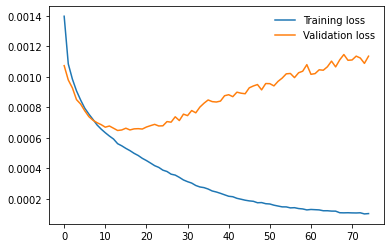

In [33]:
plt.plot(train_losses, label='Training loss')
plt.plot(test_losses, label='Validation loss')
plt.legend(frameon=False)

In [165]:
torchModel.Bert.device

device(type='cuda', index=0)

In [166]:
torchModel(X_test[:25])

Forward Called


tensor([[-1.4626, -1.5387, -1.6581,  5.5220, -1.1519, -1.9339, -0.4945],
        [-2.4869, -2.2417, -0.1596,  5.9095, -0.8429, -2.5162, -0.1103],
        [-2.2634, -1.6346,  0.2437,  5.0969, -1.4610, -0.9196,  0.4518],
        [-1.4876, -2.0991, -1.3574,  5.9189, -0.3710, -3.3775, -0.0616],
        [-1.9867, -2.1058, -0.8074,  5.6330, -0.1044, -3.1820, -0.1562],
        [-2.2982, -2.8106, -0.7049,  5.6376, -0.9757, -1.1950, -0.0750],
        [-1.3132, -0.8251, -0.8038,  4.2634, -0.0722, -2.5963,  0.0976],
        [-1.7288, -1.0971, -0.2127,  5.4893, -1.3920, -1.5332,  0.2278],
        [-2.0425, -1.3268, -1.0715,  5.6121, -0.3769, -1.5521,  0.0577],
        [-1.2958, -1.1475, -0.4645,  3.3163, -0.1179, -1.1458, -0.0809],
        [-2.9055, -2.2610, -0.9447,  6.2404, -0.8267, -2.1755,  0.2848],
        [-2.0705, -1.8187, -1.2083,  5.5571, -0.0396, -2.7881,  0.2048],
        [-1.7872, -2.5268, -1.0414,  4.4269, -0.7507, -0.7875,  0.1495],
        [-2.2243, -2.2796, -0.6230,  5.6976, -1.015

In [36]:
Y_pred = []
targets = []
for X_batch, labels in mMiniBatcherTest.getBatchIterator():
  
        X_batch = torch.tensor(X_batch).to(device)
        output = torchModelLight.predict(X_batch)
        Y_pred.extend(output)
        targets.extend(labels)


In [37]:
Y_pred = np.array(Y_pred)
targets = np.array(targets)

In [38]:
#Y_pred = torchModel.predict(X_test[200:300])
Y_pred

array([6, 2, 6, ..., 6, 2, 6], dtype=int64)

In [39]:
#targets = Y_test[200:300]
targets

array([6, 6, 4, ..., 6, 2, 6], dtype=int64)

In [80]:
testId = 21
print(Y_test[testId])
print(X_test.iloc[testId])

6
000000. kund ringer in, har råkat dubbelköpa en biljett i appen. xxxx biljett-id: pj0wpwz. gör ett återköp av den ena biljetten. kund får återköpskvitto.


In [40]:
accuracy = np.mean(Y_pred == targets)
print(f'Accuracy: {accuracy}')

Accuracy: 0.8919642857142858


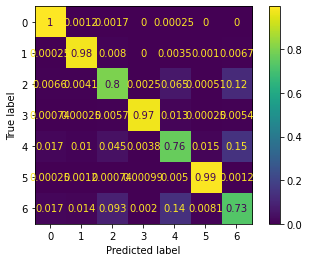

In [42]:
cm = confusion_matrix(targets, Y_pred, normalize='true', labels=list(set(targets)))
ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(set(targets))).plot()

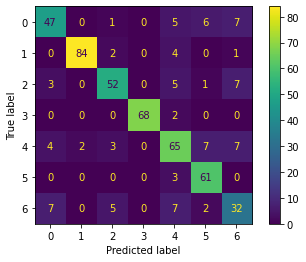

In [62]:
cm = confusion_matrix(targets, Y_pred, normalize=None, labels=list(set(Y_test)))
ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(set(Y_test))).plot()

In [43]:
torch.save(torchModelLight, 'torchModel_conv_batch_norm.pth')

In [33]:
for param_tensor in (torchModel.TorchModel.state_dict()):
    print(param_tensor, "\t", torchModel.TorchModel.state_dict()[param_tensor].size())

0.weight 	 torch.Size([256, 768])
0.bias 	 torch.Size([256])
3.weight 	 torch.Size([128, 256])
3.bias 	 torch.Size([128])
6.weight 	 torch.Size([7, 128])
6.bias 	 torch.Size([7])


In [44]:
torch.save(torchModelLight.TorchModel.state_dict(),'torchModel_conv_batch_norm_state_dict.pth')

In [21]:
torchModel =  torch.load('torchModel.pth', map_location=torch.device('cpu'))

In [14]:

n_classes = 7
torchModelLight = TorchNLPLight(n_classes)
torchModelLight.TorchModel.load_state_dict(torch.load('torchModel_conv_batch_norm_state_dict.pth', map_location=torch.device('cpu')))

<All keys matched successfully>

In [25]:
torchModel.eval()
torchModel.predict(X[:15])

array([5, 1, 5, 6, 4, 6, 5, 6, 6, 1, 6, 4, 4, 6, 2], dtype=int64)

In [24]:
Y[:15]

array([4, 6, 5, 4, 2, 6, 5, 4, 6, 4, 2, 6, 6, 6, 6], dtype=int64)

In [17]:
transformer = NLPTransformer()

Init called


Some weights of the model checkpoint at KB/bert-base-swedish-cased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [47]:
transformer.transform(testing)

Transform Called
Running batch 1/1
output shape: (1, 768)
transformed.shape: (1, 768)


array([[ 9.87884760e-01, -1.32418856e-01,  9.23658788e-01,
         9.53841284e-02,  5.00432737e-02, -1.74600735e-01,
        -6.13515228e-02, -8.26982021e-01, -8.38522017e-02,
        -9.93365169e-01,  6.42717481e-02, -3.05998195e-02,
         4.04555025e-03, -3.32312472e-02, -2.55960405e-01,
         8.80274400e-02,  2.30186395e-02,  1.60196766e-01,
         5.89367636e-02,  9.98809397e-01, -4.29829396e-02,
        -9.95216131e-01,  3.62579674e-02, -4.38297138e-04,
         2.73966137e-02, -8.72960865e-01,  7.15051591e-02,
        -9.36015248e-01,  2.12837279e-01, -9.79796946e-02,
        -4.70896997e-02, -7.83243418e-01, -9.90428030e-01,
         4.68692094e-01, -2.34113559e-01,  1.40514001e-01,
         1.79409549e-01,  3.13502923e-02, -7.68147185e-02,
        -5.33504598e-02,  1.49713665e-01,  8.09488297e-01,
        -1.73246086e-01, -8.50201309e-01,  9.99719203e-01,
        -1.37132853e-01,  9.39538836e-01,  7.69650459e-01,
         1.41458228e-01, -1.47941232e-01, -6.37947395e-0

In [54]:
next(torchModelLight.parameters()).is_cuda#torchModelLight.TorchModel.parameters

True

In [13]:
def MakePredictions(X, model, transformer, classes = None):
    
    #Check model device
    #modelOnCuda = next(torchModelLight.parameters()).is_cuda
    
    #Make sure both model and inputs are on the same device
    cuda_enabled = torch.cuda.is_available()
    if cuda_enabled:
        device = torch.device('cuda')
    else:
        device = torch.device('cpu')
    
    model.to(device)
    
    
    X = transformer.transform(X) #Output is numpy array
    X = torch.tensor(X).to(device)
    output = model.predict(X)
    
    if classes is not None:
        output = [classes[i] for i in output]
    
    return output
    

In [15]:
classes = ['Avvikelse', 'Beröm', 'Fråga', 'Förseningsersättning', 'Klagomål',
       'Skada', 'Synpunkt/Önskemål']

In [21]:
testing = pd.Series(data={'Beskrivning_Anonymized':'Kommer busstationen vid Vellinge ängar att städas utvändigt inför vintern? Väldigt smutsigt, mycket spindelnät och dylikt. Riktning Malmö'})
MakePredictions(testing, torchModelLight, transformer, classes)

Transform Called
Running batch 1/1
output shape: (1, 768)
transformed.shape: (1, 768)


['Klagomål']

In [65]:
classes

['Avvikelse',
 'Beröm',
 'Fråga',
 'Förseningsersättning',
 'Klagomål',
 'Skada',
 'Synpunkt/Önskemål']

In [42]:
#Evaluate loaded model on full dataset
mMiniBatcherFull = MiniBatcher(X[:50000], Y[:50000], batch_size=100)

In [ ]:
Y_pred = []
targets = []
for X_batch, labels in mMiniBatcherFull.getBatchIterator():
  
        output = torchModel.predict(X_batch)
        Y_pred.extend(output)
        targets.extend(labels)
        print(mMiniBatcherFull.getBatchInfo())

batch: 1/500
batch: 2/500
batch: 3/500
batch: 4/500
batch: 5/500
batch: 6/500
batch: 7/500
batch: 8/500
batch: 9/500
batch: 10/500
batch: 11/500
batch: 12/500
batch: 13/500
batch: 14/500
batch: 15/500
batch: 16/500
batch: 17/500
batch: 18/500
batch: 19/500
batch: 20/500
batch: 21/500
batch: 22/500
batch: 23/500
batch: 24/500
batch: 25/500
batch: 26/500
batch: 27/500
batch: 28/500


In [ ]:
accuracy = np.mean(Y_pred == targets)
print(f'Accuracy: {accuracy}')

In [ ]:
cm = confusion_matrix(targets, Y_pred, normalize='true', labels=list(set(Y_test)))
ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(set(Y_test))).plot()

In [ ]:
cm = confusion_matrix(targets, Y_pred, normalize=None, labels=list(set(Y_test)))
ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(set(Y_test))).plot()

In [44]:

list(range(Y_test.columns.shape[0]))

[0, 1, 2, 3, 4, 5, 6]

In [11]:
#New light model with two targets here
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [12]:
#This is the slim version where the BERT features is already provided as input
#This will also have two outputs, one for the class, and one for the sentiment. -1 is bad to +1 is best
class TorchNLPLight2(nn.Module):
    def __init__(self, n_classes, n_sentiment_classes):
        super().__init__()
        #print('Init called')
        self.n_classes = n_classes
        self.TorchModelBase = nn.Sequential(nn.Conv1d(1, 256, 3, stride=1, padding='same'),
                          nn.Flatten(),
                          nn.BatchNorm1d(256*768),              
                          nn.ReLU(),
                          nn.Dropout(p=0.42),
                          nn.Linear(256*768, 1024),
                          nn.BatchNorm1d(1024),              
                          nn.ReLU(),
                          nn.Dropout(p=0.42),
                          nn.Linear(1024, 512),
                          nn.BatchNorm1d(512),
                          nn.ReLU(),
                          nn.Dropout(p=0.42))
                          
        
        self.Classifier = nn.Sequential(nn.Linear(512, 256),
                          nn.BatchNorm1d(256),
                          nn.ReLU(),
                          nn.Dropout(p=0.42),            
                          nn.Linear(256, n_classes)) #Output for the Classifier head
                        
        self.Sentiment =  nn.Sequential(nn.Linear(512, 256),
                          nn.BatchNorm1d(256),
                          nn.ReLU(),
                          nn.Dropout(p=0.42),            
                          nn.Linear(256, n_sentiment_classes))
                          #nn.Tanh()) #Output for Sentiment head
                          
        
    def forward(self, X):
        #print('Forward Called')
        X = X.reshape(X.shape[0], 1, X.shape[1]) #Reshape for Conv1d
        X = self.TorchModelBase(X)
        X1 = self.Classifier(X)
        X2 = self.Sentiment(X)
        
        return X1, X2

    
    def predict(self, X):
        with torch.no_grad():
            self.eval()
            output, sentiment = self.forward(X)
            #print(f'X.shape: {X.shape}')
            #print(f'output.shape: {output.shape}')
            top_p, top_class = output.topk(1, dim=1)
            top_class = top_class.to('cpu').numpy().reshape(-1,)
            
            top_p_sentiment, sentiment_class = sentiment.topk(1, dim=1)
            sentiment_class = sentiment_class.to('cpu').numpy().reshape(-1,)
            
            
            self.train()
            return top_class, sentiment_class

In [13]:
class MiniBatcher2():
    def __init__(self, X, Y, Y2, batch_size=200):
        self.X = X
        self.Y = Y
        self.Y2 = Y2
        self.batch_size = batch_size
        self.batchId = 0     
        
    def getBatchIterator(self):
        self.batchId = 0
        self.epochId = 0
        
        while True:
            X_mini = self.X[self.batchId * self.batch_size:(self.batchId + 1) * self.batch_size]
            Y_mini = self.Y[self.batchId * self.batch_size:(self.batchId + 1) * self.batch_size]
            Y2_mini = self.Y2[self.batchId * self.batch_size:(self.batchId + 1) * self.batch_size]
            self.batchId += 1

            if len(X_mini) < self.batch_size:               
                self.batchId = 0
                break
            
            yield X_mini, Y_mini, Y2_mini
            
    def getBatchInfo(self):
        return f'batch: {self.batchId}/{int(np.ceil(self.X.shape[0] / self.batch_size))}'

In [14]:
n_classes = Y.max() + 1 #0-6
n_sentiment_classes = Y2_classes.max() + 1 #0-6
torchModelLight2 = TorchNLPLight2(n_classes=n_classes, n_sentiment_classes=n_sentiment_classes)
torchModelLight2.to(device)

TorchNLPLight2(
  (TorchModelBase): Sequential(
    (0): Conv1d(1, 256, kernel_size=(3,), stride=(1,), padding=same)
    (1): Flatten(start_dim=1, end_dim=-1)
    (2): BatchNorm1d(196608, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): ReLU()
    (4): Dropout(p=0.42, inplace=False)
    (5): Linear(in_features=196608, out_features=1024, bias=True)
    (6): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): ReLU()
    (8): Dropout(p=0.42, inplace=False)
    (9): Linear(in_features=1024, out_features=512, bias=True)
    (10): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU()
    (12): Dropout(p=0.42, inplace=False)
  )
  (Classifier): Sequential(
    (0): Linear(in_features=512, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.42, inplace=False)
    (4): Linear(in_features

In [15]:
#X_light2_train, X_light2_test, Y_light2_train, Y_light2_test, Y2_light2_train, Y2_light2_test = train_test_split(X_transformed, Y, Y2, test_size=0.2, random_state=42)
X_light2_train, X_light2_test, Y_light2_train, Y_light2_test, Y2_light2_train, Y2_light2_test = train_test_split(X_transformed, Y, Y2_classes, test_size=0.2, random_state=42)

In [16]:
#since the data is highly unbalanced, we need to resample it 
class_weights_sentiment = class_weight.compute_class_weight('balanced',np.unique(Y2_light2_train),Y2_light2_train)
class_weights_sentiment = torch.tensor(class_weights_sentiment,dtype=torch.float).to(device)

In [17]:
class_weights_sentiment

tensor([1.0953e+00, 5.7266e+00, 2.2521e-01, 2.8546e+00, 8.2816e+00, 1.1429e+03,
        9.9994e-01], device='cuda:0')

(array([1.4608e+04, 2.7940e+03, 0.0000e+00, 7.1046e+04, 0.0000e+00,
        5.6050e+03, 1.9320e+03, 0.0000e+00, 1.4000e+01, 1.6001e+04]),
 array([0. , 0.6, 1.2, 1.8, 2.4, 3. , 3.6, 4.2, 4.8, 5.4, 6. ]),
 <BarContainer object of 10 artists>)

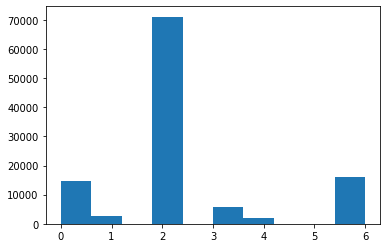

In [18]:
plt.hist(Y2_light2_train)

In [19]:
for ost in torchModelLight2.parameters():
    print(ost.shape)

torch.Size([256, 1, 3])
torch.Size([256])
torch.Size([196608])
torch.Size([196608])
torch.Size([1024, 196608])
torch.Size([1024])
torch.Size([1024])
torch.Size([1024])
torch.Size([512, 1024])
torch.Size([512])
torch.Size([512])
torch.Size([512])
torch.Size([256, 512])
torch.Size([256])
torch.Size([256])
torch.Size([256])
torch.Size([7, 256])
torch.Size([7])
torch.Size([256, 512])
torch.Size([256])
torch.Size([256])
torch.Size([256])
torch.Size([7, 256])
torch.Size([7])


In [20]:
optimizer = optim.Adam(torchModelLight2.parameters(), lr=0.001)
mMiniBatcherTrain2 = MiniBatcher2(X_light2_train, Y_light2_train, Y2_light2_train, batch_size=100)
mMiniBatcherTest2 = MiniBatcher2(X_light2_test, Y_light2_test, Y2_light2_test, batch_size=100)
train_losses, test_losses = [], []
train_losses_sentiment, test_losses_sentiment = [], []
criterion = nn.CrossEntropyLoss()
#criterionSentiment = nn.MSELoss()
criterionSentiment = nn.CrossEntropyLoss(weight=class_weights_sentiment)

In [21]:
#Train LIGHT2 network

epochs = 15
steps = 0
sentimentLossFactor = 1.5 #Extra penalty for sentiment loss

for e in range(epochs):
    running_loss = 0
    running_loss_sentiment = 0
    print(f'Running epoch {e+1}/{epochs}')
    for inputs, labels, sentimentTargets in mMiniBatcherTrain2.getBatchIterator():
        #print('Training batch...')
        optimizer.zero_grad()
 
        #print(f'labels.shape: {labels.shape}')
        inputs = torch.from_numpy(inputs).type(torch.FloatTensor).to(device)
        labels = torch.from_numpy(labels).to(device)        
        sentimentTargets = torch.from_numpy(sentimentTargets).to(device)
        
        #print('Running torch')
        output, sentiment = torchModelLight2(inputs)
        
        #print(f'output.shape: {output.shape}')
        #print('Calculating loss')
        
        #Loss for classifier
        loss = criterion(output, labels)
        lossSentiment = sentimentLossFactor*criterionSentiment(sentiment, sentimentTargets)
        
        #print('Back prop.')
        lossTotal = loss + lossSentiment
        #lossTotal = lossSentiment #DEBUG test only predicting the sentiment
        #lossTotal = loss
        #loss.backward()
        #lossSentiment.backward()
        lossTotal.backward()
        optimizer.step()
        batch_loss = loss.item()
        batch_loss_sentiment = lossSentiment.item()
        print(f'Batch loss: {batch_loss} Sentiment loss: {batch_loss_sentiment} {mMiniBatcherTrain2.getBatchInfo()}')
        running_loss += batch_loss
        running_loss_sentiment += batch_loss_sentiment
        
        del labels
        del inputs
        del output
        gc.collect()
        torch.cuda.empty_cache() 
   
    test_loss = 0
    accuracy = 0
    test_loss_sentiment = 0
    accuracy_sentiment = 0

    print('Running evaluation loop...')
    # Turn off gradients for validation, saves memory and computations
    with torch.no_grad():
        torchModelLight2.eval()
        for inputs, labels, sentimentTargets in mMiniBatcherTest2.getBatchIterator():
            #print('Validation batch...')

            inputs = torch.from_numpy(inputs).type(torch.FloatTensor).to(device)
            labels = torch.from_numpy(labels).to(device)        
            sentimentTargets = torch.from_numpy(sentimentTargets).to(device)
        
            output, sentiment = torchModelLight2(inputs)
            
            
            test_loss += criterion(output, labels).to('cpu') #Want the loss on CPU
            test_loss_sentiment += sentimentLossFactor*criterionSentiment(sentiment, sentimentTargets).to('cpu') #Want the loss on CPU

            top_p, top_class = output.topk(1, dim=1)
            #print(top_p)
            #top_p_target, top_class_target = labels.topk(1, dim=1)
            #equals = top_class == top_class_target
            equals = top_class == labels.view(top_class.shape)
            accuracy += torch.sum(equals.type(torch.FloatTensor)).to('cpu')
            print(mMiniBatcherTest2.getBatchInfo())
            
            
            top_p, top_class = sentiment.topk(1, dim=1)
         
            equals = top_class == sentimentTargets.view(top_class.shape)
            accuracy_sentiment += torch.sum(equals.type(torch.FloatTensor)).to('cpu')
            print(mMiniBatcherTest2.getBatchInfo())
            
            del labels
            del inputs
            del output
            gc.collect()
            torch.cuda.empty_cache() 

    torchModelLight2.train()

    train_losses.append(running_loss/len(mMiniBatcherTrain2.X))
    test_losses.append(test_loss/len(mMiniBatcherTest2.X))
    train_losses_sentiment.append(running_loss_sentiment/len(mMiniBatcherTrain2.X))
    test_losses_sentiment.append(test_loss_sentiment/len(mMiniBatcherTrain2.X))

    print("Epoch: {}/{}.. ".format(e+1, epochs),
          "Training Loss: {:.5f}.. ".format(train_losses[-1]),
          "Training Loss Sentiment: {:.5f}.. ".format(train_losses_sentiment[-1]),
          "Test Loss: {:.5f}.. ".format(test_losses[-1]),
          "Test Loss Sentiment: {:.5f}.. ".format(test_losses_sentiment[-1]),
          "Test Accuracy: {:.5f}".format(accuracy/len(mMiniBatcherTest2.X)),
          "Test Accuracy Sentiment: {:.5f}".format(accuracy_sentiment/len(mMiniBatcherTest2.X)))


Running epoch 1/15
Batch loss: 2.1180641651153564 Sentiment loss: 3.0095934867858887 batch: 1/1120
Batch loss: 1.8238310813903809 Sentiment loss: 2.789257049560547 batch: 2/1120
Batch loss: 1.6788254976272583 Sentiment loss: 2.52164888381958 batch: 3/1120
Batch loss: 1.5656216144561768 Sentiment loss: 3.0578505992889404 batch: 4/1120
Batch loss: 1.4859427213668823 Sentiment loss: 2.838789939880371 batch: 5/1120
Batch loss: 1.430638313293457 Sentiment loss: 2.5500540733337402 batch: 6/1120
Batch loss: 1.4383643865585327 Sentiment loss: 2.4767203330993652 batch: 7/1120
Batch loss: 1.2836397886276245 Sentiment loss: 2.1453335285186768 batch: 8/1120
Batch loss: 1.2950739860534668 Sentiment loss: 2.0005626678466797 batch: 9/1120
Batch loss: 1.2554363012313843 Sentiment loss: 2.145634651184082 batch: 10/1120
Batch loss: 1.2205840349197388 Sentiment loss: 2.4602019786834717 batch: 11/1120
Batch loss: 1.199907660484314 Sentiment loss: 1.9532835483551025 batch: 12/1120
Batch loss: 1.18441128730

Batch loss: 1.0102747678756714 Sentiment loss: 1.8008333444595337 batch: 105/1120
Batch loss: 0.9668442606925964 Sentiment loss: 1.455993890762329 batch: 106/1120
Batch loss: 0.694721519947052 Sentiment loss: 0.9265937805175781 batch: 107/1120
Batch loss: 0.7988439202308655 Sentiment loss: 1.6241815090179443 batch: 108/1120
Batch loss: 0.9246450662612915 Sentiment loss: 1.6700174808502197 batch: 109/1120
Batch loss: 0.9452427625656128 Sentiment loss: 1.545151948928833 batch: 110/1120
Batch loss: 0.7933197021484375 Sentiment loss: 1.5995031595230103 batch: 111/1120
Batch loss: 0.9396030306816101 Sentiment loss: 1.6437969207763672 batch: 112/1120
Batch loss: 0.7578489184379578 Sentiment loss: 1.5727620124816895 batch: 113/1120
Batch loss: 1.0218853950500488 Sentiment loss: 1.8240469694137573 batch: 114/1120
Batch loss: 0.7774055600166321 Sentiment loss: 2.1074986457824707 batch: 115/1120
Batch loss: 0.780997097492218 Sentiment loss: 1.5325672626495361 batch: 116/1120
Batch loss: 0.897565

Batch loss: 0.6757346987724304 Sentiment loss: 1.1418123245239258 batch: 207/1120
Batch loss: 0.7652736902236938 Sentiment loss: 1.519054651260376 batch: 208/1120
Batch loss: 0.6903332471847534 Sentiment loss: 1.438413381576538 batch: 209/1120
Batch loss: 0.9884703159332275 Sentiment loss: 1.6819326877593994 batch: 210/1120
Batch loss: 0.8352193236351013 Sentiment loss: 2.1715173721313477 batch: 211/1120
Batch loss: 0.6702412962913513 Sentiment loss: 0.9959698915481567 batch: 212/1120
Batch loss: 0.6781662702560425 Sentiment loss: 1.294516682624817 batch: 213/1120
Batch loss: 0.7540795207023621 Sentiment loss: 1.5479412078857422 batch: 214/1120
Batch loss: 0.7096515893936157 Sentiment loss: 1.2827744483947754 batch: 215/1120
Batch loss: 0.8962900638580322 Sentiment loss: 1.5545692443847656 batch: 216/1120
Batch loss: 0.8538164496421814 Sentiment loss: 1.2801907062530518 batch: 217/1120
Batch loss: 0.702034592628479 Sentiment loss: 1.1504853963851929 batch: 218/1120
Batch loss: 0.853999

Batch loss: 0.9133779406547546 Sentiment loss: 1.296759843826294 batch: 310/1120
Batch loss: 0.6070385575294495 Sentiment loss: 0.889021635055542 batch: 311/1120
Batch loss: 0.6888418793678284 Sentiment loss: 1.15155827999115 batch: 312/1120
Batch loss: 0.8455454111099243 Sentiment loss: 1.245106816291809 batch: 313/1120
Batch loss: 0.6483825445175171 Sentiment loss: 1.4676151275634766 batch: 314/1120
Batch loss: 0.606694757938385 Sentiment loss: 1.008117437362671 batch: 315/1120
Batch loss: 0.7140021324157715 Sentiment loss: 1.3365051746368408 batch: 316/1120
Batch loss: 0.7601763010025024 Sentiment loss: 1.2567659616470337 batch: 317/1120
Batch loss: 0.8759345412254333 Sentiment loss: 1.290839433670044 batch: 318/1120
Batch loss: 0.7966327667236328 Sentiment loss: 0.9415342211723328 batch: 319/1120
Batch loss: 0.6594173312187195 Sentiment loss: 1.4987080097198486 batch: 320/1120
Batch loss: 0.771755576133728 Sentiment loss: 1.3471167087554932 batch: 321/1120
Batch loss: 0.66232377290

Batch loss: 0.633613109588623 Sentiment loss: 1.545964241027832 batch: 413/1120
Batch loss: 0.6296932697296143 Sentiment loss: 1.6519906520843506 batch: 414/1120
Batch loss: 0.6454614996910095 Sentiment loss: 1.0348689556121826 batch: 415/1120
Batch loss: 0.5717790722846985 Sentiment loss: 1.5358257293701172 batch: 416/1120
Batch loss: 0.6981706023216248 Sentiment loss: 1.4877729415893555 batch: 417/1120
Batch loss: 0.6336947083473206 Sentiment loss: 1.0894806385040283 batch: 418/1120
Batch loss: 0.5810573101043701 Sentiment loss: 0.8445398807525635 batch: 419/1120
Batch loss: 0.7666487693786621 Sentiment loss: 1.2159209251403809 batch: 420/1120
Batch loss: 0.6039297580718994 Sentiment loss: 0.835047721862793 batch: 421/1120
Batch loss: 0.6398580074310303 Sentiment loss: 1.4011608362197876 batch: 422/1120
Batch loss: 0.9314572215080261 Sentiment loss: 1.5540207624435425 batch: 423/1120
Batch loss: 0.5077629685401917 Sentiment loss: 1.7437981367111206 batch: 424/1120
Batch loss: 0.62120

Batch loss: 0.6307116150856018 Sentiment loss: 1.1935219764709473 batch: 514/1120
Batch loss: 0.6675606369972229 Sentiment loss: 1.3155301809310913 batch: 515/1120
Batch loss: 0.5733684301376343 Sentiment loss: 1.1704603433609009 batch: 516/1120
Batch loss: 0.6820787787437439 Sentiment loss: 1.130252718925476 batch: 517/1120
Batch loss: 0.5686255097389221 Sentiment loss: 1.3682812452316284 batch: 518/1120
Batch loss: 0.7302125692367554 Sentiment loss: 1.1932536363601685 batch: 519/1120
Batch loss: 0.6596150398254395 Sentiment loss: 1.6340750455856323 batch: 520/1120
Batch loss: 0.737410306930542 Sentiment loss: 1.750469446182251 batch: 521/1120
Batch loss: 0.5083536505699158 Sentiment loss: 0.9300615191459656 batch: 522/1120
Batch loss: 0.7081124782562256 Sentiment loss: 1.235824465751648 batch: 523/1120
Batch loss: 0.5968616008758545 Sentiment loss: 0.9419817924499512 batch: 524/1120
Batch loss: 0.74627685546875 Sentiment loss: 1.282331943511963 batch: 525/1120
Batch loss: 0.714031219

Batch loss: 0.5213738083839417 Sentiment loss: 1.1646993160247803 batch: 616/1120
Batch loss: 0.5616294741630554 Sentiment loss: 1.2062513828277588 batch: 617/1120
Batch loss: 0.5640703439712524 Sentiment loss: 1.1317293643951416 batch: 618/1120
Batch loss: 0.5500484108924866 Sentiment loss: 1.1797233819961548 batch: 619/1120
Batch loss: 0.5373685359954834 Sentiment loss: 1.133315086364746 batch: 620/1120
Batch loss: 0.718160092830658 Sentiment loss: 1.248128056526184 batch: 621/1120
Batch loss: 0.7109118700027466 Sentiment loss: 1.6988074779510498 batch: 622/1120
Batch loss: 0.7553586363792419 Sentiment loss: 1.1354494094848633 batch: 623/1120
Batch loss: 0.7337107062339783 Sentiment loss: 1.566192865371704 batch: 624/1120
Batch loss: 0.5399620532989502 Sentiment loss: 0.8362593650817871 batch: 625/1120
Batch loss: 0.6809749603271484 Sentiment loss: 0.904032289981842 batch: 626/1120
Batch loss: 0.8465524911880493 Sentiment loss: 1.2288728952407837 batch: 627/1120
Batch loss: 0.7583534

Batch loss: 0.8394858837127686 Sentiment loss: 1.2064310312271118 batch: 719/1120
Batch loss: 0.8898957967758179 Sentiment loss: 1.4464823007583618 batch: 720/1120
Batch loss: 0.6712158918380737 Sentiment loss: 1.2266842126846313 batch: 721/1120
Batch loss: 0.5700199604034424 Sentiment loss: 1.1829853057861328 batch: 722/1120
Batch loss: 0.7229326367378235 Sentiment loss: 1.10883367061615 batch: 723/1120
Batch loss: 0.5388402342796326 Sentiment loss: 1.223769187927246 batch: 724/1120
Batch loss: 0.6550157070159912 Sentiment loss: 1.21061110496521 batch: 725/1120
Batch loss: 0.6549828052520752 Sentiment loss: 1.6051084995269775 batch: 726/1120
Batch loss: 0.7344989776611328 Sentiment loss: 1.4628050327301025 batch: 727/1120
Batch loss: 0.7737974524497986 Sentiment loss: 1.018573522567749 batch: 728/1120
Batch loss: 0.579723596572876 Sentiment loss: 0.9391117095947266 batch: 729/1120
Batch loss: 0.6175181865692139 Sentiment loss: 1.166237711906433 batch: 730/1120
Batch loss: 0.5695173144

Batch loss: 0.7949284911155701 Sentiment loss: 1.0490281581878662 batch: 821/1120
Batch loss: 0.6145549416542053 Sentiment loss: 1.1412068605422974 batch: 822/1120
Batch loss: 0.6240699291229248 Sentiment loss: 1.1766819953918457 batch: 823/1120
Batch loss: 0.8341585397720337 Sentiment loss: 1.3357346057891846 batch: 824/1120
Batch loss: 0.5900568962097168 Sentiment loss: 1.1985517740249634 batch: 825/1120
Batch loss: 0.5970422625541687 Sentiment loss: 1.2451417446136475 batch: 826/1120
Batch loss: 0.5197017788887024 Sentiment loss: 1.2186503410339355 batch: 827/1120
Batch loss: 0.6205854415893555 Sentiment loss: 1.095588207244873 batch: 828/1120
Batch loss: 0.687976598739624 Sentiment loss: 1.024714469909668 batch: 829/1120
Batch loss: 0.47289806604385376 Sentiment loss: 1.1736341714859009 batch: 830/1120
Batch loss: 0.7537215352058411 Sentiment loss: 1.288034439086914 batch: 831/1120
Batch loss: 0.7526662349700928 Sentiment loss: 1.0361263751983643 batch: 832/1120
Batch loss: 0.55767

Batch loss: 0.6104893684387207 Sentiment loss: 0.6215782761573792 batch: 922/1120
Batch loss: 0.6494712829589844 Sentiment loss: 1.0659430027008057 batch: 923/1120
Batch loss: 0.6279672980308533 Sentiment loss: 1.1013929843902588 batch: 924/1120
Batch loss: 0.5790718197822571 Sentiment loss: 1.0438084602355957 batch: 925/1120
Batch loss: 0.6992313861846924 Sentiment loss: 1.4296483993530273 batch: 926/1120
Batch loss: 0.586362361907959 Sentiment loss: 1.4089438915252686 batch: 927/1120
Batch loss: 0.7271273136138916 Sentiment loss: 1.1415834426879883 batch: 928/1120
Batch loss: 0.6021847724914551 Sentiment loss: 1.1390396356582642 batch: 929/1120
Batch loss: 0.510445237159729 Sentiment loss: 1.0171897411346436 batch: 930/1120
Batch loss: 0.507316529750824 Sentiment loss: 7.6106367111206055 batch: 931/1120
Batch loss: 0.47924748063087463 Sentiment loss: 1.309391975402832 batch: 932/1120
Batch loss: 0.5125929117202759 Sentiment loss: 1.2801241874694824 batch: 933/1120
Batch loss: 0.81602

Batch loss: 0.6006323099136353 Sentiment loss: 0.9689884185791016 batch: 1024/1120
Batch loss: 0.4734972417354584 Sentiment loss: 1.1378898620605469 batch: 1025/1120
Batch loss: 0.7902981638908386 Sentiment loss: 1.707708477973938 batch: 1026/1120
Batch loss: 0.7885938286781311 Sentiment loss: 1.1877248287200928 batch: 1027/1120
Batch loss: 0.7561440467834473 Sentiment loss: 1.3447757959365845 batch: 1028/1120
Batch loss: 0.6242012977600098 Sentiment loss: 1.1558387279510498 batch: 1029/1120
Batch loss: 0.6653876304626465 Sentiment loss: 1.468674659729004 batch: 1030/1120
Batch loss: 0.6381783485412598 Sentiment loss: 1.6339648962020874 batch: 1031/1120
Batch loss: 0.5835390090942383 Sentiment loss: 0.997653603553772 batch: 1032/1120
Batch loss: 0.5681607723236084 Sentiment loss: 1.013756513595581 batch: 1033/1120
Batch loss: 0.5690438151359558 Sentiment loss: 0.9851207733154297 batch: 1034/1120
Batch loss: 0.6721595525741577 Sentiment loss: 0.8748909831047058 batch: 1035/1120
Batch lo

batch: 7/280
batch: 7/280
batch: 8/280
batch: 8/280
batch: 9/280
batch: 9/280
batch: 10/280
batch: 10/280
batch: 11/280
batch: 11/280
batch: 12/280
batch: 12/280
batch: 13/280
batch: 13/280
batch: 14/280
batch: 14/280
batch: 15/280
batch: 15/280
batch: 16/280
batch: 16/280
batch: 17/280
batch: 17/280
batch: 18/280
batch: 18/280
batch: 19/280
batch: 19/280
batch: 20/280
batch: 20/280
batch: 21/280
batch: 21/280
batch: 22/280
batch: 22/280
batch: 23/280
batch: 23/280
batch: 24/280
batch: 24/280
batch: 25/280
batch: 25/280
batch: 26/280
batch: 26/280
batch: 27/280
batch: 27/280
batch: 28/280
batch: 28/280
batch: 29/280
batch: 29/280
batch: 30/280
batch: 30/280
batch: 31/280
batch: 31/280
batch: 32/280
batch: 32/280
batch: 33/280
batch: 33/280
batch: 34/280
batch: 34/280
batch: 35/280
batch: 35/280
batch: 36/280
batch: 36/280
batch: 37/280
batch: 37/280
batch: 38/280
batch: 38/280
batch: 39/280
batch: 39/280
batch: 40/280
batch: 40/280
batch: 41/280
batch: 41/280
batch: 42/280
batch: 42/28

Batch loss: 0.6287714242935181 Sentiment loss: 1.6495091915130615 batch: 1/1120
Batch loss: 0.7017528414726257 Sentiment loss: 0.8771301507949829 batch: 2/1120
Batch loss: 0.704744815826416 Sentiment loss: 1.1593868732452393 batch: 3/1120
Batch loss: 0.5227786302566528 Sentiment loss: 0.9468239545822144 batch: 4/1120
Batch loss: 0.6665707230567932 Sentiment loss: 1.1059643030166626 batch: 5/1120
Batch loss: 0.5441889762878418 Sentiment loss: 1.537139892578125 batch: 6/1120
Batch loss: 0.6038501858711243 Sentiment loss: 0.8615514039993286 batch: 7/1120
Batch loss: 0.6073611378669739 Sentiment loss: 1.1949009895324707 batch: 8/1120
Batch loss: 0.5791833996772766 Sentiment loss: 0.9423788785934448 batch: 9/1120
Batch loss: 0.6063321232795715 Sentiment loss: 1.2913774251937866 batch: 10/1120
Batch loss: 0.6798847913742065 Sentiment loss: 0.8925250768661499 batch: 11/1120
Batch loss: 0.5700035095214844 Sentiment loss: 0.7365334033966064 batch: 12/1120
Batch loss: 0.7268866896629333 Sentimen

Batch loss: 0.5040783882141113 Sentiment loss: 1.3586803674697876 batch: 103/1120
Batch loss: 0.5939533114433289 Sentiment loss: 0.9167468547821045 batch: 104/1120
Batch loss: 0.6074913144111633 Sentiment loss: 1.2139551639556885 batch: 105/1120
Batch loss: 0.7871243953704834 Sentiment loss: 0.8138487339019775 batch: 106/1120
Batch loss: 0.43660110235214233 Sentiment loss: 0.8218265771865845 batch: 107/1120
Batch loss: 0.5241098403930664 Sentiment loss: 0.9781821966171265 batch: 108/1120
Batch loss: 0.6647167205810547 Sentiment loss: 1.5128509998321533 batch: 109/1120
Batch loss: 0.7599462270736694 Sentiment loss: 1.037567377090454 batch: 110/1120
Batch loss: 0.5743476152420044 Sentiment loss: 1.411862850189209 batch: 111/1120
Batch loss: 0.7419047355651855 Sentiment loss: 1.2505799531936646 batch: 112/1120
Batch loss: 0.5362822413444519 Sentiment loss: 1.0693050622940063 batch: 113/1120
Batch loss: 0.8371827602386475 Sentiment loss: 1.2849128246307373 batch: 114/1120
Batch loss: 0.696

Batch loss: 0.6030198931694031 Sentiment loss: 0.9720309972763062 batch: 205/1120
Batch loss: 0.7218577861785889 Sentiment loss: 1.0933550596237183 batch: 206/1120
Batch loss: 0.5603713393211365 Sentiment loss: 0.959381639957428 batch: 207/1120
Batch loss: 0.61711186170578 Sentiment loss: 1.2639362812042236 batch: 208/1120
Batch loss: 0.5683413743972778 Sentiment loss: 1.4603086709976196 batch: 209/1120
Batch loss: 0.8848933577537537 Sentiment loss: 1.3952559232711792 batch: 210/1120
Batch loss: 0.6822267174720764 Sentiment loss: 1.3884018659591675 batch: 211/1120
Batch loss: 0.5239259600639343 Sentiment loss: 0.7029361128807068 batch: 212/1120
Batch loss: 0.5744410157203674 Sentiment loss: 0.7737692594528198 batch: 213/1120
Batch loss: 0.5562112331390381 Sentiment loss: 1.0828654766082764 batch: 214/1120
Batch loss: 0.5715997219085693 Sentiment loss: 0.7884860038757324 batch: 215/1120
Batch loss: 0.7121179699897766 Sentiment loss: 1.2977726459503174 batch: 216/1120
Batch loss: 0.67958

Batch loss: 0.6109912395477295 Sentiment loss: 1.2426183223724365 batch: 307/1120
Batch loss: 0.5327646136283875 Sentiment loss: 1.1050937175750732 batch: 308/1120
Batch loss: 0.6441148519515991 Sentiment loss: 1.0094201564788818 batch: 309/1120
Batch loss: 0.736998438835144 Sentiment loss: 1.1054575443267822 batch: 310/1120
Batch loss: 0.476693332195282 Sentiment loss: 0.741224467754364 batch: 311/1120
Batch loss: 0.6024127006530762 Sentiment loss: 1.2238152027130127 batch: 312/1120
Batch loss: 0.7507776021957397 Sentiment loss: 1.0741462707519531 batch: 313/1120
Batch loss: 0.5735945105552673 Sentiment loss: 1.2699737548828125 batch: 314/1120
Batch loss: 0.4523681402206421 Sentiment loss: 0.7704241275787354 batch: 315/1120
Batch loss: 0.5913333296775818 Sentiment loss: 0.9451984167098999 batch: 316/1120
Batch loss: 0.6084563732147217 Sentiment loss: 1.0284348726272583 batch: 317/1120
Batch loss: 0.8062815070152283 Sentiment loss: 1.1808758974075317 batch: 318/1120
Batch loss: 0.54798

Batch loss: 0.7015120983123779 Sentiment loss: 0.8422791957855225 batch: 409/1120
Batch loss: 0.777332603931427 Sentiment loss: 0.942164421081543 batch: 410/1120
Batch loss: 0.6797384023666382 Sentiment loss: 0.7811559438705444 batch: 411/1120
Batch loss: 0.581390917301178 Sentiment loss: 1.730339527130127 batch: 412/1120
Batch loss: 0.5495687127113342 Sentiment loss: 1.0001046657562256 batch: 413/1120
Batch loss: 0.5663003325462341 Sentiment loss: 1.351180076599121 batch: 414/1120
Batch loss: 0.6053476333618164 Sentiment loss: 1.0134358406066895 batch: 415/1120
Batch loss: 0.43670058250427246 Sentiment loss: 1.188849687576294 batch: 416/1120
Batch loss: 0.6757516264915466 Sentiment loss: 1.2542130947113037 batch: 417/1120
Batch loss: 0.4903812110424042 Sentiment loss: 1.08830988407135 batch: 418/1120
Batch loss: 0.5347845554351807 Sentiment loss: 0.7031283378601074 batch: 419/1120
Batch loss: 0.761637270450592 Sentiment loss: 1.0489284992218018 batch: 420/1120
Batch loss: 0.5596801638

Batch loss: 0.6456811428070068 Sentiment loss: 1.0173335075378418 batch: 511/1120
Batch loss: 0.4892962574958801 Sentiment loss: 1.0253850221633911 batch: 512/1120
Batch loss: 0.8526444435119629 Sentiment loss: 1.601029872894287 batch: 513/1120
Batch loss: 0.520480751991272 Sentiment loss: 1.035894513130188 batch: 514/1120
Batch loss: 0.5889206528663635 Sentiment loss: 1.2722057104110718 batch: 515/1120
Batch loss: 0.5002573728561401 Sentiment loss: 0.9410803914070129 batch: 516/1120
Batch loss: 0.5415224432945251 Sentiment loss: 0.6010456085205078 batch: 517/1120
Batch loss: 0.5131646990776062 Sentiment loss: 0.9723373651504517 batch: 518/1120
Batch loss: 0.6360185742378235 Sentiment loss: 0.992382824420929 batch: 519/1120
Batch loss: 0.5926498174667358 Sentiment loss: 1.1997677087783813 batch: 520/1120
Batch loss: 0.6904520392417908 Sentiment loss: 1.3180848360061646 batch: 521/1120
Batch loss: 0.4477962553501129 Sentiment loss: 0.9449236392974854 batch: 522/1120
Batch loss: 0.604200

Batch loss: 0.5988304018974304 Sentiment loss: 1.0318050384521484 batch: 613/1120
Batch loss: 0.6290666460990906 Sentiment loss: 0.839118242263794 batch: 614/1120
Batch loss: 0.4378739595413208 Sentiment loss: 0.9823805093765259 batch: 615/1120
Batch loss: 0.4739151895046234 Sentiment loss: 0.8512650728225708 batch: 616/1120
Batch loss: 0.46514901518821716 Sentiment loss: 0.9389652013778687 batch: 617/1120
Batch loss: 0.508905827999115 Sentiment loss: 0.9931170344352722 batch: 618/1120
Batch loss: 0.47817814350128174 Sentiment loss: 1.085402488708496 batch: 619/1120
Batch loss: 0.4770137071609497 Sentiment loss: 0.9508389234542847 batch: 620/1120
Batch loss: 0.4759441018104553 Sentiment loss: 1.219380259513855 batch: 621/1120
Batch loss: 0.6392620801925659 Sentiment loss: 1.4699805974960327 batch: 622/1120
Batch loss: 0.6730716228485107 Sentiment loss: 0.8170589208602905 batch: 623/1120
Batch loss: 0.5926634073257446 Sentiment loss: 0.9599348902702332 batch: 624/1120
Batch loss: 0.3948

Batch loss: 0.6655957698822021 Sentiment loss: 1.345291256904602 batch: 714/1120
Batch loss: 0.8459094762802124 Sentiment loss: 1.2227370738983154 batch: 715/1120
Batch loss: 0.5915537476539612 Sentiment loss: 1.150828242301941 batch: 716/1120
Batch loss: 0.571291446685791 Sentiment loss: 0.7845094203948975 batch: 717/1120
Batch loss: 0.698051393032074 Sentiment loss: 1.2363379001617432 batch: 718/1120
Batch loss: 0.8055420517921448 Sentiment loss: 1.212151288986206 batch: 719/1120
Batch loss: 0.7924507856369019 Sentiment loss: 1.154899001121521 batch: 720/1120
Batch loss: 0.6741997599601746 Sentiment loss: 1.1086387634277344 batch: 721/1120
Batch loss: 0.486876904964447 Sentiment loss: 0.822224497795105 batch: 722/1120
Batch loss: 0.6177672743797302 Sentiment loss: 1.1445339918136597 batch: 723/1120
Batch loss: 0.4293651878833771 Sentiment loss: 1.3792378902435303 batch: 724/1120
Batch loss: 0.6436887383460999 Sentiment loss: 1.3287873268127441 batch: 725/1120
Batch loss: 0.6006616950

Batch loss: 0.6470164656639099 Sentiment loss: 0.5730632543563843 batch: 815/1120
Batch loss: 0.6879444718360901 Sentiment loss: 1.3449456691741943 batch: 816/1120
Batch loss: 0.6897857785224915 Sentiment loss: 1.1203681230545044 batch: 817/1120
Batch loss: 0.5717708468437195 Sentiment loss: 1.4835509061813354 batch: 818/1120
Batch loss: 0.6603744029998779 Sentiment loss: 1.3258894681930542 batch: 819/1120
Batch loss: 0.6040286421775818 Sentiment loss: 1.2887954711914062 batch: 820/1120
Batch loss: 0.746355414390564 Sentiment loss: 1.3565559387207031 batch: 821/1120
Batch loss: 0.5777291059494019 Sentiment loss: 1.400976300239563 batch: 822/1120
Batch loss: 0.6476613879203796 Sentiment loss: 1.251257300376892 batch: 823/1120
Batch loss: 0.7364948391914368 Sentiment loss: 1.3895885944366455 batch: 824/1120
Batch loss: 0.586527943611145 Sentiment loss: 1.2095972299575806 batch: 825/1120
Batch loss: 0.6057644486427307 Sentiment loss: 0.9614089727401733 batch: 826/1120
Batch loss: 0.520458

Batch loss: 0.6912912130355835 Sentiment loss: 0.9639590978622437 batch: 917/1120
Batch loss: 0.6480560302734375 Sentiment loss: 1.2988958358764648 batch: 918/1120
Batch loss: 0.5662900805473328 Sentiment loss: 0.946564793586731 batch: 919/1120
Batch loss: 0.9601320624351501 Sentiment loss: 1.1696709394454956 batch: 920/1120
Batch loss: 0.5211824774742126 Sentiment loss: 0.6408901214599609 batch: 921/1120
Batch loss: 0.5878974795341492 Sentiment loss: 0.5567700862884521 batch: 922/1120
Batch loss: 0.5134161114692688 Sentiment loss: 1.2602522373199463 batch: 923/1120
Batch loss: 0.6720350384712219 Sentiment loss: 1.0051240921020508 batch: 924/1120
Batch loss: 0.5489527583122253 Sentiment loss: 0.922926664352417 batch: 925/1120
Batch loss: 0.5806873440742493 Sentiment loss: 1.21775221824646 batch: 926/1120
Batch loss: 0.555255651473999 Sentiment loss: 1.3778847455978394 batch: 927/1120
Batch loss: 0.6899231672286987 Sentiment loss: 1.1064587831497192 batch: 928/1120
Batch loss: 0.5465973

Batch loss: 0.6529625654220581 Sentiment loss: 1.2814009189605713 batch: 1018/1120
Batch loss: 0.8370867967605591 Sentiment loss: 0.8557584285736084 batch: 1019/1120
Batch loss: 0.4221172034740448 Sentiment loss: 0.9442099332809448 batch: 1020/1120
Batch loss: 0.5177822709083557 Sentiment loss: 1.0320544242858887 batch: 1021/1120
Batch loss: 0.7123620510101318 Sentiment loss: 0.8288189172744751 batch: 1022/1120
Batch loss: 0.5938994884490967 Sentiment loss: 1.1638973951339722 batch: 1023/1120
Batch loss: 0.5514939427375793 Sentiment loss: 0.9012868404388428 batch: 1024/1120
Batch loss: 0.4243379533290863 Sentiment loss: 0.9165499806404114 batch: 1025/1120
Batch loss: 0.8147019147872925 Sentiment loss: 1.4541218280792236 batch: 1026/1120
Batch loss: 0.7845046520233154 Sentiment loss: 0.8810150027275085 batch: 1027/1120
Batch loss: 0.6404271721839905 Sentiment loss: 1.1034789085388184 batch: 1028/1120
Batch loss: 0.5775805711746216 Sentiment loss: 0.9124336838722229 batch: 1029/1120
Batc

Batch loss: 0.7370895147323608 Sentiment loss: 0.9947349429130554 batch: 1118/1120
Batch loss: 0.5698433518409729 Sentiment loss: 0.9434593319892883 batch: 1119/1120
Batch loss: 0.6137123107910156 Sentiment loss: 1.0122662782669067 batch: 1120/1120
Running evaluation loop...
batch: 1/280
batch: 1/280
batch: 2/280
batch: 2/280
batch: 3/280
batch: 3/280
batch: 4/280
batch: 4/280
batch: 5/280
batch: 5/280
batch: 6/280
batch: 6/280
batch: 7/280
batch: 7/280
batch: 8/280
batch: 8/280
batch: 9/280
batch: 9/280
batch: 10/280
batch: 10/280
batch: 11/280
batch: 11/280
batch: 12/280
batch: 12/280
batch: 13/280
batch: 13/280
batch: 14/280
batch: 14/280
batch: 15/280
batch: 15/280
batch: 16/280
batch: 16/280
batch: 17/280
batch: 17/280
batch: 18/280
batch: 18/280
batch: 19/280
batch: 19/280
batch: 20/280
batch: 20/280
batch: 21/280
batch: 21/280
batch: 22/280
batch: 22/280
batch: 23/280
batch: 23/280
batch: 24/280
batch: 24/280
batch: 25/280
batch: 25/280
batch: 26/280
batch: 26/280
batch: 27/280


batch: 273/280
batch: 273/280
batch: 274/280
batch: 274/280
batch: 275/280
batch: 275/280
batch: 276/280
batch: 276/280
batch: 277/280
batch: 277/280
batch: 278/280
batch: 278/280
batch: 279/280
batch: 279/280
batch: 280/280
batch: 280/280
Epoch: 2/15..  Training Loss: 0.00599..  Training Loss Sentiment: 0.01109..  Test Loss: 0.00526..  Test Loss Sentiment: 0.00246..  Test Accuracy: 0.80321 Test Accuracy Sentiment: 0.66961
Running epoch 3/15
Batch loss: 0.6097018718719482 Sentiment loss: 1.3535840511322021 batch: 1/1120
Batch loss: 0.7067301869392395 Sentiment loss: 0.685028612613678 batch: 2/1120
Batch loss: 0.6783199906349182 Sentiment loss: 1.1444544792175293 batch: 3/1120
Batch loss: 0.48021912574768066 Sentiment loss: 0.9660515785217285 batch: 4/1120
Batch loss: 0.6519669890403748 Sentiment loss: 0.8319883346557617 batch: 5/1120
Batch loss: 0.44438740611076355 Sentiment loss: 1.3649320602416992 batch: 6/1120
Batch loss: 0.5687292218208313 Sentiment loss: 0.7528178691864014 batch: 

Batch loss: 0.6265324950218201 Sentiment loss: 0.6917794346809387 batch: 97/1120
Batch loss: 0.4675886929035187 Sentiment loss: 0.6914272904396057 batch: 98/1120
Batch loss: 0.6043172478675842 Sentiment loss: 0.7516860961914062 batch: 99/1120
Batch loss: 0.4892662763595581 Sentiment loss: 0.9114372730255127 batch: 100/1120
Batch loss: 0.5851215124130249 Sentiment loss: 0.6028206944465637 batch: 101/1120
Batch loss: 0.6731355786323547 Sentiment loss: 0.8530767560005188 batch: 102/1120
Batch loss: 0.46150410175323486 Sentiment loss: 1.2135783433914185 batch: 103/1120
Batch loss: 0.6270847916603088 Sentiment loss: 0.8814854621887207 batch: 104/1120
Batch loss: 0.554760217666626 Sentiment loss: 1.0257413387298584 batch: 105/1120
Batch loss: 0.7203405499458313 Sentiment loss: 0.7118290662765503 batch: 106/1120
Batch loss: 0.3661046624183655 Sentiment loss: 0.8274419903755188 batch: 107/1120
Batch loss: 0.5982551574707031 Sentiment loss: 0.8705320358276367 batch: 108/1120
Batch loss: 0.61554

Batch loss: 0.6338895559310913 Sentiment loss: 0.9870408773422241 batch: 198/1120
Batch loss: 0.609351396560669 Sentiment loss: 0.9992110133171082 batch: 199/1120
Batch loss: 0.4648413062095642 Sentiment loss: 1.177619457244873 batch: 200/1120
Batch loss: 0.788547694683075 Sentiment loss: 1.018201231956482 batch: 201/1120
Batch loss: 0.6056125164031982 Sentiment loss: 1.1592503786087036 batch: 202/1120
Batch loss: 0.47432610392570496 Sentiment loss: 0.7221337556838989 batch: 203/1120
Batch loss: 0.6369219422340393 Sentiment loss: 0.9608534574508667 batch: 204/1120
Batch loss: 0.5405877232551575 Sentiment loss: 0.9812144637107849 batch: 205/1120
Batch loss: 0.7603572010993958 Sentiment loss: 0.9446866512298584 batch: 206/1120
Batch loss: 0.5384030938148499 Sentiment loss: 0.9839774966239929 batch: 207/1120
Batch loss: 0.6585721373558044 Sentiment loss: 1.231024146080017 batch: 208/1120
Batch loss: 0.5124730467796326 Sentiment loss: 1.0956884622573853 batch: 209/1120
Batch loss: 0.737289

Batch loss: 0.5081843733787537 Sentiment loss: 1.229346752166748 batch: 299/1120
Batch loss: 0.671865701675415 Sentiment loss: 0.7296907901763916 batch: 300/1120
Batch loss: 0.5812180042266846 Sentiment loss: 0.9788652658462524 batch: 301/1120
Batch loss: 0.5661841034889221 Sentiment loss: 1.0451884269714355 batch: 302/1120
Batch loss: 0.5461734533309937 Sentiment loss: 0.564355194568634 batch: 303/1120
Batch loss: 0.5182454586029053 Sentiment loss: 1.412765622138977 batch: 304/1120
Batch loss: 0.34583380818367004 Sentiment loss: 1.4436497688293457 batch: 305/1120
Batch loss: 0.5224711298942566 Sentiment loss: 0.6740844249725342 batch: 306/1120
Batch loss: 0.463394433259964 Sentiment loss: 0.9523415565490723 batch: 307/1120
Batch loss: 0.5169140100479126 Sentiment loss: 1.3290406465530396 batch: 308/1120
Batch loss: 0.5284085273742676 Sentiment loss: 0.7591636776924133 batch: 309/1120
Batch loss: 0.7294954061508179 Sentiment loss: 0.9059649109840393 batch: 310/1120
Batch loss: 0.364197

Batch loss: 0.4994787275791168 Sentiment loss: 0.14242222905158997 batch: 400/1120
Batch loss: 0.5312013030052185 Sentiment loss: 1.087308406829834 batch: 401/1120
Batch loss: 0.5967274904251099 Sentiment loss: 1.1586661338806152 batch: 402/1120
Batch loss: 0.4376381039619446 Sentiment loss: 0.9801945686340332 batch: 403/1120
Batch loss: 0.5919162631034851 Sentiment loss: 1.2202954292297363 batch: 404/1120
Batch loss: 0.5095990896224976 Sentiment loss: 0.601853609085083 batch: 405/1120
Batch loss: 0.5905117392539978 Sentiment loss: 1.071805477142334 batch: 406/1120
Batch loss: 0.6276620626449585 Sentiment loss: 1.230242371559143 batch: 407/1120
Batch loss: 0.5369661450386047 Sentiment loss: 0.5305184125900269 batch: 408/1120
Batch loss: 0.6823891401290894 Sentiment loss: 0.7454304695129395 batch: 409/1120
Batch loss: 0.6671643257141113 Sentiment loss: 0.866836667060852 batch: 410/1120
Batch loss: 0.5636268854141235 Sentiment loss: 0.7324893474578857 batch: 411/1120
Batch loss: 0.480422

Batch loss: 0.48471584916114807 Sentiment loss: 0.8588782548904419 batch: 502/1120
Batch loss: 0.5590997934341431 Sentiment loss: 0.5696898102760315 batch: 503/1120
Batch loss: 0.5329630970954895 Sentiment loss: 0.8898180723190308 batch: 504/1120
Batch loss: 0.4403826594352722 Sentiment loss: 0.7517352104187012 batch: 505/1120
Batch loss: 0.6243503093719482 Sentiment loss: 0.752255380153656 batch: 506/1120
Batch loss: 0.5573424696922302 Sentiment loss: 0.6482517719268799 batch: 507/1120
Batch loss: 0.6525074243545532 Sentiment loss: 0.9879689812660217 batch: 508/1120
Batch loss: 0.6433447003364563 Sentiment loss: 0.6373251676559448 batch: 509/1120
Batch loss: 0.40663060545921326 Sentiment loss: 0.7570099830627441 batch: 510/1120
Batch loss: 0.6167502999305725 Sentiment loss: 0.9056206941604614 batch: 511/1120
Batch loss: 0.4558568596839905 Sentiment loss: 0.9789866209030151 batch: 512/1120
Batch loss: 0.7008271813392639 Sentiment loss: 1.241389513015747 batch: 513/1120
Batch loss: 0.52

Batch loss: 0.49675801396369934 Sentiment loss: 1.137550711631775 batch: 603/1120
Batch loss: 0.6347389817237854 Sentiment loss: 1.046216607093811 batch: 604/1120
Batch loss: 0.43310755491256714 Sentiment loss: 0.671232283115387 batch: 605/1120
Batch loss: 0.5859076976776123 Sentiment loss: 0.8273847699165344 batch: 606/1120
Batch loss: 0.4896951913833618 Sentiment loss: 0.9912480115890503 batch: 607/1120
Batch loss: 0.5320567488670349 Sentiment loss: 0.9129852056503296 batch: 608/1120
Batch loss: 0.6170059442520142 Sentiment loss: 1.3075265884399414 batch: 609/1120
Batch loss: 0.4834015965461731 Sentiment loss: 0.6886115670204163 batch: 610/1120
Batch loss: 0.5293695330619812 Sentiment loss: 0.7500312924385071 batch: 611/1120
Batch loss: 0.6649385690689087 Sentiment loss: 1.295723557472229 batch: 612/1120
Batch loss: 0.5045113563537598 Sentiment loss: 0.9128302335739136 batch: 613/1120
Batch loss: 0.5799100995063782 Sentiment loss: 1.0855488777160645 batch: 614/1120
Batch loss: 0.3816

Batch loss: 0.6165504455566406 Sentiment loss: 1.2080423831939697 batch: 704/1120
Batch loss: 0.45772621035575867 Sentiment loss: 0.7425335049629211 batch: 705/1120
Batch loss: 0.5394961833953857 Sentiment loss: 1.4987202882766724 batch: 706/1120
Batch loss: 0.4016138017177582 Sentiment loss: 1.0547186136245728 batch: 707/1120
Batch loss: 0.4462331533432007 Sentiment loss: 0.8120618462562561 batch: 708/1120
Batch loss: 0.409612774848938 Sentiment loss: 0.8888270258903503 batch: 709/1120
Batch loss: 0.7755846977233887 Sentiment loss: 1.0641958713531494 batch: 710/1120
Batch loss: 0.5526766777038574 Sentiment loss: 1.1988900899887085 batch: 711/1120
Batch loss: 0.598385751247406 Sentiment loss: 0.7578058242797852 batch: 712/1120
Batch loss: 0.41928717494010925 Sentiment loss: 0.5123347640037537 batch: 713/1120
Batch loss: 0.6990424990653992 Sentiment loss: 1.2208478450775146 batch: 714/1120
Batch loss: 0.6654714941978455 Sentiment loss: 1.0803900957107544 batch: 715/1120
Batch loss: 0.61

Batch loss: 0.5546130537986755 Sentiment loss: 0.566933274269104 batch: 805/1120
Batch loss: 0.5307359099388123 Sentiment loss: 1.0531562566757202 batch: 806/1120
Batch loss: 0.6972963809967041 Sentiment loss: 1.5288559198379517 batch: 807/1120
Batch loss: 0.4644204080104828 Sentiment loss: 0.7352529764175415 batch: 808/1120
Batch loss: 0.6389835476875305 Sentiment loss: 0.08204130083322525 batch: 809/1120
Batch loss: 0.6415033936500549 Sentiment loss: 1.3046005964279175 batch: 810/1120
Batch loss: 0.44920557737350464 Sentiment loss: 0.7148431539535522 batch: 811/1120
Batch loss: 0.5944393277168274 Sentiment loss: 1.074586272239685 batch: 812/1120
Batch loss: 0.6520616412162781 Sentiment loss: 0.6451368927955627 batch: 813/1120
Batch loss: 0.5174505114555359 Sentiment loss: 1.0808305740356445 batch: 814/1120
Batch loss: 0.5762313008308411 Sentiment loss: 0.4947214722633362 batch: 815/1120
Batch loss: 0.6292870044708252 Sentiment loss: 0.7855993509292603 batch: 816/1120
Batch loss: 0.70

Batch loss: 0.42780640721321106 Sentiment loss: 0.681404709815979 batch: 908/1120
Batch loss: 0.4343188405036926 Sentiment loss: 0.5374923944473267 batch: 909/1120
Batch loss: 0.6294681429862976 Sentiment loss: 1.33224356174469 batch: 910/1120
Batch loss: 0.5783633589744568 Sentiment loss: 0.6219052076339722 batch: 911/1120
Batch loss: 0.7496438026428223 Sentiment loss: 1.1338940858840942 batch: 912/1120
Batch loss: 0.4842677414417267 Sentiment loss: 1.032690405845642 batch: 913/1120
Batch loss: 0.30824732780456543 Sentiment loss: 0.39992600679397583 batch: 914/1120
Batch loss: 0.49917590618133545 Sentiment loss: 0.5504285097122192 batch: 915/1120
Batch loss: 0.5330268144607544 Sentiment loss: 0.6309501528739929 batch: 916/1120
Batch loss: 0.6110848188400269 Sentiment loss: 1.1853207349777222 batch: 917/1120
Batch loss: 0.5904802083969116 Sentiment loss: 0.9371598958969116 batch: 918/1120
Batch loss: 0.5191581845283508 Sentiment loss: 0.6523698568344116 batch: 919/1120
Batch loss: 0.82

Batch loss: 0.6020022034645081 Sentiment loss: 5.580793380737305 batch: 1010/1120
Batch loss: 0.5615406036376953 Sentiment loss: 0.7679345011711121 batch: 1011/1120
Batch loss: 0.5183097720146179 Sentiment loss: 0.8322118520736694 batch: 1012/1120
Batch loss: 0.4780014157295227 Sentiment loss: 1.0938960313796997 batch: 1013/1120
Batch loss: 0.4913175106048584 Sentiment loss: 0.8268325924873352 batch: 1014/1120
Batch loss: 0.5915616154670715 Sentiment loss: 1.1126909255981445 batch: 1015/1120
Batch loss: 0.4466591775417328 Sentiment loss: 0.7225980758666992 batch: 1016/1120
Batch loss: 0.5885435938835144 Sentiment loss: 1.4980154037475586 batch: 1017/1120
Batch loss: 0.6623243689537048 Sentiment loss: 1.3463900089263916 batch: 1018/1120
Batch loss: 0.8148323893547058 Sentiment loss: 1.0764851570129395 batch: 1019/1120
Batch loss: 0.42358627915382385 Sentiment loss: 0.7020096182823181 batch: 1020/1120
Batch loss: 0.5276412963867188 Sentiment loss: 1.1701788902282715 batch: 1021/1120
Batc

Batch loss: 0.7239695191383362 Sentiment loss: 1.0542795658111572 batch: 1109/1120
Batch loss: 0.6062629818916321 Sentiment loss: 0.7999961376190186 batch: 1110/1120
Batch loss: 0.5659465193748474 Sentiment loss: 0.833918571472168 batch: 1111/1120
Batch loss: 0.6688286662101746 Sentiment loss: 0.7279660701751709 batch: 1112/1120
Batch loss: 0.6593009829521179 Sentiment loss: 1.1247566938400269 batch: 1113/1120
Batch loss: 0.5521703362464905 Sentiment loss: 0.9392539262771606 batch: 1114/1120
Batch loss: 0.47921085357666016 Sentiment loss: 0.8440290689468384 batch: 1115/1120
Batch loss: 0.5002895593643188 Sentiment loss: 0.8295412063598633 batch: 1116/1120
Batch loss: 0.5465810894966125 Sentiment loss: 0.945557713508606 batch: 1117/1120
Batch loss: 0.519645094871521 Sentiment loss: 0.9538881182670593 batch: 1118/1120
Batch loss: 0.4145585596561432 Sentiment loss: 0.7063080072402954 batch: 1119/1120
Batch loss: 0.6132286190986633 Sentiment loss: 0.9761629104614258 batch: 1120/1120
Runnin

batch: 251/280
batch: 251/280
batch: 252/280
batch: 252/280
batch: 253/280
batch: 253/280
batch: 254/280
batch: 254/280
batch: 255/280
batch: 255/280
batch: 256/280
batch: 256/280
batch: 257/280
batch: 257/280
batch: 258/280
batch: 258/280
batch: 259/280
batch: 259/280
batch: 260/280
batch: 260/280
batch: 261/280
batch: 261/280
batch: 262/280
batch: 262/280
batch: 263/280
batch: 263/280
batch: 264/280
batch: 264/280
batch: 265/280
batch: 265/280
batch: 266/280
batch: 266/280
batch: 267/280
batch: 267/280
batch: 268/280
batch: 268/280
batch: 269/280
batch: 269/280
batch: 270/280
batch: 270/280
batch: 271/280
batch: 271/280
batch: 272/280
batch: 272/280
batch: 273/280
batch: 273/280
batch: 274/280
batch: 274/280
batch: 275/280
batch: 275/280
batch: 276/280
batch: 276/280
batch: 277/280
batch: 277/280
batch: 278/280
batch: 278/280
batch: 279/280
batch: 279/280
batch: 280/280
batch: 280/280
Epoch: 3/15..  Training Loss: 0.00557..  Training Loss Sentiment: 0.00968..  Test Loss: 0.00495..  T

Batch loss: 0.4796091914176941 Sentiment loss: 0.6202138066291809 batch: 89/1120
Batch loss: 0.5526343584060669 Sentiment loss: 0.8553917407989502 batch: 90/1120
Batch loss: 0.6354470252990723 Sentiment loss: 0.6394732594490051 batch: 91/1120
Batch loss: 0.5482994318008423 Sentiment loss: 0.694401204586029 batch: 92/1120
Batch loss: 0.5164291858673096 Sentiment loss: 0.42124658823013306 batch: 93/1120
Batch loss: 0.5804951190948486 Sentiment loss: 1.219320297241211 batch: 94/1120
Batch loss: 0.7700642347335815 Sentiment loss: 0.9254769086837769 batch: 95/1120
Batch loss: 0.45625874400138855 Sentiment loss: 0.6410866975784302 batch: 96/1120
Batch loss: 0.5507401823997498 Sentiment loss: 0.621159553527832 batch: 97/1120
Batch loss: 0.3127593398094177 Sentiment loss: 0.7807693481445312 batch: 98/1120
Batch loss: 0.547546923160553 Sentiment loss: 0.6383470892906189 batch: 99/1120
Batch loss: 0.42220649123191833 Sentiment loss: 0.7335532307624817 batch: 100/1120
Batch loss: 0.44845160841941

Batch loss: 0.5558106303215027 Sentiment loss: 0.7376106381416321 batch: 190/1120
Batch loss: 0.7387352585792542 Sentiment loss: 1.0866082906723022 batch: 191/1120
Batch loss: 0.5745751261711121 Sentiment loss: 1.2169036865234375 batch: 192/1120
Batch loss: 0.4898185729980469 Sentiment loss: 1.8712502717971802 batch: 193/1120
Batch loss: 0.5504623651504517 Sentiment loss: 0.9853101968765259 batch: 194/1120
Batch loss: 0.6471788287162781 Sentiment loss: 0.8339032530784607 batch: 195/1120
Batch loss: 0.5349940657615662 Sentiment loss: 0.7838804721832275 batch: 196/1120
Batch loss: 0.5920308232307434 Sentiment loss: 0.8897923231124878 batch: 197/1120
Batch loss: 0.5753318071365356 Sentiment loss: 1.1713029146194458 batch: 198/1120
Batch loss: 0.5235495567321777 Sentiment loss: 1.010745644569397 batch: 199/1120
Batch loss: 0.4486275911331177 Sentiment loss: 0.8614088296890259 batch: 200/1120
Batch loss: 0.7323283553123474 Sentiment loss: 0.989115834236145 batch: 201/1120
Batch loss: 0.6038

Batch loss: 0.604138970375061 Sentiment loss: 0.9813597202301025 batch: 292/1120
Batch loss: 0.6342017650604248 Sentiment loss: 0.6967582702636719 batch: 293/1120
Batch loss: 0.49290716648101807 Sentiment loss: 0.6110925674438477 batch: 294/1120
Batch loss: 0.6396563053131104 Sentiment loss: 1.0429742336273193 batch: 295/1120
Batch loss: 0.4727984368801117 Sentiment loss: 0.8449991941452026 batch: 296/1120
Batch loss: 0.673841118812561 Sentiment loss: 0.8046900033950806 batch: 297/1120
Batch loss: 0.6442187428474426 Sentiment loss: 1.091719388961792 batch: 298/1120
Batch loss: 0.4739231765270233 Sentiment loss: 1.1008776426315308 batch: 299/1120
Batch loss: 0.5187476277351379 Sentiment loss: 0.5981183052062988 batch: 300/1120
Batch loss: 0.5881600379943848 Sentiment loss: 1.1783196926116943 batch: 301/1120
Batch loss: 0.545956552028656 Sentiment loss: 1.2935731410980225 batch: 302/1120
Batch loss: 0.5432485342025757 Sentiment loss: 0.46163952350616455 batch: 303/1120
Batch loss: 0.4533

Batch loss: 0.7639173269271851 Sentiment loss: 0.9902685284614563 batch: 393/1120
Batch loss: 0.5273693203926086 Sentiment loss: 0.643075704574585 batch: 394/1120
Batch loss: 0.6710517406463623 Sentiment loss: 0.5901294946670532 batch: 395/1120
Batch loss: 0.6199719905853271 Sentiment loss: 1.1071407794952393 batch: 396/1120
Batch loss: 0.4857816994190216 Sentiment loss: 0.8401459455490112 batch: 397/1120
Batch loss: 0.45192041993141174 Sentiment loss: 0.729395866394043 batch: 398/1120
Batch loss: 0.5487346649169922 Sentiment loss: 0.7715137004852295 batch: 399/1120
Batch loss: 0.48541224002838135 Sentiment loss: 0.09710226953029633 batch: 400/1120
Batch loss: 0.5976933240890503 Sentiment loss: 1.3433843851089478 batch: 401/1120
Batch loss: 0.6101694107055664 Sentiment loss: 0.850482165813446 batch: 402/1120
Batch loss: 0.4932146966457367 Sentiment loss: 0.7666767239570618 batch: 403/1120
Batch loss: 0.6065006852149963 Sentiment loss: 0.9880340099334717 batch: 404/1120
Batch loss: 0.47

Batch loss: 0.652869462966919 Sentiment loss: 0.9258540868759155 batch: 494/1120
Batch loss: 0.7199034094810486 Sentiment loss: 1.040732979774475 batch: 495/1120
Batch loss: 0.6131872534751892 Sentiment loss: 0.6462600827217102 batch: 496/1120
Batch loss: 0.4897420108318329 Sentiment loss: 1.2106587886810303 batch: 497/1120
Batch loss: 0.5201013684272766 Sentiment loss: 1.7060984373092651 batch: 498/1120
Batch loss: 0.7768966555595398 Sentiment loss: 1.1834075450897217 batch: 499/1120
Batch loss: 0.6557565331459045 Sentiment loss: 0.47444915771484375 batch: 500/1120
Batch loss: 0.6687420010566711 Sentiment loss: 0.8744685649871826 batch: 501/1120
Batch loss: 0.5087350010871887 Sentiment loss: 0.7802598476409912 batch: 502/1120
Batch loss: 0.5506410002708435 Sentiment loss: 0.7024663090705872 batch: 503/1120
Batch loss: 0.5246204137802124 Sentiment loss: 0.7790763974189758 batch: 504/1120
Batch loss: 0.3949422538280487 Sentiment loss: 0.6698371171951294 batch: 505/1120
Batch loss: 0.623

Batch loss: 0.6874424815177917 Sentiment loss: 1.098603367805481 batch: 594/1120
Batch loss: 0.5117961168289185 Sentiment loss: 0.8195434212684631 batch: 595/1120
Batch loss: 0.7467755675315857 Sentiment loss: 1.292378544807434 batch: 596/1120
Batch loss: 0.4226441979408264 Sentiment loss: 0.883181095123291 batch: 597/1120
Batch loss: 0.5173142552375793 Sentiment loss: 1.1828911304473877 batch: 598/1120
Batch loss: 0.5237111449241638 Sentiment loss: 0.6286710500717163 batch: 599/1120
Batch loss: 0.5515251755714417 Sentiment loss: 0.7441115379333496 batch: 600/1120
Batch loss: 0.456201434135437 Sentiment loss: 0.7799774408340454 batch: 601/1120
Batch loss: 0.4440377950668335 Sentiment loss: 0.8390130996704102 batch: 602/1120
Batch loss: 0.5325128436088562 Sentiment loss: 0.8189855813980103 batch: 603/1120
Batch loss: 0.6665859222412109 Sentiment loss: 1.1728646755218506 batch: 604/1120
Batch loss: 0.3407343029975891 Sentiment loss: 0.6347705721855164 batch: 605/1120
Batch loss: 0.487297

Batch loss: 0.49162447452545166 Sentiment loss: 0.8280653357505798 batch: 694/1120
Batch loss: 0.6647096276283264 Sentiment loss: 0.998592734336853 batch: 695/1120
Batch loss: 0.7586078643798828 Sentiment loss: 0.46299514174461365 batch: 696/1120
Batch loss: 0.43188178539276123 Sentiment loss: 0.9569715261459351 batch: 697/1120
Batch loss: 0.5746370553970337 Sentiment loss: 0.7628098726272583 batch: 698/1120
Batch loss: 0.5216507911682129 Sentiment loss: 0.9087612628936768 batch: 699/1120
Batch loss: 0.54025799036026 Sentiment loss: 0.4910205006599426 batch: 700/1120
Batch loss: 0.4992471933364868 Sentiment loss: 0.8048585653305054 batch: 701/1120
Batch loss: 0.386058509349823 Sentiment loss: 1.113600492477417 batch: 702/1120
Batch loss: 0.4901960492134094 Sentiment loss: 0.8844891786575317 batch: 703/1120
Batch loss: 0.6127411127090454 Sentiment loss: 0.9223359823226929 batch: 704/1120
Batch loss: 0.49431079626083374 Sentiment loss: 0.617708146572113 batch: 705/1120
Batch loss: 0.5316

Batch loss: 0.6065723299980164 Sentiment loss: 1.2174437046051025 batch: 796/1120
Batch loss: 0.4965934753417969 Sentiment loss: 1.2508721351623535 batch: 797/1120
Batch loss: 0.5863267779350281 Sentiment loss: 1.4602006673812866 batch: 798/1120
Batch loss: 0.4743494689464569 Sentiment loss: 0.8592811822891235 batch: 799/1120
Batch loss: 0.4530021548271179 Sentiment loss: 0.6753697395324707 batch: 800/1120
Batch loss: 0.5956733226776123 Sentiment loss: 0.8666567802429199 batch: 801/1120
Batch loss: 0.41212138533592224 Sentiment loss: 0.7475540041923523 batch: 802/1120
Batch loss: 0.6448774933815002 Sentiment loss: 0.7618224620819092 batch: 803/1120
Batch loss: 0.4981558322906494 Sentiment loss: 0.743361234664917 batch: 804/1120
Batch loss: 0.5943067669868469 Sentiment loss: 0.6573716402053833 batch: 805/1120
Batch loss: 0.6024487018585205 Sentiment loss: 1.0336077213287354 batch: 806/1120
Batch loss: 0.6731755137443542 Sentiment loss: 1.0980143547058105 batch: 807/1120
Batch loss: 0.34

Batch loss: 0.6163625717163086 Sentiment loss: 0.9191464185714722 batch: 898/1120
Batch loss: 0.3898119032382965 Sentiment loss: 0.6130929589271545 batch: 899/1120
Batch loss: 0.5451896786689758 Sentiment loss: 0.9276832938194275 batch: 900/1120
Batch loss: 0.6237140893936157 Sentiment loss: 0.8472453355789185 batch: 901/1120
Batch loss: 0.46187061071395874 Sentiment loss: 0.6209219694137573 batch: 902/1120
Batch loss: 0.3898322284221649 Sentiment loss: 0.693975031375885 batch: 903/1120
Batch loss: 0.5059594511985779 Sentiment loss: 0.4730547070503235 batch: 904/1120
Batch loss: 0.5091569423675537 Sentiment loss: 5.834691524505615 batch: 905/1120
Batch loss: 0.6114176511764526 Sentiment loss: 0.8101882338523865 batch: 906/1120
Batch loss: 0.5897801518440247 Sentiment loss: 0.5895787477493286 batch: 907/1120
Batch loss: 0.4320843815803528 Sentiment loss: 0.731667697429657 batch: 908/1120
Batch loss: 0.39532792568206787 Sentiment loss: 0.7256360054016113 batch: 909/1120
Batch loss: 0.651

Batch loss: 0.44302231073379517 Sentiment loss: 0.9598597288131714 batch: 1000/1120
Batch loss: 0.3594842255115509 Sentiment loss: 1.0637199878692627 batch: 1001/1120
Batch loss: 0.5696362257003784 Sentiment loss: 0.921064019203186 batch: 1002/1120
Batch loss: 0.666069507598877 Sentiment loss: 1.2317436933517456 batch: 1003/1120
Batch loss: 0.46096184849739075 Sentiment loss: 0.6510977745056152 batch: 1004/1120
Batch loss: 0.6894329190254211 Sentiment loss: 1.102783203125 batch: 1005/1120
Batch loss: 0.5823772549629211 Sentiment loss: 0.7537484169006348 batch: 1006/1120
Batch loss: 0.6105186939239502 Sentiment loss: 0.8088092803955078 batch: 1007/1120
Batch loss: 0.41661688685417175 Sentiment loss: 0.6331897377967834 batch: 1008/1120
Batch loss: 0.43388140201568604 Sentiment loss: 0.880962610244751 batch: 1009/1120
Batch loss: 0.5425019860267639 Sentiment loss: 0.2947006821632385 batch: 1010/1120
Batch loss: 0.5079678297042847 Sentiment loss: 0.6467301845550537 batch: 1011/1120
Batch l

Batch loss: 0.5378730893135071 Sentiment loss: 0.5108033418655396 batch: 1099/1120
Batch loss: 0.6287937760353088 Sentiment loss: 1.0858343839645386 batch: 1100/1120
Batch loss: 0.6168816089630127 Sentiment loss: 0.804314911365509 batch: 1101/1120
Batch loss: 0.6882545351982117 Sentiment loss: 10.42568302154541 batch: 1102/1120
Batch loss: 0.5211132168769836 Sentiment loss: 0.7934398651123047 batch: 1103/1120
Batch loss: 0.3790368139743805 Sentiment loss: 0.6908397674560547 batch: 1104/1120
Batch loss: 0.7935019135475159 Sentiment loss: 0.6946307420730591 batch: 1105/1120
Batch loss: 0.5689840912818909 Sentiment loss: 0.8496184349060059 batch: 1106/1120
Batch loss: 0.7216922640800476 Sentiment loss: 0.9951823949813843 batch: 1107/1120
Batch loss: 0.32847705483436584 Sentiment loss: 1.0805147886276245 batch: 1108/1120
Batch loss: 0.6744967699050903 Sentiment loss: 0.8933143615722656 batch: 1109/1120
Batch loss: 0.5901089310646057 Sentiment loss: 0.7777940034866333 batch: 1110/1120
Batch

batch: 222/280
batch: 222/280
batch: 223/280
batch: 223/280
batch: 224/280
batch: 224/280
batch: 225/280
batch: 225/280
batch: 226/280
batch: 226/280
batch: 227/280
batch: 227/280
batch: 228/280
batch: 228/280
batch: 229/280
batch: 229/280
batch: 230/280
batch: 230/280
batch: 231/280
batch: 231/280
batch: 232/280
batch: 232/280
batch: 233/280
batch: 233/280
batch: 234/280
batch: 234/280
batch: 235/280
batch: 235/280
batch: 236/280
batch: 236/280
batch: 237/280
batch: 237/280
batch: 238/280
batch: 238/280
batch: 239/280
batch: 239/280
batch: 240/280
batch: 240/280
batch: 241/280
batch: 241/280
batch: 242/280
batch: 242/280
batch: 243/280
batch: 243/280
batch: 244/280
batch: 244/280
batch: 245/280
batch: 245/280
batch: 246/280
batch: 246/280
batch: 247/280
batch: 247/280
batch: 248/280
batch: 248/280
batch: 249/280
batch: 249/280
batch: 250/280
batch: 250/280
batch: 251/280
batch: 251/280
batch: 252/280
batch: 252/280
batch: 253/280
batch: 253/280
batch: 254/280
batch: 254/280
batch: 255

Batch loss: 0.4274856448173523 Sentiment loss: 1.379765272140503 batch: 80/1120
Batch loss: 0.6003900766372681 Sentiment loss: 0.7730668783187866 batch: 81/1120
Batch loss: 0.6240015029907227 Sentiment loss: 1.1947873830795288 batch: 82/1120
Batch loss: 0.5789101123809814 Sentiment loss: 0.7753456830978394 batch: 83/1120
Batch loss: 0.6516932845115662 Sentiment loss: 0.6992875933647156 batch: 84/1120
Batch loss: 0.535506010055542 Sentiment loss: 1.1374797821044922 batch: 85/1120
Batch loss: 0.5427130460739136 Sentiment loss: 0.911992073059082 batch: 86/1120
Batch loss: 0.5383199453353882 Sentiment loss: 0.6372780799865723 batch: 87/1120
Batch loss: 0.6365954279899597 Sentiment loss: 0.5863651633262634 batch: 88/1120
Batch loss: 0.5336227416992188 Sentiment loss: 0.9406086206436157 batch: 89/1120
Batch loss: 0.5196826457977295 Sentiment loss: 0.7216602563858032 batch: 90/1120
Batch loss: 0.5809865593910217 Sentiment loss: 0.9856125116348267 batch: 91/1120
Batch loss: 0.5394760966300964 

Batch loss: 0.5820732116699219 Sentiment loss: 0.8773003220558167 batch: 182/1120
Batch loss: 0.4473133981227875 Sentiment loss: 1.4576973915100098 batch: 183/1120
Batch loss: 0.4674561321735382 Sentiment loss: 0.927398681640625 batch: 184/1120
Batch loss: 0.519763171672821 Sentiment loss: 0.8056917786598206 batch: 185/1120
Batch loss: 0.5520793795585632 Sentiment loss: 0.8165956735610962 batch: 186/1120
Batch loss: 0.4612703025341034 Sentiment loss: 0.7339022159576416 batch: 187/1120
Batch loss: 0.6049870252609253 Sentiment loss: 1.550396203994751 batch: 188/1120
Batch loss: 0.44041427969932556 Sentiment loss: 0.9366495609283447 batch: 189/1120
Batch loss: 0.515215277671814 Sentiment loss: 0.6965959668159485 batch: 190/1120
Batch loss: 0.7331482768058777 Sentiment loss: 1.1384927034378052 batch: 191/1120
Batch loss: 0.5725448131561279 Sentiment loss: 0.8103302717208862 batch: 192/1120
Batch loss: 0.4818613827228546 Sentiment loss: 1.690281629562378 batch: 193/1120
Batch loss: 0.590091

Batch loss: 0.6457908749580383 Sentiment loss: 0.5395597815513611 batch: 283/1120
Batch loss: 0.391867995262146 Sentiment loss: 0.8893022537231445 batch: 284/1120
Batch loss: 0.4079415500164032 Sentiment loss: 0.39814770221710205 batch: 285/1120
Batch loss: 0.4342024326324463 Sentiment loss: 0.6052910685539246 batch: 286/1120
Batch loss: 0.4290767014026642 Sentiment loss: 0.5316870212554932 batch: 287/1120
Batch loss: 0.44697079062461853 Sentiment loss: 0.8209491968154907 batch: 288/1120
Batch loss: 0.39804312586784363 Sentiment loss: 0.521738588809967 batch: 289/1120
Batch loss: 0.6555159687995911 Sentiment loss: 0.7802169322967529 batch: 290/1120
Batch loss: 0.48742011189460754 Sentiment loss: 0.4319087862968445 batch: 291/1120
Batch loss: 0.4744773209095001 Sentiment loss: 0.9096267223358154 batch: 292/1120
Batch loss: 0.6629776954650879 Sentiment loss: 0.9210330247879028 batch: 293/1120
Batch loss: 0.47905880212783813 Sentiment loss: 0.5457228422164917 batch: 294/1120
Batch loss: 0

Batch loss: 0.5347223877906799 Sentiment loss: 0.8100334405899048 batch: 383/1120
Batch loss: 0.5008985996246338 Sentiment loss: 0.6098580956459045 batch: 384/1120
Batch loss: 0.5102637410163879 Sentiment loss: 0.8250609636306763 batch: 385/1120
Batch loss: 0.5105341076850891 Sentiment loss: 3.194183349609375 batch: 386/1120
Batch loss: 0.3676948845386505 Sentiment loss: 0.7882317304611206 batch: 387/1120
Batch loss: 0.5625258088111877 Sentiment loss: 1.066986322402954 batch: 388/1120
Batch loss: 0.6814929842948914 Sentiment loss: 1.1358721256256104 batch: 389/1120
Batch loss: 0.5959551930427551 Sentiment loss: 0.6194666028022766 batch: 390/1120
Batch loss: 0.4657723307609558 Sentiment loss: 1.011300802230835 batch: 391/1120
Batch loss: 0.47475436329841614 Sentiment loss: 0.822647213935852 batch: 392/1120
Batch loss: 0.6326225996017456 Sentiment loss: 0.7718762755393982 batch: 393/1120
Batch loss: 0.49250996112823486 Sentiment loss: 0.576409101486206 batch: 394/1120
Batch loss: 0.59172

Batch loss: 0.510982871055603 Sentiment loss: 0.6349273324012756 batch: 484/1120
Batch loss: 0.4864289462566376 Sentiment loss: 1.3093068599700928 batch: 485/1120
Batch loss: 0.47050556540489197 Sentiment loss: 0.7226095199584961 batch: 486/1120
Batch loss: 0.5045429468154907 Sentiment loss: 0.5900548100471497 batch: 487/1120
Batch loss: 0.699917733669281 Sentiment loss: 1.2246887683868408 batch: 488/1120
Batch loss: 0.5029754638671875 Sentiment loss: 0.4421725869178772 batch: 489/1120
Batch loss: 0.5311444401741028 Sentiment loss: 0.6385269165039062 batch: 490/1120
Batch loss: 0.42828768491744995 Sentiment loss: 0.5534407496452332 batch: 491/1120
Batch loss: 0.4610951542854309 Sentiment loss: 1.0195744037628174 batch: 492/1120
Batch loss: 0.619525134563446 Sentiment loss: 0.4974149465560913 batch: 493/1120
Batch loss: 0.6958400011062622 Sentiment loss: 0.8060647249221802 batch: 494/1120
Batch loss: 0.6506157517433167 Sentiment loss: 0.7546395063400269 batch: 495/1120
Batch loss: 0.608

Batch loss: 0.613572895526886 Sentiment loss: 1.1143542528152466 batch: 584/1120
Batch loss: 0.5339130759239197 Sentiment loss: 0.674811840057373 batch: 585/1120
Batch loss: 0.4156590700149536 Sentiment loss: 0.8180578947067261 batch: 586/1120
Batch loss: 0.6156253218650818 Sentiment loss: 1.4031169414520264 batch: 587/1120
Batch loss: 0.5891451835632324 Sentiment loss: 0.6608610153198242 batch: 588/1120
Batch loss: 0.5039128661155701 Sentiment loss: 0.8227639198303223 batch: 589/1120
Batch loss: 0.4535394310951233 Sentiment loss: 1.0026313066482544 batch: 590/1120
Batch loss: 0.27085649967193604 Sentiment loss: 0.5100704431533813 batch: 591/1120
Batch loss: 0.49419349431991577 Sentiment loss: 0.7365787625312805 batch: 592/1120
Batch loss: 0.46293842792510986 Sentiment loss: 0.8442461490631104 batch: 593/1120
Batch loss: 0.5297239422798157 Sentiment loss: 1.0600426197052002 batch: 594/1120
Batch loss: 0.5084878206253052 Sentiment loss: 0.7567883729934692 batch: 595/1120
Batch loss: 0.6

Batch loss: 0.4295212924480438 Sentiment loss: 0.809444785118103 batch: 685/1120
Batch loss: 0.536954402923584 Sentiment loss: 0.0737554058432579 batch: 686/1120
Batch loss: 0.4699007272720337 Sentiment loss: 0.5464178919792175 batch: 687/1120
Batch loss: 0.6105988025665283 Sentiment loss: 0.8560794591903687 batch: 688/1120
Batch loss: 0.5448154807090759 Sentiment loss: 0.8465310335159302 batch: 689/1120
Batch loss: 0.6259533166885376 Sentiment loss: 0.9264492988586426 batch: 690/1120
Batch loss: 0.558800220489502 Sentiment loss: 1.359679937362671 batch: 691/1120
Batch loss: 0.3774452209472656 Sentiment loss: 0.8267157077789307 batch: 692/1120
Batch loss: 0.6458723545074463 Sentiment loss: 0.8713979721069336 batch: 693/1120
Batch loss: 0.4710227847099304 Sentiment loss: 0.7440999746322632 batch: 694/1120
Batch loss: 0.5744642019271851 Sentiment loss: 0.793253481388092 batch: 695/1120
Batch loss: 0.6535313129425049 Sentiment loss: 0.4706302881240845 batch: 696/1120
Batch loss: 0.3928210

Batch loss: 0.5750612616539001 Sentiment loss: 0.6355477571487427 batch: 786/1120
Batch loss: 0.36135581135749817 Sentiment loss: 0.43097031116485596 batch: 787/1120
Batch loss: 0.525540828704834 Sentiment loss: 0.503375768661499 batch: 788/1120
Batch loss: 0.4367178976535797 Sentiment loss: 0.7230031490325928 batch: 789/1120
Batch loss: 0.5220687389373779 Sentiment loss: 0.9244840145111084 batch: 790/1120
Batch loss: 0.3449896275997162 Sentiment loss: 0.5244801044464111 batch: 791/1120
Batch loss: 0.42142435908317566 Sentiment loss: 0.9496006965637207 batch: 792/1120
Batch loss: 0.4096640646457672 Sentiment loss: 0.4990657567977905 batch: 793/1120
Batch loss: 0.6585790514945984 Sentiment loss: 0.5794194340705872 batch: 794/1120
Batch loss: 0.43923959136009216 Sentiment loss: 7.746790885925293 batch: 795/1120
Batch loss: 0.5533163547515869 Sentiment loss: 0.9448926448822021 batch: 796/1120
Batch loss: 0.46809253096580505 Sentiment loss: 0.9642032384872437 batch: 797/1120
Batch loss: 0.

Batch loss: 0.6170357465744019 Sentiment loss: 0.7394176721572876 batch: 887/1120
Batch loss: 0.34648123383522034 Sentiment loss: 0.6721721291542053 batch: 888/1120
Batch loss: 0.5230568051338196 Sentiment loss: 0.7764153480529785 batch: 889/1120
Batch loss: 0.5282738208770752 Sentiment loss: 0.7982141971588135 batch: 890/1120
Batch loss: 0.5740507245063782 Sentiment loss: 0.6744491457939148 batch: 891/1120
Batch loss: 0.42442405223846436 Sentiment loss: 0.7928876280784607 batch: 892/1120
Batch loss: 0.47543004155158997 Sentiment loss: 0.7406522631645203 batch: 893/1120
Batch loss: 0.32158175110816956 Sentiment loss: 0.8213769197463989 batch: 894/1120
Batch loss: 0.5298244953155518 Sentiment loss: 0.8317238092422485 batch: 895/1120
Batch loss: 0.5709710121154785 Sentiment loss: 0.6015630960464478 batch: 896/1120
Batch loss: 0.5281095504760742 Sentiment loss: 0.6678773164749146 batch: 897/1120
Batch loss: 0.5731543898582458 Sentiment loss: 1.0578539371490479 batch: 898/1120
Batch loss: 

Batch loss: 0.3609800338745117 Sentiment loss: 1.1016602516174316 batch: 987/1120
Batch loss: 0.4363967180252075 Sentiment loss: 0.8044937252998352 batch: 988/1120
Batch loss: 0.498077929019928 Sentiment loss: 0.5687364339828491 batch: 989/1120
Batch loss: 0.46673357486724854 Sentiment loss: 0.8701956868171692 batch: 990/1120
Batch loss: 0.4880312979221344 Sentiment loss: 0.7511255741119385 batch: 991/1120
Batch loss: 0.4191729724407196 Sentiment loss: 0.6592718362808228 batch: 992/1120
Batch loss: 0.47725191712379456 Sentiment loss: 1.1190651655197144 batch: 993/1120
Batch loss: 0.5576910376548767 Sentiment loss: 0.5499073266983032 batch: 994/1120
Batch loss: 0.5055280923843384 Sentiment loss: 0.9714301824569702 batch: 995/1120
Batch loss: 0.47600114345550537 Sentiment loss: 0.7746416330337524 batch: 996/1120
Batch loss: 0.4993153512477875 Sentiment loss: 0.5655168294906616 batch: 997/1120
Batch loss: 0.42430874705314636 Sentiment loss: 0.5141257047653198 batch: 998/1120
Batch loss: 0

Batch loss: 0.48070231080055237 Sentiment loss: 0.6234384179115295 batch: 1086/1120
Batch loss: 0.4591321647167206 Sentiment loss: 0.5861532688140869 batch: 1087/1120
Batch loss: 0.48823392391204834 Sentiment loss: 1.2752635478973389 batch: 1088/1120
Batch loss: 0.45363548398017883 Sentiment loss: 0.7442349195480347 batch: 1089/1120
Batch loss: 0.4892607033252716 Sentiment loss: 0.749450147151947 batch: 1090/1120
Batch loss: 0.5090034604072571 Sentiment loss: 0.5855509042739868 batch: 1091/1120
Batch loss: 0.3664625287055969 Sentiment loss: 0.513744056224823 batch: 1092/1120
Batch loss: 0.6661756634712219 Sentiment loss: 0.8695657253265381 batch: 1093/1120
Batch loss: 0.5376666188240051 Sentiment loss: 0.9123574495315552 batch: 1094/1120
Batch loss: 0.5608344674110413 Sentiment loss: 1.4189327955245972 batch: 1095/1120
Batch loss: 0.5315520763397217 Sentiment loss: 1.111721158027649 batch: 1096/1120
Batch loss: 0.5192776918411255 Sentiment loss: 0.6800752878189087 batch: 1097/1120
Batc

batch: 184/280
batch: 185/280
batch: 185/280
batch: 186/280
batch: 186/280
batch: 187/280
batch: 187/280
batch: 188/280
batch: 188/280
batch: 189/280
batch: 189/280
batch: 190/280
batch: 190/280
batch: 191/280
batch: 191/280
batch: 192/280
batch: 192/280
batch: 193/280
batch: 193/280
batch: 194/280
batch: 194/280
batch: 195/280
batch: 195/280
batch: 196/280
batch: 196/280
batch: 197/280
batch: 197/280
batch: 198/280
batch: 198/280
batch: 199/280
batch: 199/280
batch: 200/280
batch: 200/280
batch: 201/280
batch: 201/280
batch: 202/280
batch: 202/280
batch: 203/280
batch: 203/280
batch: 204/280
batch: 204/280
batch: 205/280
batch: 205/280
batch: 206/280
batch: 206/280
batch: 207/280
batch: 207/280
batch: 208/280
batch: 208/280
batch: 209/280
batch: 209/280
batch: 210/280
batch: 210/280
batch: 211/280
batch: 211/280
batch: 212/280
batch: 212/280
batch: 213/280
batch: 213/280
batch: 214/280
batch: 214/280
batch: 215/280
batch: 215/280
batch: 216/280
batch: 216/280
batch: 217/280
batch: 217

Batch loss: 0.42874085903167725 Sentiment loss: 0.6074002981185913 batch: 66/1120
Batch loss: 0.46934035420417786 Sentiment loss: 0.3776611089706421 batch: 67/1120
Batch loss: 0.44071686267852783 Sentiment loss: 0.8102900981903076 batch: 68/1120
Batch loss: 0.5320743322372437 Sentiment loss: 0.6649216413497925 batch: 69/1120
Batch loss: 0.4315238893032074 Sentiment loss: 1.0253444910049438 batch: 70/1120
Batch loss: 0.47642627358436584 Sentiment loss: 1.7917802333831787 batch: 71/1120
Batch loss: 0.573578953742981 Sentiment loss: 0.9603126049041748 batch: 72/1120
Batch loss: 0.472647488117218 Sentiment loss: 0.9449570178985596 batch: 73/1120
Batch loss: 0.592445969581604 Sentiment loss: 0.7591500282287598 batch: 74/1120
Batch loss: 0.48844292759895325 Sentiment loss: 0.7966752648353577 batch: 75/1120
Batch loss: 0.600899875164032 Sentiment loss: 1.0617645978927612 batch: 76/1120
Batch loss: 0.6193247437477112 Sentiment loss: 0.9888135194778442 batch: 77/1120
Batch loss: 0.4181613624095

Batch loss: 0.3900853991508484 Sentiment loss: 0.7710104584693909 batch: 168/1120
Batch loss: 0.7168982625007629 Sentiment loss: 0.9169440269470215 batch: 169/1120
Batch loss: 0.40485766530036926 Sentiment loss: 0.5559658408164978 batch: 170/1120
Batch loss: 0.5766599178314209 Sentiment loss: 0.9199501276016235 batch: 171/1120
Batch loss: 0.5815421938896179 Sentiment loss: 1.1849026679992676 batch: 172/1120
Batch loss: 0.5191371440887451 Sentiment loss: 0.468386173248291 batch: 173/1120
Batch loss: 0.40295615792274475 Sentiment loss: 0.9815887212753296 batch: 174/1120
Batch loss: 0.6418492197990417 Sentiment loss: 1.236172080039978 batch: 175/1120
Batch loss: 0.5611551403999329 Sentiment loss: 0.8414926528930664 batch: 176/1120
Batch loss: 0.48125094175338745 Sentiment loss: 0.6326103210449219 batch: 177/1120
Batch loss: 0.7604005336761475 Sentiment loss: 0.797885537147522 batch: 178/1120
Batch loss: 0.45208537578582764 Sentiment loss: 1.242762804031372 batch: 179/1120
Batch loss: 0.54

Batch loss: 0.4996994435787201 Sentiment loss: 0.7389921545982361 batch: 270/1120
Batch loss: 0.6141987442970276 Sentiment loss: 0.7205756306648254 batch: 271/1120
Batch loss: 0.5008186101913452 Sentiment loss: 0.7362513542175293 batch: 272/1120
Batch loss: 0.4258524179458618 Sentiment loss: 0.732499361038208 batch: 273/1120
Batch loss: 0.46806758642196655 Sentiment loss: 0.4699922800064087 batch: 274/1120
Batch loss: 0.6573315262794495 Sentiment loss: 1.1254732608795166 batch: 275/1120
Batch loss: 0.5554937720298767 Sentiment loss: 0.9509601593017578 batch: 276/1120
Batch loss: 0.5879274606704712 Sentiment loss: 0.6778998374938965 batch: 277/1120
Batch loss: 0.4396683871746063 Sentiment loss: 0.8804675340652466 batch: 278/1120
Batch loss: 0.4207558333873749 Sentiment loss: 0.6354769468307495 batch: 279/1120
Batch loss: 0.7067441344261169 Sentiment loss: 1.0745617151260376 batch: 280/1120
Batch loss: 0.45542868971824646 Sentiment loss: 0.8034787178039551 batch: 281/1120
Batch loss: 0.5

Batch loss: 0.5562633275985718 Sentiment loss: 0.680974006652832 batch: 370/1120
Batch loss: 0.47270628809928894 Sentiment loss: 1.2526676654815674 batch: 371/1120
Batch loss: 0.5326603055000305 Sentiment loss: 0.9382458329200745 batch: 372/1120
Batch loss: 0.5273611545562744 Sentiment loss: 0.5715357065200806 batch: 373/1120
Batch loss: 0.574901819229126 Sentiment loss: 0.7501308917999268 batch: 374/1120
Batch loss: 0.5351963043212891 Sentiment loss: 0.6500266194343567 batch: 375/1120
Batch loss: 0.417021244764328 Sentiment loss: 0.7032937407493591 batch: 376/1120
Batch loss: 0.3120128810405731 Sentiment loss: 0.4475904703140259 batch: 377/1120
Batch loss: 0.4581722021102905 Sentiment loss: 0.9419097304344177 batch: 378/1120
Batch loss: 0.5203447341918945 Sentiment loss: 0.8084004521369934 batch: 379/1120
Batch loss: 0.5187903046607971 Sentiment loss: 0.7184672355651855 batch: 380/1120
Batch loss: 0.5568781495094299 Sentiment loss: 1.0598312616348267 batch: 381/1120
Batch loss: 0.7028

Batch loss: 0.520673394203186 Sentiment loss: 0.7192864418029785 batch: 470/1120
Batch loss: 0.6344161033630371 Sentiment loss: 0.7377306222915649 batch: 471/1120
Batch loss: 0.6269082427024841 Sentiment loss: 1.8420649766921997 batch: 472/1120
Batch loss: 0.578721284866333 Sentiment loss: 1.931060552597046 batch: 473/1120
Batch loss: 0.34713706374168396 Sentiment loss: 0.6662792563438416 batch: 474/1120
Batch loss: 0.3945918679237366 Sentiment loss: 0.4466245472431183 batch: 475/1120
Batch loss: 0.47437167167663574 Sentiment loss: 0.7134219408035278 batch: 476/1120
Batch loss: 0.5002303719520569 Sentiment loss: 0.6296045184135437 batch: 477/1120
Batch loss: 0.39902541041374207 Sentiment loss: 0.5716337561607361 batch: 478/1120
Batch loss: 0.5200273990631104 Sentiment loss: 0.6068241596221924 batch: 479/1120
Batch loss: 0.43571484088897705 Sentiment loss: 0.6743662357330322 batch: 480/1120
Batch loss: 0.4441344738006592 Sentiment loss: 0.6591700911521912 batch: 481/1120
Batch loss: 0.4

Batch loss: 0.5436425805091858 Sentiment loss: 0.5560125708580017 batch: 570/1120
Batch loss: 0.47370749711990356 Sentiment loss: 0.5309845209121704 batch: 571/1120
Batch loss: 0.4061065912246704 Sentiment loss: 0.517483115196228 batch: 572/1120
Batch loss: 0.6456078290939331 Sentiment loss: 1.278470754623413 batch: 573/1120
Batch loss: 0.4599425792694092 Sentiment loss: 0.6124966740608215 batch: 574/1120
Batch loss: 0.6416419744491577 Sentiment loss: 0.9507044553756714 batch: 575/1120
Batch loss: 0.32853198051452637 Sentiment loss: 0.3514947295188904 batch: 576/1120
Batch loss: 0.4396760165691376 Sentiment loss: 0.7204881310462952 batch: 577/1120
Batch loss: 0.4466627240180969 Sentiment loss: 0.4646413028240204 batch: 578/1120
Batch loss: 0.4954338073730469 Sentiment loss: 1.1069862842559814 batch: 579/1120
Batch loss: 0.4703609049320221 Sentiment loss: 0.9254673719406128 batch: 580/1120
Batch loss: 0.5111281871795654 Sentiment loss: 0.7783045768737793 batch: 581/1120
Batch loss: 0.57

Batch loss: 0.42667824029922485 Sentiment loss: 0.7193810939788818 batch: 671/1120
Batch loss: 0.5200262665748596 Sentiment loss: 0.5541748404502869 batch: 672/1120
Batch loss: 0.47390732169151306 Sentiment loss: 0.6850500106811523 batch: 673/1120
Batch loss: 0.46234720945358276 Sentiment loss: 0.6113884449005127 batch: 674/1120
Batch loss: 0.6298239231109619 Sentiment loss: 1.0334612131118774 batch: 675/1120
Batch loss: 0.4216649532318115 Sentiment loss: 0.9064545631408691 batch: 676/1120
Batch loss: 0.5243770480155945 Sentiment loss: 1.2646135091781616 batch: 677/1120
Batch loss: 0.4429778754711151 Sentiment loss: 0.7656897306442261 batch: 678/1120
Batch loss: 0.4378320574760437 Sentiment loss: 0.7493376135826111 batch: 679/1120
Batch loss: 0.428051233291626 Sentiment loss: 0.5012875199317932 batch: 680/1120
Batch loss: 0.6435193419456482 Sentiment loss: 0.5957961082458496 batch: 681/1120
Batch loss: 0.3432339131832123 Sentiment loss: 0.3819078207015991 batch: 682/1120
Batch loss: 0.

Batch loss: 0.43554869294166565 Sentiment loss: 0.4997718334197998 batch: 773/1120
Batch loss: 0.44101646542549133 Sentiment loss: 1.0096325874328613 batch: 774/1120
Batch loss: 0.3581017553806305 Sentiment loss: 1.16482412815094 batch: 775/1120
Batch loss: 0.38728609681129456 Sentiment loss: 0.7315379977226257 batch: 776/1120
Batch loss: 0.4955903887748718 Sentiment loss: 1.193064570426941 batch: 777/1120
Batch loss: 0.5123956799507141 Sentiment loss: 0.7493676543235779 batch: 778/1120
Batch loss: 0.4337674677371979 Sentiment loss: 0.9989960193634033 batch: 779/1120
Batch loss: 0.5077102780342102 Sentiment loss: 1.486313819885254 batch: 780/1120
Batch loss: 0.3593977093696594 Sentiment loss: 0.7354296445846558 batch: 781/1120
Batch loss: 0.529436469078064 Sentiment loss: 0.684433102607727 batch: 782/1120
Batch loss: 0.4822510778903961 Sentiment loss: 0.46010351181030273 batch: 783/1120
Batch loss: 0.4513590633869171 Sentiment loss: 0.5933559536933899 batch: 784/1120
Batch loss: 0.5513

Batch loss: 0.5270463228225708 Sentiment loss: 0.684346079826355 batch: 873/1120
Batch loss: 0.41327735781669617 Sentiment loss: 0.5045551061630249 batch: 874/1120
Batch loss: 0.3794677257537842 Sentiment loss: 0.48924073576927185 batch: 875/1120
Batch loss: 0.44384342432022095 Sentiment loss: 1.2335805892944336 batch: 876/1120
Batch loss: 0.5936462879180908 Sentiment loss: 0.7168134450912476 batch: 877/1120
Batch loss: 0.5305867195129395 Sentiment loss: 0.7734112739562988 batch: 878/1120
Batch loss: 0.48041844367980957 Sentiment loss: 0.5100842714309692 batch: 879/1120
Batch loss: 0.5090327858924866 Sentiment loss: 0.9012339115142822 batch: 880/1120
Batch loss: 0.5911362767219543 Sentiment loss: 1.0459108352661133 batch: 881/1120
Batch loss: 0.4385327100753784 Sentiment loss: 0.34354960918426514 batch: 882/1120
Batch loss: 0.38867104053497314 Sentiment loss: 0.8828568458557129 batch: 883/1120
Batch loss: 0.34049075841903687 Sentiment loss: 0.599079966545105 batch: 884/1120
Batch loss:

Batch loss: 0.47501036524772644 Sentiment loss: 0.913618803024292 batch: 974/1120
Batch loss: 0.49103957414627075 Sentiment loss: 0.9394842982292175 batch: 975/1120
Batch loss: 0.4145788252353668 Sentiment loss: 0.5299146175384521 batch: 976/1120
Batch loss: 0.5528556704521179 Sentiment loss: 1.0493168830871582 batch: 977/1120
Batch loss: 0.5801265835762024 Sentiment loss: 1.2035818099975586 batch: 978/1120
Batch loss: 0.5097457766532898 Sentiment loss: 0.8281340003013611 batch: 979/1120
Batch loss: 0.4992442727088928 Sentiment loss: 0.631964385509491 batch: 980/1120
Batch loss: 0.4051932096481323 Sentiment loss: 0.7480345964431763 batch: 981/1120
Batch loss: 0.6245100498199463 Sentiment loss: 0.714927077293396 batch: 982/1120
Batch loss: 0.4089476764202118 Sentiment loss: 0.6369360685348511 batch: 983/1120
Batch loss: 0.5207056999206543 Sentiment loss: 0.5044679641723633 batch: 984/1120
Batch loss: 0.4715311527252197 Sentiment loss: 0.6468292474746704 batch: 985/1120
Batch loss: 0.349

Batch loss: 0.42806315422058105 Sentiment loss: 0.4875338077545166 batch: 1074/1120
Batch loss: 0.3803645670413971 Sentiment loss: 0.527543842792511 batch: 1075/1120
Batch loss: 0.5048224329948425 Sentiment loss: 0.8055723309516907 batch: 1076/1120
Batch loss: 0.595050573348999 Sentiment loss: 0.8310472965240479 batch: 1077/1120
Batch loss: 0.4102061986923218 Sentiment loss: 0.8357672691345215 batch: 1078/1120
Batch loss: 0.5420238971710205 Sentiment loss: 0.7817907333374023 batch: 1079/1120
Batch loss: 0.38150379061698914 Sentiment loss: 0.5448626279830933 batch: 1080/1120
Batch loss: 0.40204474329948425 Sentiment loss: 1.1833750009536743 batch: 1081/1120
Batch loss: 0.513291597366333 Sentiment loss: 0.6224406361579895 batch: 1082/1120
Batch loss: 0.36699536442756653 Sentiment loss: 0.6326171159744263 batch: 1083/1120
Batch loss: 0.5781437158584595 Sentiment loss: 0.9171652793884277 batch: 1084/1120
Batch loss: 0.48536917567253113 Sentiment loss: 0.6130852699279785 batch: 1085/1120
Ba

batch: 151/280
batch: 152/280
batch: 152/280
batch: 153/280
batch: 153/280
batch: 154/280
batch: 154/280
batch: 155/280
batch: 155/280
batch: 156/280
batch: 156/280
batch: 157/280
batch: 157/280
batch: 158/280
batch: 158/280
batch: 159/280
batch: 159/280
batch: 160/280
batch: 160/280
batch: 161/280
batch: 161/280
batch: 162/280
batch: 162/280
batch: 163/280
batch: 163/280
batch: 164/280
batch: 164/280
batch: 165/280
batch: 165/280
batch: 166/280
batch: 166/280
batch: 167/280
batch: 167/280
batch: 168/280
batch: 168/280
batch: 169/280
batch: 169/280
batch: 170/280
batch: 170/280
batch: 171/280
batch: 171/280
batch: 172/280
batch: 172/280
batch: 173/280
batch: 173/280
batch: 174/280
batch: 174/280
batch: 175/280
batch: 175/280
batch: 176/280
batch: 176/280
batch: 177/280
batch: 177/280
batch: 178/280
batch: 178/280
batch: 179/280
batch: 179/280
batch: 180/280
batch: 180/280
batch: 181/280
batch: 181/280
batch: 182/280
batch: 182/280
batch: 183/280
batch: 183/280
batch: 184/280
batch: 184

Batch loss: 0.5860825181007385 Sentiment loss: 0.852258563041687 batch: 53/1120
Batch loss: 0.4971281886100769 Sentiment loss: 0.7732120156288147 batch: 54/1120
Batch loss: 0.5419763326644897 Sentiment loss: 0.7702909708023071 batch: 55/1120
Batch loss: 0.5030187368392944 Sentiment loss: 0.6753020286560059 batch: 56/1120
Batch loss: 0.5994997620582581 Sentiment loss: 1.0443761348724365 batch: 57/1120
Batch loss: 0.6437407732009888 Sentiment loss: 1.020970106124878 batch: 58/1120
Batch loss: 0.36907628178596497 Sentiment loss: 0.4792655110359192 batch: 59/1120
Batch loss: 0.35249093174934387 Sentiment loss: 0.7321090698242188 batch: 60/1120
Batch loss: 0.39482229948043823 Sentiment loss: 0.69480299949646 batch: 61/1120
Batch loss: 0.460501492023468 Sentiment loss: 0.8285666704177856 batch: 62/1120
Batch loss: 0.545849621295929 Sentiment loss: 0.8857038021087646 batch: 63/1120
Batch loss: 0.4009753167629242 Sentiment loss: 0.6364140510559082 batch: 64/1120
Batch loss: 0.4272993505001068 

Batch loss: 0.3390112817287445 Sentiment loss: 0.7223752737045288 batch: 155/1120
Batch loss: 0.4426988661289215 Sentiment loss: 0.5693792104721069 batch: 156/1120
Batch loss: 0.45692265033721924 Sentiment loss: 0.5817188024520874 batch: 157/1120
Batch loss: 0.3137062191963196 Sentiment loss: 0.42351531982421875 batch: 158/1120
Batch loss: 0.49460068345069885 Sentiment loss: 0.8309760689735413 batch: 159/1120
Batch loss: 0.40265488624572754 Sentiment loss: 0.7546271681785583 batch: 160/1120
Batch loss: 0.4591609835624695 Sentiment loss: 0.5775631070137024 batch: 161/1120
Batch loss: 0.44674843549728394 Sentiment loss: 0.6152248382568359 batch: 162/1120
Batch loss: 0.6690333485603333 Sentiment loss: 0.767981767654419 batch: 163/1120
Batch loss: 0.4116184115409851 Sentiment loss: 0.5061109066009521 batch: 164/1120
Batch loss: 0.5099896788597107 Sentiment loss: 0.766218900680542 batch: 165/1120
Batch loss: 0.5186102986335754 Sentiment loss: 0.6378720998764038 batch: 166/1120
Batch loss: 0

Batch loss: 0.3088723123073578 Sentiment loss: 0.6979499459266663 batch: 256/1120
Batch loss: 0.4350486993789673 Sentiment loss: 0.6926891207695007 batch: 257/1120
Batch loss: 0.42061495780944824 Sentiment loss: 0.4307471513748169 batch: 258/1120
Batch loss: 0.3696260452270508 Sentiment loss: 0.7250362634658813 batch: 259/1120
Batch loss: 0.5144402980804443 Sentiment loss: 1.0660721063613892 batch: 260/1120
Batch loss: 0.4478185176849365 Sentiment loss: 0.7424376010894775 batch: 261/1120
Batch loss: 0.6519725322723389 Sentiment loss: 0.6326205134391785 batch: 262/1120
Batch loss: 0.5167088508605957 Sentiment loss: 0.93159019947052 batch: 263/1120
Batch loss: 0.4862724244594574 Sentiment loss: 0.47947999835014343 batch: 264/1120
Batch loss: 0.5963101387023926 Sentiment loss: 0.6625312566757202 batch: 265/1120
Batch loss: 0.6325268745422363 Sentiment loss: 0.9751784205436707 batch: 266/1120
Batch loss: 0.41222789883613586 Sentiment loss: 0.4533790349960327 batch: 267/1120
Batch loss: 0.4

Batch loss: 0.4886976480484009 Sentiment loss: 0.5972301959991455 batch: 356/1120
Batch loss: 0.6319679617881775 Sentiment loss: 0.7296539545059204 batch: 357/1120
Batch loss: 0.5276126265525818 Sentiment loss: 1.0569597482681274 batch: 358/1120
Batch loss: 0.4914555251598358 Sentiment loss: 0.6697402596473694 batch: 359/1120
Batch loss: 0.3929257094860077 Sentiment loss: 0.700934648513794 batch: 360/1120
Batch loss: 0.5133593678474426 Sentiment loss: 0.6404570937156677 batch: 361/1120
Batch loss: 0.5229295492172241 Sentiment loss: 0.6929827928543091 batch: 362/1120
Batch loss: 0.6588203310966492 Sentiment loss: 1.0783380270004272 batch: 363/1120
Batch loss: 0.5513047575950623 Sentiment loss: 0.7489410042762756 batch: 364/1120
Batch loss: 0.37512433528900146 Sentiment loss: 0.844420313835144 batch: 365/1120
Batch loss: 0.48876717686653137 Sentiment loss: 0.5518484115600586 batch: 366/1120
Batch loss: 0.36226367950439453 Sentiment loss: 0.7125083804130554 batch: 367/1120
Batch loss: 0.5

Batch loss: 0.395643413066864 Sentiment loss: 0.9929163455963135 batch: 458/1120
Batch loss: 0.4753526747226715 Sentiment loss: 0.8435301780700684 batch: 459/1120
Batch loss: 0.6140339970588684 Sentiment loss: 0.7549015283584595 batch: 460/1120
Batch loss: 0.43682169914245605 Sentiment loss: 0.849575936794281 batch: 461/1120
Batch loss: 0.4855870306491852 Sentiment loss: 0.5541008710861206 batch: 462/1120
Batch loss: 0.6442314386367798 Sentiment loss: 0.4389262795448303 batch: 463/1120
Batch loss: 0.4329971373081207 Sentiment loss: 0.4252495765686035 batch: 464/1120
Batch loss: 0.5291498899459839 Sentiment loss: 0.7402446866035461 batch: 465/1120
Batch loss: 0.48779770731925964 Sentiment loss: 0.5786058902740479 batch: 466/1120
Batch loss: 0.5980845093727112 Sentiment loss: 0.5502369403839111 batch: 467/1120
Batch loss: 0.5187337398529053 Sentiment loss: 0.8627227544784546 batch: 468/1120
Batch loss: 0.3940860629081726 Sentiment loss: 0.546606719493866 batch: 469/1120
Batch loss: 0.468

Batch loss: 0.3969729244709015 Sentiment loss: 0.7075138688087463 batch: 559/1120
Batch loss: 0.4376713037490845 Sentiment loss: 0.915802001953125 batch: 560/1120
Batch loss: 0.5540192723274231 Sentiment loss: 0.6502875685691833 batch: 561/1120
Batch loss: 0.48435690999031067 Sentiment loss: 0.6636147499084473 batch: 562/1120
Batch loss: 0.3475889563560486 Sentiment loss: 0.6928686499595642 batch: 563/1120
Batch loss: 0.5681273937225342 Sentiment loss: 0.8053897619247437 batch: 564/1120
Batch loss: 0.36600053310394287 Sentiment loss: 0.5288865566253662 batch: 565/1120
Batch loss: 0.4516492784023285 Sentiment loss: 0.5956747531890869 batch: 566/1120
Batch loss: 0.3684568703174591 Sentiment loss: 0.727947473526001 batch: 567/1120
Batch loss: 0.43389609456062317 Sentiment loss: 0.6329910159111023 batch: 568/1120
Batch loss: 0.41718384623527527 Sentiment loss: 0.48765093088150024 batch: 569/1120
Batch loss: 0.5336171984672546 Sentiment loss: 0.6416946649551392 batch: 570/1120
Batch loss: 0

Batch loss: 0.5055431127548218 Sentiment loss: 0.9899497032165527 batch: 661/1120
Batch loss: 0.5849912762641907 Sentiment loss: 0.8264960646629333 batch: 662/1120
Batch loss: 0.4504609704017639 Sentiment loss: 0.629079282283783 batch: 663/1120
Batch loss: 0.48685404658317566 Sentiment loss: 1.0040525197982788 batch: 664/1120
Batch loss: 0.4331775903701782 Sentiment loss: 0.7116818428039551 batch: 665/1120
Batch loss: 0.5333408713340759 Sentiment loss: 0.5243251323699951 batch: 666/1120
Batch loss: 0.4102723300457001 Sentiment loss: 0.586365818977356 batch: 667/1120
Batch loss: 0.5506268739700317 Sentiment loss: 0.5924278497695923 batch: 668/1120
Batch loss: 0.6005140542984009 Sentiment loss: 0.7806117534637451 batch: 669/1120
Batch loss: 0.4843725860118866 Sentiment loss: 0.48160412907600403 batch: 670/1120
Batch loss: 0.42704033851623535 Sentiment loss: 0.7386000156402588 batch: 671/1120
Batch loss: 0.5450076460838318 Sentiment loss: 0.6087202429771423 batch: 672/1120
Batch loss: 0.4

Batch loss: 0.408629447221756 Sentiment loss: 0.6070102453231812 batch: 763/1120
Batch loss: 0.3970582187175751 Sentiment loss: 0.5868721008300781 batch: 764/1120
Batch loss: 0.6439064741134644 Sentiment loss: 0.5521442890167236 batch: 765/1120
Batch loss: 0.3997286856174469 Sentiment loss: 0.4674457907676697 batch: 766/1120
Batch loss: 0.37730109691619873 Sentiment loss: 0.9338216781616211 batch: 767/1120
Batch loss: 0.4568592309951782 Sentiment loss: 0.586601197719574 batch: 768/1120
Batch loss: 0.3772517442703247 Sentiment loss: 1.1129233837127686 batch: 769/1120
Batch loss: 0.4098799526691437 Sentiment loss: 0.842071533203125 batch: 770/1120
Batch loss: 0.423709511756897 Sentiment loss: 0.4738677144050598 batch: 771/1120
Batch loss: 0.35678166151046753 Sentiment loss: 0.5318116545677185 batch: 772/1120
Batch loss: 0.40799084305763245 Sentiment loss: 0.4772736430168152 batch: 773/1120
Batch loss: 0.39118775725364685 Sentiment loss: 0.8584381341934204 batch: 774/1120
Batch loss: 0.38

Batch loss: 0.37952080368995667 Sentiment loss: 0.3833356499671936 batch: 864/1120
Batch loss: 0.3883019685745239 Sentiment loss: 0.7018979787826538 batch: 865/1120
Batch loss: 0.43023037910461426 Sentiment loss: 0.4722357392311096 batch: 866/1120
Batch loss: 0.49706271290779114 Sentiment loss: 1.123307466506958 batch: 867/1120
Batch loss: 0.48948174715042114 Sentiment loss: 0.47705578804016113 batch: 868/1120
Batch loss: 0.4784477651119232 Sentiment loss: 0.8533904552459717 batch: 869/1120
Batch loss: 0.44615572690963745 Sentiment loss: 0.45330002903938293 batch: 870/1120
Batch loss: 0.3974580764770508 Sentiment loss: 0.6492462754249573 batch: 871/1120
Batch loss: 0.5803892016410828 Sentiment loss: 0.6332740187644958 batch: 872/1120
Batch loss: 0.4579375982284546 Sentiment loss: 0.6190406680107117 batch: 873/1120
Batch loss: 0.3519679605960846 Sentiment loss: 0.519939661026001 batch: 874/1120
Batch loss: 0.31569892168045044 Sentiment loss: 0.5280240774154663 batch: 875/1120
Batch loss

Batch loss: 0.37489014863967896 Sentiment loss: 0.6258060932159424 batch: 964/1120
Batch loss: 0.5418093204498291 Sentiment loss: 0.746317982673645 batch: 965/1120
Batch loss: 0.4350129961967468 Sentiment loss: 1.4356074333190918 batch: 966/1120
Batch loss: 0.4567522704601288 Sentiment loss: 1.055130124092102 batch: 967/1120
Batch loss: 0.4295220673084259 Sentiment loss: 0.6993459463119507 batch: 968/1120
Batch loss: 0.5887582898139954 Sentiment loss: 0.83315110206604 batch: 969/1120
Batch loss: 0.45495104789733887 Sentiment loss: 1.0291889905929565 batch: 970/1120
Batch loss: 0.29978707432746887 Sentiment loss: 0.49872785806655884 batch: 971/1120
Batch loss: 0.5469475388526917 Sentiment loss: 1.0277023315429688 batch: 972/1120
Batch loss: 0.47221988439559937 Sentiment loss: 0.4521080255508423 batch: 973/1120
Batch loss: 0.4010664224624634 Sentiment loss: 1.0250189304351807 batch: 974/1120
Batch loss: 0.4134855270385742 Sentiment loss: 0.6471571922302246 batch: 975/1120
Batch loss: 0.4

Batch loss: 0.3746848404407501 Sentiment loss: 0.6165134906768799 batch: 1063/1120
Batch loss: 0.4427725076675415 Sentiment loss: 0.39229458570480347 batch: 1064/1120
Batch loss: 0.47718554735183716 Sentiment loss: 0.8945329189300537 batch: 1065/1120
Batch loss: 0.5243037939071655 Sentiment loss: 0.6631523370742798 batch: 1066/1120
Batch loss: 0.48674678802490234 Sentiment loss: 0.46941447257995605 batch: 1067/1120
Batch loss: 0.5286979079246521 Sentiment loss: 0.7148102521896362 batch: 1068/1120
Batch loss: 0.4506261944770813 Sentiment loss: 0.7276183366775513 batch: 1069/1120
Batch loss: 0.4433425962924957 Sentiment loss: 0.9906736612319946 batch: 1070/1120
Batch loss: 0.5247999429702759 Sentiment loss: 0.5822750926017761 batch: 1071/1120
Batch loss: 0.37271973490715027 Sentiment loss: 0.40384697914123535 batch: 1072/1120
Batch loss: 0.41816040873527527 Sentiment loss: 1.054684042930603 batch: 1073/1120
Batch loss: 0.35809746384620667 Sentiment loss: 0.4782606363296509 batch: 1074/11

batch: 120/280
batch: 120/280
batch: 121/280
batch: 121/280
batch: 122/280
batch: 122/280
batch: 123/280
batch: 123/280
batch: 124/280
batch: 124/280
batch: 125/280
batch: 125/280
batch: 126/280
batch: 126/280
batch: 127/280
batch: 127/280
batch: 128/280
batch: 128/280
batch: 129/280
batch: 129/280
batch: 130/280
batch: 130/280
batch: 131/280
batch: 131/280
batch: 132/280
batch: 132/280
batch: 133/280
batch: 133/280
batch: 134/280
batch: 134/280
batch: 135/280
batch: 135/280
batch: 136/280
batch: 136/280
batch: 137/280
batch: 137/280
batch: 138/280
batch: 138/280
batch: 139/280
batch: 139/280
batch: 140/280
batch: 140/280
batch: 141/280
batch: 141/280
batch: 142/280
batch: 142/280
batch: 143/280
batch: 143/280
batch: 144/280
batch: 144/280
batch: 145/280
batch: 145/280
batch: 146/280
batch: 146/280
batch: 147/280
batch: 147/280
batch: 148/280
batch: 148/280
batch: 149/280
batch: 149/280
batch: 150/280
batch: 150/280
batch: 151/280
batch: 151/280
batch: 152/280
batch: 152/280
batch: 153

Batch loss: 0.43463966250419617 Sentiment loss: 0.8344529271125793 batch: 41/1120
Batch loss: 0.48063164949417114 Sentiment loss: 0.7444610595703125 batch: 42/1120
Batch loss: 0.5786868929862976 Sentiment loss: 0.7131468057632446 batch: 43/1120
Batch loss: 0.7060187458992004 Sentiment loss: 1.3427473306655884 batch: 44/1120
Batch loss: 0.49912792444229126 Sentiment loss: 0.9233106374740601 batch: 45/1120
Batch loss: 0.4381314516067505 Sentiment loss: 0.7409682273864746 batch: 46/1120
Batch loss: 0.36598941683769226 Sentiment loss: 0.5242735743522644 batch: 47/1120
Batch loss: 0.43897777795791626 Sentiment loss: 0.7313782572746277 batch: 48/1120
Batch loss: 0.48189955949783325 Sentiment loss: 0.7700902819633484 batch: 49/1120
Batch loss: 0.3907936215400696 Sentiment loss: 0.7875253558158875 batch: 50/1120
Batch loss: 0.36403506994247437 Sentiment loss: 0.90746009349823 batch: 51/1120
Batch loss: 0.36389681696891785 Sentiment loss: 0.4815670847892761 batch: 52/1120
Batch loss: 0.51361209

Batch loss: 0.41734740138053894 Sentiment loss: 0.01967509277164936 batch: 142/1120
Batch loss: 0.37436336278915405 Sentiment loss: 0.3542328476905823 batch: 143/1120
Batch loss: 0.4449920952320099 Sentiment loss: 0.8786071538925171 batch: 144/1120
Batch loss: 0.4538497030735016 Sentiment loss: 1.1541320085525513 batch: 145/1120
Batch loss: 0.39961403608322144 Sentiment loss: 0.7196294665336609 batch: 146/1120
Batch loss: 0.39310145378112793 Sentiment loss: 0.48520487546920776 batch: 147/1120
Batch loss: 0.4383837878704071 Sentiment loss: 0.9112120270729065 batch: 148/1120
Batch loss: 0.37856730818748474 Sentiment loss: 0.3998309075832367 batch: 149/1120
Batch loss: 0.3940722942352295 Sentiment loss: 0.7182374000549316 batch: 150/1120
Batch loss: 0.5292932987213135 Sentiment loss: 0.602920651435852 batch: 151/1120
Batch loss: 0.6939080953598022 Sentiment loss: 0.9326965808868408 batch: 152/1120
Batch loss: 0.3962869346141815 Sentiment loss: 0.45685875415802 batch: 153/1120
Batch loss: 

Batch loss: 0.4275963604450226 Sentiment loss: 1.0497679710388184 batch: 243/1120
Batch loss: 0.4918232262134552 Sentiment loss: 0.8206734657287598 batch: 244/1120
Batch loss: 0.4787348806858063 Sentiment loss: 0.5671936273574829 batch: 245/1120
Batch loss: 0.38074877858161926 Sentiment loss: 0.6424767374992371 batch: 246/1120
Batch loss: 0.5061082243919373 Sentiment loss: 0.5334336757659912 batch: 247/1120
Batch loss: 0.5600754022598267 Sentiment loss: 1.1288124322891235 batch: 248/1120
Batch loss: 0.6336426734924316 Sentiment loss: 0.7469667196273804 batch: 249/1120
Batch loss: 0.3430192470550537 Sentiment loss: 0.4380084276199341 batch: 250/1120
Batch loss: 0.4439445436000824 Sentiment loss: 0.6239911913871765 batch: 251/1120
Batch loss: 0.3448919355869293 Sentiment loss: 0.7080261707305908 batch: 252/1120
Batch loss: 0.47008955478668213 Sentiment loss: 0.9399524927139282 batch: 253/1120
Batch loss: 0.4352229833602905 Sentiment loss: 0.6814239621162415 batch: 254/1120
Batch loss: 0.

Batch loss: 0.36602506041526794 Sentiment loss: 0.685258150100708 batch: 344/1120
Batch loss: 0.2833988070487976 Sentiment loss: 0.5291824340820312 batch: 345/1120
Batch loss: 0.6934158802032471 Sentiment loss: 1.121126651763916 batch: 346/1120
Batch loss: 0.4958871901035309 Sentiment loss: 0.6165086030960083 batch: 347/1120
Batch loss: 0.31296128034591675 Sentiment loss: 0.6737897396087646 batch: 348/1120
Batch loss: 0.32152310013771057 Sentiment loss: 0.5843751430511475 batch: 349/1120
Batch loss: 0.5148683786392212 Sentiment loss: 0.7214229106903076 batch: 350/1120
Batch loss: 0.5467986464500427 Sentiment loss: 0.5835168361663818 batch: 351/1120
Batch loss: 0.4247101843357086 Sentiment loss: 0.8819179534912109 batch: 352/1120
Batch loss: 0.37472862005233765 Sentiment loss: 0.5803307890892029 batch: 353/1120
Batch loss: 0.33282989263534546 Sentiment loss: 0.4725854992866516 batch: 354/1120
Batch loss: 0.47764959931373596 Sentiment loss: 0.7037966251373291 batch: 355/1120
Batch loss: 

Batch loss: 0.5216519832611084 Sentiment loss: 0.6166003346443176 batch: 444/1120
Batch loss: 0.3560551702976227 Sentiment loss: 0.9271271228790283 batch: 445/1120
Batch loss: 0.46597328782081604 Sentiment loss: 0.7758853435516357 batch: 446/1120
Batch loss: 0.41107943654060364 Sentiment loss: 0.6724746227264404 batch: 447/1120
Batch loss: 0.44706279039382935 Sentiment loss: 0.7349056601524353 batch: 448/1120
Batch loss: 0.5351434350013733 Sentiment loss: 0.9494311809539795 batch: 449/1120
Batch loss: 0.3857773244380951 Sentiment loss: 0.5597507357597351 batch: 450/1120
Batch loss: 0.4136607348918915 Sentiment loss: 0.5994012355804443 batch: 451/1120
Batch loss: 0.2870662808418274 Sentiment loss: 0.4703444242477417 batch: 452/1120
Batch loss: 0.34981194138526917 Sentiment loss: 0.5246375203132629 batch: 453/1120
Batch loss: 0.5048789381980896 Sentiment loss: 0.7343763709068298 batch: 454/1120
Batch loss: 0.3865949511528015 Sentiment loss: 0.7630946636199951 batch: 455/1120
Batch loss: 

Batch loss: 0.4186679720878601 Sentiment loss: 0.5493831634521484 batch: 545/1120
Batch loss: 0.5601833462715149 Sentiment loss: 0.5239039063453674 batch: 546/1120
Batch loss: 0.2675502896308899 Sentiment loss: 0.6227017641067505 batch: 547/1120
Batch loss: 0.5917839407920837 Sentiment loss: 0.9214459657669067 batch: 548/1120
Batch loss: 0.36041563749313354 Sentiment loss: 0.5550171732902527 batch: 549/1120
Batch loss: 0.5077470541000366 Sentiment loss: 0.9583567380905151 batch: 550/1120
Batch loss: 0.41699355840682983 Sentiment loss: 0.5115395784378052 batch: 551/1120
Batch loss: 0.4645098149776459 Sentiment loss: 0.9088622331619263 batch: 552/1120
Batch loss: 0.35045692324638367 Sentiment loss: 0.8776422142982483 batch: 553/1120
Batch loss: 0.32913777232170105 Sentiment loss: 0.4962087571620941 batch: 554/1120
Batch loss: 0.4733419716358185 Sentiment loss: 0.8955463171005249 batch: 555/1120
Batch loss: 0.4172295033931732 Sentiment loss: 1.3316330909729004 batch: 556/1120
Batch loss: 

Batch loss: 0.35038673877716064 Sentiment loss: 0.6172968149185181 batch: 645/1120
Batch loss: 0.3732929229736328 Sentiment loss: 0.48111116886138916 batch: 646/1120
Batch loss: 0.44801685214042664 Sentiment loss: 0.7116023302078247 batch: 647/1120
Batch loss: 0.3876136541366577 Sentiment loss: 0.5032848715782166 batch: 648/1120
Batch loss: 0.4112672507762909 Sentiment loss: 0.7680048942565918 batch: 649/1120
Batch loss: 0.39635169506073 Sentiment loss: 0.6830662488937378 batch: 650/1120
Batch loss: 0.4519014358520508 Sentiment loss: 0.5159638524055481 batch: 651/1120
Batch loss: 0.3338053524494171 Sentiment loss: 0.45484453439712524 batch: 652/1120
Batch loss: 0.6275424361228943 Sentiment loss: 0.852738618850708 batch: 653/1120
Batch loss: 0.48162323236465454 Sentiment loss: 0.6125475168228149 batch: 654/1120
Batch loss: 0.37142184376716614 Sentiment loss: 0.5875262022018433 batch: 655/1120
Batch loss: 0.4024066925048828 Sentiment loss: 0.48367977142333984 batch: 656/1120
Batch loss: 

Batch loss: 0.5410053133964539 Sentiment loss: 0.5508972406387329 batch: 745/1120
Batch loss: 0.4290671646595001 Sentiment loss: 0.5455309152603149 batch: 746/1120
Batch loss: 0.5009983777999878 Sentiment loss: 0.7512162923812866 batch: 747/1120
Batch loss: 0.5881141424179077 Sentiment loss: 0.5011903047561646 batch: 748/1120
Batch loss: 0.6011621356010437 Sentiment loss: 0.7945096492767334 batch: 749/1120
Batch loss: 0.3077824115753174 Sentiment loss: 0.5465791821479797 batch: 750/1120
Batch loss: 0.5416953563690186 Sentiment loss: 0.5785294771194458 batch: 751/1120
Batch loss: 0.5683506727218628 Sentiment loss: 0.37294143438339233 batch: 752/1120
Batch loss: 0.36032482981681824 Sentiment loss: 0.33062469959259033 batch: 753/1120
Batch loss: 0.37308257818222046 Sentiment loss: 0.8602383136749268 batch: 754/1120
Batch loss: 0.4532443881034851 Sentiment loss: 1.646159291267395 batch: 755/1120
Batch loss: 0.4703481197357178 Sentiment loss: 1.1378453969955444 batch: 756/1120
Batch loss: 0

Batch loss: 0.4523673355579376 Sentiment loss: 0.6808785796165466 batch: 845/1120
Batch loss: 0.5142286419868469 Sentiment loss: 0.7692368030548096 batch: 846/1120
Batch loss: 0.4060932993888855 Sentiment loss: 0.7646104097366333 batch: 847/1120
Batch loss: 0.36225220561027527 Sentiment loss: 0.4814446270465851 batch: 848/1120
Batch loss: 0.3878733813762665 Sentiment loss: 1.167392373085022 batch: 849/1120
Batch loss: 0.44510260224342346 Sentiment loss: 0.44974827766418457 batch: 850/1120
Batch loss: 0.4338594377040863 Sentiment loss: 0.643666684627533 batch: 851/1120
Batch loss: 0.4093237817287445 Sentiment loss: 0.7040490508079529 batch: 852/1120
Batch loss: 0.3839150667190552 Sentiment loss: 0.39576274156570435 batch: 853/1120
Batch loss: 0.4837121069431305 Sentiment loss: 0.529793918132782 batch: 854/1120
Batch loss: 0.570221483707428 Sentiment loss: 1.0753660202026367 batch: 855/1120
Batch loss: 0.3234492242336273 Sentiment loss: 0.6080440878868103 batch: 856/1120
Batch loss: 0.48

Batch loss: 0.5072921514511108 Sentiment loss: 0.6613002419471741 batch: 946/1120
Batch loss: 0.3817771077156067 Sentiment loss: 0.7639877200126648 batch: 947/1120
Batch loss: 0.44423800706863403 Sentiment loss: 0.7196750044822693 batch: 948/1120
Batch loss: 0.41878941655158997 Sentiment loss: 0.639365553855896 batch: 949/1120
Batch loss: 0.5013291835784912 Sentiment loss: 0.6344721913337708 batch: 950/1120
Batch loss: 0.44892656803131104 Sentiment loss: 0.7512271404266357 batch: 951/1120
Batch loss: 0.38943159580230713 Sentiment loss: 0.5529199242591858 batch: 952/1120
Batch loss: 0.4747333526611328 Sentiment loss: 0.36775025725364685 batch: 953/1120
Batch loss: 0.5220997929573059 Sentiment loss: 0.8095741271972656 batch: 954/1120
Batch loss: 0.3566480875015259 Sentiment loss: 0.6490061283111572 batch: 955/1120
Batch loss: 0.39222222566604614 Sentiment loss: 0.5124679207801819 batch: 956/1120
Batch loss: 0.3661368489265442 Sentiment loss: 0.3650664687156677 batch: 957/1120
Batch loss:

Batch loss: 0.45611026883125305 Sentiment loss: 0.5522503852844238 batch: 1046/1120
Batch loss: 0.5204302072525024 Sentiment loss: 0.5219005942344666 batch: 1047/1120
Batch loss: 0.32130128145217896 Sentiment loss: 0.4154368042945862 batch: 1048/1120
Batch loss: 0.4122655987739563 Sentiment loss: 0.7861028909683228 batch: 1049/1120
Batch loss: 0.5347905158996582 Sentiment loss: 0.9597723484039307 batch: 1050/1120
Batch loss: 0.4444115161895752 Sentiment loss: 0.9293265342712402 batch: 1051/1120
Batch loss: 0.32755252718925476 Sentiment loss: 0.6903622150421143 batch: 1052/1120
Batch loss: 0.3983331024646759 Sentiment loss: 0.9033869504928589 batch: 1053/1120
Batch loss: 0.4345852732658386 Sentiment loss: 0.6203740239143372 batch: 1054/1120
Batch loss: 0.43857547640800476 Sentiment loss: 0.5244727730751038 batch: 1055/1120
Batch loss: 0.425365686416626 Sentiment loss: 0.7057002782821655 batch: 1056/1120
Batch loss: 0.5084139108657837 Sentiment loss: 1.0700364112854004 batch: 1057/1120
B

batch: 71/280
batch: 72/280
batch: 72/280
batch: 73/280
batch: 73/280
batch: 74/280
batch: 74/280
batch: 75/280
batch: 75/280
batch: 76/280
batch: 76/280
batch: 77/280
batch: 77/280
batch: 78/280
batch: 78/280
batch: 79/280
batch: 79/280
batch: 80/280
batch: 80/280
batch: 81/280
batch: 81/280
batch: 82/280
batch: 82/280
batch: 83/280
batch: 83/280
batch: 84/280
batch: 84/280
batch: 85/280
batch: 85/280
batch: 86/280
batch: 86/280
batch: 87/280
batch: 87/280
batch: 88/280
batch: 88/280
batch: 89/280
batch: 89/280
batch: 90/280
batch: 90/280
batch: 91/280
batch: 91/280
batch: 92/280
batch: 92/280
batch: 93/280
batch: 93/280
batch: 94/280
batch: 94/280
batch: 95/280
batch: 95/280
batch: 96/280
batch: 96/280
batch: 97/280
batch: 97/280
batch: 98/280
batch: 98/280
batch: 99/280
batch: 99/280
batch: 100/280
batch: 100/280
batch: 101/280
batch: 101/280
batch: 102/280
batch: 102/280
batch: 103/280
batch: 103/280
batch: 104/280
batch: 104/280
batch: 105/280
batch: 105/280
batch: 106/280
batch: 

Batch loss: 0.5193477869033813 Sentiment loss: 0.6062325239181519 batch: 24/1120
Batch loss: 0.3924175500869751 Sentiment loss: 0.6646788716316223 batch: 25/1120
Batch loss: 0.32436302304267883 Sentiment loss: 0.859537661075592 batch: 26/1120
Batch loss: 0.37151026725769043 Sentiment loss: 0.735326886177063 batch: 27/1120
Batch loss: 0.40938472747802734 Sentiment loss: 0.5599124431610107 batch: 28/1120
Batch loss: 0.43420228362083435 Sentiment loss: 0.49860161542892456 batch: 29/1120
Batch loss: 0.39785805344581604 Sentiment loss: 0.5061256885528564 batch: 30/1120
Batch loss: 0.5155136585235596 Sentiment loss: 0.44313931465148926 batch: 31/1120
Batch loss: 0.4443967342376709 Sentiment loss: 0.5997780561447144 batch: 32/1120
Batch loss: 0.25674858689308167 Sentiment loss: 0.4492417573928833 batch: 33/1120
Batch loss: 0.49381688237190247 Sentiment loss: 0.564315915107727 batch: 34/1120
Batch loss: 0.43955889344215393 Sentiment loss: 0.5951766967773438 batch: 35/1120
Batch loss: 0.3269779

Batch loss: 0.351715624332428 Sentiment loss: 0.653207004070282 batch: 125/1120
Batch loss: 0.36246854066848755 Sentiment loss: 0.7828319072723389 batch: 126/1120
Batch loss: 0.5319569110870361 Sentiment loss: 0.7044093608856201 batch: 127/1120
Batch loss: 0.44252192974090576 Sentiment loss: 0.6560981273651123 batch: 128/1120
Batch loss: 0.3609621524810791 Sentiment loss: 0.4140740633010864 batch: 129/1120
Batch loss: 0.3938629925251007 Sentiment loss: 0.5530446767807007 batch: 130/1120
Batch loss: 0.48105281591415405 Sentiment loss: 0.583025336265564 batch: 131/1120
Batch loss: 0.32107022404670715 Sentiment loss: 0.6123935580253601 batch: 132/1120
Batch loss: 0.36730408668518066 Sentiment loss: 0.7505959272384644 batch: 133/1120
Batch loss: 0.38489243388175964 Sentiment loss: 0.6988360285758972 batch: 134/1120
Batch loss: 0.4100099205970764 Sentiment loss: 0.5560357570648193 batch: 135/1120
Batch loss: 0.28500309586524963 Sentiment loss: 0.2835792303085327 batch: 136/1120
Batch loss: 

Batch loss: 0.345409095287323 Sentiment loss: 0.5713003277778625 batch: 227/1120
Batch loss: 0.5329287052154541 Sentiment loss: 0.4070437252521515 batch: 228/1120
Batch loss: 0.3581550121307373 Sentiment loss: 1.0200717449188232 batch: 229/1120
Batch loss: 0.4397678077220917 Sentiment loss: 0.38785573840141296 batch: 230/1120
Batch loss: 0.48975956439971924 Sentiment loss: 0.6142151951789856 batch: 231/1120
Batch loss: 0.4993174076080322 Sentiment loss: 0.5981455445289612 batch: 232/1120
Batch loss: 0.4086824655532837 Sentiment loss: 0.6085976362228394 batch: 233/1120
Batch loss: 0.49615535140037537 Sentiment loss: 0.5234276056289673 batch: 234/1120
Batch loss: 0.40187308192253113 Sentiment loss: 0.6412044763565063 batch: 235/1120
Batch loss: 0.38298648595809937 Sentiment loss: 0.6863552331924438 batch: 236/1120
Batch loss: 0.31726643443107605 Sentiment loss: 0.6275839805603027 batch: 237/1120
Batch loss: 0.31079110503196716 Sentiment loss: 0.687528133392334 batch: 238/1120
Batch loss:

Batch loss: 0.3208407163619995 Sentiment loss: 0.5863456130027771 batch: 328/1120
Batch loss: 0.3584118187427521 Sentiment loss: 0.4739753007888794 batch: 329/1120
Batch loss: 0.44643712043762207 Sentiment loss: 0.659913182258606 batch: 330/1120
Batch loss: 0.41352084279060364 Sentiment loss: 0.6576241254806519 batch: 331/1120
Batch loss: 0.45058274269104004 Sentiment loss: 0.9542219638824463 batch: 332/1120
Batch loss: 0.3769877552986145 Sentiment loss: 0.6250816583633423 batch: 333/1120
Batch loss: 0.44198349118232727 Sentiment loss: 0.7007336616516113 batch: 334/1120
Batch loss: 0.34905269742012024 Sentiment loss: 0.4158537983894348 batch: 335/1120
Batch loss: 0.36693084239959717 Sentiment loss: 0.639339804649353 batch: 336/1120
Batch loss: 0.36681973934173584 Sentiment loss: 0.7611010074615479 batch: 337/1120
Batch loss: 0.34795475006103516 Sentiment loss: 1.2924551963806152 batch: 338/1120
Batch loss: 0.42219844460487366 Sentiment loss: 0.43028682470321655 batch: 339/1120
Batch lo

Batch loss: 0.3120841085910797 Sentiment loss: 0.5614323019981384 batch: 428/1120
Batch loss: 0.48154839873313904 Sentiment loss: 0.4799109399318695 batch: 429/1120
Batch loss: 0.28335049748420715 Sentiment loss: 0.6344489455223083 batch: 430/1120
Batch loss: 0.4976082146167755 Sentiment loss: 0.8834068775177002 batch: 431/1120
Batch loss: 0.37370243668556213 Sentiment loss: 0.5336868166923523 batch: 432/1120
Batch loss: 0.3655887544155121 Sentiment loss: 0.5867921710014343 batch: 433/1120
Batch loss: 0.3596266508102417 Sentiment loss: 0.633614182472229 batch: 434/1120
Batch loss: 0.357584685087204 Sentiment loss: 0.254513144493103 batch: 435/1120
Batch loss: 0.4142586886882782 Sentiment loss: 0.5523345470428467 batch: 436/1120
Batch loss: 0.3206811249256134 Sentiment loss: 0.3949195146560669 batch: 437/1120
Batch loss: 0.3735933005809784 Sentiment loss: 0.414273738861084 batch: 438/1120
Batch loss: 0.3809589743614197 Sentiment loss: 0.6438067555427551 batch: 439/1120
Batch loss: 0.539

Batch loss: 0.4533347189426422 Sentiment loss: 0.7661524415016174 batch: 529/1120
Batch loss: 0.3219785988330841 Sentiment loss: 0.5099323987960815 batch: 530/1120
Batch loss: 0.4198034405708313 Sentiment loss: 0.368183970451355 batch: 531/1120
Batch loss: 0.3548052906990051 Sentiment loss: 0.9562391042709351 batch: 532/1120
Batch loss: 0.4878632724285126 Sentiment loss: 0.7966164350509644 batch: 533/1120
Batch loss: 0.47406768798828125 Sentiment loss: 0.44741740822792053 batch: 534/1120
Batch loss: 0.47822684049606323 Sentiment loss: 1.0716626644134521 batch: 535/1120
Batch loss: 0.38445308804512024 Sentiment loss: 0.45192790031433105 batch: 536/1120
Batch loss: 0.4984684884548187 Sentiment loss: 1.2890901565551758 batch: 537/1120
Batch loss: 0.3277660310268402 Sentiment loss: 0.5115644931793213 batch: 538/1120
Batch loss: 0.48818665742874146 Sentiment loss: 0.4465436339378357 batch: 539/1120
Batch loss: 0.35044941306114197 Sentiment loss: 0.6697759032249451 batch: 540/1120
Batch loss

Batch loss: 0.41042560338974 Sentiment loss: 0.4444047212600708 batch: 630/1120
Batch loss: 0.41801154613494873 Sentiment loss: 0.4639779329299927 batch: 631/1120
Batch loss: 0.5521335601806641 Sentiment loss: 1.0163016319274902 batch: 632/1120
Batch loss: 0.2776569724082947 Sentiment loss: 0.6986439228057861 batch: 633/1120
Batch loss: 0.32393893599510193 Sentiment loss: 0.33822083473205566 batch: 634/1120
Batch loss: 0.5261989831924438 Sentiment loss: 0.5156419277191162 batch: 635/1120
Batch loss: 0.5593977570533752 Sentiment loss: 0.68803870677948 batch: 636/1120
Batch loss: 0.560656726360321 Sentiment loss: 0.8800175786018372 batch: 637/1120
Batch loss: 0.48102298378944397 Sentiment loss: 0.36450204253196716 batch: 638/1120
Batch loss: 0.45505961775779724 Sentiment loss: 0.4699499309062958 batch: 639/1120
Batch loss: 0.35787704586982727 Sentiment loss: 0.9034137725830078 batch: 640/1120
Batch loss: 0.4485464096069336 Sentiment loss: 0.5600983500480652 batch: 641/1120
Batch loss: 0.

Batch loss: 0.3329120874404907 Sentiment loss: 0.7534400224685669 batch: 731/1120
Batch loss: 0.41505634784698486 Sentiment loss: 0.4193379282951355 batch: 732/1120
Batch loss: 0.4269932508468628 Sentiment loss: 0.8546183109283447 batch: 733/1120
Batch loss: 0.46741241216659546 Sentiment loss: 0.7197272777557373 batch: 734/1120
Batch loss: 0.33197739720344543 Sentiment loss: 0.4995482861995697 batch: 735/1120
Batch loss: 0.5210486054420471 Sentiment loss: 0.4098689556121826 batch: 736/1120
Batch loss: 0.45351794362068176 Sentiment loss: 0.5118709802627563 batch: 737/1120
Batch loss: 0.3510851562023163 Sentiment loss: 0.3245355784893036 batch: 738/1120
Batch loss: 0.30506211519241333 Sentiment loss: 0.6285447478294373 batch: 739/1120
Batch loss: 0.463853657245636 Sentiment loss: 0.39299091696739197 batch: 740/1120
Batch loss: 0.5455770492553711 Sentiment loss: 0.8500020503997803 batch: 741/1120
Batch loss: 0.4306292235851288 Sentiment loss: 0.5493075847625732 batch: 742/1120
Batch loss:

Batch loss: 0.4661959707736969 Sentiment loss: 0.6753295660018921 batch: 831/1120
Batch loss: 0.3622705936431885 Sentiment loss: 0.5325749516487122 batch: 832/1120
Batch loss: 0.43687042593955994 Sentiment loss: 0.23964442312717438 batch: 833/1120
Batch loss: 0.5139859914779663 Sentiment loss: 0.5371565818786621 batch: 834/1120
Batch loss: 0.3448532819747925 Sentiment loss: 1.117545247077942 batch: 835/1120
Batch loss: 0.3915763199329376 Sentiment loss: 0.9182741045951843 batch: 836/1120
Batch loss: 0.3508338928222656 Sentiment loss: 0.44872480630874634 batch: 837/1120
Batch loss: 0.35192105174064636 Sentiment loss: 0.810691773891449 batch: 838/1120
Batch loss: 0.5199302434921265 Sentiment loss: 1.0033652782440186 batch: 839/1120
Batch loss: 0.4927103519439697 Sentiment loss: 0.606079638004303 batch: 840/1120
Batch loss: 0.3935947120189667 Sentiment loss: 0.879654586315155 batch: 841/1120
Batch loss: 0.4616500735282898 Sentiment loss: 0.42762506008148193 batch: 842/1120
Batch loss: 0.3

Batch loss: 0.2948746383190155 Sentiment loss: 0.7640731334686279 batch: 932/1120
Batch loss: 0.3055146634578705 Sentiment loss: 0.468696653842926 batch: 933/1120
Batch loss: 0.5123631954193115 Sentiment loss: 0.8602321743965149 batch: 934/1120
Batch loss: 0.6754767894744873 Sentiment loss: 0.5925298929214478 batch: 935/1120
Batch loss: 0.41710972785949707 Sentiment loss: 0.6389496922492981 batch: 936/1120
Batch loss: 0.31066054105758667 Sentiment loss: 0.4962049722671509 batch: 937/1120
Batch loss: 0.384675532579422 Sentiment loss: 0.5032320022583008 batch: 938/1120
Batch loss: 0.3623586595058441 Sentiment loss: 0.4287903904914856 batch: 939/1120
Batch loss: 0.42812034487724304 Sentiment loss: 1.0801105499267578 batch: 940/1120
Batch loss: 0.39550089836120605 Sentiment loss: 0.5104128122329712 batch: 941/1120
Batch loss: 0.3570834994316101 Sentiment loss: 0.05118344724178314 batch: 942/1120
Batch loss: 0.45832356810569763 Sentiment loss: 0.6562137007713318 batch: 943/1120
Batch loss: 

Batch loss: 0.3741021454334259 Sentiment loss: 0.39898473024368286 batch: 1033/1120
Batch loss: 0.495967298746109 Sentiment loss: 0.779407262802124 batch: 1034/1120
Batch loss: 0.45489242672920227 Sentiment loss: 0.44219833612442017 batch: 1035/1120
Batch loss: 0.28873834013938904 Sentiment loss: 0.30457478761672974 batch: 1036/1120
Batch loss: 0.29531624913215637 Sentiment loss: 0.9895007014274597 batch: 1037/1120
Batch loss: 0.26642608642578125 Sentiment loss: 0.8145360946655273 batch: 1038/1120
Batch loss: 0.33312875032424927 Sentiment loss: 0.7274616956710815 batch: 1039/1120
Batch loss: 0.5080026388168335 Sentiment loss: 0.5467632412910461 batch: 1040/1120
Batch loss: 0.3926908075809479 Sentiment loss: 0.37848740816116333 batch: 1041/1120
Batch loss: 0.3437168598175049 Sentiment loss: 1.0062143802642822 batch: 1042/1120
Batch loss: 0.400280237197876 Sentiment loss: 0.3133082389831543 batch: 1043/1120
Batch loss: 0.4344468414783478 Sentiment loss: 0.35043251514434814 batch: 1044/11

batch: 35/280
batch: 36/280
batch: 36/280
batch: 37/280
batch: 37/280
batch: 38/280
batch: 38/280
batch: 39/280
batch: 39/280
batch: 40/280
batch: 40/280
batch: 41/280
batch: 41/280
batch: 42/280
batch: 42/280
batch: 43/280
batch: 43/280
batch: 44/280
batch: 44/280
batch: 45/280
batch: 45/280
batch: 46/280
batch: 46/280
batch: 47/280
batch: 47/280
batch: 48/280
batch: 48/280
batch: 49/280
batch: 49/280
batch: 50/280
batch: 50/280
batch: 51/280
batch: 51/280
batch: 52/280
batch: 52/280
batch: 53/280
batch: 53/280
batch: 54/280
batch: 54/280
batch: 55/280
batch: 55/280
batch: 56/280
batch: 56/280
batch: 57/280
batch: 57/280
batch: 58/280
batch: 58/280
batch: 59/280
batch: 59/280
batch: 60/280
batch: 60/280
batch: 61/280
batch: 61/280
batch: 62/280
batch: 62/280
batch: 63/280
batch: 63/280
batch: 64/280
batch: 64/280
batch: 65/280
batch: 65/280
batch: 66/280
batch: 66/280
batch: 67/280
batch: 67/280
batch: 68/280
batch: 68/280
batch: 69/280
batch: 69/280
batch: 70/280
batch: 70/280
batch:

Batch loss: 0.3269191086292267 Sentiment loss: 0.46537917852401733 batch: 12/1120
Batch loss: 0.5000015497207642 Sentiment loss: 0.5665367841720581 batch: 13/1120
Batch loss: 0.33954375982284546 Sentiment loss: 0.6732008457183838 batch: 14/1120
Batch loss: 0.4285459518432617 Sentiment loss: 0.3395915925502777 batch: 15/1120
Batch loss: 0.41692888736724854 Sentiment loss: 0.7252159118652344 batch: 16/1120
Batch loss: 0.5642598271369934 Sentiment loss: 0.8894335627555847 batch: 17/1120
Batch loss: 0.33461993932724 Sentiment loss: 0.5230924487113953 batch: 18/1120
Batch loss: 0.38245320320129395 Sentiment loss: 0.49833256006240845 batch: 19/1120
Batch loss: 0.4578357934951782 Sentiment loss: 0.5604977607727051 batch: 20/1120
Batch loss: 0.49417316913604736 Sentiment loss: 0.853208065032959 batch: 21/1120
Batch loss: 0.6300777792930603 Sentiment loss: 0.9538681507110596 batch: 22/1120
Batch loss: 0.3304120600223541 Sentiment loss: 0.7547112703323364 batch: 23/1120
Batch loss: 0.42595782876

Batch loss: 0.25461888313293457 Sentiment loss: 0.8416231870651245 batch: 113/1120
Batch loss: 0.46551406383514404 Sentiment loss: 0.6444437503814697 batch: 114/1120
Batch loss: 0.462240993976593 Sentiment loss: 0.3564160466194153 batch: 115/1120
Batch loss: 0.3417878746986389 Sentiment loss: 0.3217705488204956 batch: 116/1120
Batch loss: 0.47897762060165405 Sentiment loss: 0.49495041370391846 batch: 117/1120
Batch loss: 0.3109440505504608 Sentiment loss: 0.5710717439651489 batch: 118/1120
Batch loss: 0.3519630432128906 Sentiment loss: 0.48445987701416016 batch: 119/1120
Batch loss: 0.5415771007537842 Sentiment loss: 0.6214610934257507 batch: 120/1120
Batch loss: 0.4800845980644226 Sentiment loss: 0.8561310768127441 batch: 121/1120
Batch loss: 0.4376560151576996 Sentiment loss: 1.2598034143447876 batch: 122/1120
Batch loss: 0.3411417007446289 Sentiment loss: 0.6870473027229309 batch: 123/1120
Batch loss: 0.48247867822647095 Sentiment loss: 0.6863309741020203 batch: 124/1120
Batch loss:

Batch loss: 0.32724711298942566 Sentiment loss: 0.4825831651687622 batch: 214/1120
Batch loss: 0.29878273606300354 Sentiment loss: 0.2950184643268585 batch: 215/1120
Batch loss: 0.5560239553451538 Sentiment loss: 0.8044997453689575 batch: 216/1120
Batch loss: 0.5138277411460876 Sentiment loss: 0.6014363765716553 batch: 217/1120
Batch loss: 0.3933027684688568 Sentiment loss: 0.34131526947021484 batch: 218/1120
Batch loss: 0.45001330971717834 Sentiment loss: 0.872388482093811 batch: 219/1120
Batch loss: 0.5400956273078918 Sentiment loss: 0.6569572687149048 batch: 220/1120
Batch loss: 0.3982895314693451 Sentiment loss: 0.6034690737724304 batch: 221/1120
Batch loss: 0.4946877956390381 Sentiment loss: 0.6224004626274109 batch: 222/1120
Batch loss: 0.30949702858924866 Sentiment loss: 0.52605140209198 batch: 223/1120
Batch loss: 0.4256878197193146 Sentiment loss: 0.41206616163253784 batch: 224/1120
Batch loss: 0.38851869106292725 Sentiment loss: 0.4541475772857666 batch: 225/1120
Batch loss: 

Batch loss: 0.3745431900024414 Sentiment loss: 0.5293272733688354 batch: 314/1120
Batch loss: 0.282361775636673 Sentiment loss: 0.8186229467391968 batch: 315/1120
Batch loss: 0.42771369218826294 Sentiment loss: 0.42057207226753235 batch: 316/1120
Batch loss: 0.36894145607948303 Sentiment loss: 0.6388376355171204 batch: 317/1120
Batch loss: 0.4318375885486603 Sentiment loss: 1.05732262134552 batch: 318/1120
Batch loss: 0.41657134890556335 Sentiment loss: 0.3905332684516907 batch: 319/1120
Batch loss: 0.3371999263763428 Sentiment loss: 0.6589442491531372 batch: 320/1120
Batch loss: 0.36026355624198914 Sentiment loss: 0.658087968826294 batch: 321/1120
Batch loss: 0.44645461440086365 Sentiment loss: 0.40498942136764526 batch: 322/1120
Batch loss: 0.3987342417240143 Sentiment loss: 0.7557193040847778 batch: 323/1120
Batch loss: 0.46155616641044617 Sentiment loss: 0.6354776620864868 batch: 324/1120
Batch loss: 0.38997694849967957 Sentiment loss: 0.570440411567688 batch: 325/1120
Batch loss: 

Batch loss: 0.2876659035682678 Sentiment loss: 0.6897134780883789 batch: 416/1120
Batch loss: 0.41112542152404785 Sentiment loss: 0.5292810201644897 batch: 417/1120
Batch loss: 0.3672373294830322 Sentiment loss: 0.7481663823127747 batch: 418/1120
Batch loss: 0.2738468050956726 Sentiment loss: 0.4831392467021942 batch: 419/1120
Batch loss: 0.4638182520866394 Sentiment loss: 0.5825995802879333 batch: 420/1120
Batch loss: 0.3230866491794586 Sentiment loss: 0.1972450464963913 batch: 421/1120
Batch loss: 0.3029101490974426 Sentiment loss: 0.7970028519630432 batch: 422/1120
Batch loss: 0.5310046672821045 Sentiment loss: 0.9012236595153809 batch: 423/1120
Batch loss: 0.33573025465011597 Sentiment loss: 1.0346966981887817 batch: 424/1120
Batch loss: 0.31016242504119873 Sentiment loss: 0.4235287606716156 batch: 425/1120
Batch loss: 0.4051550626754761 Sentiment loss: 0.4684237837791443 batch: 426/1120
Batch loss: 0.338268518447876 Sentiment loss: 0.5428286790847778 batch: 427/1120
Batch loss: 0.

Batch loss: 0.42140406370162964 Sentiment loss: 0.4051188826560974 batch: 516/1120
Batch loss: 0.3645913004875183 Sentiment loss: 0.37118279933929443 batch: 517/1120
Batch loss: 0.4355294704437256 Sentiment loss: 0.9430087804794312 batch: 518/1120
Batch loss: 0.397426575422287 Sentiment loss: 0.659148633480072 batch: 519/1120
Batch loss: 0.4214617609977722 Sentiment loss: 0.39303338527679443 batch: 520/1120
Batch loss: 0.4027450680732727 Sentiment loss: 0.37681612372398376 batch: 521/1120
Batch loss: 0.3532785475254059 Sentiment loss: 0.9757065773010254 batch: 522/1120
Batch loss: 0.3679169714450836 Sentiment loss: 0.6288440227508545 batch: 523/1120
Batch loss: 0.3546777665615082 Sentiment loss: 0.43175286054611206 batch: 524/1120
Batch loss: 0.4216782748699188 Sentiment loss: 0.5437301397323608 batch: 525/1120
Batch loss: 0.45397937297821045 Sentiment loss: 0.9050689935684204 batch: 526/1120
Batch loss: 0.4215318262577057 Sentiment loss: 0.4323568046092987 batch: 527/1120
Batch loss: 

Batch loss: 0.3132399916648865 Sentiment loss: 0.7621411085128784 batch: 618/1120
Batch loss: 0.3616490662097931 Sentiment loss: 0.4184120297431946 batch: 619/1120
Batch loss: 0.2961593568325043 Sentiment loss: 0.3498567044734955 batch: 620/1120
Batch loss: 0.37638694047927856 Sentiment loss: 0.9664945006370544 batch: 621/1120
Batch loss: 0.3594847023487091 Sentiment loss: 1.2549434900283813 batch: 622/1120
Batch loss: 0.618543267250061 Sentiment loss: 0.5588244199752808 batch: 623/1120
Batch loss: 0.4393005073070526 Sentiment loss: 0.31655776500701904 batch: 624/1120
Batch loss: 0.2388080358505249 Sentiment loss: 0.3467709422111511 batch: 625/1120
Batch loss: 0.30538409948349 Sentiment loss: 0.33330634236335754 batch: 626/1120
Batch loss: 0.5747019052505493 Sentiment loss: 0.5687869787216187 batch: 627/1120
Batch loss: 0.43039730191230774 Sentiment loss: 0.5500451326370239 batch: 628/1120
Batch loss: 0.2665729522705078 Sentiment loss: 0.27369019389152527 batch: 629/1120
Batch loss: 0.

Batch loss: 0.5148017406463623 Sentiment loss: 0.4874016344547272 batch: 718/1120
Batch loss: 0.5048909783363342 Sentiment loss: 0.6400923728942871 batch: 719/1120
Batch loss: 0.5584971308708191 Sentiment loss: 1.319080114364624 batch: 720/1120
Batch loss: 0.34010958671569824 Sentiment loss: 0.7863190770149231 batch: 721/1120
Batch loss: 0.3488377034664154 Sentiment loss: 0.4512207806110382 batch: 722/1120
Batch loss: 0.44671308994293213 Sentiment loss: 0.46686047315597534 batch: 723/1120
Batch loss: 0.2647756338119507 Sentiment loss: 0.7237646579742432 batch: 724/1120
Batch loss: 0.38761529326438904 Sentiment loss: 0.6298069953918457 batch: 725/1120
Batch loss: 0.3387930691242218 Sentiment loss: 0.4987720549106598 batch: 726/1120
Batch loss: 0.5633887648582458 Sentiment loss: 0.8902366161346436 batch: 727/1120
Batch loss: 0.3979731500148773 Sentiment loss: 0.5377805829048157 batch: 728/1120
Batch loss: 0.3206779956817627 Sentiment loss: 0.5972007513046265 batch: 729/1120
Batch loss: 0

Batch loss: 0.40049809217453003 Sentiment loss: 0.47049540281295776 batch: 818/1120
Batch loss: 0.4786982238292694 Sentiment loss: 0.4863312244415283 batch: 819/1120
Batch loss: 0.36993607878685 Sentiment loss: 0.8489086627960205 batch: 820/1120
Batch loss: 0.5508092045783997 Sentiment loss: 0.7930736541748047 batch: 821/1120
Batch loss: 0.32834336161613464 Sentiment loss: 0.631711483001709 batch: 822/1120
Batch loss: 0.3599414527416229 Sentiment loss: 0.4057661294937134 batch: 823/1120
Batch loss: 0.44387558102607727 Sentiment loss: 0.7248783111572266 batch: 824/1120
Batch loss: 0.3655395805835724 Sentiment loss: 0.39191222190856934 batch: 825/1120
Batch loss: 0.3521033227443695 Sentiment loss: 0.4508901536464691 batch: 826/1120
Batch loss: 0.2877616584300995 Sentiment loss: 0.5954430103302002 batch: 827/1120
Batch loss: 0.3282814919948578 Sentiment loss: 0.6069216132164001 batch: 828/1120
Batch loss: 0.31880709528923035 Sentiment loss: 0.581296443939209 batch: 829/1120
Batch loss: 0.

Batch loss: 0.4010376036167145 Sentiment loss: 0.5851532220840454 batch: 918/1120
Batch loss: 0.33282485604286194 Sentiment loss: 0.41420215368270874 batch: 919/1120
Batch loss: 0.5697996616363525 Sentiment loss: 1.6414618492126465 batch: 920/1120
Batch loss: 0.426604300737381 Sentiment loss: 0.455086886882782 batch: 921/1120
Batch loss: 0.39640456438064575 Sentiment loss: 0.2627491056919098 batch: 922/1120
Batch loss: 0.3992209732532501 Sentiment loss: 0.8440262079238892 batch: 923/1120
Batch loss: 0.4163297414779663 Sentiment loss: 0.6627129316329956 batch: 924/1120
Batch loss: 0.37971019744873047 Sentiment loss: 0.4566701650619507 batch: 925/1120
Batch loss: 0.48693031072616577 Sentiment loss: 0.7098343372344971 batch: 926/1120
Batch loss: 0.3780239522457123 Sentiment loss: 0.69045090675354 batch: 927/1120
Batch loss: 0.4900231957435608 Sentiment loss: 0.7945802807807922 batch: 928/1120
Batch loss: 0.3095983564853668 Sentiment loss: 0.41079938411712646 batch: 929/1120
Batch loss: 0.

Batch loss: 0.3443622589111328 Sentiment loss: 0.9361798763275146 batch: 1020/1120
Batch loss: 0.35332024097442627 Sentiment loss: 0.6916218400001526 batch: 1021/1120
Batch loss: 0.5774638652801514 Sentiment loss: 0.4805023670196533 batch: 1022/1120
Batch loss: 0.4050835371017456 Sentiment loss: 0.605714738368988 batch: 1023/1120
Batch loss: 0.3395403325557709 Sentiment loss: 0.6645829081535339 batch: 1024/1120
Batch loss: 0.26699694991111755 Sentiment loss: 0.6307203769683838 batch: 1025/1120
Batch loss: 0.5176283717155457 Sentiment loss: 0.5887219309806824 batch: 1026/1120
Batch loss: 0.4654535949230194 Sentiment loss: 0.45329904556274414 batch: 1027/1120
Batch loss: 0.4966888725757599 Sentiment loss: 0.4153061807155609 batch: 1028/1120
Batch loss: 0.549434244632721 Sentiment loss: 0.5427461862564087 batch: 1029/1120
Batch loss: 0.5244126915931702 Sentiment loss: 0.5187375545501709 batch: 1030/1120
Batch loss: 0.45179444551467896 Sentiment loss: 0.838335394859314 batch: 1031/1120
Bat

Batch loss: 0.39298778772354126 Sentiment loss: 0.4552376866340637 batch: 1120/1120
Running evaluation loop...
batch: 1/280
batch: 1/280
batch: 2/280
batch: 2/280
batch: 3/280
batch: 3/280
batch: 4/280
batch: 4/280
batch: 5/280
batch: 5/280
batch: 6/280
batch: 6/280
batch: 7/280
batch: 7/280
batch: 8/280
batch: 8/280
batch: 9/280
batch: 9/280
batch: 10/280
batch: 10/280
batch: 11/280
batch: 11/280
batch: 12/280
batch: 12/280
batch: 13/280
batch: 13/280
batch: 14/280
batch: 14/280
batch: 15/280
batch: 15/280
batch: 16/280
batch: 16/280
batch: 17/280
batch: 17/280
batch: 18/280
batch: 18/280
batch: 19/280
batch: 19/280
batch: 20/280
batch: 20/280
batch: 21/280
batch: 21/280
batch: 22/280
batch: 22/280
batch: 23/280
batch: 23/280
batch: 24/280
batch: 24/280
batch: 25/280
batch: 25/280
batch: 26/280
batch: 26/280
batch: 27/280
batch: 27/280
batch: 28/280
batch: 28/280
batch: 29/280
batch: 29/280
batch: 30/280
batch: 30/280
batch: 31/280
batch: 31/280
batch: 32/280
batch: 32/280
batch: 33/2

batch: 280/280
batch: 280/280
Epoch: 10/15..  Training Loss: 0.00406..  Training Loss Sentiment: 0.00588..  Test Loss: 0.00359..  Test Loss Sentiment: 0.00213..  Test Accuracy: 0.86714 Test Accuracy Sentiment: 0.74064
Running epoch 11/15
Batch loss: 0.418054461479187 Sentiment loss: 0.5492308139801025 batch: 1/1120
Batch loss: 0.4597691297531128 Sentiment loss: 0.33331629633903503 batch: 2/1120
Batch loss: 0.37751102447509766 Sentiment loss: 0.540597677230835 batch: 3/1120
Batch loss: 0.30829429626464844 Sentiment loss: 0.5125899314880371 batch: 4/1120
Batch loss: 0.37923863530158997 Sentiment loss: 0.5183526277542114 batch: 5/1120
Batch loss: 0.32171928882598877 Sentiment loss: 0.6369428634643555 batch: 6/1120
Batch loss: 0.3790229558944702 Sentiment loss: 0.2897430658340454 batch: 7/1120
Batch loss: 0.3890530467033386 Sentiment loss: 0.9206640720367432 batch: 8/1120
Batch loss: 0.36517617106437683 Sentiment loss: 0.928512692451477 batch: 9/1120
Batch loss: 0.3546115756034851 Sentimen

Batch loss: 0.404307097196579 Sentiment loss: 0.47181951999664307 batch: 99/1120
Batch loss: 0.3249288499355316 Sentiment loss: 0.37698179483413696 batch: 100/1120
Batch loss: 0.37920907139778137 Sentiment loss: 0.38688817620277405 batch: 101/1120
Batch loss: 0.38882577419281006 Sentiment loss: 0.6672393679618835 batch: 102/1120
Batch loss: 0.37557074427604675 Sentiment loss: 0.8781850934028625 batch: 103/1120
Batch loss: 0.2933802604675293 Sentiment loss: 0.3745759129524231 batch: 104/1120
Batch loss: 0.3760731816291809 Sentiment loss: 1.0264912843704224 batch: 105/1120
Batch loss: 0.6624758243560791 Sentiment loss: 0.6094037294387817 batch: 106/1120
Batch loss: 0.3164263963699341 Sentiment loss: 0.4358072876930237 batch: 107/1120
Batch loss: 0.3802604377269745 Sentiment loss: 0.501630961894989 batch: 108/1120
Batch loss: 0.4124372899532318 Sentiment loss: 0.3106231093406677 batch: 109/1120
Batch loss: 0.5773544311523438 Sentiment loss: 1.0209362506866455 batch: 110/1120
Batch loss: 0

Batch loss: 0.2734048068523407 Sentiment loss: 0.5098105669021606 batch: 200/1120
Batch loss: 0.5829975605010986 Sentiment loss: 0.5622773170471191 batch: 201/1120
Batch loss: 0.4366033971309662 Sentiment loss: 0.6212656497955322 batch: 202/1120
Batch loss: 0.46871501207351685 Sentiment loss: 0.5261866450309753 batch: 203/1120
Batch loss: 0.5122269988059998 Sentiment loss: 0.567072868347168 batch: 204/1120
Batch loss: 0.305793434381485 Sentiment loss: 0.3833377957344055 batch: 205/1120
Batch loss: 0.4506409466266632 Sentiment loss: 0.5449206829071045 batch: 206/1120
Batch loss: 0.3688015639781952 Sentiment loss: 0.561517596244812 batch: 207/1120
Batch loss: 0.47676125168800354 Sentiment loss: 0.5611026287078857 batch: 208/1120
Batch loss: 0.34662413597106934 Sentiment loss: 0.5886034965515137 batch: 209/1120
Batch loss: 0.5626366138458252 Sentiment loss: 0.7558890581130981 batch: 210/1120
Batch loss: 0.4413798451423645 Sentiment loss: 0.7707808017730713 batch: 211/1120
Batch loss: 0.38

Batch loss: 0.42195239663124084 Sentiment loss: 0.7249282598495483 batch: 301/1120
Batch loss: 0.4399694502353668 Sentiment loss: 1.1034049987792969 batch: 302/1120
Batch loss: 0.4791780412197113 Sentiment loss: 0.3424426317214966 batch: 303/1120
Batch loss: 0.3633866608142853 Sentiment loss: 0.7438602447509766 batch: 304/1120
Batch loss: 0.2683071196079254 Sentiment loss: 0.6743847131729126 batch: 305/1120
Batch loss: 0.34408092498779297 Sentiment loss: 0.4894329905509949 batch: 306/1120
Batch loss: 0.2756858170032501 Sentiment loss: 0.4033327102661133 batch: 307/1120
Batch loss: 0.3628478944301605 Sentiment loss: 0.3121534287929535 batch: 308/1120
Batch loss: 0.4398186504840851 Sentiment loss: 0.521196186542511 batch: 309/1120
Batch loss: 0.5440290570259094 Sentiment loss: 0.739303469657898 batch: 310/1120
Batch loss: 0.3425789773464203 Sentiment loss: 0.3814868927001953 batch: 311/1120
Batch loss: 0.3424581289291382 Sentiment loss: 0.8955709934234619 batch: 312/1120
Batch loss: 0.44

Batch loss: 0.38481342792510986 Sentiment loss: 0.5552306175231934 batch: 403/1120
Batch loss: 0.5080299973487854 Sentiment loss: 0.8848718404769897 batch: 404/1120
Batch loss: 0.3032577633857727 Sentiment loss: 0.44206613302230835 batch: 405/1120
Batch loss: 0.4784218668937683 Sentiment loss: 0.7808644771575928 batch: 406/1120
Batch loss: 0.44819316267967224 Sentiment loss: 0.6168069839477539 batch: 407/1120
Batch loss: 0.36770617961883545 Sentiment loss: 0.44039565324783325 batch: 408/1120
Batch loss: 0.4793224334716797 Sentiment loss: 0.8560618162155151 batch: 409/1120
Batch loss: 0.5786828994750977 Sentiment loss: 0.4732319712638855 batch: 410/1120
Batch loss: 0.41797104477882385 Sentiment loss: 0.4910775423049927 batch: 411/1120
Batch loss: 0.3886650800704956 Sentiment loss: 0.6906858086585999 batch: 412/1120
Batch loss: 0.3847716450691223 Sentiment loss: 0.5375741124153137 batch: 413/1120
Batch loss: 0.4507124722003937 Sentiment loss: 0.8534408807754517 batch: 414/1120
Batch loss

Batch loss: 0.3610459566116333 Sentiment loss: 0.4825768768787384 batch: 504/1120
Batch loss: 0.31086623668670654 Sentiment loss: 0.4738526940345764 batch: 505/1120
Batch loss: 0.40446531772613525 Sentiment loss: 0.4091060757637024 batch: 506/1120
Batch loss: 0.32361167669296265 Sentiment loss: 0.41253530979156494 batch: 507/1120
Batch loss: 0.46309706568717957 Sentiment loss: 0.8048306703567505 batch: 508/1120
Batch loss: 0.4708441495895386 Sentiment loss: 0.7197690010070801 batch: 509/1120
Batch loss: 0.45587027072906494 Sentiment loss: 0.4945467710494995 batch: 510/1120
Batch loss: 0.47762545943260193 Sentiment loss: 0.5016862154006958 batch: 511/1120
Batch loss: 0.38511916995048523 Sentiment loss: 0.6455786228179932 batch: 512/1120
Batch loss: 0.5685917735099792 Sentiment loss: 0.6334152221679688 batch: 513/1120
Batch loss: 0.2822764813899994 Sentiment loss: 0.4776786267757416 batch: 514/1120
Batch loss: 0.38405975699424744 Sentiment loss: 1.112636685371399 batch: 515/1120
Batch lo

Batch loss: 0.5026639103889465 Sentiment loss: 0.6815935373306274 batch: 604/1120
Batch loss: 0.25206485390663147 Sentiment loss: 0.48817968368530273 batch: 605/1120
Batch loss: 0.39546772837638855 Sentiment loss: 0.37654611468315125 batch: 606/1120
Batch loss: 0.3931065499782562 Sentiment loss: 0.47576335072517395 batch: 607/1120
Batch loss: 0.41094401478767395 Sentiment loss: 0.5156977772712708 batch: 608/1120
Batch loss: 0.4393438696861267 Sentiment loss: 0.8878996968269348 batch: 609/1120
Batch loss: 0.47556471824645996 Sentiment loss: 0.38186752796173096 batch: 610/1120
Batch loss: 0.4018126428127289 Sentiment loss: 0.43223339319229126 batch: 611/1120
Batch loss: 0.40181028842926025 Sentiment loss: 0.6378333568572998 batch: 612/1120
Batch loss: 0.3889980614185333 Sentiment loss: 0.5633019804954529 batch: 613/1120
Batch loss: 0.4518744647502899 Sentiment loss: 0.615426242351532 batch: 614/1120
Batch loss: 0.31307464838027954 Sentiment loss: 0.25930172204971313 batch: 615/1120
Batch

Batch loss: 0.3492771089076996 Sentiment loss: 0.5636337995529175 batch: 705/1120
Batch loss: 0.34899938106536865 Sentiment loss: 0.7069968581199646 batch: 706/1120
Batch loss: 0.22102762758731842 Sentiment loss: 0.5314114689826965 batch: 707/1120
Batch loss: 0.3309629559516907 Sentiment loss: 0.394512414932251 batch: 708/1120
Batch loss: 0.28962409496307373 Sentiment loss: 0.37774524092674255 batch: 709/1120
Batch loss: 0.47572585940361023 Sentiment loss: 0.5262163877487183 batch: 710/1120
Batch loss: 0.33941391110420227 Sentiment loss: 0.5447056889533997 batch: 711/1120
Batch loss: 0.3545612096786499 Sentiment loss: 0.558754026889801 batch: 712/1120
Batch loss: 0.308230996131897 Sentiment loss: 0.481417179107666 batch: 713/1120
Batch loss: 0.45638033747673035 Sentiment loss: 0.7930067777633667 batch: 714/1120
Batch loss: 0.4006653130054474 Sentiment loss: 0.40496253967285156 batch: 715/1120
Batch loss: 0.42688438296318054 Sentiment loss: 0.8542523384094238 batch: 716/1120
Batch loss:

Batch loss: 0.5270795226097107 Sentiment loss: 0.5916039347648621 batch: 805/1120
Batch loss: 0.43227726221084595 Sentiment loss: 0.45906999707221985 batch: 806/1120
Batch loss: 0.4841913878917694 Sentiment loss: 0.5073903799057007 batch: 807/1120
Batch loss: 0.33308565616607666 Sentiment loss: 0.28498443961143494 batch: 808/1120
Batch loss: 0.39668068289756775 Sentiment loss: 0.06861567497253418 batch: 809/1120
Batch loss: 0.36901313066482544 Sentiment loss: 0.7971756458282471 batch: 810/1120
Batch loss: 0.4019860327243805 Sentiment loss: 0.4877355694770813 batch: 811/1120
Batch loss: 0.4076942801475525 Sentiment loss: 0.5563598275184631 batch: 812/1120
Batch loss: 0.5252119302749634 Sentiment loss: 0.6408899426460266 batch: 813/1120
Batch loss: 0.4376920759677887 Sentiment loss: 1.0885753631591797 batch: 814/1120
Batch loss: 0.4041474461555481 Sentiment loss: 0.4165900647640228 batch: 815/1120
Batch loss: 0.5087239742279053 Sentiment loss: 0.6265989542007446 batch: 816/1120
Batch los

Batch loss: 0.46315470337867737 Sentiment loss: 0.03576698154211044 batch: 905/1120
Batch loss: 0.3846353590488434 Sentiment loss: 0.5860082507133484 batch: 906/1120
Batch loss: 0.3996391296386719 Sentiment loss: 0.29623761773109436 batch: 907/1120
Batch loss: 0.3029443621635437 Sentiment loss: 0.35748958587646484 batch: 908/1120
Batch loss: 0.3481803238391876 Sentiment loss: 0.404338538646698 batch: 909/1120
Batch loss: 0.5481023192405701 Sentiment loss: 0.4783066213130951 batch: 910/1120
Batch loss: 0.3712451159954071 Sentiment loss: 0.38006097078323364 batch: 911/1120
Batch loss: 0.5052288174629211 Sentiment loss: 1.0161395072937012 batch: 912/1120
Batch loss: 0.28378811478614807 Sentiment loss: 0.5135399103164673 batch: 913/1120
Batch loss: 0.30484694242477417 Sentiment loss: 0.2547340393066406 batch: 914/1120
Batch loss: 0.32889512181282043 Sentiment loss: 0.4574206471443176 batch: 915/1120
Batch loss: 0.4206726551055908 Sentiment loss: 0.4277462363243103 batch: 916/1120
Batch los

Batch loss: 0.45013806223869324 Sentiment loss: 0.7291772961616516 batch: 1007/1120
Batch loss: 0.42265835404396057 Sentiment loss: 0.4637792706489563 batch: 1008/1120
Batch loss: 0.3280395269393921 Sentiment loss: 0.5791348218917847 batch: 1009/1120
Batch loss: 0.3628150224685669 Sentiment loss: 0.0492192879319191 batch: 1010/1120
Batch loss: 0.4075366258621216 Sentiment loss: 0.49191293120384216 batch: 1011/1120
Batch loss: 0.3252594769001007 Sentiment loss: 0.8412163853645325 batch: 1012/1120
Batch loss: 0.31540098786354065 Sentiment loss: 0.5384383201599121 batch: 1013/1120
Batch loss: 0.35229241847991943 Sentiment loss: 0.7246534824371338 batch: 1014/1120
Batch loss: 0.3769785165786743 Sentiment loss: 0.6222352385520935 batch: 1015/1120
Batch loss: 0.3337027430534363 Sentiment loss: 0.6001300811767578 batch: 1016/1120
Batch loss: 0.31849387288093567 Sentiment loss: 0.7062707543373108 batch: 1017/1120
Batch loss: 0.4090310335159302 Sentiment loss: 0.45206594467163086 batch: 1018/11

Batch loss: 0.26830676198005676 Sentiment loss: 0.5669658184051514 batch: 1108/1120
Batch loss: 0.5309639573097229 Sentiment loss: 0.5128161907196045 batch: 1109/1120
Batch loss: 0.3601692318916321 Sentiment loss: 0.5206778645515442 batch: 1110/1120
Batch loss: 0.3418233394622803 Sentiment loss: 0.3694080412387848 batch: 1111/1120
Batch loss: 0.5558453798294067 Sentiment loss: 0.48806557059288025 batch: 1112/1120
Batch loss: 0.5136934518814087 Sentiment loss: 0.4458860158920288 batch: 1113/1120
Batch loss: 0.3177899420261383 Sentiment loss: 0.5048276782035828 batch: 1114/1120
Batch loss: 0.2591668367385864 Sentiment loss: 0.5201824903488159 batch: 1115/1120
Batch loss: 0.32935330271720886 Sentiment loss: 0.6982141733169556 batch: 1116/1120
Batch loss: 0.3767299950122833 Sentiment loss: 0.4331749677658081 batch: 1117/1120
Batch loss: 0.3942714333534241 Sentiment loss: 0.2923227846622467 batch: 1118/1120
Batch loss: 0.33524665236473083 Sentiment loss: 0.42736369371414185 batch: 1119/1120

batch: 246/280
batch: 246/280
batch: 247/280
batch: 247/280
batch: 248/280
batch: 248/280
batch: 249/280
batch: 249/280
batch: 250/280
batch: 250/280
batch: 251/280
batch: 251/280
batch: 252/280
batch: 252/280
batch: 253/280
batch: 253/280
batch: 254/280
batch: 254/280
batch: 255/280
batch: 255/280
batch: 256/280
batch: 256/280
batch: 257/280
batch: 257/280
batch: 258/280
batch: 258/280
batch: 259/280
batch: 259/280
batch: 260/280
batch: 260/280
batch: 261/280
batch: 261/280
batch: 262/280
batch: 262/280
batch: 263/280
batch: 263/280
batch: 264/280
batch: 264/280
batch: 265/280
batch: 265/280
batch: 266/280
batch: 266/280
batch: 267/280
batch: 267/280
batch: 268/280
batch: 268/280
batch: 269/280
batch: 269/280
batch: 270/280
batch: 270/280
batch: 271/280
batch: 271/280
batch: 272/280
batch: 272/280
batch: 273/280
batch: 273/280
batch: 274/280
batch: 274/280
batch: 275/280
batch: 275/280
batch: 276/280
batch: 276/280
batch: 277/280
batch: 277/280
batch: 278/280
batch: 278/280
batch: 279

Batch loss: 0.47978901863098145 Sentiment loss: 0.6180629730224609 batch: 88/1120
Batch loss: 0.3916262090206146 Sentiment loss: 0.3916381001472473 batch: 89/1120
Batch loss: 0.4485663175582886 Sentiment loss: 0.49471646547317505 batch: 90/1120
Batch loss: 0.4159912168979645 Sentiment loss: 0.3661368191242218 batch: 91/1120
Batch loss: 0.44747042655944824 Sentiment loss: 0.348685622215271 batch: 92/1120
Batch loss: 0.43659868836402893 Sentiment loss: 0.32831984758377075 batch: 93/1120
Batch loss: 0.410365492105484 Sentiment loss: 0.4281001687049866 batch: 94/1120
Batch loss: 0.48852336406707764 Sentiment loss: 0.5394931435585022 batch: 95/1120
Batch loss: 0.29980212450027466 Sentiment loss: 0.4343942403793335 batch: 96/1120
Batch loss: 0.4091576635837555 Sentiment loss: 0.3917332887649536 batch: 97/1120
Batch loss: 0.2614854872226715 Sentiment loss: 0.5315122604370117 batch: 98/1120
Batch loss: 0.4007146954536438 Sentiment loss: 0.5021883845329285 batch: 99/1120
Batch loss: 0.308974653

Batch loss: 0.24149426817893982 Sentiment loss: 0.43444371223449707 batch: 189/1120
Batch loss: 0.36140280961990356 Sentiment loss: 0.46832364797592163 batch: 190/1120
Batch loss: 0.5470309257507324 Sentiment loss: 0.8392207622528076 batch: 191/1120
Batch loss: 0.3443693220615387 Sentiment loss: 0.591515839099884 batch: 192/1120
Batch loss: 0.3077045977115631 Sentiment loss: 0.9666658639907837 batch: 193/1120
Batch loss: 0.4902045428752899 Sentiment loss: 0.6927404999732971 batch: 194/1120
Batch loss: 0.4919109344482422 Sentiment loss: 1.043463945388794 batch: 195/1120
Batch loss: 0.42896029353141785 Sentiment loss: 0.47762274742126465 batch: 196/1120
Batch loss: 0.33296191692352295 Sentiment loss: 0.5194381475448608 batch: 197/1120
Batch loss: 0.47209954261779785 Sentiment loss: 0.3406699299812317 batch: 198/1120
Batch loss: 0.3006444573402405 Sentiment loss: 0.23743507266044617 batch: 199/1120
Batch loss: 0.2523742914199829 Sentiment loss: 0.6062124967575073 batch: 200/1120
Batch los

Batch loss: 0.3051358759403229 Sentiment loss: 0.34773680567741394 batch: 289/1120
Batch loss: 0.44369587302207947 Sentiment loss: 0.5396550893783569 batch: 290/1120
Batch loss: 0.37903422117233276 Sentiment loss: 0.31824734807014465 batch: 291/1120
Batch loss: 0.36898839473724365 Sentiment loss: 0.614065945148468 batch: 292/1120
Batch loss: 0.4355595111846924 Sentiment loss: 0.6729329228401184 batch: 293/1120
Batch loss: 0.3048493266105652 Sentiment loss: 0.3890073299407959 batch: 294/1120
Batch loss: 0.5119762420654297 Sentiment loss: 0.5486878156661987 batch: 295/1120
Batch loss: 0.3554323613643646 Sentiment loss: 0.46709999442100525 batch: 296/1120
Batch loss: 0.42739149928092957 Sentiment loss: 0.4163151979446411 batch: 297/1120
Batch loss: 0.5315027832984924 Sentiment loss: 0.4780489504337311 batch: 298/1120
Batch loss: 0.3115454614162445 Sentiment loss: 0.745364785194397 batch: 299/1120
Batch loss: 0.3710097372531891 Sentiment loss: 0.4136505126953125 batch: 300/1120
Batch loss:

Batch loss: 0.559756338596344 Sentiment loss: 0.5413241982460022 batch: 390/1120
Batch loss: 0.32809874415397644 Sentiment loss: 0.682904064655304 batch: 391/1120
Batch loss: 0.4380296468734741 Sentiment loss: 0.5687851905822754 batch: 392/1120
Batch loss: 0.49909263849258423 Sentiment loss: 0.48114168643951416 batch: 393/1120
Batch loss: 0.31554529070854187 Sentiment loss: 0.3642660975456238 batch: 394/1120
Batch loss: 0.5530054569244385 Sentiment loss: 0.4424237608909607 batch: 395/1120
Batch loss: 0.49881502985954285 Sentiment loss: 0.7654650807380676 batch: 396/1120
Batch loss: 0.4321551024913788 Sentiment loss: 0.6852394938468933 batch: 397/1120
Batch loss: 0.22978325188159943 Sentiment loss: 0.4671815037727356 batch: 398/1120
Batch loss: 0.34517061710357666 Sentiment loss: 0.5353217720985413 batch: 399/1120
Batch loss: 0.4316835105419159 Sentiment loss: 0.09637545049190521 batch: 400/1120
Batch loss: 0.330046683549881 Sentiment loss: 0.4924897849559784 batch: 401/1120
Batch loss:

Batch loss: 0.5447799563407898 Sentiment loss: 0.5089415907859802 batch: 490/1120
Batch loss: 0.32132160663604736 Sentiment loss: 0.37884169816970825 batch: 491/1120
Batch loss: 0.30810943245887756 Sentiment loss: 0.6022121906280518 batch: 492/1120
Batch loss: 0.3849066197872162 Sentiment loss: 0.557904064655304 batch: 493/1120
Batch loss: 0.4722311496734619 Sentiment loss: 0.4333253502845764 batch: 494/1120
Batch loss: 0.474130779504776 Sentiment loss: 0.3414570689201355 batch: 495/1120
Batch loss: 0.5015919208526611 Sentiment loss: 0.4000054597854614 batch: 496/1120
Batch loss: 0.48729968070983887 Sentiment loss: 0.6160253286361694 batch: 497/1120
Batch loss: 0.3082839548587799 Sentiment loss: 0.6642277240753174 batch: 498/1120
Batch loss: 0.6031047105789185 Sentiment loss: 0.5781294107437134 batch: 499/1120
Batch loss: 0.4356628656387329 Sentiment loss: 0.3393639624118805 batch: 500/1120
Batch loss: 0.36652061343193054 Sentiment loss: 0.6195425987243652 batch: 501/1120
Batch loss: 0

Batch loss: 0.23806101083755493 Sentiment loss: 0.37039488554000854 batch: 591/1120
Batch loss: 0.3741452693939209 Sentiment loss: 0.3556711971759796 batch: 592/1120
Batch loss: 0.364192396402359 Sentiment loss: 0.6551221609115601 batch: 593/1120
Batch loss: 0.4536861479282379 Sentiment loss: 0.7746295928955078 batch: 594/1120
Batch loss: 0.39436691999435425 Sentiment loss: 0.5134725570678711 batch: 595/1120
Batch loss: 0.45910540223121643 Sentiment loss: 0.5248633027076721 batch: 596/1120
Batch loss: 0.36763355135917664 Sentiment loss: 0.6143361330032349 batch: 597/1120
Batch loss: 0.3284109830856323 Sentiment loss: 0.8480913639068604 batch: 598/1120
Batch loss: 0.404215008020401 Sentiment loss: 0.6842759847640991 batch: 599/1120
Batch loss: 0.4177592992782593 Sentiment loss: 0.24741798639297485 batch: 600/1120
Batch loss: 0.36119651794433594 Sentiment loss: 0.29221445322036743 batch: 601/1120
Batch loss: 0.4122437536716461 Sentiment loss: 0.4452167749404907 batch: 602/1120
Batch loss

Batch loss: 0.44359222054481506 Sentiment loss: 0.875496506690979 batch: 691/1120
Batch loss: 0.25507426261901855 Sentiment loss: 0.5823091864585876 batch: 692/1120
Batch loss: 0.5775244235992432 Sentiment loss: 0.5502294898033142 batch: 693/1120
Batch loss: 0.32879048585891724 Sentiment loss: 0.5396004915237427 batch: 694/1120
Batch loss: 0.52850741147995 Sentiment loss: 0.3818915784358978 batch: 695/1120
Batch loss: 0.5088052153587341 Sentiment loss: 0.27867546677589417 batch: 696/1120
Batch loss: 0.27774280309677124 Sentiment loss: 0.6452898979187012 batch: 697/1120
Batch loss: 0.3155709505081177 Sentiment loss: 0.7344391942024231 batch: 698/1120
Batch loss: 0.37895476818084717 Sentiment loss: 0.5749080181121826 batch: 699/1120
Batch loss: 0.3729719817638397 Sentiment loss: 0.3330789804458618 batch: 700/1120
Batch loss: 0.3736180067062378 Sentiment loss: 0.5817487239837646 batch: 701/1120
Batch loss: 0.3107565939426422 Sentiment loss: 0.41820207238197327 batch: 702/1120
Batch loss: 

Batch loss: 0.2796049118041992 Sentiment loss: 0.3744230568408966 batch: 791/1120
Batch loss: 0.29225435853004456 Sentiment loss: 0.6965874433517456 batch: 792/1120
Batch loss: 0.31205567717552185 Sentiment loss: 0.2881420850753784 batch: 793/1120
Batch loss: 0.4652663767337799 Sentiment loss: 0.4110852777957916 batch: 794/1120
Batch loss: 0.34960314631462097 Sentiment loss: 0.038891687989234924 batch: 795/1120
Batch loss: 0.37564659118652344 Sentiment loss: 0.5369865298271179 batch: 796/1120
Batch loss: 0.30794525146484375 Sentiment loss: 0.6425389647483826 batch: 797/1120
Batch loss: 0.33199191093444824 Sentiment loss: 0.5498302578926086 batch: 798/1120
Batch loss: 0.36868518590927124 Sentiment loss: 0.48234081268310547 batch: 799/1120
Batch loss: 0.4191147983074188 Sentiment loss: 0.44528305530548096 batch: 800/1120
Batch loss: 0.3136531114578247 Sentiment loss: 0.3134459853172302 batch: 801/1120
Batch loss: 0.27954357862472534 Sentiment loss: 0.4577161967754364 batch: 802/1120
Batc

Batch loss: 0.3474756181240082 Sentiment loss: 0.45680391788482666 batch: 891/1120
Batch loss: 0.3332034647464752 Sentiment loss: 0.32362326979637146 batch: 892/1120
Batch loss: 0.44075047969818115 Sentiment loss: 0.3154464066028595 batch: 893/1120
Batch loss: 0.2888141870498657 Sentiment loss: 0.5035136938095093 batch: 894/1120
Batch loss: 0.4157728850841522 Sentiment loss: 0.34762513637542725 batch: 895/1120
Batch loss: 0.45226916670799255 Sentiment loss: 0.4368210434913635 batch: 896/1120
Batch loss: 0.42137405276298523 Sentiment loss: 0.45058566331863403 batch: 897/1120
Batch loss: 0.31224164366722107 Sentiment loss: 0.31674182415008545 batch: 898/1120
Batch loss: 0.2517746090888977 Sentiment loss: 0.32342529296875 batch: 899/1120
Batch loss: 0.48352351784706116 Sentiment loss: 0.6724348068237305 batch: 900/1120
Batch loss: 0.5168731808662415 Sentiment loss: 0.34295016527175903 batch: 901/1120
Batch loss: 0.3683607876300812 Sentiment loss: 0.3355661630630493 batch: 902/1120
Batch l

Batch loss: 0.27085036039352417 Sentiment loss: 0.6937699913978577 batch: 992/1120
Batch loss: 0.30909937620162964 Sentiment loss: 0.37051939964294434 batch: 993/1120
Batch loss: 0.42108577489852905 Sentiment loss: 0.2925674021244049 batch: 994/1120
Batch loss: 0.47996968030929565 Sentiment loss: 1.053735375404358 batch: 995/1120
Batch loss: 0.3035013973712921 Sentiment loss: 0.3233625888824463 batch: 996/1120
Batch loss: 0.3254157304763794 Sentiment loss: 0.46191298961639404 batch: 997/1120
Batch loss: 0.34776192903518677 Sentiment loss: 0.3458706736564636 batch: 998/1120
Batch loss: 0.479205846786499 Sentiment loss: 0.5005142688751221 batch: 999/1120
Batch loss: 0.3392907679080963 Sentiment loss: 0.44025394320487976 batch: 1000/1120
Batch loss: 0.22303760051727295 Sentiment loss: 0.2950453460216522 batch: 1001/1120
Batch loss: 0.3538355529308319 Sentiment loss: 0.735596776008606 batch: 1002/1120
Batch loss: 0.3974170386791229 Sentiment loss: 0.5278757810592651 batch: 1003/1120
Batch 

Batch loss: 0.3224687874317169 Sentiment loss: 0.3609968423843384 batch: 1092/1120
Batch loss: 0.3952616751194 Sentiment loss: 0.6637259721755981 batch: 1093/1120
Batch loss: 0.3058398962020874 Sentiment loss: 0.5065820813179016 batch: 1094/1120
Batch loss: 0.40013861656188965 Sentiment loss: 0.5128375291824341 batch: 1095/1120
Batch loss: 0.4285361170768738 Sentiment loss: 0.8986846208572388 batch: 1096/1120
Batch loss: 0.41657546162605286 Sentiment loss: 0.4179984927177429 batch: 1097/1120
Batch loss: 0.3994033932685852 Sentiment loss: 0.5420975089073181 batch: 1098/1120
Batch loss: 0.303051233291626 Sentiment loss: 0.32338207960128784 batch: 1099/1120
Batch loss: 0.4015662670135498 Sentiment loss: 0.6717958450317383 batch: 1100/1120
Batch loss: 0.41193127632141113 Sentiment loss: 0.6318289041519165 batch: 1101/1120
Batch loss: 0.44829413294792175 Sentiment loss: 13.875077247619629 batch: 1102/1120
Batch loss: 0.31089234352111816 Sentiment loss: 0.6000202894210815 batch: 1103/1120
Ba

batch: 200/280
batch: 200/280
batch: 201/280
batch: 201/280
batch: 202/280
batch: 202/280
batch: 203/280
batch: 203/280
batch: 204/280
batch: 204/280
batch: 205/280
batch: 205/280
batch: 206/280
batch: 206/280
batch: 207/280
batch: 207/280
batch: 208/280
batch: 208/280
batch: 209/280
batch: 209/280
batch: 210/280
batch: 210/280
batch: 211/280
batch: 211/280
batch: 212/280
batch: 212/280
batch: 213/280
batch: 213/280
batch: 214/280
batch: 214/280
batch: 215/280
batch: 215/280
batch: 216/280
batch: 216/280
batch: 217/280
batch: 217/280
batch: 218/280
batch: 218/280
batch: 219/280
batch: 219/280
batch: 220/280
batch: 220/280
batch: 221/280
batch: 221/280
batch: 222/280
batch: 222/280
batch: 223/280
batch: 223/280
batch: 224/280
batch: 224/280
batch: 225/280
batch: 225/280
batch: 226/280
batch: 226/280
batch: 227/280
batch: 227/280
batch: 228/280
batch: 228/280
batch: 229/280
batch: 229/280
batch: 230/280
batch: 230/280
batch: 231/280
batch: 231/280
batch: 232/280
batch: 232/280
batch: 233

Batch loss: 0.4048067033290863 Sentiment loss: 0.06145893782377243 batch: 71/1120
Batch loss: 0.45947903394699097 Sentiment loss: 0.48778536915779114 batch: 72/1120
Batch loss: 0.3997061550617218 Sentiment loss: 0.3861399292945862 batch: 73/1120
Batch loss: 0.4442598819732666 Sentiment loss: 0.38862520456314087 batch: 74/1120
Batch loss: 0.42342305183410645 Sentiment loss: 0.5461143255233765 batch: 75/1120
Batch loss: 0.45485562086105347 Sentiment loss: 0.48894479870796204 batch: 76/1120
Batch loss: 0.47586506605148315 Sentiment loss: 0.7046959400177002 batch: 77/1120
Batch loss: 0.3214302361011505 Sentiment loss: 0.5474955439567566 batch: 78/1120
Batch loss: 0.4154430031776428 Sentiment loss: 0.3487575054168701 batch: 79/1120
Batch loss: 0.35600146651268005 Sentiment loss: 1.0690414905548096 batch: 80/1120
Batch loss: 0.3930226266384125 Sentiment loss: 0.6637501120567322 batch: 81/1120
Batch loss: 0.4186987280845642 Sentiment loss: 0.5960373878479004 batch: 82/1120
Batch loss: 0.49315

Batch loss: 0.4547387659549713 Sentiment loss: 0.39509111642837524 batch: 173/1120
Batch loss: 0.3391082286834717 Sentiment loss: 0.4193398356437683 batch: 174/1120
Batch loss: 0.5175303220748901 Sentiment loss: 0.6729074716567993 batch: 175/1120
Batch loss: 0.4520227909088135 Sentiment loss: 0.8171791434288025 batch: 176/1120
Batch loss: 0.395041823387146 Sentiment loss: 0.318474680185318 batch: 177/1120
Batch loss: 0.4554597735404968 Sentiment loss: 0.7522650361061096 batch: 178/1120
Batch loss: 0.3763859272003174 Sentiment loss: 0.6158658266067505 batch: 179/1120
Batch loss: 0.42493218183517456 Sentiment loss: 0.4127056896686554 batch: 180/1120
Batch loss: 0.19265347719192505 Sentiment loss: 0.3874480426311493 batch: 181/1120
Batch loss: 0.4568067491054535 Sentiment loss: 0.4569149315357208 batch: 182/1120
Batch loss: 0.25487563014030457 Sentiment loss: 0.8841125965118408 batch: 183/1120
Batch loss: 0.3880477249622345 Sentiment loss: 0.47807377576828003 batch: 184/1120
Batch loss: 0

Batch loss: 0.3425918519496918 Sentiment loss: 0.3144417703151703 batch: 274/1120
Batch loss: 0.5661722421646118 Sentiment loss: 0.5137050151824951 batch: 275/1120
Batch loss: 0.4415527582168579 Sentiment loss: 0.6352477073669434 batch: 276/1120
Batch loss: 0.4117962121963501 Sentiment loss: 0.6871466636657715 batch: 277/1120
Batch loss: 0.3680965304374695 Sentiment loss: 1.0078943967819214 batch: 278/1120
Batch loss: 0.31762054562568665 Sentiment loss: 0.371008038520813 batch: 279/1120
Batch loss: 0.4319550395011902 Sentiment loss: 1.0332632064819336 batch: 280/1120
Batch loss: 0.31148260831832886 Sentiment loss: 0.6065435409545898 batch: 281/1120
Batch loss: 0.5201544761657715 Sentiment loss: 0.612734854221344 batch: 282/1120
Batch loss: 0.45052143931388855 Sentiment loss: 0.45059046149253845 batch: 283/1120
Batch loss: 0.29827654361724854 Sentiment loss: 0.46011945605278015 batch: 284/1120
Batch loss: 0.3555934429168701 Sentiment loss: 0.24165339767932892 batch: 285/1120
Batch loss:

Batch loss: 0.3119698166847229 Sentiment loss: 0.29870423674583435 batch: 376/1120
Batch loss: 0.23272447288036346 Sentiment loss: 0.3914066553115845 batch: 377/1120
Batch loss: 0.34611591696739197 Sentiment loss: 0.48443758487701416 batch: 378/1120
Batch loss: 0.4248103201389313 Sentiment loss: 0.3196764588356018 batch: 379/1120
Batch loss: 0.5256842970848083 Sentiment loss: 0.4751392900943756 batch: 380/1120
Batch loss: 0.46349459886550903 Sentiment loss: 0.7226340770721436 batch: 381/1120
Batch loss: 0.43618854880332947 Sentiment loss: 0.5274150967597961 batch: 382/1120
Batch loss: 0.38801831007003784 Sentiment loss: 0.4316501021385193 batch: 383/1120
Batch loss: 0.3723655343055725 Sentiment loss: 0.3371274173259735 batch: 384/1120
Batch loss: 0.347001850605011 Sentiment loss: 0.5369619727134705 batch: 385/1120
Batch loss: 0.31824177503585815 Sentiment loss: 0.02907373383641243 batch: 386/1120
Batch loss: 0.29610398411750793 Sentiment loss: 0.40355005860328674 batch: 387/1120
Batch 

Batch loss: 0.3329806923866272 Sentiment loss: 0.46841752529144287 batch: 476/1120
Batch loss: 0.35936033725738525 Sentiment loss: 0.47163259983062744 batch: 477/1120
Batch loss: 0.22261512279510498 Sentiment loss: 0.6632797122001648 batch: 478/1120
Batch loss: 0.42723995447158813 Sentiment loss: 0.5313208699226379 batch: 479/1120
Batch loss: 0.4219125509262085 Sentiment loss: 0.4325578808784485 batch: 480/1120
Batch loss: 0.3966679275035858 Sentiment loss: 0.48914772272109985 batch: 481/1120
Batch loss: 0.28785955905914307 Sentiment loss: 0.6363011598587036 batch: 482/1120
Batch loss: 0.2822868227958679 Sentiment loss: 0.5809736847877502 batch: 483/1120
Batch loss: 0.35005268454551697 Sentiment loss: 0.3754664659500122 batch: 484/1120
Batch loss: 0.2911187410354614 Sentiment loss: 0.8841521143913269 batch: 485/1120
Batch loss: 0.27988719940185547 Sentiment loss: 0.41036152839660645 batch: 486/1120
Batch loss: 0.357061505317688 Sentiment loss: 0.5029545426368713 batch: 487/1120
Batch l

Batch loss: 0.29383257031440735 Sentiment loss: 0.4102639853954315 batch: 577/1120
Batch loss: 0.3937816917896271 Sentiment loss: 0.32595881819725037 batch: 578/1120
Batch loss: 0.36112481355667114 Sentiment loss: 0.41799992322921753 batch: 579/1120
Batch loss: 0.43006637692451477 Sentiment loss: 0.6375557780265808 batch: 580/1120
Batch loss: 0.39400628209114075 Sentiment loss: 0.6093370914459229 batch: 581/1120
Batch loss: 0.40393465757369995 Sentiment loss: 0.5826236605644226 batch: 582/1120
Batch loss: 0.2753700017929077 Sentiment loss: 0.6691095232963562 batch: 583/1120
Batch loss: 0.43850037455558777 Sentiment loss: 0.43150895833969116 batch: 584/1120
Batch loss: 0.40078726410865784 Sentiment loss: 0.3866541087627411 batch: 585/1120
Batch loss: 0.2605028450489044 Sentiment loss: 0.44122517108917236 batch: 586/1120
Batch loss: 0.3804905414581299 Sentiment loss: 0.6570398807525635 batch: 587/1120
Batch loss: 0.36344555020332336 Sentiment loss: 0.3621351718902588 batch: 588/1120
Batc

Batch loss: 0.344237744808197 Sentiment loss: 0.728126585483551 batch: 677/1120
Batch loss: 0.4168834388256073 Sentiment loss: 0.44925937056541443 batch: 678/1120
Batch loss: 0.3163639307022095 Sentiment loss: 0.8128711581230164 batch: 679/1120
Batch loss: 0.32796710729599 Sentiment loss: 0.38054710626602173 batch: 680/1120
Batch loss: 0.39819076657295227 Sentiment loss: 0.31839993596076965 batch: 681/1120
Batch loss: 0.25210970640182495 Sentiment loss: 0.264697790145874 batch: 682/1120
Batch loss: 0.4089726209640503 Sentiment loss: 0.4617842137813568 batch: 683/1120
Batch loss: 0.32184895873069763 Sentiment loss: 0.45554542541503906 batch: 684/1120
Batch loss: 0.2780267596244812 Sentiment loss: 0.31497955322265625 batch: 685/1120
Batch loss: 0.3895289897918701 Sentiment loss: 0.17440477013587952 batch: 686/1120
Batch loss: 0.3944154977798462 Sentiment loss: 0.3473912477493286 batch: 687/1120
Batch loss: 0.4101896584033966 Sentiment loss: 0.39326536655426025 batch: 688/1120
Batch loss:

Batch loss: 0.3144627511501312 Sentiment loss: 0.5929616689682007 batch: 777/1120
Batch loss: 0.3913530707359314 Sentiment loss: 0.4216744899749756 batch: 778/1120
Batch loss: 0.3605768084526062 Sentiment loss: 0.7557680010795593 batch: 779/1120
Batch loss: 0.35039007663726807 Sentiment loss: 0.7485350370407104 batch: 780/1120
Batch loss: 0.3078673183917999 Sentiment loss: 0.396078884601593 batch: 781/1120
Batch loss: 0.3699173629283905 Sentiment loss: 0.4496190547943115 batch: 782/1120
Batch loss: 0.2764824628829956 Sentiment loss: 0.32070210576057434 batch: 783/1120
Batch loss: 0.3119102418422699 Sentiment loss: 0.35552284121513367 batch: 784/1120
Batch loss: 0.3724935054779053 Sentiment loss: 0.44737520813941956 batch: 785/1120
Batch loss: 0.40485677123069763 Sentiment loss: 0.37174591422080994 batch: 786/1120
Batch loss: 0.21951769292354584 Sentiment loss: 0.2585405707359314 batch: 787/1120
Batch loss: 0.3961106240749359 Sentiment loss: 0.4811302721500397 batch: 788/1120
Batch loss

Batch loss: 0.4440861642360687 Sentiment loss: 0.6102193593978882 batch: 878/1120
Batch loss: 0.3830556869506836 Sentiment loss: 0.35929983854293823 batch: 879/1120
Batch loss: 0.42276981472969055 Sentiment loss: 0.7798898220062256 batch: 880/1120
Batch loss: 0.5434970855712891 Sentiment loss: 0.8671587109565735 batch: 881/1120
Batch loss: 0.313177227973938 Sentiment loss: 0.3098805546760559 batch: 882/1120
Batch loss: 0.31288325786590576 Sentiment loss: 0.4583624601364136 batch: 883/1120
Batch loss: 0.27406519651412964 Sentiment loss: 0.29033371806144714 batch: 884/1120
Batch loss: 0.3611892759799957 Sentiment loss: 0.685869038105011 batch: 885/1120
Batch loss: 0.31196174025535583 Sentiment loss: 0.5952479839324951 batch: 886/1120
Batch loss: 0.48721298575401306 Sentiment loss: 0.44664520025253296 batch: 887/1120
Batch loss: 0.24669499695301056 Sentiment loss: 0.40071943402290344 batch: 888/1120
Batch loss: 0.44067391753196716 Sentiment loss: 0.35668492317199707 batch: 889/1120
Batch 

Batch loss: 0.3576697111129761 Sentiment loss: 0.4716965854167938 batch: 979/1120
Batch loss: 0.3735685646533966 Sentiment loss: 0.4692137837409973 batch: 980/1120
Batch loss: 0.3056398034095764 Sentiment loss: 0.3155238628387451 batch: 981/1120
Batch loss: 0.5349721312522888 Sentiment loss: 0.5910319685935974 batch: 982/1120
Batch loss: 0.3256418704986572 Sentiment loss: 0.4629311263561249 batch: 983/1120
Batch loss: 0.4845399558544159 Sentiment loss: 0.32120463252067566 batch: 984/1120
Batch loss: 0.2487718164920807 Sentiment loss: 0.35669970512390137 batch: 985/1120
Batch loss: 0.3070228099822998 Sentiment loss: 0.25036054849624634 batch: 986/1120
Batch loss: 0.2526169717311859 Sentiment loss: 0.6152862310409546 batch: 987/1120
Batch loss: 0.3397767245769501 Sentiment loss: 0.6085702180862427 batch: 988/1120
Batch loss: 0.3547438681125641 Sentiment loss: 0.31195971369743347 batch: 989/1120
Batch loss: 0.4341507852077484 Sentiment loss: 0.5574407577514648 batch: 990/1120
Batch loss: 

Batch loss: 0.2987821102142334 Sentiment loss: 0.5535024404525757 batch: 1079/1120
Batch loss: 0.2850840091705322 Sentiment loss: 0.42642009258270264 batch: 1080/1120
Batch loss: 0.41498392820358276 Sentiment loss: 0.5005907416343689 batch: 1081/1120
Batch loss: 0.39828112721443176 Sentiment loss: 0.3994518220424652 batch: 1082/1120
Batch loss: 0.26543670892715454 Sentiment loss: 0.3420671820640564 batch: 1083/1120
Batch loss: 0.355613112449646 Sentiment loss: 0.6085348129272461 batch: 1084/1120
Batch loss: 0.35353317856788635 Sentiment loss: 0.37722381949424744 batch: 1085/1120
Batch loss: 0.46402519941329956 Sentiment loss: 0.4362449645996094 batch: 1086/1120
Batch loss: 0.31873568892478943 Sentiment loss: 0.3799107074737549 batch: 1087/1120
Batch loss: 0.39607158303260803 Sentiment loss: 0.8651671409606934 batch: 1088/1120
Batch loss: 0.29213637113571167 Sentiment loss: 0.47947144508361816 batch: 1089/1120
Batch loss: 0.2970874607563019 Sentiment loss: 0.4255422353744507 batch: 1090

batch: 166/280
batch: 166/280
batch: 167/280
batch: 167/280
batch: 168/280
batch: 168/280
batch: 169/280
batch: 169/280
batch: 170/280
batch: 170/280
batch: 171/280
batch: 171/280
batch: 172/280
batch: 172/280
batch: 173/280
batch: 173/280
batch: 174/280
batch: 174/280
batch: 175/280
batch: 175/280
batch: 176/280
batch: 176/280
batch: 177/280
batch: 177/280
batch: 178/280
batch: 178/280
batch: 179/280
batch: 179/280
batch: 180/280
batch: 180/280
batch: 181/280
batch: 181/280
batch: 182/280
batch: 182/280
batch: 183/280
batch: 183/280
batch: 184/280
batch: 184/280
batch: 185/280
batch: 185/280
batch: 186/280
batch: 186/280
batch: 187/280
batch: 187/280
batch: 188/280
batch: 188/280
batch: 189/280
batch: 189/280
batch: 190/280
batch: 190/280
batch: 191/280
batch: 191/280
batch: 192/280
batch: 192/280
batch: 193/280
batch: 193/280
batch: 194/280
batch: 194/280
batch: 195/280
batch: 195/280
batch: 196/280
batch: 196/280
batch: 197/280
batch: 197/280
batch: 198/280
batch: 198/280
batch: 199

Batch loss: 0.4562445878982544 Sentiment loss: 0.7515982389450073 batch: 57/1120
Batch loss: 0.5043396353721619 Sentiment loss: 0.40781155228614807 batch: 58/1120
Batch loss: 0.24698227643966675 Sentiment loss: 0.36216193437576294 batch: 59/1120
Batch loss: 0.34022748470306396 Sentiment loss: 0.7984939813613892 batch: 60/1120
Batch loss: 0.2938636541366577 Sentiment loss: 0.33646124601364136 batch: 61/1120
Batch loss: 0.3854345679283142 Sentiment loss: 0.6868106126785278 batch: 62/1120
Batch loss: 0.45913222432136536 Sentiment loss: 0.6802240610122681 batch: 63/1120
Batch loss: 0.36736229062080383 Sentiment loss: 0.32279980182647705 batch: 64/1120
Batch loss: 0.40201812982559204 Sentiment loss: 0.7923830151557922 batch: 65/1120
Batch loss: 0.31613558530807495 Sentiment loss: 0.4671059846878052 batch: 66/1120
Batch loss: 0.3355029821395874 Sentiment loss: 0.34515267610549927 batch: 67/1120
Batch loss: 0.319877564907074 Sentiment loss: 0.6585232019424438 batch: 68/1120
Batch loss: 0.3740

Batch loss: 0.23001351952552795 Sentiment loss: 0.4781827926635742 batch: 157/1120
Batch loss: 0.2478298544883728 Sentiment loss: 0.16593006253242493 batch: 158/1120
Batch loss: 0.3451240062713623 Sentiment loss: 0.7480114698410034 batch: 159/1120
Batch loss: 0.24724368751049042 Sentiment loss: 0.6100192070007324 batch: 160/1120
Batch loss: 0.3756512701511383 Sentiment loss: 0.4508458077907562 batch: 161/1120
Batch loss: 0.3473147451877594 Sentiment loss: 0.3115991950035095 batch: 162/1120
Batch loss: 0.4611237049102783 Sentiment loss: 0.47101083397865295 batch: 163/1120
Batch loss: 0.35932621359825134 Sentiment loss: 0.2364475429058075 batch: 164/1120
Batch loss: 0.3201543390750885 Sentiment loss: 0.3695387840270996 batch: 165/1120
Batch loss: 0.4288824200630188 Sentiment loss: 0.4633871912956238 batch: 166/1120
Batch loss: 0.25665318965911865 Sentiment loss: 0.411832332611084 batch: 167/1120
Batch loss: 0.3527465760707855 Sentiment loss: 0.4789741337299347 batch: 168/1120
Batch loss:

Batch loss: 0.3094155192375183 Sentiment loss: 0.2871379256248474 batch: 258/1120
Batch loss: 0.2956360876560211 Sentiment loss: 0.4262213706970215 batch: 259/1120
Batch loss: 0.4298855662345886 Sentiment loss: 0.6962805986404419 batch: 260/1120
Batch loss: 0.3013860285282135 Sentiment loss: 0.34232717752456665 batch: 261/1120
Batch loss: 0.516563892364502 Sentiment loss: 0.5118589401245117 batch: 262/1120
Batch loss: 0.3616929352283478 Sentiment loss: 0.5611029863357544 batch: 263/1120
Batch loss: 0.3183888792991638 Sentiment loss: 0.2492760419845581 batch: 264/1120
Batch loss: 0.4485454261302948 Sentiment loss: 0.34391218423843384 batch: 265/1120
Batch loss: 0.5287124514579773 Sentiment loss: 0.621979832649231 batch: 266/1120
Batch loss: 0.2960842251777649 Sentiment loss: 0.34166261553764343 batch: 267/1120
Batch loss: 0.34933415055274963 Sentiment loss: 0.38243424892425537 batch: 268/1120
Batch loss: 0.3972586691379547 Sentiment loss: 0.5458223223686218 batch: 269/1120
Batch loss: 0

Batch loss: 0.3420909643173218 Sentiment loss: 0.41467374563217163 batch: 359/1120
Batch loss: 0.3265518248081207 Sentiment loss: 0.40957558155059814 batch: 360/1120
Batch loss: 0.38430580496788025 Sentiment loss: 0.5086495876312256 batch: 361/1120
Batch loss: 0.35743018984794617 Sentiment loss: 0.5340869426727295 batch: 362/1120
Batch loss: 0.5517725944519043 Sentiment loss: 0.4384970963001251 batch: 363/1120
Batch loss: 0.422628253698349 Sentiment loss: 0.35197365283966064 batch: 364/1120
Batch loss: 0.3301210403442383 Sentiment loss: 0.754371166229248 batch: 365/1120
Batch loss: 0.4406019449234009 Sentiment loss: 0.33194833993911743 batch: 366/1120
Batch loss: 0.3222132623195648 Sentiment loss: 0.5322450995445251 batch: 367/1120
Batch loss: 0.4154222011566162 Sentiment loss: 0.38164687156677246 batch: 368/1120
Batch loss: 0.33084774017333984 Sentiment loss: 0.5355325937271118 batch: 369/1120
Batch loss: 0.3328927159309387 Sentiment loss: 0.5306296944618225 batch: 370/1120
Batch loss

Batch loss: 0.39486977458000183 Sentiment loss: 0.2418213188648224 batch: 459/1120
Batch loss: 0.44846463203430176 Sentiment loss: 0.6121010184288025 batch: 460/1120
Batch loss: 0.373521089553833 Sentiment loss: 0.4575653076171875 batch: 461/1120
Batch loss: 0.3335285484790802 Sentiment loss: 0.5222082734107971 batch: 462/1120
Batch loss: 0.41567954421043396 Sentiment loss: 0.2208944857120514 batch: 463/1120
Batch loss: 0.40418437123298645 Sentiment loss: 0.32670316100120544 batch: 464/1120
Batch loss: 0.38651683926582336 Sentiment loss: 0.38478606939315796 batch: 465/1120
Batch loss: 0.3807128071784973 Sentiment loss: 0.24843135476112366 batch: 466/1120
Batch loss: 0.4699937403202057 Sentiment loss: 0.3719232976436615 batch: 467/1120
Batch loss: 0.3924497663974762 Sentiment loss: 0.5028393864631653 batch: 468/1120
Batch loss: 0.3687922954559326 Sentiment loss: 0.3407770097255707 batch: 469/1120
Batch loss: 0.4491495192050934 Sentiment loss: 0.5125117897987366 batch: 470/1120
Batch los

Batch loss: 0.30893585085868835 Sentiment loss: 0.2540160119533539 batch: 559/1120
Batch loss: 0.2999446392059326 Sentiment loss: 0.3712564706802368 batch: 560/1120
Batch loss: 0.4167144298553467 Sentiment loss: 0.34954339265823364 batch: 561/1120
Batch loss: 0.5154209136962891 Sentiment loss: 0.4368115961551666 batch: 562/1120
Batch loss: 0.2827363610267639 Sentiment loss: 0.44659948348999023 batch: 563/1120
Batch loss: 0.4564238488674164 Sentiment loss: 0.35657596588134766 batch: 564/1120
Batch loss: 0.2572976350784302 Sentiment loss: 0.27446699142456055 batch: 565/1120
Batch loss: 0.4016423523426056 Sentiment loss: 0.3545544147491455 batch: 566/1120
Batch loss: 0.21290840208530426 Sentiment loss: 0.3817358613014221 batch: 567/1120
Batch loss: 0.3479073643684387 Sentiment loss: 0.30229997634887695 batch: 568/1120
Batch loss: 0.2515093684196472 Sentiment loss: 0.4251493513584137 batch: 569/1120
Batch loss: 0.39444273710250854 Sentiment loss: 0.2848832905292511 batch: 570/1120
Batch lo

Batch loss: 0.21001221239566803 Sentiment loss: 0.2802186608314514 batch: 660/1120
Batch loss: 0.3938148617744446 Sentiment loss: 0.42731165885925293 batch: 661/1120
Batch loss: 0.4623384475708008 Sentiment loss: 1.0390311479568481 batch: 662/1120
Batch loss: 0.2800107002258301 Sentiment loss: 0.46463078260421753 batch: 663/1120
Batch loss: 0.386834055185318 Sentiment loss: 0.7438739538192749 batch: 664/1120
Batch loss: 0.2783433198928833 Sentiment loss: 0.27361971139907837 batch: 665/1120
Batch loss: 0.3268408477306366 Sentiment loss: 0.5093336701393127 batch: 666/1120
Batch loss: 0.3841085433959961 Sentiment loss: 0.30225732922554016 batch: 667/1120
Batch loss: 0.48863911628723145 Sentiment loss: 0.4822998642921448 batch: 668/1120
Batch loss: 0.3646928071975708 Sentiment loss: 0.5665032863616943 batch: 669/1120
Batch loss: 0.3285423219203949 Sentiment loss: 0.2632659077644348 batch: 670/1120
Batch loss: 0.3589552938938141 Sentiment loss: 0.6277983784675598 batch: 671/1120
Batch loss:

Batch loss: 0.23833921551704407 Sentiment loss: 0.3706637918949127 batch: 761/1120
Batch loss: 0.2520015239715576 Sentiment loss: 0.31609785556793213 batch: 762/1120
Batch loss: 0.4279087483882904 Sentiment loss: 0.6162824034690857 batch: 763/1120
Batch loss: 0.24188382923603058 Sentiment loss: 0.3539637327194214 batch: 764/1120
Batch loss: 0.41012439131736755 Sentiment loss: 0.4214201867580414 batch: 765/1120
Batch loss: 0.2979779839515686 Sentiment loss: 0.23013438284397125 batch: 766/1120
Batch loss: 0.22874663770198822 Sentiment loss: 0.35015177726745605 batch: 767/1120
Batch loss: 0.40894004702568054 Sentiment loss: 0.5017152428627014 batch: 768/1120
Batch loss: 0.2677394151687622 Sentiment loss: 0.34834930300712585 batch: 769/1120
Batch loss: 0.35804569721221924 Sentiment loss: 0.6051963567733765 batch: 770/1120
Batch loss: 0.3442552983760834 Sentiment loss: 0.3281592130661011 batch: 771/1120
Batch loss: 0.28896117210388184 Sentiment loss: 0.37446412444114685 batch: 772/1120
Batc

Batch loss: 0.4476322829723358 Sentiment loss: 0.3640519678592682 batch: 861/1120
Batch loss: 0.3531900644302368 Sentiment loss: 0.38576769828796387 batch: 862/1120
Batch loss: 0.3530046343803406 Sentiment loss: 0.6161866188049316 batch: 863/1120
Batch loss: 0.33420225977897644 Sentiment loss: 0.3812408745288849 batch: 864/1120
Batch loss: 0.2576134204864502 Sentiment loss: 0.5453230142593384 batch: 865/1120
Batch loss: 0.29237595200538635 Sentiment loss: 0.39390116930007935 batch: 866/1120
Batch loss: 0.3423822820186615 Sentiment loss: 0.7689555287361145 batch: 867/1120
Batch loss: 0.40661317110061646 Sentiment loss: 0.39562034606933594 batch: 868/1120
Batch loss: 0.4428149163722992 Sentiment loss: 0.7694547176361084 batch: 869/1120
Batch loss: 0.32210975885391235 Sentiment loss: 0.32352229952812195 batch: 870/1120
Batch loss: 0.35491886734962463 Sentiment loss: 0.39937543869018555 batch: 871/1120
Batch loss: 0.5119351148605347 Sentiment loss: 0.5725613236427307 batch: 872/1120
Batch 

Batch loss: 0.3699512481689453 Sentiment loss: 0.4738123416900635 batch: 962/1120
Batch loss: 0.22937831282615662 Sentiment loss: 0.340721070766449 batch: 963/1120
Batch loss: 0.345162570476532 Sentiment loss: 0.888633131980896 batch: 964/1120
Batch loss: 0.40831127762794495 Sentiment loss: 0.4838205575942993 batch: 965/1120
Batch loss: 0.2704489827156067 Sentiment loss: 0.6584217548370361 batch: 966/1120
Batch loss: 0.3226575553417206 Sentiment loss: 0.4436320662498474 batch: 967/1120
Batch loss: 0.28667908906936646 Sentiment loss: 0.8170843124389648 batch: 968/1120
Batch loss: 0.42381972074508667 Sentiment loss: 0.46552950143814087 batch: 969/1120
Batch loss: 0.3658169209957123 Sentiment loss: 0.41446763277053833 batch: 970/1120
Batch loss: 0.25159895420074463 Sentiment loss: 0.3742063045501709 batch: 971/1120
Batch loss: 0.4396871328353882 Sentiment loss: 0.6950592398643494 batch: 972/1120
Batch loss: 0.3836910128593445 Sentiment loss: 0.29066190123558044 batch: 973/1120
Batch loss:

Batch loss: 0.3523055613040924 Sentiment loss: 0.6065391898155212 batch: 1062/1120
Batch loss: 0.2895309329032898 Sentiment loss: 0.3047008514404297 batch: 1063/1120
Batch loss: 0.3968360126018524 Sentiment loss: 0.20990675687789917 batch: 1064/1120
Batch loss: 0.323352575302124 Sentiment loss: 0.3439710736274719 batch: 1065/1120
Batch loss: 0.5013763904571533 Sentiment loss: 0.6118890047073364 batch: 1066/1120
Batch loss: 0.28875747323036194 Sentiment loss: 0.37282928824424744 batch: 1067/1120
Batch loss: 0.3739084303379059 Sentiment loss: 0.3205074071884155 batch: 1068/1120
Batch loss: 0.43275803327560425 Sentiment loss: 0.39528143405914307 batch: 1069/1120
Batch loss: 0.2779841423034668 Sentiment loss: 0.46380481123924255 batch: 1070/1120
Batch loss: 0.3643805682659149 Sentiment loss: 0.7117804288864136 batch: 1071/1120
Batch loss: 0.2860489785671234 Sentiment loss: 0.4329450726509094 batch: 1072/1120
Batch loss: 0.3002169728279114 Sentiment loss: 0.5561097264289856 batch: 1073/1120

batch: 119/280
batch: 119/280
batch: 120/280
batch: 120/280
batch: 121/280
batch: 121/280
batch: 122/280
batch: 122/280
batch: 123/280
batch: 123/280
batch: 124/280
batch: 124/280
batch: 125/280
batch: 125/280
batch: 126/280
batch: 126/280
batch: 127/280
batch: 127/280
batch: 128/280
batch: 128/280
batch: 129/280
batch: 129/280
batch: 130/280
batch: 130/280
batch: 131/280
batch: 131/280
batch: 132/280
batch: 132/280
batch: 133/280
batch: 133/280
batch: 134/280
batch: 134/280
batch: 135/280
batch: 135/280
batch: 136/280
batch: 136/280
batch: 137/280
batch: 137/280
batch: 138/280
batch: 138/280
batch: 139/280
batch: 139/280
batch: 140/280
batch: 140/280
batch: 141/280
batch: 141/280
batch: 142/280
batch: 142/280
batch: 143/280
batch: 143/280
batch: 144/280
batch: 144/280
batch: 145/280
batch: 145/280
batch: 146/280
batch: 146/280
batch: 147/280
batch: 147/280
batch: 148/280
batch: 148/280
batch: 149/280
batch: 149/280
batch: 150/280
batch: 150/280
batch: 151/280
batch: 151/280
batch: 152

Batch loss: 0.30163440108299255 Sentiment loss: 0.3977184295654297 batch: 41/1120
Batch loss: 0.41245824098587036 Sentiment loss: 0.46812498569488525 batch: 42/1120
Batch loss: 0.4322187900543213 Sentiment loss: 0.5511031746864319 batch: 43/1120
Batch loss: 0.4522395431995392 Sentiment loss: 0.5252187848091125 batch: 44/1120
Batch loss: 0.29333654046058655 Sentiment loss: 0.6419345140457153 batch: 45/1120
Batch loss: 0.30438679456710815 Sentiment loss: 0.32559582591056824 batch: 46/1120
Batch loss: 0.33886557817459106 Sentiment loss: 0.4586248993873596 batch: 47/1120
Batch loss: 0.4291868209838867 Sentiment loss: 0.4901198148727417 batch: 48/1120
Batch loss: 0.370911568403244 Sentiment loss: 0.43836355209350586 batch: 49/1120
Batch loss: 0.32134392857551575 Sentiment loss: 0.5352232456207275 batch: 50/1120
Batch loss: 0.27783989906311035 Sentiment loss: 0.44012802839279175 batch: 51/1120
Batch loss: 0.2601128816604614 Sentiment loss: 0.3653814196586609 batch: 52/1120
Batch loss: 0.4592

Batch loss: 0.3314049243927002 Sentiment loss: 0.01515571866184473 batch: 142/1120
Batch loss: 0.23366525769233704 Sentiment loss: 0.2872471809387207 batch: 143/1120
Batch loss: 0.28280144929885864 Sentiment loss: 0.32733702659606934 batch: 144/1120
Batch loss: 0.39322322607040405 Sentiment loss: 0.5955179333686829 batch: 145/1120
Batch loss: 0.34246599674224854 Sentiment loss: 0.6220139265060425 batch: 146/1120
Batch loss: 0.3202534019947052 Sentiment loss: 0.48815596103668213 batch: 147/1120
Batch loss: 0.4346957504749298 Sentiment loss: 0.44661444425582886 batch: 148/1120
Batch loss: 0.22825318574905396 Sentiment loss: 0.24843883514404297 batch: 149/1120
Batch loss: 0.3582421541213989 Sentiment loss: 0.5416081547737122 batch: 150/1120
Batch loss: 0.33495137095451355 Sentiment loss: 0.2637923061847687 batch: 151/1120
Batch loss: 0.6360737085342407 Sentiment loss: 0.5514715313911438 batch: 152/1120
Batch loss: 0.27714696526527405 Sentiment loss: 0.04283133149147034 batch: 153/1120
Bat

Batch loss: 0.2889181971549988 Sentiment loss: 0.3036007881164551 batch: 242/1120
Batch loss: 0.34107521176338196 Sentiment loss: 0.3355306088924408 batch: 243/1120
Batch loss: 0.37218859791755676 Sentiment loss: 0.5387867093086243 batch: 244/1120
Batch loss: 0.3584246039390564 Sentiment loss: 0.30443376302719116 batch: 245/1120
Batch loss: 0.31381142139434814 Sentiment loss: 0.40387558937072754 batch: 246/1120
Batch loss: 0.40684810280799866 Sentiment loss: 0.3486301004886627 batch: 247/1120
Batch loss: 0.4447464644908905 Sentiment loss: 0.5889341831207275 batch: 248/1120
Batch loss: 0.5754154324531555 Sentiment loss: 0.4008176028728485 batch: 249/1120
Batch loss: 0.24802330136299133 Sentiment loss: 0.39847058057785034 batch: 250/1120
Batch loss: 0.3478066325187683 Sentiment loss: 0.2808017134666443 batch: 251/1120
Batch loss: 0.24680641293525696 Sentiment loss: 0.2815864086151123 batch: 252/1120
Batch loss: 0.3045366406440735 Sentiment loss: 0.30785834789276123 batch: 253/1120
Batch 

Batch loss: 0.2760876715183258 Sentiment loss: 0.31733280420303345 batch: 343/1120
Batch loss: 0.358035683631897 Sentiment loss: 0.4138314127922058 batch: 344/1120
Batch loss: 0.20793670415878296 Sentiment loss: 0.429739773273468 batch: 345/1120
Batch loss: 0.4520440697669983 Sentiment loss: 0.8243864178657532 batch: 346/1120
Batch loss: 0.34033241868019104 Sentiment loss: 0.33600762486457825 batch: 347/1120
Batch loss: 0.2986498177051544 Sentiment loss: 0.2562099099159241 batch: 348/1120
Batch loss: 0.27771326899528503 Sentiment loss: 0.314820259809494 batch: 349/1120
Batch loss: 0.42919474840164185 Sentiment loss: 0.6607213020324707 batch: 350/1120
Batch loss: 0.43017613887786865 Sentiment loss: 0.5720494985580444 batch: 351/1120
Batch loss: 0.37488552927970886 Sentiment loss: 0.5866930484771729 batch: 352/1120
Batch loss: 0.2582157552242279 Sentiment loss: 0.260917067527771 batch: 353/1120
Batch loss: 0.28625938296318054 Sentiment loss: 0.49161359667778015 batch: 354/1120
Batch loss

Batch loss: 0.34030991792678833 Sentiment loss: 0.4614826440811157 batch: 444/1120
Batch loss: 0.19630427658557892 Sentiment loss: 0.42634057998657227 batch: 445/1120
Batch loss: 0.3439030051231384 Sentiment loss: 0.35885366797447205 batch: 446/1120
Batch loss: 0.3612520098686218 Sentiment loss: 0.4234018325805664 batch: 447/1120
Batch loss: 0.36324405670166016 Sentiment loss: 0.519896388053894 batch: 448/1120
Batch loss: 0.3600251078605652 Sentiment loss: 0.5144790410995483 batch: 449/1120
Batch loss: 0.3772834539413452 Sentiment loss: 0.3460604250431061 batch: 450/1120
Batch loss: 0.30824196338653564 Sentiment loss: 0.41919395327568054 batch: 451/1120
Batch loss: 0.25280457735061646 Sentiment loss: 0.3818938732147217 batch: 452/1120
Batch loss: 0.3524613678455353 Sentiment loss: 0.257394939661026 batch: 453/1120
Batch loss: 0.3970410227775574 Sentiment loss: 0.712523341178894 batch: 454/1120
Batch loss: 0.3215915560722351 Sentiment loss: 0.3803326487541199 batch: 455/1120
Batch loss:

Batch loss: 0.29756173491477966 Sentiment loss: 0.22719517350196838 batch: 544/1120
Batch loss: 0.3361648619174957 Sentiment loss: 0.6333303451538086 batch: 545/1120
Batch loss: 0.4539351165294647 Sentiment loss: 0.7628358602523804 batch: 546/1120
Batch loss: 0.1994006335735321 Sentiment loss: 0.19481557607650757 batch: 547/1120
Batch loss: 0.5025573372840881 Sentiment loss: 0.6531327366828918 batch: 548/1120
Batch loss: 0.31682807207107544 Sentiment loss: 0.31534090638160706 batch: 549/1120
Batch loss: 0.32836854457855225 Sentiment loss: 0.33342114090919495 batch: 550/1120
Batch loss: 0.38735461235046387 Sentiment loss: 0.27082717418670654 batch: 551/1120
Batch loss: 0.35305964946746826 Sentiment loss: 0.2754119336605072 batch: 552/1120
Batch loss: 0.31457820534706116 Sentiment loss: 0.3437110185623169 batch: 553/1120
Batch loss: 0.2737540304660797 Sentiment loss: 0.6021344661712646 batch: 554/1120
Batch loss: 0.4210933744907379 Sentiment loss: 0.89179927110672 batch: 555/1120
Batch l

Batch loss: 0.39315998554229736 Sentiment loss: 0.3498661518096924 batch: 646/1120
Batch loss: 0.3859056234359741 Sentiment loss: 0.4356538653373718 batch: 647/1120
Batch loss: 0.2574234902858734 Sentiment loss: 0.2776719331741333 batch: 648/1120
Batch loss: 0.3502938151359558 Sentiment loss: 0.37695199251174927 batch: 649/1120
Batch loss: 0.3456108570098877 Sentiment loss: 0.6265506148338318 batch: 650/1120
Batch loss: 0.41131913661956787 Sentiment loss: 0.5042396187782288 batch: 651/1120
Batch loss: 0.2517341375350952 Sentiment loss: 0.24578702449798584 batch: 652/1120
Batch loss: 0.5050910711288452 Sentiment loss: 0.4832339882850647 batch: 653/1120
Batch loss: 0.33890944719314575 Sentiment loss: 0.5655418634414673 batch: 654/1120
Batch loss: 0.31385841965675354 Sentiment loss: 0.344049870967865 batch: 655/1120
Batch loss: 0.2753976881504059 Sentiment loss: 0.40752434730529785 batch: 656/1120
Batch loss: 0.3933548331260681 Sentiment loss: 0.4054279327392578 batch: 657/1120
Batch loss

Batch loss: 0.34690266847610474 Sentiment loss: 0.33518069982528687 batch: 747/1120
Batch loss: 0.38610249757766724 Sentiment loss: 0.20828723907470703 batch: 748/1120
Batch loss: 0.4729958474636078 Sentiment loss: 0.48737964034080505 batch: 749/1120
Batch loss: 0.26833340525627136 Sentiment loss: 0.4023452401161194 batch: 750/1120
Batch loss: 0.3974560797214508 Sentiment loss: 0.2873017191886902 batch: 751/1120
Batch loss: 0.3637951910495758 Sentiment loss: 0.21481843292713165 batch: 752/1120
Batch loss: 0.24544183909893036 Sentiment loss: 0.18106982111930847 batch: 753/1120
Batch loss: 0.3071852922439575 Sentiment loss: 0.1621016263961792 batch: 754/1120
Batch loss: 0.2606256604194641 Sentiment loss: 0.7951833009719849 batch: 755/1120
Batch loss: 0.4248201847076416 Sentiment loss: 0.8314415216445923 batch: 756/1120
Batch loss: 0.32105472683906555 Sentiment loss: 0.49830928444862366 batch: 757/1120
Batch loss: 0.35686779022216797 Sentiment loss: 0.3847081661224365 batch: 758/1120
Batc

Batch loss: 0.3220199644565582 Sentiment loss: 0.2916330099105835 batch: 848/1120
Batch loss: 0.3060448467731476 Sentiment loss: 0.5511640906333923 batch: 849/1120
Batch loss: 0.28783977031707764 Sentiment loss: 0.34681400656700134 batch: 850/1120
Batch loss: 0.3124712109565735 Sentiment loss: 0.36445125937461853 batch: 851/1120
Batch loss: 0.3576051592826843 Sentiment loss: 0.6063660979270935 batch: 852/1120
Batch loss: 0.38944122195243835 Sentiment loss: 0.3503696620464325 batch: 853/1120
Batch loss: 0.470955491065979 Sentiment loss: 0.5515397787094116 batch: 854/1120
Batch loss: 0.48732635378837585 Sentiment loss: 0.4308064877986908 batch: 855/1120
Batch loss: 0.33549007773399353 Sentiment loss: 0.4333583414554596 batch: 856/1120
Batch loss: 0.31561529636383057 Sentiment loss: 0.27682679891586304 batch: 857/1120
Batch loss: 0.27203819155693054 Sentiment loss: 0.3190852403640747 batch: 858/1120
Batch loss: 0.3942255675792694 Sentiment loss: 0.738722026348114 batch: 859/1120
Batch los

Batch loss: 0.4241204857826233 Sentiment loss: 0.7836136817932129 batch: 950/1120
Batch loss: 0.37791457772254944 Sentiment loss: 0.31669917702674866 batch: 951/1120
Batch loss: 0.3500955104827881 Sentiment loss: 0.24810035526752472 batch: 952/1120
Batch loss: 0.3602333068847656 Sentiment loss: 0.24209725856781006 batch: 953/1120
Batch loss: 0.4412097632884979 Sentiment loss: 0.4665413796901703 batch: 954/1120
Batch loss: 0.30473631620407104 Sentiment loss: 0.8784215450286865 batch: 955/1120
Batch loss: 0.36932316422462463 Sentiment loss: 0.4051610231399536 batch: 956/1120
Batch loss: 0.3119954764842987 Sentiment loss: 0.275625079870224 batch: 957/1120
Batch loss: 0.4316798448562622 Sentiment loss: 0.3583720326423645 batch: 958/1120
Batch loss: 0.2926817834377289 Sentiment loss: 0.20190724730491638 batch: 959/1120
Batch loss: 0.35886475443840027 Sentiment loss: 0.4068141281604767 batch: 960/1120
Batch loss: 0.3715738356113434 Sentiment loss: 0.39355024695396423 batch: 961/1120
Batch lo

Batch loss: 0.3670921325683594 Sentiment loss: 0.6319313049316406 batch: 1050/1120
Batch loss: 0.24370573461055756 Sentiment loss: 0.7087498903274536 batch: 1051/1120
Batch loss: 0.28942808508872986 Sentiment loss: 0.30912724137306213 batch: 1052/1120
Batch loss: 0.3218773901462555 Sentiment loss: 0.35836952924728394 batch: 1053/1120
Batch loss: 0.34887978434562683 Sentiment loss: 0.6065160036087036 batch: 1054/1120
Batch loss: 0.34471866488456726 Sentiment loss: 0.33060121536254883 batch: 1055/1120
Batch loss: 0.2073831707239151 Sentiment loss: 0.5256190896034241 batch: 1056/1120
Batch loss: 0.3715536892414093 Sentiment loss: 0.9233735203742981 batch: 1057/1120
Batch loss: 0.37891554832458496 Sentiment loss: 0.3786385953426361 batch: 1058/1120
Batch loss: 0.3756900429725647 Sentiment loss: 0.3203609883785248 batch: 1059/1120
Batch loss: 0.2805611491203308 Sentiment loss: 0.38809874653816223 batch: 1060/1120
Batch loss: 0.3438190817832947 Sentiment loss: 0.4269033670425415 batch: 1061/

batch: 84/280
batch: 84/280
batch: 85/280
batch: 85/280
batch: 86/280
batch: 86/280
batch: 87/280
batch: 87/280
batch: 88/280
batch: 88/280
batch: 89/280
batch: 89/280
batch: 90/280
batch: 90/280
batch: 91/280
batch: 91/280
batch: 92/280
batch: 92/280
batch: 93/280
batch: 93/280
batch: 94/280
batch: 94/280
batch: 95/280
batch: 95/280
batch: 96/280
batch: 96/280
batch: 97/280
batch: 97/280
batch: 98/280
batch: 98/280
batch: 99/280
batch: 99/280
batch: 100/280
batch: 100/280
batch: 101/280
batch: 101/280
batch: 102/280
batch: 102/280
batch: 103/280
batch: 103/280
batch: 104/280
batch: 104/280
batch: 105/280
batch: 105/280
batch: 106/280
batch: 106/280
batch: 107/280
batch: 107/280
batch: 108/280
batch: 108/280
batch: 109/280
batch: 109/280
batch: 110/280
batch: 110/280
batch: 111/280
batch: 111/280
batch: 112/280
batch: 112/280
batch: 113/280
batch: 113/280
batch: 114/280
batch: 114/280
batch: 115/280
batch: 115/280
batch: 116/280
batch: 116/280
batch: 117/280
batch: 117/280
batch: 118/2

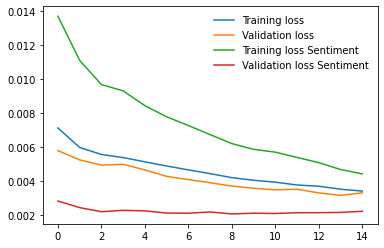

In [22]:
plt.plot(train_losses, label='Training loss')
plt.plot(test_losses, label='Validation loss')
plt.plot(train_losses_sentiment, label='Training loss Sentiment')
plt.plot(test_losses_sentiment, label='Validation loss Sentiment')
plt.legend(frameon=False)

In [31]:
#Save the model
torch.save(torchModelLight2.state_dict(),'torchModelLight2_state_dict.pth')

In [40]:
#Evaluate model
Y_pred = []
sentiment_pred = []
targets = []
sentiment_targets = []

#for X_batch, labels, sentiments in mMiniBatcherValidation.getBatchIterator():
for X_batch, labels, sentiments in mMiniBatcherTest2.getBatchIterator():
#for X_batch, labels, sentiments in mMiniBatcherTrain2.getBatchIterator():

    X_batch = torch.tensor(X_batch).to(device)
    labels = torch.tensor(labels).to(device)
    output, sentiment_batch = torchModelLight2.predict(X_batch)
    
    targets.extend(labels.cpu())
    sentiment_targets.extend(sentiments)
    
    Y_pred.extend(output)
    sentiment_pred.extend(sentiment_batch)
    
Y_pred = np.array(Y_pred)
sentiment_pred = np.array(sentiment_pred)
targets = np.array(targets)
sentiment_targets = np.array(sentiment_targets)


Accuracy: 0.8753214285714286
Accuracy Sentiment: 0.781


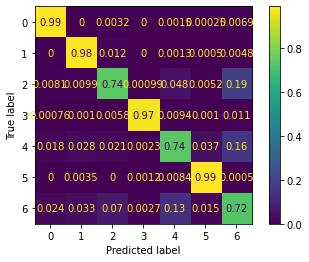

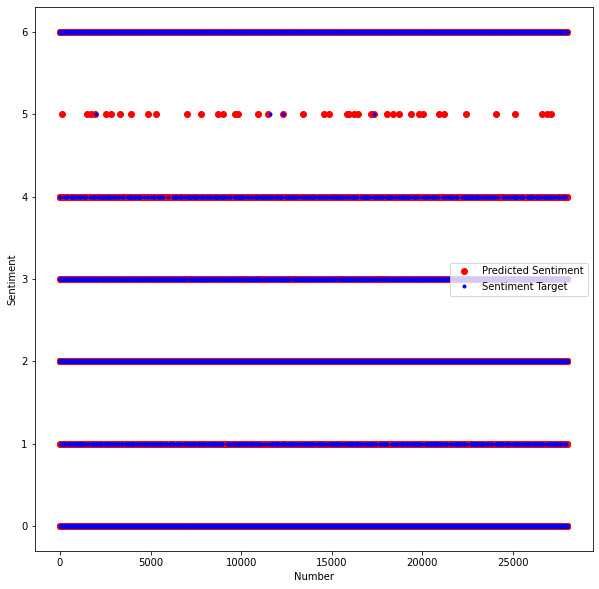

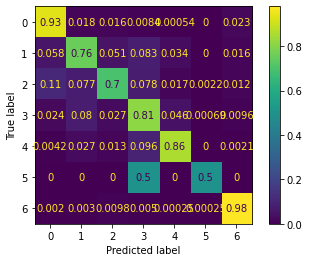

In [41]:
accuracy = np.mean(Y_pred == targets)
print(f'Accuracy: {accuracy}')

accuracySentiment = np.mean(sentiment_pred == sentiment_targets)
print(f'Accuracy Sentiment: {accuracySentiment}')

cm = confusion_matrix(targets, Y_pred, normalize='true', labels=list(set(targets)))
ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(set(targets))).plot();
plt.figure(figsize=(10,10))
plt.plot(sentiment_pred, 'or', label='Predicted Sentiment')
plt.plot(sentiment_targets, '.b', label='Sentiment Target')
plt.xlabel('Number')
plt.ylabel('Sentiment')
plt.legend()
cm = confusion_matrix(sentiment_targets, sentiment_pred, normalize='true', labels=list(set(sentiment_targets)))
ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(set(sentiment_targets))).plot();

In [ ]:
plt.hist(sentiment_pred)

In [ ]:
plt.hist(sentiment_targets)

In [ ]:
def MakePredictions2(X, model, transformer, classes = None, classes_sentiment = None):
    
    #Check model device
    #modelOnCuda = next(torchModelLight.parameters()).is_cuda
    
    #Make sure both model and inputs are on the same device
    cuda_enabled = torch.cuda.is_available()
    if cuda_enabled:
        device = torch.device('cuda')
    else:
        device = torch.device('cpu')
    
    model.to(device)
    
    
    X = transformer.transform(X) #Output is numpy array
    X = torch.tensor(X).to(device)
    output, sentiments = model.predict(X)
    
    if classes is not None:
        output = [classes[i] for i in output]
        
    if classes_sentiment is not None:
        sentiments = [classes_sentiment[i] for i in sentiments]
    
    return output, sentiments
    


In [ ]:
transformer = NLPTransformer()

In [ ]:
classes = ['Avvikelse', 'Beröm', 'Fråga', 'Förseningsersättning', 'Klagomål',
       'Skada', 'Synpunkt/Önskemål']
sentiment_classes = ['Mest upprörd', 'Upprörd', 'Neutralt negativ', 'Neutralt', 'Neutralt positiv', 'Positiv', 'Mest positiv']

In [ ]:
inputs = pd.Series(data={'Beskrivning_Anonymized':'Era utvecklare är verkligen trevliga.'}) 
classType, sentiment = MakePredictions2(inputs, torchModelLight2, transformer, classes, sentiment_classes)
print(f'Class: {classType}, Sentiment: {sentiment}')

In [ ]:
#Test and load model back
n_classes = 7
n_classes_sentiment = 7
torchModelLight2 = TorchNLPLight2(n_classes, n_classes_sentiment)
torchModelLight2.load_state_dict(torch.load('torchModelLight2_state_dict.pth', map_location=torch.device('cuda')))

In [26]:
#Test totally unseen data from validation set
Y_validation = pd.read_pickle('targets_validation.pkl')
Y2_validation = pd.read_pickle('targets2_validation.pkl')


In [27]:
Y_validation = Y_validation.values.argmax(axis=1)
Y_validation = np.array(Y_validation)
Y2_validation = np.array(Y2_validation)
Y2_classes_validation = np.array(Y2_validation*3 + 3).astype('int64')

In [28]:
X_transformed_validation = np.load('transformed_data_validation.pkl.npy')

In [29]:
X_transformed_validation[10]

array([ 9.75877225e-01, -4.64726165e-02,  9.78952527e-01,  2.07863852e-01,
        1.82278723e-01, -1.71879217e-01, -1.50546432e-01, -9.72502232e-01,
       -6.06346540e-02, -9.59654689e-01, -5.62323108e-02,  6.22168258e-02,
        4.25302796e-02,  5.86811781e-01,  1.60254717e-01,  2.43713319e-01,
        2.69229680e-01,  2.66085953e-01,  4.57862094e-02,  9.84844387e-01,
        1.47463113e-01, -2.39533842e-01,  2.22151369e-01,  3.37094158e-01,
        8.71667732e-03, -6.16161585e-01,  5.74678630e-02,  1.17669515e-01,
        1.65041089e-01,  5.39928898e-02, -6.26166686e-02, -3.96967292e-01,
       -9.43375528e-01, -8.64808381e-01, -2.24366754e-01, -2.04103053e-01,
        3.96858305e-01,  2.54188359e-01, -7.02160746e-02, -3.16740215e-01,
       -2.08644196e-01,  2.57313460e-01, -7.44013190e-02, -5.20727873e-01,
        9.86848176e-01,  1.59469210e-02,  8.23532581e-01,  2.38894790e-01,
        2.29478013e-02, -2.47538298e-01,  8.36779848e-02, -7.34869242e-01,
        4.99377884e-02, -

In [30]:
mMiniBatcherValidation = MiniBatcher2(X_transformed_validation, Y_validation, Y2_classes_validation, batch_size=100)

In [ ]:
Y2_validation

In [ ]:
Y2_classes_validation

In [ ]:
plt.hist(Y2_classes_validation)